# **Maverik Modeling Assignment**

# Prophet Rolling Forecast
This is the rolling forecast model shown in the presentation for Maverik in the Fall 2023 MSBA Capstone.

We created a rolling window forecast model that produces daily predictions for a given horizon period (365 days). This model takes into account new sales data, and re-trains the model to produce a more accurate prediction every day.

In [1]:
import warnings
warnings.filterwarnings('ignore')

## Pre-processing

In [2]:
# Installing Dependencies
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error

#Loading data
# File paths
time_series = "/Users/pablozarate/Documents/MSBA/Maverick/time_series_data_msba.csv"
qual_data = '/Users/pablozarate/Documents/MSBA/Maverick/qualitative_data_msba.csv'
data_sales = pd.read_csv(time_series)
data_stores = pd.read_csv(qual_data)

#Merging the datasets
df = data_stores.merge(data_sales, how = 'inner', on=['site_id_msba'])
pd.set_option('display.max_columns', None)
# df.head()

# Loading national gas/diesel prices data
unleaded_prices = "/Users/pablozarate/Documents/MSBA/Maverick/gas_prices.xls"
diesel_prices = "/Users/pablozarate/Documents/MSBA/Maverick/diesel_prices.xls"
natl_unleaded = pd.read_excel(unleaded_prices, sheet_name=1)
natl_diesel = pd.read_excel(diesel_prices, sheet_name = 1)

pd.set_option('display.max_columns', None)
# natl_unleaded.head()
# natl_diesel.head()

# Skip the first two rows and rename
natl_unleaded_cleaned = natl_unleaded.iloc[2:].reset_index(drop=True)
natl_unleaded_cleaned.columns = ['Date', 'Unleaded Price']
natl_diesel_cleaned = natl_diesel.iloc[2:].reset_index(drop=True)
natl_diesel_cleaned.columns = ['Date', 'Diesel Price']

#Converting date to datetime
natl_unleaded_cleaned['Date'] = pd.to_datetime(natl_unleaded_cleaned['Date'])
natl_diesel_cleaned['Date'] = pd.to_datetime(natl_diesel_cleaned['Date'])

# Define your start date
start_date = pd.Timestamp('2021-01-11')
end_date = pd.Timestamp('2023-08-16')

# Filter the DataFrames
unleaded_filtered_data = natl_unleaded_cleaned[(natl_unleaded_cleaned['Date'] >= start_date) & (natl_unleaded_cleaned['Date'] <= end_date)]
diesel_filtered_data = natl_diesel_cleaned[(natl_diesel_cleaned['Date'] >= start_date) & (natl_diesel_cleaned['Date'] <= end_date)]

# Replacing nulls with None
cols_to_fill = ['rv_lanes_layout', 'rv_lanes_stack_type', 'hi_flow_lanes_layout','hi_flow_lanes_stack_type','hi_flow_rv_lanes_layout', 
                'hi_flow_rv_lanes_stack_type', 'traditional_forecourt_stack_type'
               ]
for col_name in cols_to_fill:
    df[col_name].fillna("None", inplace=True)
    
# Dropping irrelevant columns
df = df.drop(['Unnamed: 0_x','Unnamed: 0_y'], axis = 1)
cols_drop = ['front_door_count','godfather_s_pizza','diesel_x','non_24_hour','self_check_out','car_wash', 'ev_charging']
df = df.drop(columns=cols_drop)

# Converting date to datetime
df['calendar.calendar_day_date'] = pd.to_datetime(df['calendar.calendar_day_date'])
df['capital_projects.soft_opening_date'] = pd.to_datetime(df['capital_projects.soft_opening_date'])

# Removing data for site id 21980, has exceptionally high diesel sales
df = df[df['site_id_msba'] != 21980]

# Convert object columns to category
for column in df.select_dtypes(include=['object']).columns:
    df[column] = df[column].astype('category')

# List to hold one-hot encoded DataFrames
one_hot_encoded_dfs = []

# One-Hot Encoding for Prophet
categorical_columns = ['pizza', 'rv_lanes', 'def', 'rv_lanes_layout', 'hi_flow_lanes', 'hi_flow_rv_lanes', 'lottery', 'freal',
                       'bonfire_grill', 'cinnabon', 'ethanol_free', 'cat_scales', 'rv_dumps', 'propane',
                       'traditional_forecourt_layout', 'traditional_forecourt_stack_type', 'rv_lanes_stack_type', 'hi_flow_lanes_layout',
                       'hi_flow_lanes_stack_type', 'hi_flow_rv_lanes_layout', 'hi_flow_rv_lanes_stack_type'
                       ]

for column in categorical_columns:
    # Get the one-hot encoded DataFrame for the current column
    one_hot = pd.get_dummies(df[column], prefix=column)
    # Add the one-hot encoded DataFrame to the list
    one_hot_encoded_dfs.append(one_hot)
    # Drop the original categorical column from the DataFrame
    df = df.drop(column, axis=1)

# Join all one-hot encoded DataFrames with the original DataFrame
df = pd.concat([df] + one_hot_encoded_dfs, axis=1)

# Renaming msba site id to store id for Prophet
df.rename(columns={'site_id_msba': 'store_id'}, inplace=True)
df.rename(columns={'calendar.calendar_day_date': 'ds'}, inplace=True)

merged_df_unleaded = pd.merge(df, unleaded_filtered_data, left_on='ds', right_on='Date', how='left')
final_merged_df = pd.merge(merged_df_unleaded, diesel_filtered_data, left_on='ds', right_on='Date', how='left')
final_merged_df.drop(columns=['Date_y', 'Date_x'], inplace=True)
final_merged_df.sort_values(by='ds', inplace=True)

final_merged_df['Unleaded Price'] = final_merged_df['Unleaded Price'].ffill()
final_merged_df['Diesel Price'] = final_merged_df['Diesel Price'].ffill()

# Define the date range
start_date = pd.Timestamp('2021-01-11')
end_date = pd.Timestamp('2021-01-17')

# Filter the DataFrame for the specified date range
date_range_filter = (final_merged_df['ds'] >= start_date) & (final_merged_df['ds'] <= end_date)

# Manually set the Diesel and Unleaded Prices for this date range
final_merged_df.loc[date_range_filter, 'Diesel Price'] = 2.67
final_merged_df.loc[date_range_filter, 'Unleaded Price'] = 2.379

final_merged_df = final_merged_df.sort_values(by='ds', ascending=True)
df = final_merged_df

# Seasons
def is_spring(date):
    return pd.Timestamp(year=date.year, month=3, day=1) <= date <= pd.Timestamp(year=date.year, month=5, day=31)

def is_summer(date):
    return pd.Timestamp(year=date.year, month=6, day=1) <= date <= pd.Timestamp(year=date.year, month=8, day=31)

def is_fall(date):
    return pd.Timestamp(year=date.year, month=9, day=1) <= date <= pd.Timestamp(year=date.year, month=11, day=30)

def is_winter(date):
    year_end = pd.Timestamp(year=date.year, month=12, day=31)
    year_start = pd.Timestamp(year=date.year, month=1, day=1)
    if date.year % 4 == 0 and (date.year % 100 != 0 or date.year % 400 == 0):  # Leap year
        feb_end = pd.Timestamp(year=date.year, month=2, day=29)
    else:  # Non-leap year
        feb_end = pd.Timestamp(year=date.year, month=2, day=28)
    return pd.Timestamp(year=date.year, month=12, day=1) <= date <= year_end or year_start <= date <= feb_end

# Apply these functions to create season columns in your DataFrame
df['is_spring'] = df['ds'].apply(is_spring)
df['is_summer'] = df['ds'].apply(is_summer)
df['is_fall'] = df['ds'].apply(is_fall)
df['is_winter'] = df['ds'].apply(is_winter)

# If 'open_year' is in datetime format
df['open_year'] = pd.to_datetime(df['open_year'])
df['open_year'] = df['open_year'].dt.year
df['store_age'] = df['ds'].dt.year - df['open_year']
# Handling negative ages
df['store_age'] = df['store_age'].clip(lower=0)

# Assigning flag for opening date to store
for store_id in df['store_id'].unique():
    df[f'soft_opening_{store_id}'] = np.where((df['store_id'] == store_id) & 
                                              (df['ds'] == df['capital_projects.soft_opening_date']), 1, 0)


In [3]:
# Segmenting dataframes by sales metric for Prophet
prophet_df_unleaded = df[['store_id', 'ds', 'unleaded', 'calendar_information.holiday', 'x1_mile_pop', 'x1_mile_emp', 'x1_mile_income', 'x1_2_mile_pop', 'x1_2_mile_emp', 
                          'x1_2_mile_income', 'x5_min_pop', 'x5_min_emp','x5_min_inc','x7_min_pop', 'x7_min_emp', 'x7_min_inc', 'open_year', 'womens_sink_count',
                          'pizza_No', 'pizza_Yes', 'rv_lanes_No', 'rv_lanes_Yes', 'def_No', 'def_Yes', 'rv_lanes_layout_In-Line', 'rv_lanes_layout_None', 
                          'rv_lanes_layout_Stack', 'hi_flow_lanes_No', 'hi_flow_lanes_Yes', 'hi_flow_rv_lanes_No', 'hi_flow_rv_lanes_Yes','is_spring', 'is_summer',
                          'is_fall', 'is_winter', 'hi_flow_lanes_fueling_positions', 'mens_urinal_count', 'mens_toilet_count', 'Unleaded Price', 'Diesel Price'
                       , 'square_feet', 'years_since_last_project', 'parking_spaces', 'traditional_forecourt_fueling_positions', 'rv_lanes_fueling_positions'
                       , 'womens_toilet_count', 'lottery_Yes', 'lottery_No', 'freal_Yes', 'freal_No', 'bonfire_grill_Yes', 'bonfire_grill_No', 'propane_Yes', 'propane_No'
                  ,'cinnabon_Yes', 'cinnabon_No', 'ethanol_free_Yes', 'ethanol_free_No', 'cat_scales_Yes', 'cat_scales_No', 'rv_dumps_Yes', 'rv_dumps_No',
                        'traditional_forecourt_layout_Stack', 'traditional_forecourt_layout_In-Line', 'traditional_forecourt_stack_type_Large',  'traditional_forecourt_stack_type_None', 'traditional_forecourt_stack_type_Extra-Large' 
                        ,'rv_lanes_stack_type_HF/RV', 'rv_lanes_stack_type_None', 'hi_flow_lanes_layout_Stack', 'hi_flow_lanes_layout_Combo','hi_flow_lanes_layout_None', 'hi_flow_lanes_stack_type_HF/RV', 'hi_flow_lanes_stack_type_None'
                        , 'hi_flow_rv_lanes_layout_Combo', 'hi_flow_rv_lanes_layout_In-Line', 'hi_flow_rv_lanes_layout_None', 'hi_flow_rv_lanes_layout_Stack', 'hi_flow_rv_lanes_stack_type_HF/RV', 'hi_flow_rv_lanes_stack_type_None'
, 'store_age', 'soft_opening_21560', 'soft_opening_22015', 'soft_opening_22085', 'soft_opening_22330', 'soft_opening_22785', 'soft_opening_22540', 'soft_opening_22715', 'soft_opening_22750', 'soft_opening_22820', 'soft_opening_23135', 
'soft_opening_22855', 'soft_opening_22925', 'soft_opening_23450', 'soft_opening_22505', 'soft_opening_22645', 'soft_opening_23380', 'soft_opening_22260', 'soft_opening_22575', 'soft_opening_23485', 'soft_opening_22400', 'soft_opening_22120', 
'soft_opening_23345', 'soft_opening_23730', 'soft_opening_23240', 'soft_opening_22680', 'soft_opening_23660', 'soft_opening_23415', 'soft_opening_23835', 'soft_opening_23765', 'soft_opening_23905', 'soft_opening_24535', 'soft_opening_23555', 
'soft_opening_24220', 'soft_opening_22890', 'soft_opening_24255', 'soft_opening_24150'
]].copy()
prophet_df_unleaded.rename(columns={'unleaded': 'y'}, inplace=True)

prophet_df_diesel = df[['store_id', 'ds', 'diesel_y', 'calendar_information.holiday', 'x1_mile_pop', 'x1_mile_emp', 'x1_mile_income', 'x1_2_mile_pop', 'x1_2_mile_emp', 
                          'x1_2_mile_income', 'x5_min_pop', 'x5_min_emp','x5_min_inc','x7_min_pop', 'x7_min_emp', 'x7_min_inc', 'open_year', 'womens_sink_count',
                          'pizza_No', 'pizza_Yes', 'rv_lanes_No', 'rv_lanes_Yes', 'def_No', 'def_Yes', 'rv_lanes_layout_In-Line', 'rv_lanes_layout_None', 
                          'rv_lanes_layout_Stack', 'hi_flow_lanes_No', 'hi_flow_lanes_Yes', 'hi_flow_rv_lanes_No', 'hi_flow_rv_lanes_Yes','is_spring', 'is_summer',
                          'is_fall', 'is_winter', 'hi_flow_lanes_fueling_positions', 'mens_urinal_count', 'mens_toilet_count', 'Unleaded Price', 'Diesel Price'
                          , 'square_feet', 'years_since_last_project', 'parking_spaces', 'traditional_forecourt_fueling_positions', 'rv_lanes_fueling_positions'
                          , 'womens_toilet_count', 'lottery_Yes', 'lottery_No', 'freal_Yes', 'freal_No', 'bonfire_grill_Yes', 'bonfire_grill_No', 'propane_Yes', 'propane_No'
                          ,'cinnabon_Yes', 'cinnabon_No', 'ethanol_free_Yes', 'ethanol_free_No', 'cat_scales_Yes', 'cat_scales_No', 'rv_dumps_Yes', 'rv_dumps_No',
                          'traditional_forecourt_layout_Stack', 'traditional_forecourt_layout_In-Line', 'traditional_forecourt_stack_type_Large',  'traditional_forecourt_stack_type_None', 'traditional_forecourt_stack_type_Extra-Large' 
                        ,'rv_lanes_stack_type_HF/RV', 'rv_lanes_stack_type_None', 'hi_flow_lanes_layout_Stack', 'hi_flow_lanes_layout_Combo','hi_flow_lanes_layout_None', 'hi_flow_lanes_stack_type_HF/RV', 'hi_flow_lanes_stack_type_None'
                           , 'hi_flow_rv_lanes_layout_Combo', 'hi_flow_rv_lanes_layout_In-Line', 'hi_flow_rv_lanes_layout_None', 'hi_flow_rv_lanes_layout_Stack', 'hi_flow_rv_lanes_stack_type_HF/RV', 'hi_flow_rv_lanes_stack_type_None'
, 'store_age', 'soft_opening_21560', 'soft_opening_22015', 'soft_opening_22085', 'soft_opening_22330', 'soft_opening_22785', 'soft_opening_22540', 'soft_opening_22715', 'soft_opening_22750', 'soft_opening_22820', 'soft_opening_23135', 
'soft_opening_22855', 'soft_opening_22925', 'soft_opening_23450', 'soft_opening_22505', 'soft_opening_22645', 'soft_opening_23380', 'soft_opening_22260', 'soft_opening_22575', 'soft_opening_23485', 'soft_opening_22400', 'soft_opening_22120', 
'soft_opening_23345', 'soft_opening_23730', 'soft_opening_23240', 'soft_opening_22680', 'soft_opening_23660', 'soft_opening_23415', 'soft_opening_23835', 'soft_opening_23765', 'soft_opening_23905', 'soft_opening_24535', 'soft_opening_23555', 
'soft_opening_24220', 'soft_opening_22890', 'soft_opening_24255', 'soft_opening_24150'
]].copy()
prophet_df_diesel.rename(columns={'diesel_y': 'y'}, inplace=True)

prophet_df_food_sales = df[['store_id', 'ds', 'daily_yoy_ndt.total_food_service', 'calendar_information.holiday', 'x1_mile_pop', 'x1_mile_emp', 'x1_mile_income', 'x1_2_mile_pop', 'x1_2_mile_emp', 
                          'x1_2_mile_income', 'x5_min_pop', 'x5_min_emp','x5_min_inc','x7_min_pop', 'x7_min_emp', 'x7_min_inc', 'open_year', 'womens_sink_count',
                          'pizza_No', 'pizza_Yes', 'rv_lanes_No', 'rv_lanes_Yes', 'def_No', 'def_Yes', 'rv_lanes_layout_In-Line', 'rv_lanes_layout_None', 
                          'rv_lanes_layout_Stack', 'hi_flow_lanes_No', 'hi_flow_lanes_Yes', 'hi_flow_rv_lanes_No', 'hi_flow_rv_lanes_Yes','is_spring', 'is_summer',
                          'is_fall', 'is_winter', 'hi_flow_lanes_fueling_positions', 'mens_urinal_count', 'mens_toilet_count', 'Unleaded Price', 'Diesel Price'
                          , 'square_feet', 'years_since_last_project', 'parking_spaces', 'traditional_forecourt_fueling_positions', 'rv_lanes_fueling_positions'
                          , 'womens_toilet_count', 'lottery_Yes', 'lottery_No', 'freal_Yes', 'freal_No', 'bonfire_grill_Yes', 'bonfire_grill_No', 'propane_Yes', 'propane_No'
                          ,'cinnabon_Yes', 'cinnabon_No', 'ethanol_free_Yes', 'ethanol_free_No', 'cat_scales_Yes', 'cat_scales_No', 'rv_dumps_Yes', 'rv_dumps_No',
                          'traditional_forecourt_layout_Stack', 'traditional_forecourt_layout_In-Line', 'traditional_forecourt_stack_type_Large',  'traditional_forecourt_stack_type_None', 'traditional_forecourt_stack_type_Extra-Large' 
                        ,'rv_lanes_stack_type_HF/RV', 'rv_lanes_stack_type_None', 'hi_flow_lanes_layout_Stack', 'hi_flow_lanes_layout_Combo','hi_flow_lanes_layout_None', 'hi_flow_lanes_stack_type_HF/RV', 'hi_flow_lanes_stack_type_None'
                           , 'hi_flow_rv_lanes_layout_Combo', 'hi_flow_rv_lanes_layout_In-Line', 'hi_flow_rv_lanes_layout_None', 'hi_flow_rv_lanes_layout_Stack', 'hi_flow_rv_lanes_stack_type_HF/RV', 'hi_flow_rv_lanes_stack_type_None'
, 'store_age', 'soft_opening_21560', 'soft_opening_22015', 'soft_opening_22085', 'soft_opening_22330', 'soft_opening_22785', 'soft_opening_22540', 'soft_opening_22715', 'soft_opening_22750', 'soft_opening_22820', 'soft_opening_23135', 
'soft_opening_22855', 'soft_opening_22925', 'soft_opening_23450', 'soft_opening_22505', 'soft_opening_22645', 'soft_opening_23380', 'soft_opening_22260', 'soft_opening_22575', 'soft_opening_23485', 'soft_opening_22400', 'soft_opening_22120', 
'soft_opening_23345', 'soft_opening_23730', 'soft_opening_23240', 'soft_opening_22680', 'soft_opening_23660', 'soft_opening_23415', 'soft_opening_23835', 'soft_opening_23765', 'soft_opening_23905', 'soft_opening_24535', 'soft_opening_23555', 
'soft_opening_24220', 'soft_opening_22890', 'soft_opening_24255', 'soft_opening_24150'
]].copy()
prophet_df_food_sales.rename(columns={'daily_yoy_ndt.total_food_service': 'y'}, inplace=True)

prophet_df_inside_sales = df[['store_id', 'ds', 'daily_yoy_ndt.total_inside_sales', 'calendar_information.holiday', 'x1_mile_pop', 'x1_mile_emp', 'x1_mile_income', 'x1_2_mile_pop', 'x1_2_mile_emp', 
                          'x1_2_mile_income', 'x5_min_pop', 'x5_min_emp','x5_min_inc','x7_min_pop', 'x7_min_emp', 'x7_min_inc', 'open_year', 'womens_sink_count',
                          'pizza_No', 'pizza_Yes', 'rv_lanes_No', 'rv_lanes_Yes', 'def_No', 'def_Yes', 'rv_lanes_layout_In-Line', 'rv_lanes_layout_None', 
                          'rv_lanes_layout_Stack', 'hi_flow_lanes_No', 'hi_flow_lanes_Yes', 'hi_flow_rv_lanes_No', 'hi_flow_rv_lanes_Yes','is_spring', 'is_summer',
                          'is_fall', 'is_winter', 'hi_flow_lanes_fueling_positions', 'mens_urinal_count', 'mens_toilet_count', 'Unleaded Price', 'Diesel Price'
                          , 'square_feet', 'years_since_last_project', 'parking_spaces', 'traditional_forecourt_fueling_positions', 'rv_lanes_fueling_positions'
                          , 'womens_toilet_count', 'lottery_Yes', 'lottery_No', 'freal_Yes', 'freal_No', 'bonfire_grill_Yes', 'bonfire_grill_No', 'propane_Yes', 'propane_No'
                          ,'cinnabon_Yes', 'cinnabon_No', 'ethanol_free_Yes', 'ethanol_free_No', 'cat_scales_Yes', 'cat_scales_No', 'rv_dumps_Yes', 'rv_dumps_No',
                          'traditional_forecourt_layout_Stack', 'traditional_forecourt_layout_In-Line', 'traditional_forecourt_stack_type_Large',  'traditional_forecourt_stack_type_None', 'traditional_forecourt_stack_type_Extra-Large' 
                        ,'rv_lanes_stack_type_HF/RV', 'rv_lanes_stack_type_None', 'hi_flow_lanes_layout_Stack', 'hi_flow_lanes_layout_Combo','hi_flow_lanes_layout_None', 'hi_flow_lanes_stack_type_HF/RV', 'hi_flow_lanes_stack_type_None'
                           , 'hi_flow_rv_lanes_layout_Combo', 'hi_flow_rv_lanes_layout_In-Line', 'hi_flow_rv_lanes_layout_None', 'hi_flow_rv_lanes_layout_Stack', 'hi_flow_rv_lanes_stack_type_HF/RV', 'hi_flow_rv_lanes_stack_type_None'
, 'store_age', 'soft_opening_21560', 'soft_opening_22015', 'soft_opening_22085', 'soft_opening_22330', 'soft_opening_22785', 'soft_opening_22540', 'soft_opening_22715', 'soft_opening_22750', 'soft_opening_22820', 'soft_opening_23135', 
'soft_opening_22855', 'soft_opening_22925', 'soft_opening_23450', 'soft_opening_22505', 'soft_opening_22645', 'soft_opening_23380', 'soft_opening_22260', 'soft_opening_22575', 'soft_opening_23485', 'soft_opening_22400', 'soft_opening_22120', 
'soft_opening_23345', 'soft_opening_23730', 'soft_opening_23240', 'soft_opening_22680', 'soft_opening_23660', 'soft_opening_23415', 'soft_opening_23835', 'soft_opening_23765', 'soft_opening_23905', 'soft_opening_24535', 'soft_opening_23555', 
'soft_opening_24220', 'soft_opening_22890', 'soft_opening_24255', 'soft_opening_24150'
]].copy()
prophet_df_inside_sales.rename(columns={'daily_yoy_ndt.total_inside_sales': 'y'}, inplace=True)

# Now creating a DataFrame for holidays for Prophet
holidays_df = df[df['calendar_information.holiday'].notnull()][['ds', 'calendar_information.holiday']].copy()
holidays_df.rename(columns={'calendar_information.holiday': 'holiday'}, inplace=True)
holidays_df = holidays_df.drop_duplicates()  # Ensure there are no duplicate holiday entries


## Train & Test Split

In [4]:
# Define the holdout store ID
holdout_store_id = 24535

# Split date (one day before the store's opening date)
split_date = pd.Timestamp('2022-06-13')

# Function to split data into train and test based on date and holdout store
def split_data_date(prophet_df, split_date, holdout_store_id):
    # All data up to split_date for training (includes all stores)
    train_data = prophet_df[prophet_df['ds'] <= split_date]
    
    # Data after split_date for testing, but only for the holdout store
    test_data = prophet_df[(prophet_df['ds'] > split_date) & (prophet_df['store_id'] == holdout_store_id)]
    
    return train_data, test_data

# Apply this function to each of your Prophet dataframes
train_unleaded, test_unleaded = split_data_date(prophet_df_unleaded, split_date, holdout_store_id)
train_diesel, test_diesel = split_data_date(prophet_df_diesel, split_date, holdout_store_id)
train_food_sales, test_food_sales = split_data_date(prophet_df_food_sales, split_date, holdout_store_id)
train_inside_sales, test_inside_sales = split_data_date(prophet_df_inside_sales, split_date, holdout_store_id)


## Initial Model Training

In [5]:
from prophet import Prophet

# Dictionary to store models for each metric
models = {}

# Define the extra regressors you've used
extra_regressors = ['x1_mile_pop', 'x1_2_mile_pop', 'hi_flow_lanes_fueling_positions', 'mens_urinal_count', 'womens_sink_count', 
                    'x7_min_pop', 'store_age', 'years_since_last_project', 'pizza_No', 'pizza_Yes', 'rv_lanes_No', 
                    'rv_lanes_Yes', 'def_No', 'def_Yes', 'rv_lanes_layout_In-Line', 'rv_lanes_layout_None', 
                    'rv_lanes_layout_Stack', 'hi_flow_lanes_No', 'hi_flow_lanes_Yes', 'Diesel Price', 'Unleaded Price', 
                    'hi_flow_rv_lanes_No', 'hi_flow_rv_lanes_Yes', 'cinnabon_Yes', 'cinnabon_No', 'rv_lanes_stack_type_HF/RV', 
                    'rv_lanes_stack_type_None', 'hi_flow_lanes_stack_type_HF/RV', 'hi_flow_lanes_stack_type_None', 
                    'hi_flow_rv_lanes_stack_type_HF/RV', 'hi_flow_rv_lanes_stack_type_None'] + \
                   [f'soft_opening_{store_id}' for store_id in df['store_id'].unique()]

# Define n_changepoints for each metric (adjust based on your previous analysis)
n_changepoints_dict = {'unleaded': 4, 'diesel': 4, 'food_sales': 0, 'inside_sales': 0}

# Train models for each metric
for metric in ['unleaded', 'diesel', 'food_sales', 'inside_sales']:

    # Initialize the Prophet model with holidays and n_changepoints
    model = Prophet(holidays=holidays_df, n_changepoints=n_changepoints_dict[metric], changepoint_prior_scale=0.1)

    # Add custom seasonalities
    model.add_seasonality(name='summer', period=365.25/4, fourier_order=6, condition_name='is_summer')
    model.add_seasonality(name='fall', period=365.25/4, fourier_order=6, condition_name='is_fall')
    model.add_seasonality(name='winter', period=365.25/4, fourier_order=6, condition_name='is_winter')
    model.add_seasonality(name='spring', period=365.25/4, fourier_order=6, condition_name='is_spring')
    model.add_seasonality(name='weekly', period=7, fourier_order=3)

    # Add extra regressors
    for regressor in extra_regressors:
        model.add_regressor(regressor)
        
    # Retrieve training data
    train_data = globals()[f'train_{metric}']
    
    # Fit the model using both the 'ds', 'y', and the extra regressors
    model.fit(train_data[['ds', 'y'] + extra_regressors 
                         + ['is_spring', 'is_summer', 'is_fall', 'is_winter']
                         ])

    # Store the model in the dictionary
    models[metric] = model


09:04:01 - cmdstanpy - INFO - Chain [1] start processing
09:04:07 - cmdstanpy - INFO - Chain [1] done processing
09:04:11 - cmdstanpy - INFO - Chain [1] start processing
09:04:15 - cmdstanpy - INFO - Chain [1] done processing
09:04:19 - cmdstanpy - INFO - Chain [1] start processing
09:04:23 - cmdstanpy - INFO - Chain [1] done processing
09:04:26 - cmdstanpy - INFO - Chain [1] start processing
09:04:30 - cmdstanpy - INFO - Chain [1] done processing


## Rolling Forecast Training & Testing

In [6]:
forecast_horizon = 365
holdout_store_id = 24535
forecasted_values = {'unleaded': [], 'diesel': [], 'food_sales': [], 'inside_sales': []}
actual_values = {'unleaded': [], 'diesel': [], 'food_sales': [], 'inside_sales': []}
daily_forecasted_values = {metric: {} for metric in ['unleaded', 'diesel', 'food_sales', 'inside_sales']}

# Function to add seasonality flags to the dataframe
def add_seasonality_flags(df):
    df['is_spring'] = df['ds'].apply(is_spring)
    df['is_summer'] = df['ds'].apply(is_summer)
    df['is_fall'] = df['ds'].apply(is_fall)
    df['is_winter'] = df['ds'].apply(is_winter)
    return df

# Dictionary to store training and test sets for each metric
train_sets = {}
test_sets = {}

# Initial train-test split for each metric
train_sets['unleaded'], test_sets['unleaded'] = split_data_date(prophet_df_unleaded, split_date, holdout_store_id)
train_sets['diesel'], test_sets['diesel'] = split_data_date(prophet_df_diesel, split_date, holdout_store_id)
train_sets['food_sales'], test_sets['food_sales'] = split_data_date(prophet_df_food_sales, split_date, holdout_store_id)
train_sets['inside_sales'], test_sets['inside_sales'] = split_data_date(prophet_df_inside_sales, split_date, holdout_store_id)

# Dictionary to store models for each metric
models = {}

# Initialize training data for each metric outside the loop
initial_train_unleaded = train_sets['unleaded']
initial_train_diesel = train_sets['diesel']
initial_train_food_sales = train_sets['food_sales']
initial_train_inside_sales = train_sets['inside_sales']

for day in range(forecast_horizon):
    print(f"Processing day: {day + 1}/{forecast_horizon}")
    
    # Adjust the forecast horizon dynamically
    adjusted_horizon = forecast_horizon - day

    for metric in ['unleaded', 'diesel', 'food_sales', 'inside_sales']:
        # Select the initial training data based on the metric
        if metric == 'unleaded':
            train_data = initial_train_unleaded
        elif metric == 'diesel':
            train_data = initial_train_diesel
        elif metric == 'food_sales':
            train_data = initial_train_food_sales
        else:  # 'inside_sales'
            train_data = initial_train_inside_sales

        print(f"Day {day + 1}, Metric {metric}, Before update: {len(train_data)} rows")

        actual_date = split_date + pd.Timedelta(days=day)
        if day > 0:
            new_actuals = test_sets[metric][(test_sets[metric]['ds'] == actual_date) & (test_sets[metric]['store_id'] == holdout_store_id)]
            print(f"  Adding {len(new_actuals)} new actuals for {actual_date}")

            if not new_actuals.empty:
                train_data = pd.concat([train_data, new_actuals]).drop_duplicates()
                print(f"Day {day + 1}, Metric {metric}, After update: {len(train_data)} rows")

        # Reinitialize the Prophet model (using the same parameters as in initial training)
        models[metric] = Prophet(holidays=holidays_df, n_changepoints=n_changepoints_dict[metric], changepoint_prior_scale=.1)
        models[metric].add_seasonality(name='summer', period=365.25/4, fourier_order=6, condition_name='is_summer')
        models[metric].add_seasonality(name='fall', period=365.25/4, fourier_order=6, condition_name='is_fall')      
        models[metric].add_seasonality(name='winter', period=365.25/4, fourier_order=6, condition_name='is_winter')
        models[metric].add_seasonality(name='spring', period=365.25/4, fourier_order=6, condition_name='is_spring')
        models[metric].add_seasonality(name='weekly', period=7, fourier_order=3)
        for regressor in extra_regressors:
            models[metric].add_regressor(regressor)

        # Fit the model with updated training data
        models[metric].fit(train_data[['ds', 'y'] 
                                      + extra_regressors 
                                      + ['is_spring', 'is_summer', 'is_fall', 'is_winter']])

        # Prepare future dataframe for the next day forecast
        future = models[metric].make_future_dataframe(periods=adjusted_horizon)

        # Add necessary columns (e.g., extra regressors) to the future dataframe
        future = future.merge(df[['ds'] 
                                 + extra_regressors
                                 ], on='ds', how='left')
        future = add_seasonality_flags(future)  # Adding seasonality flags
        future.fillna(method='ffill', inplace=True)

        # Forecast for the adjusted horizon
        forecast = models[metric].predict(future)

        # Store forecasted values for each day in the adjusted horizon
        for horizon_day in range(1, adjusted_horizon + 1):
            forecast_date = split_date + pd.Timedelta(days=day + horizon_day)
            forecasted_value = forecast.loc[forecast['ds'] == forecast_date, 'yhat'].values[0]
            daily_forecasted_values[metric][forecast_date] = max(forecasted_value, 0)

        # Extract forecasted sales for the next day, ensuring it is not less than zero
        next_day_forecasted_value = forecast.loc[forecast['ds'] == split_date + pd.Timedelta(days=day + 1), 'yhat'].values[0]
        forecasted_sales = max(next_day_forecasted_value, 0)  # Replace negative forecasts with zero
        forecasted_values[metric].append(forecasted_sales)

        # If actual sales data is available for the next day, store it
        if day < len(test_sets[metric]) and (split_date + pd.Timedelta(days=day)) in test_sets[metric]['ds'].values:
            actual_sales = test_sets[metric].loc[test_sets[metric]['ds'] == (split_date + pd.Timedelta(days=day)), 'y'].iloc[0]
            actual_values[metric].append(actual_sales)
        else:
            actual_values[metric].append(None)  # Placeholder if actual sales data is not available
            
         # Update the initial training data with the updated set
        if metric == 'unleaded':
            initial_train_unleaded = train_data
        elif metric == 'diesel':
            initial_train_diesel = train_data
        elif metric == 'food_sales':
            initial_train_food_sales = train_data
        else:  # 'inside_sales'
            initial_train_inside_sales = train_data


Processing day: 1/365
Day 1, Metric unleaded, Before update: 7859 rows


09:04:35 - cmdstanpy - INFO - Chain [1] start processing
09:04:39 - cmdstanpy - INFO - Chain [1] done processing


Day 1, Metric diesel, Before update: 7859 rows


09:04:54 - cmdstanpy - INFO - Chain [1] start processing
09:04:58 - cmdstanpy - INFO - Chain [1] done processing


Day 1, Metric food_sales, Before update: 7859 rows


09:05:10 - cmdstanpy - INFO - Chain [1] start processing
09:05:16 - cmdstanpy - INFO - Chain [1] done processing


Day 1, Metric inside_sales, Before update: 7859 rows


09:05:31 - cmdstanpy - INFO - Chain [1] start processing
09:05:37 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 2/365
Day 2, Metric unleaded, Before update: 7859 rows
  Adding 1 new actuals for 2022-06-14 00:00:00
Day 2, Metric unleaded, After update: 7860 rows


09:05:50 - cmdstanpy - INFO - Chain [1] start processing
09:05:55 - cmdstanpy - INFO - Chain [1] done processing


Day 2, Metric diesel, Before update: 7859 rows
  Adding 1 new actuals for 2022-06-14 00:00:00
Day 2, Metric diesel, After update: 7860 rows


09:06:05 - cmdstanpy - INFO - Chain [1] start processing
09:06:10 - cmdstanpy - INFO - Chain [1] done processing


Day 2, Metric food_sales, Before update: 7859 rows
  Adding 1 new actuals for 2022-06-14 00:00:00
Day 2, Metric food_sales, After update: 7860 rows


09:06:20 - cmdstanpy - INFO - Chain [1] start processing
09:06:25 - cmdstanpy - INFO - Chain [1] done processing


Day 2, Metric inside_sales, Before update: 7859 rows
  Adding 1 new actuals for 2022-06-14 00:00:00
Day 2, Metric inside_sales, After update: 7860 rows


09:06:35 - cmdstanpy - INFO - Chain [1] start processing
09:06:39 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 3/365
Day 3, Metric unleaded, Before update: 7860 rows
  Adding 1 new actuals for 2022-06-15 00:00:00
Day 3, Metric unleaded, After update: 7861 rows


09:06:50 - cmdstanpy - INFO - Chain [1] start processing
09:06:56 - cmdstanpy - INFO - Chain [1] done processing


Day 3, Metric diesel, Before update: 7860 rows
  Adding 1 new actuals for 2022-06-15 00:00:00
Day 3, Metric diesel, After update: 7861 rows


09:07:06 - cmdstanpy - INFO - Chain [1] start processing
09:07:13 - cmdstanpy - INFO - Chain [1] done processing


Day 3, Metric food_sales, Before update: 7860 rows
  Adding 1 new actuals for 2022-06-15 00:00:00
Day 3, Metric food_sales, After update: 7861 rows


09:07:23 - cmdstanpy - INFO - Chain [1] start processing
09:07:28 - cmdstanpy - INFO - Chain [1] done processing


Day 3, Metric inside_sales, Before update: 7860 rows
  Adding 1 new actuals for 2022-06-15 00:00:00
Day 3, Metric inside_sales, After update: 7861 rows


09:07:38 - cmdstanpy - INFO - Chain [1] start processing
09:07:42 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 4/365
Day 4, Metric unleaded, Before update: 7861 rows
  Adding 1 new actuals for 2022-06-16 00:00:00
Day 4, Metric unleaded, After update: 7862 rows


09:07:53 - cmdstanpy - INFO - Chain [1] start processing
09:07:57 - cmdstanpy - INFO - Chain [1] done processing


Day 4, Metric diesel, Before update: 7861 rows
  Adding 1 new actuals for 2022-06-16 00:00:00
Day 4, Metric diesel, After update: 7862 rows


09:08:06 - cmdstanpy - INFO - Chain [1] start processing
09:08:10 - cmdstanpy - INFO - Chain [1] done processing


Day 4, Metric food_sales, Before update: 7861 rows
  Adding 1 new actuals for 2022-06-16 00:00:00
Day 4, Metric food_sales, After update: 7862 rows


09:08:20 - cmdstanpy - INFO - Chain [1] start processing
09:08:24 - cmdstanpy - INFO - Chain [1] done processing


Day 4, Metric inside_sales, Before update: 7861 rows
  Adding 1 new actuals for 2022-06-16 00:00:00
Day 4, Metric inside_sales, After update: 7862 rows


09:08:34 - cmdstanpy - INFO - Chain [1] start processing
09:08:38 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 5/365
Day 5, Metric unleaded, Before update: 7862 rows
  Adding 1 new actuals for 2022-06-17 00:00:00
Day 5, Metric unleaded, After update: 7863 rows


09:08:47 - cmdstanpy - INFO - Chain [1] start processing
09:08:52 - cmdstanpy - INFO - Chain [1] done processing


Day 5, Metric diesel, Before update: 7862 rows
  Adding 1 new actuals for 2022-06-17 00:00:00
Day 5, Metric diesel, After update: 7863 rows


09:09:03 - cmdstanpy - INFO - Chain [1] start processing
09:09:07 - cmdstanpy - INFO - Chain [1] done processing


Day 5, Metric food_sales, Before update: 7862 rows
  Adding 1 new actuals for 2022-06-17 00:00:00
Day 5, Metric food_sales, After update: 7863 rows


09:09:18 - cmdstanpy - INFO - Chain [1] start processing
09:09:21 - cmdstanpy - INFO - Chain [1] done processing


Day 5, Metric inside_sales, Before update: 7862 rows
  Adding 1 new actuals for 2022-06-17 00:00:00
Day 5, Metric inside_sales, After update: 7863 rows


09:09:31 - cmdstanpy - INFO - Chain [1] start processing
09:09:34 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 6/365
Day 6, Metric unleaded, Before update: 7863 rows
  Adding 1 new actuals for 2022-06-18 00:00:00
Day 6, Metric unleaded, After update: 7864 rows


09:09:44 - cmdstanpy - INFO - Chain [1] start processing
09:09:48 - cmdstanpy - INFO - Chain [1] done processing


Day 6, Metric diesel, Before update: 7863 rows
  Adding 1 new actuals for 2022-06-18 00:00:00
Day 6, Metric diesel, After update: 7864 rows


09:09:58 - cmdstanpy - INFO - Chain [1] start processing
09:10:02 - cmdstanpy - INFO - Chain [1] done processing


Day 6, Metric food_sales, Before update: 7863 rows
  Adding 1 new actuals for 2022-06-18 00:00:00
Day 6, Metric food_sales, After update: 7864 rows


09:10:12 - cmdstanpy - INFO - Chain [1] start processing
09:10:15 - cmdstanpy - INFO - Chain [1] done processing


Day 6, Metric inside_sales, Before update: 7863 rows
  Adding 1 new actuals for 2022-06-18 00:00:00
Day 6, Metric inside_sales, After update: 7864 rows


09:10:28 - cmdstanpy - INFO - Chain [1] start processing
09:10:34 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 7/365
Day 7, Metric unleaded, Before update: 7864 rows
  Adding 1 new actuals for 2022-06-19 00:00:00
Day 7, Metric unleaded, After update: 7865 rows


09:10:52 - cmdstanpy - INFO - Chain [1] start processing
09:10:59 - cmdstanpy - INFO - Chain [1] done processing


Day 7, Metric diesel, Before update: 7864 rows
  Adding 1 new actuals for 2022-06-19 00:00:00
Day 7, Metric diesel, After update: 7865 rows


09:11:18 - cmdstanpy - INFO - Chain [1] start processing
09:11:26 - cmdstanpy - INFO - Chain [1] done processing


Day 7, Metric food_sales, Before update: 7864 rows
  Adding 1 new actuals for 2022-06-19 00:00:00
Day 7, Metric food_sales, After update: 7865 rows


09:11:37 - cmdstanpy - INFO - Chain [1] start processing
09:11:41 - cmdstanpy - INFO - Chain [1] done processing


Day 7, Metric inside_sales, Before update: 7864 rows
  Adding 1 new actuals for 2022-06-19 00:00:00
Day 7, Metric inside_sales, After update: 7865 rows


09:11:53 - cmdstanpy - INFO - Chain [1] start processing
09:11:58 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 8/365
Day 8, Metric unleaded, Before update: 7865 rows
  Adding 1 new actuals for 2022-06-20 00:00:00
Day 8, Metric unleaded, After update: 7866 rows


09:12:10 - cmdstanpy - INFO - Chain [1] start processing
09:12:15 - cmdstanpy - INFO - Chain [1] done processing


Day 8, Metric diesel, Before update: 7865 rows
  Adding 1 new actuals for 2022-06-20 00:00:00
Day 8, Metric diesel, After update: 7866 rows


09:12:27 - cmdstanpy - INFO - Chain [1] start processing
09:12:33 - cmdstanpy - INFO - Chain [1] done processing


Day 8, Metric food_sales, Before update: 7865 rows
  Adding 1 new actuals for 2022-06-20 00:00:00
Day 8, Metric food_sales, After update: 7866 rows


09:12:45 - cmdstanpy - INFO - Chain [1] start processing
09:12:51 - cmdstanpy - INFO - Chain [1] done processing


Day 8, Metric inside_sales, Before update: 7865 rows
  Adding 1 new actuals for 2022-06-20 00:00:00
Day 8, Metric inside_sales, After update: 7866 rows


09:13:04 - cmdstanpy - INFO - Chain [1] start processing
09:13:08 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 9/365
Day 9, Metric unleaded, Before update: 7866 rows
  Adding 1 new actuals for 2022-06-21 00:00:00
Day 9, Metric unleaded, After update: 7867 rows


09:13:21 - cmdstanpy - INFO - Chain [1] start processing
09:13:27 - cmdstanpy - INFO - Chain [1] done processing


Day 9, Metric diesel, Before update: 7866 rows
  Adding 1 new actuals for 2022-06-21 00:00:00
Day 9, Metric diesel, After update: 7867 rows


09:13:39 - cmdstanpy - INFO - Chain [1] start processing
09:13:45 - cmdstanpy - INFO - Chain [1] done processing


Day 9, Metric food_sales, Before update: 7866 rows
  Adding 1 new actuals for 2022-06-21 00:00:00
Day 9, Metric food_sales, After update: 7867 rows


09:13:57 - cmdstanpy - INFO - Chain [1] start processing
09:14:02 - cmdstanpy - INFO - Chain [1] done processing


Day 9, Metric inside_sales, Before update: 7866 rows
  Adding 1 new actuals for 2022-06-21 00:00:00
Day 9, Metric inside_sales, After update: 7867 rows


09:14:14 - cmdstanpy - INFO - Chain [1] start processing
09:14:18 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 10/365
Day 10, Metric unleaded, Before update: 7867 rows
  Adding 1 new actuals for 2022-06-22 00:00:00
Day 10, Metric unleaded, After update: 7868 rows


09:14:30 - cmdstanpy - INFO - Chain [1] start processing
09:14:36 - cmdstanpy - INFO - Chain [1] done processing


Day 10, Metric diesel, Before update: 7867 rows
  Adding 1 new actuals for 2022-06-22 00:00:00
Day 10, Metric diesel, After update: 7868 rows


09:14:48 - cmdstanpy - INFO - Chain [1] start processing
09:14:54 - cmdstanpy - INFO - Chain [1] done processing


Day 10, Metric food_sales, Before update: 7867 rows
  Adding 1 new actuals for 2022-06-22 00:00:00
Day 10, Metric food_sales, After update: 7868 rows


09:15:05 - cmdstanpy - INFO - Chain [1] start processing
09:15:09 - cmdstanpy - INFO - Chain [1] done processing


Day 10, Metric inside_sales, Before update: 7867 rows
  Adding 1 new actuals for 2022-06-22 00:00:00
Day 10, Metric inside_sales, After update: 7868 rows


09:15:22 - cmdstanpy - INFO - Chain [1] start processing
09:15:26 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 11/365
Day 11, Metric unleaded, Before update: 7868 rows
  Adding 1 new actuals for 2022-06-23 00:00:00
Day 11, Metric unleaded, After update: 7869 rows


09:15:38 - cmdstanpy - INFO - Chain [1] start processing
09:15:42 - cmdstanpy - INFO - Chain [1] done processing


Day 11, Metric diesel, Before update: 7868 rows
  Adding 1 new actuals for 2022-06-23 00:00:00
Day 11, Metric diesel, After update: 7869 rows


09:15:55 - cmdstanpy - INFO - Chain [1] start processing
09:16:02 - cmdstanpy - INFO - Chain [1] done processing


Day 11, Metric food_sales, Before update: 7868 rows
  Adding 1 new actuals for 2022-06-23 00:00:00
Day 11, Metric food_sales, After update: 7869 rows


09:16:14 - cmdstanpy - INFO - Chain [1] start processing
09:16:18 - cmdstanpy - INFO - Chain [1] done processing


Day 11, Metric inside_sales, Before update: 7868 rows
  Adding 1 new actuals for 2022-06-23 00:00:00
Day 11, Metric inside_sales, After update: 7869 rows


09:16:32 - cmdstanpy - INFO - Chain [1] start processing
09:16:36 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 12/365
Day 12, Metric unleaded, Before update: 7869 rows
  Adding 1 new actuals for 2022-06-24 00:00:00
Day 12, Metric unleaded, After update: 7870 rows


09:16:48 - cmdstanpy - INFO - Chain [1] start processing
09:16:53 - cmdstanpy - INFO - Chain [1] done processing


Day 12, Metric diesel, Before update: 7869 rows
  Adding 1 new actuals for 2022-06-24 00:00:00
Day 12, Metric diesel, After update: 7870 rows


09:17:05 - cmdstanpy - INFO - Chain [1] start processing
09:17:11 - cmdstanpy - INFO - Chain [1] done processing


Day 12, Metric food_sales, Before update: 7869 rows
  Adding 1 new actuals for 2022-06-24 00:00:00
Day 12, Metric food_sales, After update: 7870 rows


09:17:22 - cmdstanpy - INFO - Chain [1] start processing
09:17:27 - cmdstanpy - INFO - Chain [1] done processing


Day 12, Metric inside_sales, Before update: 7869 rows
  Adding 1 new actuals for 2022-06-24 00:00:00
Day 12, Metric inside_sales, After update: 7870 rows


09:17:38 - cmdstanpy - INFO - Chain [1] start processing
09:17:42 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 13/365
Day 13, Metric unleaded, Before update: 7870 rows
  Adding 1 new actuals for 2022-06-25 00:00:00
Day 13, Metric unleaded, After update: 7871 rows


09:17:54 - cmdstanpy - INFO - Chain [1] start processing
09:17:59 - cmdstanpy - INFO - Chain [1] done processing


Day 13, Metric diesel, Before update: 7870 rows
  Adding 1 new actuals for 2022-06-25 00:00:00
Day 13, Metric diesel, After update: 7871 rows


09:18:10 - cmdstanpy - INFO - Chain [1] start processing
09:18:16 - cmdstanpy - INFO - Chain [1] done processing


Day 13, Metric food_sales, Before update: 7870 rows
  Adding 1 new actuals for 2022-06-25 00:00:00
Day 13, Metric food_sales, After update: 7871 rows


09:18:28 - cmdstanpy - INFO - Chain [1] start processing
09:18:32 - cmdstanpy - INFO - Chain [1] done processing


Day 13, Metric inside_sales, Before update: 7870 rows
  Adding 1 new actuals for 2022-06-25 00:00:00
Day 13, Metric inside_sales, After update: 7871 rows


09:18:44 - cmdstanpy - INFO - Chain [1] start processing
09:18:49 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 14/365
Day 14, Metric unleaded, Before update: 7871 rows
  Adding 1 new actuals for 2022-06-26 00:00:00
Day 14, Metric unleaded, After update: 7872 rows


09:19:04 - cmdstanpy - INFO - Chain [1] start processing
09:19:10 - cmdstanpy - INFO - Chain [1] done processing


Day 14, Metric diesel, Before update: 7871 rows
  Adding 1 new actuals for 2022-06-26 00:00:00
Day 14, Metric diesel, After update: 7872 rows


09:19:22 - cmdstanpy - INFO - Chain [1] start processing
09:19:28 - cmdstanpy - INFO - Chain [1] done processing


Day 14, Metric food_sales, Before update: 7871 rows
  Adding 1 new actuals for 2022-06-26 00:00:00
Day 14, Metric food_sales, After update: 7872 rows


09:19:40 - cmdstanpy - INFO - Chain [1] start processing
09:19:45 - cmdstanpy - INFO - Chain [1] done processing


Day 14, Metric inside_sales, Before update: 7871 rows
  Adding 1 new actuals for 2022-06-26 00:00:00
Day 14, Metric inside_sales, After update: 7872 rows


09:19:57 - cmdstanpy - INFO - Chain [1] start processing
09:20:01 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 15/365
Day 15, Metric unleaded, Before update: 7872 rows
  Adding 1 new actuals for 2022-06-27 00:00:00
Day 15, Metric unleaded, After update: 7873 rows


09:20:12 - cmdstanpy - INFO - Chain [1] start processing
09:20:17 - cmdstanpy - INFO - Chain [1] done processing


Day 15, Metric diesel, Before update: 7872 rows
  Adding 1 new actuals for 2022-06-27 00:00:00
Day 15, Metric diesel, After update: 7873 rows


09:20:28 - cmdstanpy - INFO - Chain [1] start processing
09:20:35 - cmdstanpy - INFO - Chain [1] done processing


Day 15, Metric food_sales, Before update: 7872 rows
  Adding 1 new actuals for 2022-06-27 00:00:00
Day 15, Metric food_sales, After update: 7873 rows


09:20:47 - cmdstanpy - INFO - Chain [1] start processing
09:20:51 - cmdstanpy - INFO - Chain [1] done processing


Day 15, Metric inside_sales, Before update: 7872 rows
  Adding 1 new actuals for 2022-06-27 00:00:00
Day 15, Metric inside_sales, After update: 7873 rows


09:21:03 - cmdstanpy - INFO - Chain [1] start processing
09:21:07 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 16/365
Day 16, Metric unleaded, Before update: 7873 rows
  Adding 1 new actuals for 2022-06-28 00:00:00
Day 16, Metric unleaded, After update: 7874 rows


09:21:20 - cmdstanpy - INFO - Chain [1] start processing
09:21:26 - cmdstanpy - INFO - Chain [1] done processing


Day 16, Metric diesel, Before update: 7873 rows
  Adding 1 new actuals for 2022-06-28 00:00:00
Day 16, Metric diesel, After update: 7874 rows


09:21:38 - cmdstanpy - INFO - Chain [1] start processing
09:21:44 - cmdstanpy - INFO - Chain [1] done processing


Day 16, Metric food_sales, Before update: 7873 rows
  Adding 1 new actuals for 2022-06-28 00:00:00
Day 16, Metric food_sales, After update: 7874 rows


09:21:56 - cmdstanpy - INFO - Chain [1] start processing
09:22:01 - cmdstanpy - INFO - Chain [1] done processing


Day 16, Metric inside_sales, Before update: 7873 rows
  Adding 1 new actuals for 2022-06-28 00:00:00
Day 16, Metric inside_sales, After update: 7874 rows


09:22:13 - cmdstanpy - INFO - Chain [1] start processing
09:22:17 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 17/365
Day 17, Metric unleaded, Before update: 7874 rows
  Adding 1 new actuals for 2022-06-29 00:00:00
Day 17, Metric unleaded, After update: 7875 rows


09:22:29 - cmdstanpy - INFO - Chain [1] start processing
09:22:35 - cmdstanpy - INFO - Chain [1] done processing


Day 17, Metric diesel, Before update: 7874 rows
  Adding 1 new actuals for 2022-06-29 00:00:00
Day 17, Metric diesel, After update: 7875 rows


09:22:46 - cmdstanpy - INFO - Chain [1] start processing
09:22:52 - cmdstanpy - INFO - Chain [1] done processing


Day 17, Metric food_sales, Before update: 7874 rows
  Adding 1 new actuals for 2022-06-29 00:00:00
Day 17, Metric food_sales, After update: 7875 rows


09:23:03 - cmdstanpy - INFO - Chain [1] start processing
09:23:07 - cmdstanpy - INFO - Chain [1] done processing


Day 17, Metric inside_sales, Before update: 7874 rows
  Adding 1 new actuals for 2022-06-29 00:00:00
Day 17, Metric inside_sales, After update: 7875 rows


09:23:19 - cmdstanpy - INFO - Chain [1] start processing
09:23:23 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 18/365
Day 18, Metric unleaded, Before update: 7875 rows
  Adding 1 new actuals for 2022-06-30 00:00:00
Day 18, Metric unleaded, After update: 7876 rows


09:23:35 - cmdstanpy - INFO - Chain [1] start processing
09:23:40 - cmdstanpy - INFO - Chain [1] done processing


Day 18, Metric diesel, Before update: 7875 rows
  Adding 1 new actuals for 2022-06-30 00:00:00
Day 18, Metric diesel, After update: 7876 rows


09:23:52 - cmdstanpy - INFO - Chain [1] start processing
09:23:58 - cmdstanpy - INFO - Chain [1] done processing


Day 18, Metric food_sales, Before update: 7875 rows
  Adding 1 new actuals for 2022-06-30 00:00:00
Day 18, Metric food_sales, After update: 7876 rows


09:24:11 - cmdstanpy - INFO - Chain [1] start processing
09:24:17 - cmdstanpy - INFO - Chain [1] done processing


Day 18, Metric inside_sales, Before update: 7875 rows
  Adding 1 new actuals for 2022-06-30 00:00:00
Day 18, Metric inside_sales, After update: 7876 rows


09:24:29 - cmdstanpy - INFO - Chain [1] start processing
09:24:34 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 19/365
Day 19, Metric unleaded, Before update: 7876 rows
  Adding 1 new actuals for 2022-07-01 00:00:00
Day 19, Metric unleaded, After update: 7877 rows


09:24:45 - cmdstanpy - INFO - Chain [1] start processing
09:24:49 - cmdstanpy - INFO - Chain [1] done processing


Day 19, Metric diesel, Before update: 7876 rows
  Adding 1 new actuals for 2022-07-01 00:00:00
Day 19, Metric diesel, After update: 7877 rows


09:25:01 - cmdstanpy - INFO - Chain [1] start processing
09:25:06 - cmdstanpy - INFO - Chain [1] done processing


Day 19, Metric food_sales, Before update: 7876 rows
  Adding 1 new actuals for 2022-07-01 00:00:00
Day 19, Metric food_sales, After update: 7877 rows


09:25:18 - cmdstanpy - INFO - Chain [1] start processing
09:25:23 - cmdstanpy - INFO - Chain [1] done processing


Day 19, Metric inside_sales, Before update: 7876 rows
  Adding 1 new actuals for 2022-07-01 00:00:00
Day 19, Metric inside_sales, After update: 7877 rows


09:25:35 - cmdstanpy - INFO - Chain [1] start processing
09:25:40 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 20/365
Day 20, Metric unleaded, Before update: 7877 rows
  Adding 1 new actuals for 2022-07-02 00:00:00
Day 20, Metric unleaded, After update: 7878 rows


09:25:52 - cmdstanpy - INFO - Chain [1] start processing
09:25:58 - cmdstanpy - INFO - Chain [1] done processing


Day 20, Metric diesel, Before update: 7877 rows
  Adding 1 new actuals for 2022-07-02 00:00:00
Day 20, Metric diesel, After update: 7878 rows


09:26:10 - cmdstanpy - INFO - Chain [1] start processing
09:26:15 - cmdstanpy - INFO - Chain [1] done processing


Day 20, Metric food_sales, Before update: 7877 rows
  Adding 1 new actuals for 2022-07-02 00:00:00
Day 20, Metric food_sales, After update: 7878 rows


09:26:28 - cmdstanpy - INFO - Chain [1] start processing
09:26:32 - cmdstanpy - INFO - Chain [1] done processing


Day 20, Metric inside_sales, Before update: 7877 rows
  Adding 1 new actuals for 2022-07-02 00:00:00
Day 20, Metric inside_sales, After update: 7878 rows


09:26:44 - cmdstanpy - INFO - Chain [1] start processing
09:26:48 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 21/365
Day 21, Metric unleaded, Before update: 7878 rows
  Adding 1 new actuals for 2022-07-03 00:00:00
Day 21, Metric unleaded, After update: 7879 rows


09:27:00 - cmdstanpy - INFO - Chain [1] start processing
09:27:07 - cmdstanpy - INFO - Chain [1] done processing


Day 21, Metric diesel, Before update: 7878 rows
  Adding 1 new actuals for 2022-07-03 00:00:00
Day 21, Metric diesel, After update: 7879 rows


09:27:19 - cmdstanpy - INFO - Chain [1] start processing
09:27:25 - cmdstanpy - INFO - Chain [1] done processing


Day 21, Metric food_sales, Before update: 7878 rows
  Adding 1 new actuals for 2022-07-03 00:00:00
Day 21, Metric food_sales, After update: 7879 rows


09:27:37 - cmdstanpy - INFO - Chain [1] start processing
09:27:41 - cmdstanpy - INFO - Chain [1] done processing


Day 21, Metric inside_sales, Before update: 7878 rows
  Adding 1 new actuals for 2022-07-03 00:00:00
Day 21, Metric inside_sales, After update: 7879 rows


09:27:53 - cmdstanpy - INFO - Chain [1] start processing
09:27:58 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 22/365
Day 22, Metric unleaded, Before update: 7879 rows
  Adding 1 new actuals for 2022-07-04 00:00:00
Day 22, Metric unleaded, After update: 7880 rows


09:28:13 - cmdstanpy - INFO - Chain [1] start processing
09:28:19 - cmdstanpy - INFO - Chain [1] done processing


Day 22, Metric diesel, Before update: 7879 rows
  Adding 1 new actuals for 2022-07-04 00:00:00
Day 22, Metric diesel, After update: 7880 rows


09:28:32 - cmdstanpy - INFO - Chain [1] start processing
09:28:37 - cmdstanpy - INFO - Chain [1] done processing


Day 22, Metric food_sales, Before update: 7879 rows
  Adding 1 new actuals for 2022-07-04 00:00:00
Day 22, Metric food_sales, After update: 7880 rows


09:28:48 - cmdstanpy - INFO - Chain [1] start processing
09:28:53 - cmdstanpy - INFO - Chain [1] done processing


Day 22, Metric inside_sales, Before update: 7879 rows
  Adding 1 new actuals for 2022-07-04 00:00:00
Day 22, Metric inside_sales, After update: 7880 rows


09:29:07 - cmdstanpy - INFO - Chain [1] start processing
09:29:12 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 23/365
Day 23, Metric unleaded, Before update: 7880 rows
  Adding 1 new actuals for 2022-07-05 00:00:00
Day 23, Metric unleaded, After update: 7881 rows


09:29:23 - cmdstanpy - INFO - Chain [1] start processing
09:29:28 - cmdstanpy - INFO - Chain [1] done processing


Day 23, Metric diesel, Before update: 7880 rows
  Adding 1 new actuals for 2022-07-05 00:00:00
Day 23, Metric diesel, After update: 7881 rows


09:29:39 - cmdstanpy - INFO - Chain [1] start processing
09:29:43 - cmdstanpy - INFO - Chain [1] done processing


Day 23, Metric food_sales, Before update: 7880 rows
  Adding 1 new actuals for 2022-07-05 00:00:00
Day 23, Metric food_sales, After update: 7881 rows


09:29:53 - cmdstanpy - INFO - Chain [1] start processing
09:29:58 - cmdstanpy - INFO - Chain [1] done processing


Day 23, Metric inside_sales, Before update: 7880 rows
  Adding 1 new actuals for 2022-07-05 00:00:00
Day 23, Metric inside_sales, After update: 7881 rows


09:30:08 - cmdstanpy - INFO - Chain [1] start processing
09:30:12 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 24/365
Day 24, Metric unleaded, Before update: 7881 rows
  Adding 1 new actuals for 2022-07-06 00:00:00
Day 24, Metric unleaded, After update: 7882 rows


09:30:22 - cmdstanpy - INFO - Chain [1] start processing
09:30:27 - cmdstanpy - INFO - Chain [1] done processing


Day 24, Metric diesel, Before update: 7881 rows
  Adding 1 new actuals for 2022-07-06 00:00:00
Day 24, Metric diesel, After update: 7882 rows


09:30:37 - cmdstanpy - INFO - Chain [1] start processing
09:30:42 - cmdstanpy - INFO - Chain [1] done processing


Day 24, Metric food_sales, Before update: 7881 rows
  Adding 1 new actuals for 2022-07-06 00:00:00
Day 24, Metric food_sales, After update: 7882 rows


09:30:53 - cmdstanpy - INFO - Chain [1] start processing
09:30:57 - cmdstanpy - INFO - Chain [1] done processing


Day 24, Metric inside_sales, Before update: 7881 rows
  Adding 1 new actuals for 2022-07-06 00:00:00
Day 24, Metric inside_sales, After update: 7882 rows


09:31:07 - cmdstanpy - INFO - Chain [1] start processing
09:31:12 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 25/365
Day 25, Metric unleaded, Before update: 7882 rows
  Adding 1 new actuals for 2022-07-07 00:00:00
Day 25, Metric unleaded, After update: 7883 rows


09:31:23 - cmdstanpy - INFO - Chain [1] start processing
09:31:28 - cmdstanpy - INFO - Chain [1] done processing


Day 25, Metric diesel, Before update: 7882 rows
  Adding 1 new actuals for 2022-07-07 00:00:00
Day 25, Metric diesel, After update: 7883 rows


09:31:37 - cmdstanpy - INFO - Chain [1] start processing
09:31:41 - cmdstanpy - INFO - Chain [1] done processing


Day 25, Metric food_sales, Before update: 7882 rows
  Adding 1 new actuals for 2022-07-07 00:00:00
Day 25, Metric food_sales, After update: 7883 rows


09:31:50 - cmdstanpy - INFO - Chain [1] start processing
09:31:54 - cmdstanpy - INFO - Chain [1] done processing


Day 25, Metric inside_sales, Before update: 7882 rows
  Adding 1 new actuals for 2022-07-07 00:00:00
Day 25, Metric inside_sales, After update: 7883 rows


09:32:03 - cmdstanpy - INFO - Chain [1] start processing
09:32:06 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 26/365
Day 26, Metric unleaded, Before update: 7883 rows
  Adding 1 new actuals for 2022-07-08 00:00:00
Day 26, Metric unleaded, After update: 7884 rows


09:32:14 - cmdstanpy - INFO - Chain [1] start processing
09:32:19 - cmdstanpy - INFO - Chain [1] done processing


Day 26, Metric diesel, Before update: 7883 rows
  Adding 1 new actuals for 2022-07-08 00:00:00
Day 26, Metric diesel, After update: 7884 rows


09:32:28 - cmdstanpy - INFO - Chain [1] start processing
09:32:32 - cmdstanpy - INFO - Chain [1] done processing


Day 26, Metric food_sales, Before update: 7883 rows
  Adding 1 new actuals for 2022-07-08 00:00:00
Day 26, Metric food_sales, After update: 7884 rows


09:32:40 - cmdstanpy - INFO - Chain [1] start processing
09:32:44 - cmdstanpy - INFO - Chain [1] done processing


Day 26, Metric inside_sales, Before update: 7883 rows
  Adding 1 new actuals for 2022-07-08 00:00:00
Day 26, Metric inside_sales, After update: 7884 rows


09:32:52 - cmdstanpy - INFO - Chain [1] start processing
09:32:56 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 27/365
Day 27, Metric unleaded, Before update: 7884 rows
  Adding 1 new actuals for 2022-07-09 00:00:00
Day 27, Metric unleaded, After update: 7885 rows


09:33:05 - cmdstanpy - INFO - Chain [1] start processing
09:33:08 - cmdstanpy - INFO - Chain [1] done processing


Day 27, Metric diesel, Before update: 7884 rows
  Adding 1 new actuals for 2022-07-09 00:00:00
Day 27, Metric diesel, After update: 7885 rows


09:33:16 - cmdstanpy - INFO - Chain [1] start processing
09:33:20 - cmdstanpy - INFO - Chain [1] done processing


Day 27, Metric food_sales, Before update: 7884 rows
  Adding 1 new actuals for 2022-07-09 00:00:00
Day 27, Metric food_sales, After update: 7885 rows


09:33:31 - cmdstanpy - INFO - Chain [1] start processing
09:33:35 - cmdstanpy - INFO - Chain [1] done processing


Day 27, Metric inside_sales, Before update: 7884 rows
  Adding 1 new actuals for 2022-07-09 00:00:00
Day 27, Metric inside_sales, After update: 7885 rows


09:33:45 - cmdstanpy - INFO - Chain [1] start processing
09:33:48 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 28/365
Day 28, Metric unleaded, Before update: 7885 rows
  Adding 1 new actuals for 2022-07-10 00:00:00
Day 28, Metric unleaded, After update: 7886 rows


09:33:59 - cmdstanpy - INFO - Chain [1] start processing
09:34:05 - cmdstanpy - INFO - Chain [1] done processing


Day 28, Metric diesel, Before update: 7885 rows
  Adding 1 new actuals for 2022-07-10 00:00:00
Day 28, Metric diesel, After update: 7886 rows


09:34:15 - cmdstanpy - INFO - Chain [1] start processing
09:34:20 - cmdstanpy - INFO - Chain [1] done processing


Day 28, Metric food_sales, Before update: 7885 rows
  Adding 1 new actuals for 2022-07-10 00:00:00
Day 28, Metric food_sales, After update: 7886 rows


09:34:30 - cmdstanpy - INFO - Chain [1] start processing
09:34:34 - cmdstanpy - INFO - Chain [1] done processing


Day 28, Metric inside_sales, Before update: 7885 rows
  Adding 1 new actuals for 2022-07-10 00:00:00
Day 28, Metric inside_sales, After update: 7886 rows


09:34:44 - cmdstanpy - INFO - Chain [1] start processing
09:34:49 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 29/365
Day 29, Metric unleaded, Before update: 7886 rows
  Adding 1 new actuals for 2022-07-11 00:00:00
Day 29, Metric unleaded, After update: 7887 rows


09:35:00 - cmdstanpy - INFO - Chain [1] start processing
09:35:05 - cmdstanpy - INFO - Chain [1] done processing


Day 29, Metric diesel, Before update: 7886 rows
  Adding 1 new actuals for 2022-07-11 00:00:00
Day 29, Metric diesel, After update: 7887 rows


09:35:15 - cmdstanpy - INFO - Chain [1] start processing
09:35:21 - cmdstanpy - INFO - Chain [1] done processing


Day 29, Metric food_sales, Before update: 7886 rows
  Adding 1 new actuals for 2022-07-11 00:00:00
Day 29, Metric food_sales, After update: 7887 rows


09:35:31 - cmdstanpy - INFO - Chain [1] start processing
09:35:36 - cmdstanpy - INFO - Chain [1] done processing


Day 29, Metric inside_sales, Before update: 7886 rows
  Adding 1 new actuals for 2022-07-11 00:00:00
Day 29, Metric inside_sales, After update: 7887 rows


09:35:46 - cmdstanpy - INFO - Chain [1] start processing
09:35:50 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 30/365
Day 30, Metric unleaded, Before update: 7887 rows
  Adding 1 new actuals for 2022-07-12 00:00:00
Day 30, Metric unleaded, After update: 7888 rows


09:36:00 - cmdstanpy - INFO - Chain [1] start processing
09:36:05 - cmdstanpy - INFO - Chain [1] done processing


Day 30, Metric diesel, Before update: 7887 rows
  Adding 1 new actuals for 2022-07-12 00:00:00
Day 30, Metric diesel, After update: 7888 rows


09:36:15 - cmdstanpy - INFO - Chain [1] start processing
09:36:21 - cmdstanpy - INFO - Chain [1] done processing


Day 30, Metric food_sales, Before update: 7887 rows
  Adding 1 new actuals for 2022-07-12 00:00:00
Day 30, Metric food_sales, After update: 7888 rows


09:36:31 - cmdstanpy - INFO - Chain [1] start processing
09:36:36 - cmdstanpy - INFO - Chain [1] done processing


Day 30, Metric inside_sales, Before update: 7887 rows
  Adding 1 new actuals for 2022-07-12 00:00:00
Day 30, Metric inside_sales, After update: 7888 rows


09:36:46 - cmdstanpy - INFO - Chain [1] start processing
09:36:50 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 31/365
Day 31, Metric unleaded, Before update: 7888 rows
  Adding 1 new actuals for 2022-07-13 00:00:00
Day 31, Metric unleaded, After update: 7889 rows


09:37:00 - cmdstanpy - INFO - Chain [1] start processing
09:37:05 - cmdstanpy - INFO - Chain [1] done processing


Day 31, Metric diesel, Before update: 7888 rows
  Adding 1 new actuals for 2022-07-13 00:00:00
Day 31, Metric diesel, After update: 7889 rows


09:37:15 - cmdstanpy - INFO - Chain [1] start processing
09:37:20 - cmdstanpy - INFO - Chain [1] done processing


Day 31, Metric food_sales, Before update: 7888 rows
  Adding 1 new actuals for 2022-07-13 00:00:00
Day 31, Metric food_sales, After update: 7889 rows


09:37:30 - cmdstanpy - INFO - Chain [1] start processing
09:37:34 - cmdstanpy - INFO - Chain [1] done processing


Day 31, Metric inside_sales, Before update: 7888 rows
  Adding 1 new actuals for 2022-07-13 00:00:00
Day 31, Metric inside_sales, After update: 7889 rows


09:37:44 - cmdstanpy - INFO - Chain [1] start processing
09:37:48 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 32/365
Day 32, Metric unleaded, Before update: 7889 rows
  Adding 1 new actuals for 2022-07-14 00:00:00
Day 32, Metric unleaded, After update: 7890 rows


09:37:58 - cmdstanpy - INFO - Chain [1] start processing
09:38:03 - cmdstanpy - INFO - Chain [1] done processing


Day 32, Metric diesel, Before update: 7889 rows
  Adding 1 new actuals for 2022-07-14 00:00:00
Day 32, Metric diesel, After update: 7890 rows


09:38:13 - cmdstanpy - INFO - Chain [1] start processing
09:38:17 - cmdstanpy - INFO - Chain [1] done processing


Day 32, Metric food_sales, Before update: 7889 rows
  Adding 1 new actuals for 2022-07-14 00:00:00
Day 32, Metric food_sales, After update: 7890 rows


09:38:27 - cmdstanpy - INFO - Chain [1] start processing
09:38:33 - cmdstanpy - INFO - Chain [1] done processing


Day 32, Metric inside_sales, Before update: 7889 rows
  Adding 1 new actuals for 2022-07-14 00:00:00
Day 32, Metric inside_sales, After update: 7890 rows


09:38:42 - cmdstanpy - INFO - Chain [1] start processing
09:38:47 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 33/365
Day 33, Metric unleaded, Before update: 7890 rows
  Adding 1 new actuals for 2022-07-15 00:00:00
Day 33, Metric unleaded, After update: 7891 rows


09:38:57 - cmdstanpy - INFO - Chain [1] start processing
09:39:04 - cmdstanpy - INFO - Chain [1] done processing


Day 33, Metric diesel, Before update: 7890 rows
  Adding 1 new actuals for 2022-07-15 00:00:00
Day 33, Metric diesel, After update: 7891 rows


09:39:14 - cmdstanpy - INFO - Chain [1] start processing
09:39:19 - cmdstanpy - INFO - Chain [1] done processing


Day 33, Metric food_sales, Before update: 7890 rows
  Adding 1 new actuals for 2022-07-15 00:00:00
Day 33, Metric food_sales, After update: 7891 rows


09:39:29 - cmdstanpy - INFO - Chain [1] start processing
09:39:34 - cmdstanpy - INFO - Chain [1] done processing


Day 33, Metric inside_sales, Before update: 7890 rows
  Adding 1 new actuals for 2022-07-15 00:00:00
Day 33, Metric inside_sales, After update: 7891 rows


09:39:44 - cmdstanpy - INFO - Chain [1] start processing
09:39:48 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 34/365
Day 34, Metric unleaded, Before update: 7891 rows
  Adding 1 new actuals for 2022-07-16 00:00:00
Day 34, Metric unleaded, After update: 7892 rows


09:39:59 - cmdstanpy - INFO - Chain [1] start processing
09:40:03 - cmdstanpy - INFO - Chain [1] done processing


Day 34, Metric diesel, Before update: 7891 rows
  Adding 1 new actuals for 2022-07-16 00:00:00
Day 34, Metric diesel, After update: 7892 rows


09:40:13 - cmdstanpy - INFO - Chain [1] start processing
09:40:17 - cmdstanpy - INFO - Chain [1] done processing


Day 34, Metric food_sales, Before update: 7891 rows
  Adding 1 new actuals for 2022-07-16 00:00:00
Day 34, Metric food_sales, After update: 7892 rows


09:40:28 - cmdstanpy - INFO - Chain [1] start processing
09:40:32 - cmdstanpy - INFO - Chain [1] done processing


Day 34, Metric inside_sales, Before update: 7891 rows
  Adding 1 new actuals for 2022-07-16 00:00:00
Day 34, Metric inside_sales, After update: 7892 rows


09:40:42 - cmdstanpy - INFO - Chain [1] start processing
09:40:45 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 35/365
Day 35, Metric unleaded, Before update: 7892 rows
  Adding 1 new actuals for 2022-07-17 00:00:00
Day 35, Metric unleaded, After update: 7893 rows


09:40:55 - cmdstanpy - INFO - Chain [1] start processing
09:41:00 - cmdstanpy - INFO - Chain [1] done processing


Day 35, Metric diesel, Before update: 7892 rows
  Adding 1 new actuals for 2022-07-17 00:00:00
Day 35, Metric diesel, After update: 7893 rows


09:41:10 - cmdstanpy - INFO - Chain [1] start processing
09:41:15 - cmdstanpy - INFO - Chain [1] done processing


Day 35, Metric food_sales, Before update: 7892 rows
  Adding 1 new actuals for 2022-07-17 00:00:00
Day 35, Metric food_sales, After update: 7893 rows


09:41:26 - cmdstanpy - INFO - Chain [1] start processing
09:41:30 - cmdstanpy - INFO - Chain [1] done processing


Day 35, Metric inside_sales, Before update: 7892 rows
  Adding 1 new actuals for 2022-07-17 00:00:00
Day 35, Metric inside_sales, After update: 7893 rows


09:41:41 - cmdstanpy - INFO - Chain [1] start processing
09:41:44 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 36/365
Day 36, Metric unleaded, Before update: 7893 rows
  Adding 1 new actuals for 2022-07-18 00:00:00
Day 36, Metric unleaded, After update: 7894 rows


09:41:55 - cmdstanpy - INFO - Chain [1] start processing
09:42:01 - cmdstanpy - INFO - Chain [1] done processing


Day 36, Metric diesel, Before update: 7893 rows
  Adding 1 new actuals for 2022-07-18 00:00:00
Day 36, Metric diesel, After update: 7894 rows


09:42:11 - cmdstanpy - INFO - Chain [1] start processing
09:42:16 - cmdstanpy - INFO - Chain [1] done processing


Day 36, Metric food_sales, Before update: 7893 rows
  Adding 1 new actuals for 2022-07-18 00:00:00
Day 36, Metric food_sales, After update: 7894 rows


09:42:27 - cmdstanpy - INFO - Chain [1] start processing
09:42:31 - cmdstanpy - INFO - Chain [1] done processing


Day 36, Metric inside_sales, Before update: 7893 rows
  Adding 1 new actuals for 2022-07-18 00:00:00
Day 36, Metric inside_sales, After update: 7894 rows


09:42:41 - cmdstanpy - INFO - Chain [1] start processing
09:42:46 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 37/365
Day 37, Metric unleaded, Before update: 7894 rows
  Adding 1 new actuals for 2022-07-19 00:00:00
Day 37, Metric unleaded, After update: 7895 rows


09:42:56 - cmdstanpy - INFO - Chain [1] start processing
09:43:01 - cmdstanpy - INFO - Chain [1] done processing


Day 37, Metric diesel, Before update: 7894 rows
  Adding 1 new actuals for 2022-07-19 00:00:00
Day 37, Metric diesel, After update: 7895 rows


09:43:11 - cmdstanpy - INFO - Chain [1] start processing
09:43:16 - cmdstanpy - INFO - Chain [1] done processing


Day 37, Metric food_sales, Before update: 7894 rows
  Adding 1 new actuals for 2022-07-19 00:00:00
Day 37, Metric food_sales, After update: 7895 rows


09:43:25 - cmdstanpy - INFO - Chain [1] start processing
09:43:28 - cmdstanpy - INFO - Chain [1] done processing


Day 37, Metric inside_sales, Before update: 7894 rows
  Adding 1 new actuals for 2022-07-19 00:00:00
Day 37, Metric inside_sales, After update: 7895 rows


09:43:37 - cmdstanpy - INFO - Chain [1] start processing
09:43:40 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 38/365
Day 38, Metric unleaded, Before update: 7895 rows
  Adding 1 new actuals for 2022-07-20 00:00:00
Day 38, Metric unleaded, After update: 7896 rows


09:43:49 - cmdstanpy - INFO - Chain [1] start processing
09:43:52 - cmdstanpy - INFO - Chain [1] done processing


Day 38, Metric diesel, Before update: 7895 rows
  Adding 1 new actuals for 2022-07-20 00:00:00
Day 38, Metric diesel, After update: 7896 rows


09:44:02 - cmdstanpy - INFO - Chain [1] start processing
09:44:07 - cmdstanpy - INFO - Chain [1] done processing


Day 38, Metric food_sales, Before update: 7895 rows
  Adding 1 new actuals for 2022-07-20 00:00:00
Day 38, Metric food_sales, After update: 7896 rows


09:44:16 - cmdstanpy - INFO - Chain [1] start processing
09:44:20 - cmdstanpy - INFO - Chain [1] done processing


Day 38, Metric inside_sales, Before update: 7895 rows
  Adding 1 new actuals for 2022-07-20 00:00:00
Day 38, Metric inside_sales, After update: 7896 rows


09:44:28 - cmdstanpy - INFO - Chain [1] start processing
09:44:31 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 39/365
Day 39, Metric unleaded, Before update: 7896 rows
  Adding 1 new actuals for 2022-07-21 00:00:00
Day 39, Metric unleaded, After update: 7897 rows


09:44:40 - cmdstanpy - INFO - Chain [1] start processing
09:44:44 - cmdstanpy - INFO - Chain [1] done processing


Day 39, Metric diesel, Before update: 7896 rows
  Adding 1 new actuals for 2022-07-21 00:00:00
Day 39, Metric diesel, After update: 7897 rows


09:44:53 - cmdstanpy - INFO - Chain [1] start processing
09:44:57 - cmdstanpy - INFO - Chain [1] done processing


Day 39, Metric food_sales, Before update: 7896 rows
  Adding 1 new actuals for 2022-07-21 00:00:00
Day 39, Metric food_sales, After update: 7897 rows


09:45:05 - cmdstanpy - INFO - Chain [1] start processing
09:45:09 - cmdstanpy - INFO - Chain [1] done processing


Day 39, Metric inside_sales, Before update: 7896 rows
  Adding 1 new actuals for 2022-07-21 00:00:00
Day 39, Metric inside_sales, After update: 7897 rows


09:45:18 - cmdstanpy - INFO - Chain [1] start processing
09:45:21 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 40/365
Day 40, Metric unleaded, Before update: 7897 rows
  Adding 1 new actuals for 2022-07-22 00:00:00
Day 40, Metric unleaded, After update: 7898 rows


09:45:29 - cmdstanpy - INFO - Chain [1] start processing
09:45:34 - cmdstanpy - INFO - Chain [1] done processing


Day 40, Metric diesel, Before update: 7897 rows
  Adding 1 new actuals for 2022-07-22 00:00:00
Day 40, Metric diesel, After update: 7898 rows


09:45:42 - cmdstanpy - INFO - Chain [1] start processing
09:45:47 - cmdstanpy - INFO - Chain [1] done processing


Day 40, Metric food_sales, Before update: 7897 rows
  Adding 1 new actuals for 2022-07-22 00:00:00
Day 40, Metric food_sales, After update: 7898 rows


09:45:58 - cmdstanpy - INFO - Chain [1] start processing
09:46:02 - cmdstanpy - INFO - Chain [1] done processing


Day 40, Metric inside_sales, Before update: 7897 rows
  Adding 1 new actuals for 2022-07-22 00:00:00
Day 40, Metric inside_sales, After update: 7898 rows


09:46:12 - cmdstanpy - INFO - Chain [1] start processing
09:46:16 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 41/365
Day 41, Metric unleaded, Before update: 7898 rows
  Adding 1 new actuals for 2022-07-23 00:00:00
Day 41, Metric unleaded, After update: 7899 rows


09:46:25 - cmdstanpy - INFO - Chain [1] start processing
09:46:29 - cmdstanpy - INFO - Chain [1] done processing


Day 41, Metric diesel, Before update: 7898 rows
  Adding 1 new actuals for 2022-07-23 00:00:00
Day 41, Metric diesel, After update: 7899 rows


09:46:37 - cmdstanpy - INFO - Chain [1] start processing
09:46:41 - cmdstanpy - INFO - Chain [1] done processing


Day 41, Metric food_sales, Before update: 7898 rows
  Adding 1 new actuals for 2022-07-23 00:00:00
Day 41, Metric food_sales, After update: 7899 rows


09:46:50 - cmdstanpy - INFO - Chain [1] start processing
09:46:54 - cmdstanpy - INFO - Chain [1] done processing


Day 41, Metric inside_sales, Before update: 7898 rows
  Adding 1 new actuals for 2022-07-23 00:00:00
Day 41, Metric inside_sales, After update: 7899 rows


09:47:03 - cmdstanpy - INFO - Chain [1] start processing
09:47:06 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 42/365
Day 42, Metric unleaded, Before update: 7899 rows
  Adding 1 new actuals for 2022-07-24 00:00:00
Day 42, Metric unleaded, After update: 7900 rows


09:47:14 - cmdstanpy - INFO - Chain [1] start processing
09:47:20 - cmdstanpy - INFO - Chain [1] done processing


Day 42, Metric diesel, Before update: 7899 rows
  Adding 1 new actuals for 2022-07-24 00:00:00
Day 42, Metric diesel, After update: 7900 rows


09:47:28 - cmdstanpy - INFO - Chain [1] start processing
09:47:34 - cmdstanpy - INFO - Chain [1] done processing


Day 42, Metric food_sales, Before update: 7899 rows
  Adding 1 new actuals for 2022-07-24 00:00:00
Day 42, Metric food_sales, After update: 7900 rows


09:47:42 - cmdstanpy - INFO - Chain [1] start processing
09:47:45 - cmdstanpy - INFO - Chain [1] done processing


Day 42, Metric inside_sales, Before update: 7899 rows
  Adding 1 new actuals for 2022-07-24 00:00:00
Day 42, Metric inside_sales, After update: 7900 rows


09:47:54 - cmdstanpy - INFO - Chain [1] start processing
09:47:56 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 43/365
Day 43, Metric unleaded, Before update: 7900 rows
  Adding 1 new actuals for 2022-07-25 00:00:00
Day 43, Metric unleaded, After update: 7901 rows


09:48:04 - cmdstanpy - INFO - Chain [1] start processing
09:48:09 - cmdstanpy - INFO - Chain [1] done processing


Day 43, Metric diesel, Before update: 7900 rows
  Adding 1 new actuals for 2022-07-25 00:00:00
Day 43, Metric diesel, After update: 7901 rows


09:48:18 - cmdstanpy - INFO - Chain [1] start processing
09:48:21 - cmdstanpy - INFO - Chain [1] done processing


Day 43, Metric food_sales, Before update: 7900 rows
  Adding 1 new actuals for 2022-07-25 00:00:00
Day 43, Metric food_sales, After update: 7901 rows


09:48:30 - cmdstanpy - INFO - Chain [1] start processing
09:48:33 - cmdstanpy - INFO - Chain [1] done processing


Day 43, Metric inside_sales, Before update: 7900 rows
  Adding 1 new actuals for 2022-07-25 00:00:00
Day 43, Metric inside_sales, After update: 7901 rows


09:48:42 - cmdstanpy - INFO - Chain [1] start processing
09:48:46 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 44/365
Day 44, Metric unleaded, Before update: 7901 rows
  Adding 1 new actuals for 2022-07-26 00:00:00
Day 44, Metric unleaded, After update: 7902 rows


09:48:58 - cmdstanpy - INFO - Chain [1] start processing
09:49:02 - cmdstanpy - INFO - Chain [1] done processing


Day 44, Metric diesel, Before update: 7901 rows
  Adding 1 new actuals for 2022-07-26 00:00:00
Day 44, Metric diesel, After update: 7902 rows


09:49:14 - cmdstanpy - INFO - Chain [1] start processing
09:49:19 - cmdstanpy - INFO - Chain [1] done processing


Day 44, Metric food_sales, Before update: 7901 rows
  Adding 1 new actuals for 2022-07-26 00:00:00
Day 44, Metric food_sales, After update: 7902 rows


09:49:31 - cmdstanpy - INFO - Chain [1] start processing
09:49:35 - cmdstanpy - INFO - Chain [1] done processing


Day 44, Metric inside_sales, Before update: 7901 rows
  Adding 1 new actuals for 2022-07-26 00:00:00
Day 44, Metric inside_sales, After update: 7902 rows


09:49:46 - cmdstanpy - INFO - Chain [1] start processing
09:49:50 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 45/365
Day 45, Metric unleaded, Before update: 7902 rows
  Adding 1 new actuals for 2022-07-27 00:00:00
Day 45, Metric unleaded, After update: 7903 rows


09:50:00 - cmdstanpy - INFO - Chain [1] start processing
09:50:04 - cmdstanpy - INFO - Chain [1] done processing


Day 45, Metric diesel, Before update: 7902 rows
  Adding 1 new actuals for 2022-07-27 00:00:00
Day 45, Metric diesel, After update: 7903 rows


09:50:15 - cmdstanpy - INFO - Chain [1] start processing
09:50:20 - cmdstanpy - INFO - Chain [1] done processing


Day 45, Metric food_sales, Before update: 7902 rows
  Adding 1 new actuals for 2022-07-27 00:00:00
Day 45, Metric food_sales, After update: 7903 rows


09:50:30 - cmdstanpy - INFO - Chain [1] start processing
09:50:34 - cmdstanpy - INFO - Chain [1] done processing


Day 45, Metric inside_sales, Before update: 7902 rows
  Adding 1 new actuals for 2022-07-27 00:00:00
Day 45, Metric inside_sales, After update: 7903 rows


09:50:42 - cmdstanpy - INFO - Chain [1] start processing
09:50:46 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 46/365
Day 46, Metric unleaded, Before update: 7903 rows
  Adding 1 new actuals for 2022-07-28 00:00:00
Day 46, Metric unleaded, After update: 7904 rows


09:50:54 - cmdstanpy - INFO - Chain [1] start processing
09:50:59 - cmdstanpy - INFO - Chain [1] done processing


Day 46, Metric diesel, Before update: 7903 rows
  Adding 1 new actuals for 2022-07-28 00:00:00
Day 46, Metric diesel, After update: 7904 rows


09:51:07 - cmdstanpy - INFO - Chain [1] start processing
09:51:12 - cmdstanpy - INFO - Chain [1] done processing


Day 46, Metric food_sales, Before update: 7903 rows
  Adding 1 new actuals for 2022-07-28 00:00:00
Day 46, Metric food_sales, After update: 7904 rows


09:51:21 - cmdstanpy - INFO - Chain [1] start processing
09:51:25 - cmdstanpy - INFO - Chain [1] done processing


Day 46, Metric inside_sales, Before update: 7903 rows
  Adding 1 new actuals for 2022-07-28 00:00:00
Day 46, Metric inside_sales, After update: 7904 rows


09:51:34 - cmdstanpy - INFO - Chain [1] start processing
09:51:38 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 47/365
Day 47, Metric unleaded, Before update: 7904 rows
  Adding 1 new actuals for 2022-07-29 00:00:00
Day 47, Metric unleaded, After update: 7905 rows


09:51:46 - cmdstanpy - INFO - Chain [1] start processing
09:51:50 - cmdstanpy - INFO - Chain [1] done processing


Day 47, Metric diesel, Before update: 7904 rows
  Adding 1 new actuals for 2022-07-29 00:00:00
Day 47, Metric diesel, After update: 7905 rows


09:51:59 - cmdstanpy - INFO - Chain [1] start processing
09:52:03 - cmdstanpy - INFO - Chain [1] done processing


Day 47, Metric food_sales, Before update: 7904 rows
  Adding 1 new actuals for 2022-07-29 00:00:00
Day 47, Metric food_sales, After update: 7905 rows


09:52:11 - cmdstanpy - INFO - Chain [1] start processing
09:52:15 - cmdstanpy - INFO - Chain [1] done processing


Day 47, Metric inside_sales, Before update: 7904 rows
  Adding 1 new actuals for 2022-07-29 00:00:00
Day 47, Metric inside_sales, After update: 7905 rows


09:52:24 - cmdstanpy - INFO - Chain [1] start processing
09:52:28 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 48/365
Day 48, Metric unleaded, Before update: 7905 rows
  Adding 1 new actuals for 2022-07-30 00:00:00
Day 48, Metric unleaded, After update: 7906 rows


09:52:37 - cmdstanpy - INFO - Chain [1] start processing
09:52:41 - cmdstanpy - INFO - Chain [1] done processing


Day 48, Metric diesel, Before update: 7905 rows
  Adding 1 new actuals for 2022-07-30 00:00:00
Day 48, Metric diesel, After update: 7906 rows


09:52:49 - cmdstanpy - INFO - Chain [1] start processing
09:52:54 - cmdstanpy - INFO - Chain [1] done processing


Day 48, Metric food_sales, Before update: 7905 rows
  Adding 1 new actuals for 2022-07-30 00:00:00
Day 48, Metric food_sales, After update: 7906 rows


09:53:02 - cmdstanpy - INFO - Chain [1] start processing
09:53:05 - cmdstanpy - INFO - Chain [1] done processing


Day 48, Metric inside_sales, Before update: 7905 rows
  Adding 1 new actuals for 2022-07-30 00:00:00
Day 48, Metric inside_sales, After update: 7906 rows


09:53:14 - cmdstanpy - INFO - Chain [1] start processing
09:53:17 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 49/365
Day 49, Metric unleaded, Before update: 7906 rows
  Adding 1 new actuals for 2022-07-31 00:00:00
Day 49, Metric unleaded, After update: 7907 rows


09:53:26 - cmdstanpy - INFO - Chain [1] start processing
09:53:30 - cmdstanpy - INFO - Chain [1] done processing


Day 49, Metric diesel, Before update: 7906 rows
  Adding 1 new actuals for 2022-07-31 00:00:00
Day 49, Metric diesel, After update: 7907 rows


09:53:38 - cmdstanpy - INFO - Chain [1] start processing
09:53:42 - cmdstanpy - INFO - Chain [1] done processing


Day 49, Metric food_sales, Before update: 7906 rows
  Adding 1 new actuals for 2022-07-31 00:00:00
Day 49, Metric food_sales, After update: 7907 rows


09:53:50 - cmdstanpy - INFO - Chain [1] start processing
09:53:53 - cmdstanpy - INFO - Chain [1] done processing


Day 49, Metric inside_sales, Before update: 7906 rows
  Adding 1 new actuals for 2022-07-31 00:00:00
Day 49, Metric inside_sales, After update: 7907 rows


09:54:03 - cmdstanpy - INFO - Chain [1] start processing
09:54:06 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 50/365
Day 50, Metric unleaded, Before update: 7907 rows
  Adding 1 new actuals for 2022-08-01 00:00:00
Day 50, Metric unleaded, After update: 7908 rows


09:54:28 - cmdstanpy - INFO - Chain [1] start processing
09:54:32 - cmdstanpy - INFO - Chain [1] done processing


Day 50, Metric diesel, Before update: 7907 rows
  Adding 1 new actuals for 2022-08-01 00:00:00
Day 50, Metric diesel, After update: 7908 rows


09:54:41 - cmdstanpy - INFO - Chain [1] start processing
09:54:45 - cmdstanpy - INFO - Chain [1] done processing


Day 50, Metric food_sales, Before update: 7907 rows
  Adding 1 new actuals for 2022-08-01 00:00:00
Day 50, Metric food_sales, After update: 7908 rows


09:54:53 - cmdstanpy - INFO - Chain [1] start processing
09:54:57 - cmdstanpy - INFO - Chain [1] done processing


Day 50, Metric inside_sales, Before update: 7907 rows
  Adding 1 new actuals for 2022-08-01 00:00:00
Day 50, Metric inside_sales, After update: 7908 rows


09:55:05 - cmdstanpy - INFO - Chain [1] start processing
09:55:08 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 51/365
Day 51, Metric unleaded, Before update: 7908 rows
  Adding 1 new actuals for 2022-08-02 00:00:00
Day 51, Metric unleaded, After update: 7909 rows


09:56:17 - cmdstanpy - INFO - Chain [1] start processing
09:56:23 - cmdstanpy - INFO - Chain [1] done processing


Day 51, Metric diesel, Before update: 7908 rows
  Adding 1 new actuals for 2022-08-02 00:00:00
Day 51, Metric diesel, After update: 7909 rows


09:56:35 - cmdstanpy - INFO - Chain [1] start processing
09:56:40 - cmdstanpy - INFO - Chain [1] done processing


Day 51, Metric food_sales, Before update: 7908 rows
  Adding 1 new actuals for 2022-08-02 00:00:00
Day 51, Metric food_sales, After update: 7909 rows


09:56:52 - cmdstanpy - INFO - Chain [1] start processing
09:56:59 - cmdstanpy - INFO - Chain [1] done processing


Day 51, Metric inside_sales, Before update: 7908 rows
  Adding 1 new actuals for 2022-08-02 00:00:00
Day 51, Metric inside_sales, After update: 7909 rows


09:57:15 - cmdstanpy - INFO - Chain [1] start processing
09:57:20 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 52/365
Day 52, Metric unleaded, Before update: 7909 rows
  Adding 1 new actuals for 2022-08-03 00:00:00
Day 52, Metric unleaded, After update: 7910 rows


09:57:35 - cmdstanpy - INFO - Chain [1] start processing
09:57:42 - cmdstanpy - INFO - Chain [1] done processing


Day 52, Metric diesel, Before update: 7909 rows
  Adding 1 new actuals for 2022-08-03 00:00:00
Day 52, Metric diesel, After update: 7910 rows


09:57:55 - cmdstanpy - INFO - Chain [1] start processing
09:58:02 - cmdstanpy - INFO - Chain [1] done processing


Day 52, Metric food_sales, Before update: 7909 rows
  Adding 1 new actuals for 2022-08-03 00:00:00
Day 52, Metric food_sales, After update: 7910 rows


09:58:13 - cmdstanpy - INFO - Chain [1] start processing
09:58:18 - cmdstanpy - INFO - Chain [1] done processing


Day 52, Metric inside_sales, Before update: 7909 rows
  Adding 1 new actuals for 2022-08-03 00:00:00
Day 52, Metric inside_sales, After update: 7910 rows


09:58:29 - cmdstanpy - INFO - Chain [1] start processing
09:58:32 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 53/365
Day 53, Metric unleaded, Before update: 7910 rows
  Adding 1 new actuals for 2022-08-04 00:00:00
Day 53, Metric unleaded, After update: 7911 rows


09:58:43 - cmdstanpy - INFO - Chain [1] start processing
09:58:48 - cmdstanpy - INFO - Chain [1] done processing


Day 53, Metric diesel, Before update: 7910 rows
  Adding 1 new actuals for 2022-08-04 00:00:00
Day 53, Metric diesel, After update: 7911 rows


09:58:58 - cmdstanpy - INFO - Chain [1] start processing
09:59:03 - cmdstanpy - INFO - Chain [1] done processing


Day 53, Metric food_sales, Before update: 7910 rows
  Adding 1 new actuals for 2022-08-04 00:00:00
Day 53, Metric food_sales, After update: 7911 rows


09:59:13 - cmdstanpy - INFO - Chain [1] start processing
09:59:18 - cmdstanpy - INFO - Chain [1] done processing


Day 53, Metric inside_sales, Before update: 7910 rows
  Adding 1 new actuals for 2022-08-04 00:00:00
Day 53, Metric inside_sales, After update: 7911 rows


09:59:28 - cmdstanpy - INFO - Chain [1] start processing
09:59:32 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 54/365
Day 54, Metric unleaded, Before update: 7911 rows
  Adding 1 new actuals for 2022-08-05 00:00:00
Day 54, Metric unleaded, After update: 7912 rows


09:59:42 - cmdstanpy - INFO - Chain [1] start processing
09:59:46 - cmdstanpy - INFO - Chain [1] done processing


Day 54, Metric diesel, Before update: 7911 rows
  Adding 1 new actuals for 2022-08-05 00:00:00
Day 54, Metric diesel, After update: 7912 rows


09:59:58 - cmdstanpy - INFO - Chain [1] start processing
10:00:03 - cmdstanpy - INFO - Chain [1] done processing


Day 54, Metric food_sales, Before update: 7911 rows
  Adding 1 new actuals for 2022-08-05 00:00:00
Day 54, Metric food_sales, After update: 7912 rows


10:00:15 - cmdstanpy - INFO - Chain [1] start processing
10:00:20 - cmdstanpy - INFO - Chain [1] done processing


Day 54, Metric inside_sales, Before update: 7911 rows
  Adding 1 new actuals for 2022-08-05 00:00:00
Day 54, Metric inside_sales, After update: 7912 rows


10:00:30 - cmdstanpy - INFO - Chain [1] start processing
10:00:35 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 55/365
Day 55, Metric unleaded, Before update: 7912 rows
  Adding 1 new actuals for 2022-08-06 00:00:00
Day 55, Metric unleaded, After update: 7913 rows


10:00:46 - cmdstanpy - INFO - Chain [1] start processing
10:00:50 - cmdstanpy - INFO - Chain [1] done processing


Day 55, Metric diesel, Before update: 7912 rows
  Adding 1 new actuals for 2022-08-06 00:00:00
Day 55, Metric diesel, After update: 7913 rows


10:01:00 - cmdstanpy - INFO - Chain [1] start processing
10:01:05 - cmdstanpy - INFO - Chain [1] done processing


Day 55, Metric food_sales, Before update: 7912 rows
  Adding 1 new actuals for 2022-08-06 00:00:00
Day 55, Metric food_sales, After update: 7913 rows


10:01:16 - cmdstanpy - INFO - Chain [1] start processing
10:01:20 - cmdstanpy - INFO - Chain [1] done processing


Day 55, Metric inside_sales, Before update: 7912 rows
  Adding 1 new actuals for 2022-08-06 00:00:00
Day 55, Metric inside_sales, After update: 7913 rows


10:01:30 - cmdstanpy - INFO - Chain [1] start processing
10:01:35 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 56/365
Day 56, Metric unleaded, Before update: 7913 rows
  Adding 1 new actuals for 2022-08-07 00:00:00
Day 56, Metric unleaded, After update: 7914 rows


10:01:45 - cmdstanpy - INFO - Chain [1] start processing
10:01:50 - cmdstanpy - INFO - Chain [1] done processing


Day 56, Metric diesel, Before update: 7913 rows
  Adding 1 new actuals for 2022-08-07 00:00:00
Day 56, Metric diesel, After update: 7914 rows


10:02:02 - cmdstanpy - INFO - Chain [1] start processing
10:02:08 - cmdstanpy - INFO - Chain [1] done processing


Day 56, Metric food_sales, Before update: 7913 rows
  Adding 1 new actuals for 2022-08-07 00:00:00
Day 56, Metric food_sales, After update: 7914 rows


10:02:25 - cmdstanpy - INFO - Chain [1] start processing
10:02:30 - cmdstanpy - INFO - Chain [1] done processing


Day 56, Metric inside_sales, Before update: 7913 rows
  Adding 1 new actuals for 2022-08-07 00:00:00
Day 56, Metric inside_sales, After update: 7914 rows


10:02:46 - cmdstanpy - INFO - Chain [1] start processing
10:02:50 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 57/365
Day 57, Metric unleaded, Before update: 7914 rows
  Adding 1 new actuals for 2022-08-08 00:00:00
Day 57, Metric unleaded, After update: 7915 rows


10:03:03 - cmdstanpy - INFO - Chain [1] start processing
10:03:07 - cmdstanpy - INFO - Chain [1] done processing


Day 57, Metric diesel, Before update: 7914 rows
  Adding 1 new actuals for 2022-08-08 00:00:00
Day 57, Metric diesel, After update: 7915 rows


10:03:22 - cmdstanpy - INFO - Chain [1] start processing
10:03:27 - cmdstanpy - INFO - Chain [1] done processing


Day 57, Metric food_sales, Before update: 7914 rows
  Adding 1 new actuals for 2022-08-08 00:00:00
Day 57, Metric food_sales, After update: 7915 rows


10:03:40 - cmdstanpy - INFO - Chain [1] start processing
10:03:45 - cmdstanpy - INFO - Chain [1] done processing


Day 57, Metric inside_sales, Before update: 7914 rows
  Adding 1 new actuals for 2022-08-08 00:00:00
Day 57, Metric inside_sales, After update: 7915 rows


10:04:02 - cmdstanpy - INFO - Chain [1] start processing
10:04:07 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 58/365
Day 58, Metric unleaded, Before update: 7915 rows
  Adding 1 new actuals for 2022-08-09 00:00:00
Day 58, Metric unleaded, After update: 7916 rows


10:04:20 - cmdstanpy - INFO - Chain [1] start processing
10:04:25 - cmdstanpy - INFO - Chain [1] done processing


Day 58, Metric diesel, Before update: 7915 rows
  Adding 1 new actuals for 2022-08-09 00:00:00
Day 58, Metric diesel, After update: 7916 rows


10:04:39 - cmdstanpy - INFO - Chain [1] start processing
10:04:45 - cmdstanpy - INFO - Chain [1] done processing


Day 58, Metric food_sales, Before update: 7915 rows
  Adding 1 new actuals for 2022-08-09 00:00:00
Day 58, Metric food_sales, After update: 7916 rows


10:04:59 - cmdstanpy - INFO - Chain [1] start processing
10:05:05 - cmdstanpy - INFO - Chain [1] done processing


Day 58, Metric inside_sales, Before update: 7915 rows
  Adding 1 new actuals for 2022-08-09 00:00:00
Day 58, Metric inside_sales, After update: 7916 rows


10:05:22 - cmdstanpy - INFO - Chain [1] start processing
10:05:28 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 59/365
Day 59, Metric unleaded, Before update: 7916 rows
  Adding 1 new actuals for 2022-08-10 00:00:00
Day 59, Metric unleaded, After update: 7917 rows


10:05:41 - cmdstanpy - INFO - Chain [1] start processing
10:05:46 - cmdstanpy - INFO - Chain [1] done processing


Day 59, Metric diesel, Before update: 7916 rows
  Adding 1 new actuals for 2022-08-10 00:00:00
Day 59, Metric diesel, After update: 7917 rows


10:05:55 - cmdstanpy - INFO - Chain [1] start processing
10:05:59 - cmdstanpy - INFO - Chain [1] done processing


Day 59, Metric food_sales, Before update: 7916 rows
  Adding 1 new actuals for 2022-08-10 00:00:00
Day 59, Metric food_sales, After update: 7917 rows


10:06:09 - cmdstanpy - INFO - Chain [1] start processing
10:06:14 - cmdstanpy - INFO - Chain [1] done processing


Day 59, Metric inside_sales, Before update: 7916 rows
  Adding 1 new actuals for 2022-08-10 00:00:00
Day 59, Metric inside_sales, After update: 7917 rows


10:06:24 - cmdstanpy - INFO - Chain [1] start processing
10:06:28 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 60/365
Day 60, Metric unleaded, Before update: 7917 rows
  Adding 1 new actuals for 2022-08-11 00:00:00
Day 60, Metric unleaded, After update: 7918 rows


10:06:38 - cmdstanpy - INFO - Chain [1] start processing
10:06:45 - cmdstanpy - INFO - Chain [1] done processing


Day 60, Metric diesel, Before update: 7917 rows
  Adding 1 new actuals for 2022-08-11 00:00:00
Day 60, Metric diesel, After update: 7918 rows


10:06:57 - cmdstanpy - INFO - Chain [1] start processing
10:07:01 - cmdstanpy - INFO - Chain [1] done processing


Day 60, Metric food_sales, Before update: 7917 rows
  Adding 1 new actuals for 2022-08-11 00:00:00
Day 60, Metric food_sales, After update: 7918 rows


10:07:13 - cmdstanpy - INFO - Chain [1] start processing
10:07:17 - cmdstanpy - INFO - Chain [1] done processing


Day 60, Metric inside_sales, Before update: 7917 rows
  Adding 1 new actuals for 2022-08-11 00:00:00
Day 60, Metric inside_sales, After update: 7918 rows


10:07:27 - cmdstanpy - INFO - Chain [1] start processing
10:07:32 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 61/365
Day 61, Metric unleaded, Before update: 7918 rows
  Adding 1 new actuals for 2022-08-12 00:00:00
Day 61, Metric unleaded, After update: 7919 rows


10:07:41 - cmdstanpy - INFO - Chain [1] start processing
10:07:45 - cmdstanpy - INFO - Chain [1] done processing


Day 61, Metric diesel, Before update: 7918 rows
  Adding 1 new actuals for 2022-08-12 00:00:00
Day 61, Metric diesel, After update: 7919 rows


10:07:55 - cmdstanpy - INFO - Chain [1] start processing
10:08:00 - cmdstanpy - INFO - Chain [1] done processing


Day 61, Metric food_sales, Before update: 7918 rows
  Adding 1 new actuals for 2022-08-12 00:00:00
Day 61, Metric food_sales, After update: 7919 rows


10:08:09 - cmdstanpy - INFO - Chain [1] start processing
10:08:14 - cmdstanpy - INFO - Chain [1] done processing


Day 61, Metric inside_sales, Before update: 7918 rows
  Adding 1 new actuals for 2022-08-12 00:00:00
Day 61, Metric inside_sales, After update: 7919 rows


10:08:23 - cmdstanpy - INFO - Chain [1] start processing
10:08:27 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 62/365
Day 62, Metric unleaded, Before update: 7919 rows
  Adding 1 new actuals for 2022-08-13 00:00:00
Day 62, Metric unleaded, After update: 7920 rows


10:08:38 - cmdstanpy - INFO - Chain [1] start processing
10:08:42 - cmdstanpy - INFO - Chain [1] done processing


Day 62, Metric diesel, Before update: 7919 rows
  Adding 1 new actuals for 2022-08-13 00:00:00
Day 62, Metric diesel, After update: 7920 rows


10:08:52 - cmdstanpy - INFO - Chain [1] start processing
10:08:57 - cmdstanpy - INFO - Chain [1] done processing


Day 62, Metric food_sales, Before update: 7919 rows
  Adding 1 new actuals for 2022-08-13 00:00:00
Day 62, Metric food_sales, After update: 7920 rows


10:09:07 - cmdstanpy - INFO - Chain [1] start processing
10:09:11 - cmdstanpy - INFO - Chain [1] done processing


Day 62, Metric inside_sales, Before update: 7919 rows
  Adding 1 new actuals for 2022-08-13 00:00:00
Day 62, Metric inside_sales, After update: 7920 rows


10:09:21 - cmdstanpy - INFO - Chain [1] start processing
10:09:24 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 63/365
Day 63, Metric unleaded, Before update: 7920 rows
  Adding 1 new actuals for 2022-08-14 00:00:00
Day 63, Metric unleaded, After update: 7921 rows


10:09:34 - cmdstanpy - INFO - Chain [1] start processing
10:09:38 - cmdstanpy - INFO - Chain [1] done processing


Day 63, Metric diesel, Before update: 7920 rows
  Adding 1 new actuals for 2022-08-14 00:00:00
Day 63, Metric diesel, After update: 7921 rows


10:09:48 - cmdstanpy - INFO - Chain [1] start processing
10:09:52 - cmdstanpy - INFO - Chain [1] done processing


Day 63, Metric food_sales, Before update: 7920 rows
  Adding 1 new actuals for 2022-08-14 00:00:00
Day 63, Metric food_sales, After update: 7921 rows


10:10:02 - cmdstanpy - INFO - Chain [1] start processing
10:10:06 - cmdstanpy - INFO - Chain [1] done processing


Day 63, Metric inside_sales, Before update: 7920 rows
  Adding 1 new actuals for 2022-08-14 00:00:00
Day 63, Metric inside_sales, After update: 7921 rows


10:10:15 - cmdstanpy - INFO - Chain [1] start processing
10:10:19 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 64/365
Day 64, Metric unleaded, Before update: 7921 rows
  Adding 1 new actuals for 2022-08-15 00:00:00
Day 64, Metric unleaded, After update: 7922 rows


10:10:28 - cmdstanpy - INFO - Chain [1] start processing
10:10:33 - cmdstanpy - INFO - Chain [1] done processing


Day 64, Metric diesel, Before update: 7921 rows
  Adding 1 new actuals for 2022-08-15 00:00:00
Day 64, Metric diesel, After update: 7922 rows


10:10:42 - cmdstanpy - INFO - Chain [1] start processing
10:10:47 - cmdstanpy - INFO - Chain [1] done processing


Day 64, Metric food_sales, Before update: 7921 rows
  Adding 1 new actuals for 2022-08-15 00:00:00
Day 64, Metric food_sales, After update: 7922 rows


10:10:57 - cmdstanpy - INFO - Chain [1] start processing
10:11:00 - cmdstanpy - INFO - Chain [1] done processing


Day 64, Metric inside_sales, Before update: 7921 rows
  Adding 1 new actuals for 2022-08-15 00:00:00
Day 64, Metric inside_sales, After update: 7922 rows


10:11:10 - cmdstanpy - INFO - Chain [1] start processing
10:11:15 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 65/365
Day 65, Metric unleaded, Before update: 7922 rows
  Adding 1 new actuals for 2022-08-16 00:00:00
Day 65, Metric unleaded, After update: 7923 rows


10:11:28 - cmdstanpy - INFO - Chain [1] start processing
10:11:33 - cmdstanpy - INFO - Chain [1] done processing


Day 65, Metric diesel, Before update: 7922 rows
  Adding 1 new actuals for 2022-08-16 00:00:00
Day 65, Metric diesel, After update: 7923 rows


10:11:43 - cmdstanpy - INFO - Chain [1] start processing
10:11:48 - cmdstanpy - INFO - Chain [1] done processing


Day 65, Metric food_sales, Before update: 7922 rows
  Adding 1 new actuals for 2022-08-16 00:00:00
Day 65, Metric food_sales, After update: 7923 rows


10:11:58 - cmdstanpy - INFO - Chain [1] start processing
10:12:01 - cmdstanpy - INFO - Chain [1] done processing


Day 65, Metric inside_sales, Before update: 7922 rows
  Adding 1 new actuals for 2022-08-16 00:00:00
Day 65, Metric inside_sales, After update: 7923 rows


10:12:12 - cmdstanpy - INFO - Chain [1] start processing
10:12:16 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 66/365
Day 66, Metric unleaded, Before update: 7923 rows
  Adding 1 new actuals for 2022-08-17 00:00:00
Day 66, Metric unleaded, After update: 7924 rows


10:12:28 - cmdstanpy - INFO - Chain [1] start processing
10:12:33 - cmdstanpy - INFO - Chain [1] done processing


Day 66, Metric diesel, Before update: 7923 rows
  Adding 1 new actuals for 2022-08-17 00:00:00
Day 66, Metric diesel, After update: 7924 rows


10:12:42 - cmdstanpy - INFO - Chain [1] start processing
10:12:48 - cmdstanpy - INFO - Chain [1] done processing


Day 66, Metric food_sales, Before update: 7923 rows
  Adding 1 new actuals for 2022-08-17 00:00:00
Day 66, Metric food_sales, After update: 7924 rows


10:12:57 - cmdstanpy - INFO - Chain [1] start processing
10:13:01 - cmdstanpy - INFO - Chain [1] done processing


Day 66, Metric inside_sales, Before update: 7923 rows
  Adding 1 new actuals for 2022-08-17 00:00:00
Day 66, Metric inside_sales, After update: 7924 rows


10:13:12 - cmdstanpy - INFO - Chain [1] start processing
10:13:15 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 67/365
Day 67, Metric unleaded, Before update: 7924 rows
  Adding 1 new actuals for 2022-08-18 00:00:00
Day 67, Metric unleaded, After update: 7925 rows


10:13:24 - cmdstanpy - INFO - Chain [1] start processing
10:13:28 - cmdstanpy - INFO - Chain [1] done processing


Day 67, Metric diesel, Before update: 7924 rows
  Adding 1 new actuals for 2022-08-18 00:00:00
Day 67, Metric diesel, After update: 7925 rows


10:13:37 - cmdstanpy - INFO - Chain [1] start processing
10:13:40 - cmdstanpy - INFO - Chain [1] done processing


Day 67, Metric food_sales, Before update: 7924 rows
  Adding 1 new actuals for 2022-08-18 00:00:00
Day 67, Metric food_sales, After update: 7925 rows


10:13:49 - cmdstanpy - INFO - Chain [1] start processing
10:13:53 - cmdstanpy - INFO - Chain [1] done processing


Day 67, Metric inside_sales, Before update: 7924 rows
  Adding 1 new actuals for 2022-08-18 00:00:00
Day 67, Metric inside_sales, After update: 7925 rows


10:14:01 - cmdstanpy - INFO - Chain [1] start processing
10:14:05 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 68/365
Day 68, Metric unleaded, Before update: 7925 rows
  Adding 1 new actuals for 2022-08-19 00:00:00
Day 68, Metric unleaded, After update: 7926 rows


10:14:14 - cmdstanpy - INFO - Chain [1] start processing
10:14:20 - cmdstanpy - INFO - Chain [1] done processing


Day 68, Metric diesel, Before update: 7925 rows
  Adding 1 new actuals for 2022-08-19 00:00:00
Day 68, Metric diesel, After update: 7926 rows


10:14:29 - cmdstanpy - INFO - Chain [1] start processing
10:14:34 - cmdstanpy - INFO - Chain [1] done processing


Day 68, Metric food_sales, Before update: 7925 rows
  Adding 1 new actuals for 2022-08-19 00:00:00
Day 68, Metric food_sales, After update: 7926 rows


10:14:44 - cmdstanpy - INFO - Chain [1] start processing
10:14:47 - cmdstanpy - INFO - Chain [1] done processing


Day 68, Metric inside_sales, Before update: 7925 rows
  Adding 1 new actuals for 2022-08-19 00:00:00
Day 68, Metric inside_sales, After update: 7926 rows


10:14:58 - cmdstanpy - INFO - Chain [1] start processing
10:15:02 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 69/365
Day 69, Metric unleaded, Before update: 7926 rows
  Adding 1 new actuals for 2022-08-20 00:00:00
Day 69, Metric unleaded, After update: 7927 rows


10:15:12 - cmdstanpy - INFO - Chain [1] start processing
10:15:16 - cmdstanpy - INFO - Chain [1] done processing


Day 69, Metric diesel, Before update: 7926 rows
  Adding 1 new actuals for 2022-08-20 00:00:00
Day 69, Metric diesel, After update: 7927 rows


10:15:26 - cmdstanpy - INFO - Chain [1] start processing
10:15:32 - cmdstanpy - INFO - Chain [1] done processing


Day 69, Metric food_sales, Before update: 7926 rows
  Adding 1 new actuals for 2022-08-20 00:00:00
Day 69, Metric food_sales, After update: 7927 rows


10:15:41 - cmdstanpy - INFO - Chain [1] start processing
10:15:46 - cmdstanpy - INFO - Chain [1] done processing


Day 69, Metric inside_sales, Before update: 7926 rows
  Adding 1 new actuals for 2022-08-20 00:00:00
Day 69, Metric inside_sales, After update: 7927 rows


10:15:55 - cmdstanpy - INFO - Chain [1] start processing
10:15:59 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 70/365
Day 70, Metric unleaded, Before update: 7927 rows
  Adding 1 new actuals for 2022-08-21 00:00:00
Day 70, Metric unleaded, After update: 7928 rows


10:16:09 - cmdstanpy - INFO - Chain [1] start processing
10:16:14 - cmdstanpy - INFO - Chain [1] done processing


Day 70, Metric diesel, Before update: 7927 rows
  Adding 1 new actuals for 2022-08-21 00:00:00
Day 70, Metric diesel, After update: 7928 rows


10:16:25 - cmdstanpy - INFO - Chain [1] start processing
10:16:30 - cmdstanpy - INFO - Chain [1] done processing


Day 70, Metric food_sales, Before update: 7927 rows
  Adding 1 new actuals for 2022-08-21 00:00:00
Day 70, Metric food_sales, After update: 7928 rows


10:16:41 - cmdstanpy - INFO - Chain [1] start processing
10:16:45 - cmdstanpy - INFO - Chain [1] done processing


Day 70, Metric inside_sales, Before update: 7927 rows
  Adding 1 new actuals for 2022-08-21 00:00:00
Day 70, Metric inside_sales, After update: 7928 rows


10:16:54 - cmdstanpy - INFO - Chain [1] start processing
10:16:58 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 71/365
Day 71, Metric unleaded, Before update: 7928 rows
  Adding 1 new actuals for 2022-08-22 00:00:00
Day 71, Metric unleaded, After update: 7929 rows


10:17:08 - cmdstanpy - INFO - Chain [1] start processing
10:17:13 - cmdstanpy - INFO - Chain [1] done processing


Day 71, Metric diesel, Before update: 7928 rows
  Adding 1 new actuals for 2022-08-22 00:00:00
Day 71, Metric diesel, After update: 7929 rows


10:17:23 - cmdstanpy - INFO - Chain [1] start processing
10:17:27 - cmdstanpy - INFO - Chain [1] done processing


Day 71, Metric food_sales, Before update: 7928 rows
  Adding 1 new actuals for 2022-08-22 00:00:00
Day 71, Metric food_sales, After update: 7929 rows


10:17:37 - cmdstanpy - INFO - Chain [1] start processing
10:17:41 - cmdstanpy - INFO - Chain [1] done processing


Day 71, Metric inside_sales, Before update: 7928 rows
  Adding 1 new actuals for 2022-08-22 00:00:00
Day 71, Metric inside_sales, After update: 7929 rows


10:17:51 - cmdstanpy - INFO - Chain [1] start processing
10:17:55 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 72/365
Day 72, Metric unleaded, Before update: 7929 rows
  Adding 1 new actuals for 2022-08-23 00:00:00
Day 72, Metric unleaded, After update: 7930 rows


10:18:05 - cmdstanpy - INFO - Chain [1] start processing
10:18:09 - cmdstanpy - INFO - Chain [1] done processing


Day 72, Metric diesel, Before update: 7929 rows
  Adding 1 new actuals for 2022-08-23 00:00:00
Day 72, Metric diesel, After update: 7930 rows


10:18:19 - cmdstanpy - INFO - Chain [1] start processing
10:18:24 - cmdstanpy - INFO - Chain [1] done processing


Day 72, Metric food_sales, Before update: 7929 rows
  Adding 1 new actuals for 2022-08-23 00:00:00
Day 72, Metric food_sales, After update: 7930 rows


10:18:33 - cmdstanpy - INFO - Chain [1] start processing
10:18:38 - cmdstanpy - INFO - Chain [1] done processing


Day 72, Metric inside_sales, Before update: 7929 rows
  Adding 1 new actuals for 2022-08-23 00:00:00
Day 72, Metric inside_sales, After update: 7930 rows


10:18:47 - cmdstanpy - INFO - Chain [1] start processing
10:18:52 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 73/365
Day 73, Metric unleaded, Before update: 7930 rows
  Adding 1 new actuals for 2022-08-24 00:00:00
Day 73, Metric unleaded, After update: 7931 rows


10:19:02 - cmdstanpy - INFO - Chain [1] start processing
10:19:06 - cmdstanpy - INFO - Chain [1] done processing


Day 73, Metric diesel, Before update: 7930 rows
  Adding 1 new actuals for 2022-08-24 00:00:00
Day 73, Metric diesel, After update: 7931 rows


10:19:15 - cmdstanpy - INFO - Chain [1] start processing
10:19:18 - cmdstanpy - INFO - Chain [1] done processing


Day 73, Metric food_sales, Before update: 7930 rows
  Adding 1 new actuals for 2022-08-24 00:00:00
Day 73, Metric food_sales, After update: 7931 rows


10:19:27 - cmdstanpy - INFO - Chain [1] start processing
10:19:31 - cmdstanpy - INFO - Chain [1] done processing


Day 73, Metric inside_sales, Before update: 7930 rows
  Adding 1 new actuals for 2022-08-24 00:00:00
Day 73, Metric inside_sales, After update: 7931 rows


10:19:39 - cmdstanpy - INFO - Chain [1] start processing
10:19:43 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 74/365
Day 74, Metric unleaded, Before update: 7931 rows
  Adding 1 new actuals for 2022-08-25 00:00:00
Day 74, Metric unleaded, After update: 7932 rows


10:19:51 - cmdstanpy - INFO - Chain [1] start processing
10:19:57 - cmdstanpy - INFO - Chain [1] done processing


Day 74, Metric diesel, Before update: 7931 rows
  Adding 1 new actuals for 2022-08-25 00:00:00
Day 74, Metric diesel, After update: 7932 rows


10:20:05 - cmdstanpy - INFO - Chain [1] start processing
10:20:10 - cmdstanpy - INFO - Chain [1] done processing


Day 74, Metric food_sales, Before update: 7931 rows
  Adding 1 new actuals for 2022-08-25 00:00:00
Day 74, Metric food_sales, After update: 7932 rows


10:20:19 - cmdstanpy - INFO - Chain [1] start processing
10:20:23 - cmdstanpy - INFO - Chain [1] done processing


Day 74, Metric inside_sales, Before update: 7931 rows
  Adding 1 new actuals for 2022-08-25 00:00:00
Day 74, Metric inside_sales, After update: 7932 rows


10:20:32 - cmdstanpy - INFO - Chain [1] start processing
10:20:35 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 75/365
Day 75, Metric unleaded, Before update: 7932 rows
  Adding 1 new actuals for 2022-08-26 00:00:00
Day 75, Metric unleaded, After update: 7933 rows


10:20:43 - cmdstanpy - INFO - Chain [1] start processing
10:20:48 - cmdstanpy - INFO - Chain [1] done processing


Day 75, Metric diesel, Before update: 7932 rows
  Adding 1 new actuals for 2022-08-26 00:00:00
Day 75, Metric diesel, After update: 7933 rows


10:20:56 - cmdstanpy - INFO - Chain [1] start processing
10:21:01 - cmdstanpy - INFO - Chain [1] done processing


Day 75, Metric food_sales, Before update: 7932 rows
  Adding 1 new actuals for 2022-08-26 00:00:00
Day 75, Metric food_sales, After update: 7933 rows


10:21:09 - cmdstanpy - INFO - Chain [1] start processing
10:21:13 - cmdstanpy - INFO - Chain [1] done processing


Day 75, Metric inside_sales, Before update: 7932 rows
  Adding 1 new actuals for 2022-08-26 00:00:00
Day 75, Metric inside_sales, After update: 7933 rows


10:21:21 - cmdstanpy - INFO - Chain [1] start processing
10:21:25 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 76/365
Day 76, Metric unleaded, Before update: 7933 rows
  Adding 1 new actuals for 2022-08-27 00:00:00
Day 76, Metric unleaded, After update: 7934 rows


10:21:33 - cmdstanpy - INFO - Chain [1] start processing
10:21:37 - cmdstanpy - INFO - Chain [1] done processing


Day 76, Metric diesel, Before update: 7933 rows
  Adding 1 new actuals for 2022-08-27 00:00:00
Day 76, Metric diesel, After update: 7934 rows


10:21:46 - cmdstanpy - INFO - Chain [1] start processing
10:21:50 - cmdstanpy - INFO - Chain [1] done processing


Day 76, Metric food_sales, Before update: 7933 rows
  Adding 1 new actuals for 2022-08-27 00:00:00
Day 76, Metric food_sales, After update: 7934 rows


10:21:58 - cmdstanpy - INFO - Chain [1] start processing
10:22:01 - cmdstanpy - INFO - Chain [1] done processing


Day 76, Metric inside_sales, Before update: 7933 rows
  Adding 1 new actuals for 2022-08-27 00:00:00
Day 76, Metric inside_sales, After update: 7934 rows


10:22:10 - cmdstanpy - INFO - Chain [1] start processing
10:22:13 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 77/365
Day 77, Metric unleaded, Before update: 7934 rows
  Adding 1 new actuals for 2022-08-28 00:00:00
Day 77, Metric unleaded, After update: 7935 rows


10:22:22 - cmdstanpy - INFO - Chain [1] start processing
10:22:26 - cmdstanpy - INFO - Chain [1] done processing


Day 77, Metric diesel, Before update: 7934 rows
  Adding 1 new actuals for 2022-08-28 00:00:00
Day 77, Metric diesel, After update: 7935 rows


10:22:35 - cmdstanpy - INFO - Chain [1] start processing
10:22:39 - cmdstanpy - INFO - Chain [1] done processing


Day 77, Metric food_sales, Before update: 7934 rows
  Adding 1 new actuals for 2022-08-28 00:00:00
Day 77, Metric food_sales, After update: 7935 rows


10:22:48 - cmdstanpy - INFO - Chain [1] start processing
10:22:52 - cmdstanpy - INFO - Chain [1] done processing


Day 77, Metric inside_sales, Before update: 7934 rows
  Adding 1 new actuals for 2022-08-28 00:00:00
Day 77, Metric inside_sales, After update: 7935 rows


10:23:00 - cmdstanpy - INFO - Chain [1] start processing
10:23:04 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 78/365
Day 78, Metric unleaded, Before update: 7935 rows
  Adding 1 new actuals for 2022-08-29 00:00:00
Day 78, Metric unleaded, After update: 7936 rows


10:23:13 - cmdstanpy - INFO - Chain [1] start processing
10:23:17 - cmdstanpy - INFO - Chain [1] done processing


Day 78, Metric diesel, Before update: 7935 rows
  Adding 1 new actuals for 2022-08-29 00:00:00
Day 78, Metric diesel, After update: 7936 rows


10:23:26 - cmdstanpy - INFO - Chain [1] start processing
10:23:30 - cmdstanpy - INFO - Chain [1] done processing


Day 78, Metric food_sales, Before update: 7935 rows
  Adding 1 new actuals for 2022-08-29 00:00:00
Day 78, Metric food_sales, After update: 7936 rows


10:23:38 - cmdstanpy - INFO - Chain [1] start processing
10:23:42 - cmdstanpy - INFO - Chain [1] done processing


Day 78, Metric inside_sales, Before update: 7935 rows
  Adding 1 new actuals for 2022-08-29 00:00:00
Day 78, Metric inside_sales, After update: 7936 rows


10:23:50 - cmdstanpy - INFO - Chain [1] start processing
10:23:54 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 79/365
Day 79, Metric unleaded, Before update: 7936 rows
  Adding 1 new actuals for 2022-08-30 00:00:00
Day 79, Metric unleaded, After update: 7937 rows


10:24:03 - cmdstanpy - INFO - Chain [1] start processing
10:24:08 - cmdstanpy - INFO - Chain [1] done processing


Day 79, Metric diesel, Before update: 7936 rows
  Adding 1 new actuals for 2022-08-30 00:00:00
Day 79, Metric diesel, After update: 7937 rows


10:24:17 - cmdstanpy - INFO - Chain [1] start processing
10:24:21 - cmdstanpy - INFO - Chain [1] done processing


Day 79, Metric food_sales, Before update: 7936 rows
  Adding 1 new actuals for 2022-08-30 00:00:00
Day 79, Metric food_sales, After update: 7937 rows


10:24:30 - cmdstanpy - INFO - Chain [1] start processing
10:24:33 - cmdstanpy - INFO - Chain [1] done processing


Day 79, Metric inside_sales, Before update: 7936 rows
  Adding 1 new actuals for 2022-08-30 00:00:00
Day 79, Metric inside_sales, After update: 7937 rows


10:24:42 - cmdstanpy - INFO - Chain [1] start processing
10:24:45 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 80/365
Day 80, Metric unleaded, Before update: 7937 rows
  Adding 1 new actuals for 2022-08-31 00:00:00
Day 80, Metric unleaded, After update: 7938 rows


10:24:53 - cmdstanpy - INFO - Chain [1] start processing
10:24:58 - cmdstanpy - INFO - Chain [1] done processing


Day 80, Metric diesel, Before update: 7937 rows
  Adding 1 new actuals for 2022-08-31 00:00:00
Day 80, Metric diesel, After update: 7938 rows


10:25:06 - cmdstanpy - INFO - Chain [1] start processing
10:25:10 - cmdstanpy - INFO - Chain [1] done processing


Day 80, Metric food_sales, Before update: 7937 rows
  Adding 1 new actuals for 2022-08-31 00:00:00
Day 80, Metric food_sales, After update: 7938 rows


10:25:19 - cmdstanpy - INFO - Chain [1] start processing
10:25:22 - cmdstanpy - INFO - Chain [1] done processing


Day 80, Metric inside_sales, Before update: 7937 rows
  Adding 1 new actuals for 2022-08-31 00:00:00
Day 80, Metric inside_sales, After update: 7938 rows


10:25:31 - cmdstanpy - INFO - Chain [1] start processing
10:25:34 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 81/365
Day 81, Metric unleaded, Before update: 7938 rows
  Adding 1 new actuals for 2022-09-01 00:00:00
Day 81, Metric unleaded, After update: 7939 rows


10:25:43 - cmdstanpy - INFO - Chain [1] start processing
10:25:48 - cmdstanpy - INFO - Chain [1] done processing


Day 81, Metric diesel, Before update: 7938 rows
  Adding 1 new actuals for 2022-09-01 00:00:00
Day 81, Metric diesel, After update: 7939 rows


10:25:56 - cmdstanpy - INFO - Chain [1] start processing
10:26:01 - cmdstanpy - INFO - Chain [1] done processing


Day 81, Metric food_sales, Before update: 7938 rows
  Adding 1 new actuals for 2022-09-01 00:00:00
Day 81, Metric food_sales, After update: 7939 rows


10:26:12 - cmdstanpy - INFO - Chain [1] start processing
10:26:15 - cmdstanpy - INFO - Chain [1] done processing


Day 81, Metric inside_sales, Before update: 7938 rows
  Adding 1 new actuals for 2022-09-01 00:00:00
Day 81, Metric inside_sales, After update: 7939 rows


10:26:24 - cmdstanpy - INFO - Chain [1] start processing
10:26:28 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 82/365
Day 82, Metric unleaded, Before update: 7939 rows
  Adding 1 new actuals for 2022-09-02 00:00:00
Day 82, Metric unleaded, After update: 7940 rows


10:26:37 - cmdstanpy - INFO - Chain [1] start processing
10:26:41 - cmdstanpy - INFO - Chain [1] done processing


Day 82, Metric diesel, Before update: 7939 rows
  Adding 1 new actuals for 2022-09-02 00:00:00
Day 82, Metric diesel, After update: 7940 rows


10:26:50 - cmdstanpy - INFO - Chain [1] start processing
10:26:54 - cmdstanpy - INFO - Chain [1] done processing


Day 82, Metric food_sales, Before update: 7939 rows
  Adding 1 new actuals for 2022-09-02 00:00:00
Day 82, Metric food_sales, After update: 7940 rows


10:27:03 - cmdstanpy - INFO - Chain [1] start processing
10:27:07 - cmdstanpy - INFO - Chain [1] done processing


Day 82, Metric inside_sales, Before update: 7939 rows
  Adding 1 new actuals for 2022-09-02 00:00:00
Day 82, Metric inside_sales, After update: 7940 rows


10:27:16 - cmdstanpy - INFO - Chain [1] start processing
10:27:20 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 83/365
Day 83, Metric unleaded, Before update: 7940 rows
  Adding 1 new actuals for 2022-09-03 00:00:00
Day 83, Metric unleaded, After update: 7941 rows


10:27:29 - cmdstanpy - INFO - Chain [1] start processing
10:27:34 - cmdstanpy - INFO - Chain [1] done processing


Day 83, Metric diesel, Before update: 7940 rows
  Adding 1 new actuals for 2022-09-03 00:00:00
Day 83, Metric diesel, After update: 7941 rows


10:27:42 - cmdstanpy - INFO - Chain [1] start processing
10:27:46 - cmdstanpy - INFO - Chain [1] done processing


Day 83, Metric food_sales, Before update: 7940 rows
  Adding 1 new actuals for 2022-09-03 00:00:00
Day 83, Metric food_sales, After update: 7941 rows


10:27:55 - cmdstanpy - INFO - Chain [1] start processing
10:27:58 - cmdstanpy - INFO - Chain [1] done processing


Day 83, Metric inside_sales, Before update: 7940 rows
  Adding 1 new actuals for 2022-09-03 00:00:00
Day 83, Metric inside_sales, After update: 7941 rows


10:28:06 - cmdstanpy - INFO - Chain [1] start processing
10:28:10 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 84/365
Day 84, Metric unleaded, Before update: 7941 rows
  Adding 1 new actuals for 2022-09-04 00:00:00
Day 84, Metric unleaded, After update: 7942 rows


10:28:19 - cmdstanpy - INFO - Chain [1] start processing
10:28:22 - cmdstanpy - INFO - Chain [1] done processing


Day 84, Metric diesel, Before update: 7941 rows
  Adding 1 new actuals for 2022-09-04 00:00:00
Day 84, Metric diesel, After update: 7942 rows


10:28:31 - cmdstanpy - INFO - Chain [1] start processing
10:28:35 - cmdstanpy - INFO - Chain [1] done processing


Day 84, Metric food_sales, Before update: 7941 rows
  Adding 1 new actuals for 2022-09-04 00:00:00
Day 84, Metric food_sales, After update: 7942 rows


10:28:44 - cmdstanpy - INFO - Chain [1] start processing
10:28:47 - cmdstanpy - INFO - Chain [1] done processing


Day 84, Metric inside_sales, Before update: 7941 rows
  Adding 1 new actuals for 2022-09-04 00:00:00
Day 84, Metric inside_sales, After update: 7942 rows


10:28:55 - cmdstanpy - INFO - Chain [1] start processing
10:28:59 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 85/365
Day 85, Metric unleaded, Before update: 7942 rows
  Adding 1 new actuals for 2022-09-05 00:00:00
Day 85, Metric unleaded, After update: 7943 rows


10:29:08 - cmdstanpy - INFO - Chain [1] start processing
10:29:12 - cmdstanpy - INFO - Chain [1] done processing


Day 85, Metric diesel, Before update: 7942 rows
  Adding 1 new actuals for 2022-09-05 00:00:00
Day 85, Metric diesel, After update: 7943 rows


10:29:21 - cmdstanpy - INFO - Chain [1] start processing
10:29:25 - cmdstanpy - INFO - Chain [1] done processing


Day 85, Metric food_sales, Before update: 7942 rows
  Adding 1 new actuals for 2022-09-05 00:00:00
Day 85, Metric food_sales, After update: 7943 rows


10:29:33 - cmdstanpy - INFO - Chain [1] start processing
10:29:37 - cmdstanpy - INFO - Chain [1] done processing


Day 85, Metric inside_sales, Before update: 7942 rows
  Adding 1 new actuals for 2022-09-05 00:00:00
Day 85, Metric inside_sales, After update: 7943 rows


10:29:46 - cmdstanpy - INFO - Chain [1] start processing
10:29:49 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 86/365
Day 86, Metric unleaded, Before update: 7943 rows
  Adding 1 new actuals for 2022-09-06 00:00:00
Day 86, Metric unleaded, After update: 7944 rows


10:29:58 - cmdstanpy - INFO - Chain [1] start processing
10:30:02 - cmdstanpy - INFO - Chain [1] done processing


Day 86, Metric diesel, Before update: 7943 rows
  Adding 1 new actuals for 2022-09-06 00:00:00
Day 86, Metric diesel, After update: 7944 rows


10:30:11 - cmdstanpy - INFO - Chain [1] start processing
10:30:15 - cmdstanpy - INFO - Chain [1] done processing


Day 86, Metric food_sales, Before update: 7943 rows
  Adding 1 new actuals for 2022-09-06 00:00:00
Day 86, Metric food_sales, After update: 7944 rows


10:30:23 - cmdstanpy - INFO - Chain [1] start processing
10:30:27 - cmdstanpy - INFO - Chain [1] done processing


Day 86, Metric inside_sales, Before update: 7943 rows
  Adding 1 new actuals for 2022-09-06 00:00:00
Day 86, Metric inside_sales, After update: 7944 rows


10:30:36 - cmdstanpy - INFO - Chain [1] start processing
10:30:39 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 87/365
Day 87, Metric unleaded, Before update: 7944 rows
  Adding 1 new actuals for 2022-09-07 00:00:00
Day 87, Metric unleaded, After update: 7945 rows


10:30:48 - cmdstanpy - INFO - Chain [1] start processing
10:30:52 - cmdstanpy - INFO - Chain [1] done processing


Day 87, Metric diesel, Before update: 7944 rows
  Adding 1 new actuals for 2022-09-07 00:00:00
Day 87, Metric diesel, After update: 7945 rows


10:31:00 - cmdstanpy - INFO - Chain [1] start processing
10:31:04 - cmdstanpy - INFO - Chain [1] done processing


Day 87, Metric food_sales, Before update: 7944 rows
  Adding 1 new actuals for 2022-09-07 00:00:00
Day 87, Metric food_sales, After update: 7945 rows


10:31:13 - cmdstanpy - INFO - Chain [1] start processing
10:31:17 - cmdstanpy - INFO - Chain [1] done processing


Day 87, Metric inside_sales, Before update: 7944 rows
  Adding 1 new actuals for 2022-09-07 00:00:00
Day 87, Metric inside_sales, After update: 7945 rows


10:31:25 - cmdstanpy - INFO - Chain [1] start processing
10:31:29 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 88/365
Day 88, Metric unleaded, Before update: 7945 rows
  Adding 1 new actuals for 2022-09-08 00:00:00
Day 88, Metric unleaded, After update: 7946 rows


10:31:37 - cmdstanpy - INFO - Chain [1] start processing
10:31:41 - cmdstanpy - INFO - Chain [1] done processing


Day 88, Metric diesel, Before update: 7945 rows
  Adding 1 new actuals for 2022-09-08 00:00:00
Day 88, Metric diesel, After update: 7946 rows


10:31:50 - cmdstanpy - INFO - Chain [1] start processing
10:31:54 - cmdstanpy - INFO - Chain [1] done processing


Day 88, Metric food_sales, Before update: 7945 rows
  Adding 1 new actuals for 2022-09-08 00:00:00
Day 88, Metric food_sales, After update: 7946 rows


10:32:02 - cmdstanpy - INFO - Chain [1] start processing
10:32:06 - cmdstanpy - INFO - Chain [1] done processing


Day 88, Metric inside_sales, Before update: 7945 rows
  Adding 1 new actuals for 2022-09-08 00:00:00
Day 88, Metric inside_sales, After update: 7946 rows


10:32:15 - cmdstanpy - INFO - Chain [1] start processing
10:32:19 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 89/365
Day 89, Metric unleaded, Before update: 7946 rows
  Adding 1 new actuals for 2022-09-09 00:00:00
Day 89, Metric unleaded, After update: 7947 rows


10:32:28 - cmdstanpy - INFO - Chain [1] start processing
10:32:32 - cmdstanpy - INFO - Chain [1] done processing


Day 89, Metric diesel, Before update: 7946 rows
  Adding 1 new actuals for 2022-09-09 00:00:00
Day 89, Metric diesel, After update: 7947 rows


10:32:40 - cmdstanpy - INFO - Chain [1] start processing
10:32:44 - cmdstanpy - INFO - Chain [1] done processing


Day 89, Metric food_sales, Before update: 7946 rows
  Adding 1 new actuals for 2022-09-09 00:00:00
Day 89, Metric food_sales, After update: 7947 rows


10:32:53 - cmdstanpy - INFO - Chain [1] start processing
10:32:56 - cmdstanpy - INFO - Chain [1] done processing


Day 89, Metric inside_sales, Before update: 7946 rows
  Adding 1 new actuals for 2022-09-09 00:00:00
Day 89, Metric inside_sales, After update: 7947 rows


10:33:05 - cmdstanpy - INFO - Chain [1] start processing
10:33:09 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 90/365
Day 90, Metric unleaded, Before update: 7947 rows
  Adding 1 new actuals for 2022-09-10 00:00:00
Day 90, Metric unleaded, After update: 7948 rows


10:33:17 - cmdstanpy - INFO - Chain [1] start processing
10:33:21 - cmdstanpy - INFO - Chain [1] done processing


Day 90, Metric diesel, Before update: 7947 rows
  Adding 1 new actuals for 2022-09-10 00:00:00
Day 90, Metric diesel, After update: 7948 rows


10:33:30 - cmdstanpy - INFO - Chain [1] start processing
10:33:34 - cmdstanpy - INFO - Chain [1] done processing


Day 90, Metric food_sales, Before update: 7947 rows
  Adding 1 new actuals for 2022-09-10 00:00:00
Day 90, Metric food_sales, After update: 7948 rows


10:33:43 - cmdstanpy - INFO - Chain [1] start processing
10:33:46 - cmdstanpy - INFO - Chain [1] done processing


Day 90, Metric inside_sales, Before update: 7947 rows
  Adding 1 new actuals for 2022-09-10 00:00:00
Day 90, Metric inside_sales, After update: 7948 rows


10:33:55 - cmdstanpy - INFO - Chain [1] start processing
10:33:59 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 91/365
Day 91, Metric unleaded, Before update: 7948 rows
  Adding 1 new actuals for 2022-09-11 00:00:00
Day 91, Metric unleaded, After update: 7949 rows


10:34:07 - cmdstanpy - INFO - Chain [1] start processing
10:34:12 - cmdstanpy - INFO - Chain [1] done processing


Day 91, Metric diesel, Before update: 7948 rows
  Adding 1 new actuals for 2022-09-11 00:00:00
Day 91, Metric diesel, After update: 7949 rows


10:34:22 - cmdstanpy - INFO - Chain [1] start processing
10:34:26 - cmdstanpy - INFO - Chain [1] done processing


Day 91, Metric food_sales, Before update: 7948 rows
  Adding 1 new actuals for 2022-09-11 00:00:00
Day 91, Metric food_sales, After update: 7949 rows


10:34:35 - cmdstanpy - INFO - Chain [1] start processing
10:34:39 - cmdstanpy - INFO - Chain [1] done processing


Day 91, Metric inside_sales, Before update: 7948 rows
  Adding 1 new actuals for 2022-09-11 00:00:00
Day 91, Metric inside_sales, After update: 7949 rows


10:34:48 - cmdstanpy - INFO - Chain [1] start processing
10:34:52 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 92/365
Day 92, Metric unleaded, Before update: 7949 rows
  Adding 1 new actuals for 2022-09-12 00:00:00
Day 92, Metric unleaded, After update: 7950 rows


10:35:01 - cmdstanpy - INFO - Chain [1] start processing
10:35:06 - cmdstanpy - INFO - Chain [1] done processing


Day 92, Metric diesel, Before update: 7949 rows
  Adding 1 new actuals for 2022-09-12 00:00:00
Day 92, Metric diesel, After update: 7950 rows


10:35:15 - cmdstanpy - INFO - Chain [1] start processing
10:35:19 - cmdstanpy - INFO - Chain [1] done processing


Day 92, Metric food_sales, Before update: 7949 rows
  Adding 1 new actuals for 2022-09-12 00:00:00
Day 92, Metric food_sales, After update: 7950 rows


10:35:28 - cmdstanpy - INFO - Chain [1] start processing
10:35:32 - cmdstanpy - INFO - Chain [1] done processing


Day 92, Metric inside_sales, Before update: 7949 rows
  Adding 1 new actuals for 2022-09-12 00:00:00
Day 92, Metric inside_sales, After update: 7950 rows


10:35:41 - cmdstanpy - INFO - Chain [1] start processing
10:35:44 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 93/365
Day 93, Metric unleaded, Before update: 7950 rows
  Adding 1 new actuals for 2022-09-13 00:00:00
Day 93, Metric unleaded, After update: 7951 rows


10:35:53 - cmdstanpy - INFO - Chain [1] start processing
10:35:57 - cmdstanpy - INFO - Chain [1] done processing


Day 93, Metric diesel, Before update: 7950 rows
  Adding 1 new actuals for 2022-09-13 00:00:00
Day 93, Metric diesel, After update: 7951 rows


10:36:07 - cmdstanpy - INFO - Chain [1] start processing
10:36:11 - cmdstanpy - INFO - Chain [1] done processing


Day 93, Metric food_sales, Before update: 7950 rows
  Adding 1 new actuals for 2022-09-13 00:00:00
Day 93, Metric food_sales, After update: 7951 rows


10:36:20 - cmdstanpy - INFO - Chain [1] start processing
10:36:24 - cmdstanpy - INFO - Chain [1] done processing


Day 93, Metric inside_sales, Before update: 7950 rows
  Adding 1 new actuals for 2022-09-13 00:00:00
Day 93, Metric inside_sales, After update: 7951 rows


10:36:33 - cmdstanpy - INFO - Chain [1] start processing
10:36:36 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 94/365
Day 94, Metric unleaded, Before update: 7951 rows
  Adding 1 new actuals for 2022-09-14 00:00:00
Day 94, Metric unleaded, After update: 7952 rows


10:36:45 - cmdstanpy - INFO - Chain [1] start processing
10:36:50 - cmdstanpy - INFO - Chain [1] done processing


Day 94, Metric diesel, Before update: 7951 rows
  Adding 1 new actuals for 2022-09-14 00:00:00
Day 94, Metric diesel, After update: 7952 rows


10:37:00 - cmdstanpy - INFO - Chain [1] start processing
10:37:03 - cmdstanpy - INFO - Chain [1] done processing


Day 94, Metric food_sales, Before update: 7951 rows
  Adding 1 new actuals for 2022-09-14 00:00:00
Day 94, Metric food_sales, After update: 7952 rows


10:37:13 - cmdstanpy - INFO - Chain [1] start processing
10:37:16 - cmdstanpy - INFO - Chain [1] done processing


Day 94, Metric inside_sales, Before update: 7951 rows
  Adding 1 new actuals for 2022-09-14 00:00:00
Day 94, Metric inside_sales, After update: 7952 rows


10:37:25 - cmdstanpy - INFO - Chain [1] start processing
10:37:29 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 95/365
Day 95, Metric unleaded, Before update: 7952 rows
  Adding 1 new actuals for 2022-09-15 00:00:00
Day 95, Metric unleaded, After update: 7953 rows


10:37:38 - cmdstanpy - INFO - Chain [1] start processing
10:37:43 - cmdstanpy - INFO - Chain [1] done processing


Day 95, Metric diesel, Before update: 7952 rows
  Adding 1 new actuals for 2022-09-15 00:00:00
Day 95, Metric diesel, After update: 7953 rows


10:37:52 - cmdstanpy - INFO - Chain [1] start processing
10:37:56 - cmdstanpy - INFO - Chain [1] done processing


Day 95, Metric food_sales, Before update: 7952 rows
  Adding 1 new actuals for 2022-09-15 00:00:00
Day 95, Metric food_sales, After update: 7953 rows


10:38:05 - cmdstanpy - INFO - Chain [1] start processing
10:38:08 - cmdstanpy - INFO - Chain [1] done processing


Day 95, Metric inside_sales, Before update: 7952 rows
  Adding 1 new actuals for 2022-09-15 00:00:00
Day 95, Metric inside_sales, After update: 7953 rows


10:38:17 - cmdstanpy - INFO - Chain [1] start processing
10:38:21 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 96/365
Day 96, Metric unleaded, Before update: 7953 rows
  Adding 1 new actuals for 2022-09-16 00:00:00
Day 96, Metric unleaded, After update: 7954 rows


10:38:30 - cmdstanpy - INFO - Chain [1] start processing
10:38:35 - cmdstanpy - INFO - Chain [1] done processing


Day 96, Metric diesel, Before update: 7953 rows
  Adding 1 new actuals for 2022-09-16 00:00:00
Day 96, Metric diesel, After update: 7954 rows


10:38:43 - cmdstanpy - INFO - Chain [1] start processing
10:38:48 - cmdstanpy - INFO - Chain [1] done processing


Day 96, Metric food_sales, Before update: 7953 rows
  Adding 1 new actuals for 2022-09-16 00:00:00
Day 96, Metric food_sales, After update: 7954 rows


10:38:57 - cmdstanpy - INFO - Chain [1] start processing
10:39:01 - cmdstanpy - INFO - Chain [1] done processing


Day 96, Metric inside_sales, Before update: 7953 rows
  Adding 1 new actuals for 2022-09-16 00:00:00
Day 96, Metric inside_sales, After update: 7954 rows


10:39:10 - cmdstanpy - INFO - Chain [1] start processing
10:39:13 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 97/365
Day 97, Metric unleaded, Before update: 7954 rows
  Adding 1 new actuals for 2022-09-17 00:00:00
Day 97, Metric unleaded, After update: 7955 rows


10:39:23 - cmdstanpy - INFO - Chain [1] start processing
10:39:27 - cmdstanpy - INFO - Chain [1] done processing


Day 97, Metric diesel, Before update: 7954 rows
  Adding 1 new actuals for 2022-09-17 00:00:00
Day 97, Metric diesel, After update: 7955 rows


10:39:36 - cmdstanpy - INFO - Chain [1] start processing
10:39:41 - cmdstanpy - INFO - Chain [1] done processing


Day 97, Metric food_sales, Before update: 7954 rows
  Adding 1 new actuals for 2022-09-17 00:00:00
Day 97, Metric food_sales, After update: 7955 rows


10:39:50 - cmdstanpy - INFO - Chain [1] start processing
10:39:53 - cmdstanpy - INFO - Chain [1] done processing


Day 97, Metric inside_sales, Before update: 7954 rows
  Adding 1 new actuals for 2022-09-17 00:00:00
Day 97, Metric inside_sales, After update: 7955 rows


10:40:02 - cmdstanpy - INFO - Chain [1] start processing
10:40:05 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 98/365
Day 98, Metric unleaded, Before update: 7955 rows
  Adding 1 new actuals for 2022-09-18 00:00:00
Day 98, Metric unleaded, After update: 7956 rows


10:40:14 - cmdstanpy - INFO - Chain [1] start processing
10:40:19 - cmdstanpy - INFO - Chain [1] done processing


Day 98, Metric diesel, Before update: 7955 rows
  Adding 1 new actuals for 2022-09-18 00:00:00
Day 98, Metric diesel, After update: 7956 rows


10:40:28 - cmdstanpy - INFO - Chain [1] start processing
10:40:32 - cmdstanpy - INFO - Chain [1] done processing


Day 98, Metric food_sales, Before update: 7955 rows
  Adding 1 new actuals for 2022-09-18 00:00:00
Day 98, Metric food_sales, After update: 7956 rows


10:40:40 - cmdstanpy - INFO - Chain [1] start processing
10:40:44 - cmdstanpy - INFO - Chain [1] done processing


Day 98, Metric inside_sales, Before update: 7955 rows
  Adding 1 new actuals for 2022-09-18 00:00:00
Day 98, Metric inside_sales, After update: 7956 rows


10:40:53 - cmdstanpy - INFO - Chain [1] start processing
10:40:56 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 99/365
Day 99, Metric unleaded, Before update: 7956 rows
  Adding 1 new actuals for 2022-09-19 00:00:00
Day 99, Metric unleaded, After update: 7957 rows


10:41:05 - cmdstanpy - INFO - Chain [1] start processing
10:41:10 - cmdstanpy - INFO - Chain [1] done processing


Day 99, Metric diesel, Before update: 7956 rows
  Adding 1 new actuals for 2022-09-19 00:00:00
Day 99, Metric diesel, After update: 7957 rows


10:41:19 - cmdstanpy - INFO - Chain [1] start processing
10:41:23 - cmdstanpy - INFO - Chain [1] done processing


Day 99, Metric food_sales, Before update: 7956 rows
  Adding 1 new actuals for 2022-09-19 00:00:00
Day 99, Metric food_sales, After update: 7957 rows


10:41:32 - cmdstanpy - INFO - Chain [1] start processing
10:41:35 - cmdstanpy - INFO - Chain [1] done processing


Day 99, Metric inside_sales, Before update: 7956 rows
  Adding 1 new actuals for 2022-09-19 00:00:00
Day 99, Metric inside_sales, After update: 7957 rows


10:41:44 - cmdstanpy - INFO - Chain [1] start processing
10:41:49 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 100/365
Day 100, Metric unleaded, Before update: 7957 rows
  Adding 1 new actuals for 2022-09-20 00:00:00
Day 100, Metric unleaded, After update: 7958 rows


10:41:58 - cmdstanpy - INFO - Chain [1] start processing
10:42:02 - cmdstanpy - INFO - Chain [1] done processing


Day 100, Metric diesel, Before update: 7957 rows
  Adding 1 new actuals for 2022-09-20 00:00:00
Day 100, Metric diesel, After update: 7958 rows


10:42:11 - cmdstanpy - INFO - Chain [1] start processing
10:42:15 - cmdstanpy - INFO - Chain [1] done processing


Day 100, Metric food_sales, Before update: 7957 rows
  Adding 1 new actuals for 2022-09-20 00:00:00
Day 100, Metric food_sales, After update: 7958 rows


10:42:24 - cmdstanpy - INFO - Chain [1] start processing
10:42:28 - cmdstanpy - INFO - Chain [1] done processing


Day 100, Metric inside_sales, Before update: 7957 rows
  Adding 1 new actuals for 2022-09-20 00:00:00
Day 100, Metric inside_sales, After update: 7958 rows


10:42:37 - cmdstanpy - INFO - Chain [1] start processing
10:42:41 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 101/365
Day 101, Metric unleaded, Before update: 7958 rows
  Adding 1 new actuals for 2022-09-21 00:00:00
Day 101, Metric unleaded, After update: 7959 rows


10:42:50 - cmdstanpy - INFO - Chain [1] start processing
10:42:54 - cmdstanpy - INFO - Chain [1] done processing


Day 101, Metric diesel, Before update: 7958 rows
  Adding 1 new actuals for 2022-09-21 00:00:00
Day 101, Metric diesel, After update: 7959 rows


10:43:03 - cmdstanpy - INFO - Chain [1] start processing
10:43:07 - cmdstanpy - INFO - Chain [1] done processing


Day 101, Metric food_sales, Before update: 7958 rows
  Adding 1 new actuals for 2022-09-21 00:00:00
Day 101, Metric food_sales, After update: 7959 rows


10:43:16 - cmdstanpy - INFO - Chain [1] start processing
10:43:19 - cmdstanpy - INFO - Chain [1] done processing


Day 101, Metric inside_sales, Before update: 7958 rows
  Adding 1 new actuals for 2022-09-21 00:00:00
Day 101, Metric inside_sales, After update: 7959 rows


10:43:29 - cmdstanpy - INFO - Chain [1] start processing
10:43:33 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 102/365
Day 102, Metric unleaded, Before update: 7959 rows
  Adding 1 new actuals for 2022-09-22 00:00:00
Day 102, Metric unleaded, After update: 7960 rows


10:43:42 - cmdstanpy - INFO - Chain [1] start processing
10:43:47 - cmdstanpy - INFO - Chain [1] done processing


Day 102, Metric diesel, Before update: 7959 rows
  Adding 1 new actuals for 2022-09-22 00:00:00
Day 102, Metric diesel, After update: 7960 rows


10:43:57 - cmdstanpy - INFO - Chain [1] start processing
10:44:02 - cmdstanpy - INFO - Chain [1] done processing


Day 102, Metric food_sales, Before update: 7959 rows
  Adding 1 new actuals for 2022-09-22 00:00:00
Day 102, Metric food_sales, After update: 7960 rows


10:44:11 - cmdstanpy - INFO - Chain [1] start processing
10:44:14 - cmdstanpy - INFO - Chain [1] done processing


Day 102, Metric inside_sales, Before update: 7959 rows
  Adding 1 new actuals for 2022-09-22 00:00:00
Day 102, Metric inside_sales, After update: 7960 rows


10:44:23 - cmdstanpy - INFO - Chain [1] start processing
10:44:27 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 103/365
Day 103, Metric unleaded, Before update: 7960 rows
  Adding 1 new actuals for 2022-09-23 00:00:00
Day 103, Metric unleaded, After update: 7961 rows


10:44:36 - cmdstanpy - INFO - Chain [1] start processing
10:44:40 - cmdstanpy - INFO - Chain [1] done processing


Day 103, Metric diesel, Before update: 7960 rows
  Adding 1 new actuals for 2022-09-23 00:00:00
Day 103, Metric diesel, After update: 7961 rows


10:44:50 - cmdstanpy - INFO - Chain [1] start processing
10:44:54 - cmdstanpy - INFO - Chain [1] done processing


Day 103, Metric food_sales, Before update: 7960 rows
  Adding 1 new actuals for 2022-09-23 00:00:00
Day 103, Metric food_sales, After update: 7961 rows


10:45:02 - cmdstanpy - INFO - Chain [1] start processing
10:45:06 - cmdstanpy - INFO - Chain [1] done processing


Day 103, Metric inside_sales, Before update: 7960 rows
  Adding 1 new actuals for 2022-09-23 00:00:00
Day 103, Metric inside_sales, After update: 7961 rows


10:45:14 - cmdstanpy - INFO - Chain [1] start processing
10:45:17 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 104/365
Day 104, Metric unleaded, Before update: 7961 rows
  Adding 1 new actuals for 2022-09-24 00:00:00
Day 104, Metric unleaded, After update: 7962 rows


10:45:25 - cmdstanpy - INFO - Chain [1] start processing
10:45:29 - cmdstanpy - INFO - Chain [1] done processing


Day 104, Metric diesel, Before update: 7961 rows
  Adding 1 new actuals for 2022-09-24 00:00:00
Day 104, Metric diesel, After update: 7962 rows


10:52:48 - cmdstanpy - INFO - Chain [1] start processing
10:52:55 - cmdstanpy - INFO - Chain [1] done processing


Day 104, Metric food_sales, Before update: 7961 rows
  Adding 1 new actuals for 2022-09-24 00:00:00
Day 104, Metric food_sales, After update: 7962 rows


10:53:09 - cmdstanpy - INFO - Chain [1] start processing
10:53:14 - cmdstanpy - INFO - Chain [1] done processing


Day 104, Metric inside_sales, Before update: 7961 rows
  Adding 1 new actuals for 2022-09-24 00:00:00
Day 104, Metric inside_sales, After update: 7962 rows


10:53:31 - cmdstanpy - INFO - Chain [1] start processing
10:53:36 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 105/365
Day 105, Metric unleaded, Before update: 7962 rows
  Adding 1 new actuals for 2022-09-25 00:00:00
Day 105, Metric unleaded, After update: 7963 rows


10:53:50 - cmdstanpy - INFO - Chain [1] start processing
10:53:56 - cmdstanpy - INFO - Chain [1] done processing


Day 105, Metric diesel, Before update: 7962 rows
  Adding 1 new actuals for 2022-09-25 00:00:00
Day 105, Metric diesel, After update: 7963 rows


10:54:15 - cmdstanpy - INFO - Chain [1] start processing
10:54:21 - cmdstanpy - INFO - Chain [1] done processing


Day 105, Metric food_sales, Before update: 7962 rows
  Adding 1 new actuals for 2022-09-25 00:00:00
Day 105, Metric food_sales, After update: 7963 rows


10:54:38 - cmdstanpy - INFO - Chain [1] start processing
10:54:44 - cmdstanpy - INFO - Chain [1] done processing


Day 105, Metric inside_sales, Before update: 7962 rows
  Adding 1 new actuals for 2022-09-25 00:00:00
Day 105, Metric inside_sales, After update: 7963 rows


10:54:56 - cmdstanpy - INFO - Chain [1] start processing
10:55:00 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 106/365
Day 106, Metric unleaded, Before update: 7963 rows
  Adding 1 new actuals for 2022-09-26 00:00:00
Day 106, Metric unleaded, After update: 7964 rows


10:55:12 - cmdstanpy - INFO - Chain [1] start processing
10:55:18 - cmdstanpy - INFO - Chain [1] done processing


Day 106, Metric diesel, Before update: 7963 rows
  Adding 1 new actuals for 2022-09-26 00:00:00
Day 106, Metric diesel, After update: 7964 rows


10:55:29 - cmdstanpy - INFO - Chain [1] start processing
10:55:34 - cmdstanpy - INFO - Chain [1] done processing


Day 106, Metric food_sales, Before update: 7963 rows
  Adding 1 new actuals for 2022-09-26 00:00:00
Day 106, Metric food_sales, After update: 7964 rows


10:55:46 - cmdstanpy - INFO - Chain [1] start processing
10:55:50 - cmdstanpy - INFO - Chain [1] done processing


Day 106, Metric inside_sales, Before update: 7963 rows
  Adding 1 new actuals for 2022-09-26 00:00:00
Day 106, Metric inside_sales, After update: 7964 rows


10:56:00 - cmdstanpy - INFO - Chain [1] start processing
10:56:06 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 107/365
Day 107, Metric unleaded, Before update: 7964 rows
  Adding 1 new actuals for 2022-09-27 00:00:00
Day 107, Metric unleaded, After update: 7965 rows


10:56:17 - cmdstanpy - INFO - Chain [1] start processing
10:56:22 - cmdstanpy - INFO - Chain [1] done processing


Day 107, Metric diesel, Before update: 7964 rows
  Adding 1 new actuals for 2022-09-27 00:00:00
Day 107, Metric diesel, After update: 7965 rows


10:56:33 - cmdstanpy - INFO - Chain [1] start processing
10:56:37 - cmdstanpy - INFO - Chain [1] done processing


Day 107, Metric food_sales, Before update: 7964 rows
  Adding 1 new actuals for 2022-09-27 00:00:00
Day 107, Metric food_sales, After update: 7965 rows


10:56:48 - cmdstanpy - INFO - Chain [1] start processing
10:56:51 - cmdstanpy - INFO - Chain [1] done processing


Day 107, Metric inside_sales, Before update: 7964 rows
  Adding 1 new actuals for 2022-09-27 00:00:00
Day 107, Metric inside_sales, After update: 7965 rows


10:57:02 - cmdstanpy - INFO - Chain [1] start processing
10:57:05 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 108/365
Day 108, Metric unleaded, Before update: 7965 rows
  Adding 1 new actuals for 2022-09-28 00:00:00
Day 108, Metric unleaded, After update: 7966 rows


10:57:16 - cmdstanpy - INFO - Chain [1] start processing
10:57:21 - cmdstanpy - INFO - Chain [1] done processing


Day 108, Metric diesel, Before update: 7965 rows
  Adding 1 new actuals for 2022-09-28 00:00:00
Day 108, Metric diesel, After update: 7966 rows


10:57:31 - cmdstanpy - INFO - Chain [1] start processing
10:57:36 - cmdstanpy - INFO - Chain [1] done processing


Day 108, Metric food_sales, Before update: 7965 rows
  Adding 1 new actuals for 2022-09-28 00:00:00
Day 108, Metric food_sales, After update: 7966 rows


10:57:46 - cmdstanpy - INFO - Chain [1] start processing
10:57:51 - cmdstanpy - INFO - Chain [1] done processing


Day 108, Metric inside_sales, Before update: 7965 rows
  Adding 1 new actuals for 2022-09-28 00:00:00
Day 108, Metric inside_sales, After update: 7966 rows


10:58:01 - cmdstanpy - INFO - Chain [1] start processing
10:58:04 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 109/365
Day 109, Metric unleaded, Before update: 7966 rows
  Adding 1 new actuals for 2022-09-29 00:00:00
Day 109, Metric unleaded, After update: 7967 rows


10:58:14 - cmdstanpy - INFO - Chain [1] start processing
10:58:20 - cmdstanpy - INFO - Chain [1] done processing


Day 109, Metric diesel, Before update: 7966 rows
  Adding 1 new actuals for 2022-09-29 00:00:00
Day 109, Metric diesel, After update: 7967 rows


10:58:30 - cmdstanpy - INFO - Chain [1] start processing
10:58:34 - cmdstanpy - INFO - Chain [1] done processing


Day 109, Metric food_sales, Before update: 7966 rows
  Adding 1 new actuals for 2022-09-29 00:00:00
Day 109, Metric food_sales, After update: 7967 rows


10:58:44 - cmdstanpy - INFO - Chain [1] start processing
10:58:48 - cmdstanpy - INFO - Chain [1] done processing


Day 109, Metric inside_sales, Before update: 7966 rows
  Adding 1 new actuals for 2022-09-29 00:00:00
Day 109, Metric inside_sales, After update: 7967 rows


10:58:59 - cmdstanpy - INFO - Chain [1] start processing
10:59:02 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 110/365
Day 110, Metric unleaded, Before update: 7967 rows
  Adding 1 new actuals for 2022-09-30 00:00:00
Day 110, Metric unleaded, After update: 7968 rows


10:59:11 - cmdstanpy - INFO - Chain [1] start processing
10:59:15 - cmdstanpy - INFO - Chain [1] done processing


Day 110, Metric diesel, Before update: 7967 rows
  Adding 1 new actuals for 2022-09-30 00:00:00
Day 110, Metric diesel, After update: 7968 rows


10:59:25 - cmdstanpy - INFO - Chain [1] start processing
10:59:31 - cmdstanpy - INFO - Chain [1] done processing


Day 110, Metric food_sales, Before update: 7967 rows
  Adding 1 new actuals for 2022-09-30 00:00:00
Day 110, Metric food_sales, After update: 7968 rows


10:59:40 - cmdstanpy - INFO - Chain [1] start processing
10:59:43 - cmdstanpy - INFO - Chain [1] done processing


Day 110, Metric inside_sales, Before update: 7967 rows
  Adding 1 new actuals for 2022-09-30 00:00:00
Day 110, Metric inside_sales, After update: 7968 rows


10:59:53 - cmdstanpy - INFO - Chain [1] start processing
10:59:57 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 111/365
Day 111, Metric unleaded, Before update: 7968 rows
  Adding 1 new actuals for 2022-10-01 00:00:00
Day 111, Metric unleaded, After update: 7969 rows


11:00:06 - cmdstanpy - INFO - Chain [1] start processing
11:00:11 - cmdstanpy - INFO - Chain [1] done processing


Day 111, Metric diesel, Before update: 7968 rows
  Adding 1 new actuals for 2022-10-01 00:00:00
Day 111, Metric diesel, After update: 7969 rows


11:00:20 - cmdstanpy - INFO - Chain [1] start processing
11:00:25 - cmdstanpy - INFO - Chain [1] done processing


Day 111, Metric food_sales, Before update: 7968 rows
  Adding 1 new actuals for 2022-10-01 00:00:00
Day 111, Metric food_sales, After update: 7969 rows


11:00:34 - cmdstanpy - INFO - Chain [1] start processing
11:00:37 - cmdstanpy - INFO - Chain [1] done processing


Day 111, Metric inside_sales, Before update: 7968 rows
  Adding 1 new actuals for 2022-10-01 00:00:00
Day 111, Metric inside_sales, After update: 7969 rows


11:00:46 - cmdstanpy - INFO - Chain [1] start processing
11:00:49 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 112/365
Day 112, Metric unleaded, Before update: 7969 rows
  Adding 1 new actuals for 2022-10-02 00:00:00
Day 112, Metric unleaded, After update: 7970 rows


11:00:58 - cmdstanpy - INFO - Chain [1] start processing
11:01:03 - cmdstanpy - INFO - Chain [1] done processing


Day 112, Metric diesel, Before update: 7969 rows
  Adding 1 new actuals for 2022-10-02 00:00:00
Day 112, Metric diesel, After update: 7970 rows


11:01:12 - cmdstanpy - INFO - Chain [1] start processing
11:01:16 - cmdstanpy - INFO - Chain [1] done processing


Day 112, Metric food_sales, Before update: 7969 rows
  Adding 1 new actuals for 2022-10-02 00:00:00
Day 112, Metric food_sales, After update: 7970 rows


11:01:26 - cmdstanpy - INFO - Chain [1] start processing
11:01:28 - cmdstanpy - INFO - Chain [1] done processing


Day 112, Metric inside_sales, Before update: 7969 rows
  Adding 1 new actuals for 2022-10-02 00:00:00
Day 112, Metric inside_sales, After update: 7970 rows


11:01:38 - cmdstanpy - INFO - Chain [1] start processing
11:01:41 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 113/365
Day 113, Metric unleaded, Before update: 7970 rows
  Adding 1 new actuals for 2022-10-03 00:00:00
Day 113, Metric unleaded, After update: 7971 rows


11:01:50 - cmdstanpy - INFO - Chain [1] start processing
11:01:54 - cmdstanpy - INFO - Chain [1] done processing


Day 113, Metric diesel, Before update: 7970 rows
  Adding 1 new actuals for 2022-10-03 00:00:00
Day 113, Metric diesel, After update: 7971 rows


11:02:03 - cmdstanpy - INFO - Chain [1] start processing
11:02:08 - cmdstanpy - INFO - Chain [1] done processing


Day 113, Metric food_sales, Before update: 7970 rows
  Adding 1 new actuals for 2022-10-03 00:00:00
Day 113, Metric food_sales, After update: 7971 rows


11:02:17 - cmdstanpy - INFO - Chain [1] start processing
11:02:20 - cmdstanpy - INFO - Chain [1] done processing


Day 113, Metric inside_sales, Before update: 7970 rows
  Adding 1 new actuals for 2022-10-03 00:00:00
Day 113, Metric inside_sales, After update: 7971 rows


11:02:29 - cmdstanpy - INFO - Chain [1] start processing
11:02:33 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 114/365
Day 114, Metric unleaded, Before update: 7971 rows
  Adding 1 new actuals for 2022-10-04 00:00:00
Day 114, Metric unleaded, After update: 7972 rows


11:02:42 - cmdstanpy - INFO - Chain [1] start processing
11:02:47 - cmdstanpy - INFO - Chain [1] done processing


Day 114, Metric diesel, Before update: 7971 rows
  Adding 1 new actuals for 2022-10-04 00:00:00
Day 114, Metric diesel, After update: 7972 rows


11:02:56 - cmdstanpy - INFO - Chain [1] start processing
11:03:01 - cmdstanpy - INFO - Chain [1] done processing


Day 114, Metric food_sales, Before update: 7971 rows
  Adding 1 new actuals for 2022-10-04 00:00:00
Day 114, Metric food_sales, After update: 7972 rows


11:03:10 - cmdstanpy - INFO - Chain [1] start processing
11:03:13 - cmdstanpy - INFO - Chain [1] done processing


Day 114, Metric inside_sales, Before update: 7971 rows
  Adding 1 new actuals for 2022-10-04 00:00:00
Day 114, Metric inside_sales, After update: 7972 rows


11:03:23 - cmdstanpy - INFO - Chain [1] start processing
11:03:26 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 115/365
Day 115, Metric unleaded, Before update: 7972 rows
  Adding 1 new actuals for 2022-10-05 00:00:00
Day 115, Metric unleaded, After update: 7973 rows


11:03:36 - cmdstanpy - INFO - Chain [1] start processing
11:03:41 - cmdstanpy - INFO - Chain [1] done processing


Day 115, Metric diesel, Before update: 7972 rows
  Adding 1 new actuals for 2022-10-05 00:00:00
Day 115, Metric diesel, After update: 7973 rows


11:03:50 - cmdstanpy - INFO - Chain [1] start processing
11:03:54 - cmdstanpy - INFO - Chain [1] done processing


Day 115, Metric food_sales, Before update: 7972 rows
  Adding 1 new actuals for 2022-10-05 00:00:00
Day 115, Metric food_sales, After update: 7973 rows


11:04:04 - cmdstanpy - INFO - Chain [1] start processing
11:04:08 - cmdstanpy - INFO - Chain [1] done processing


Day 115, Metric inside_sales, Before update: 7972 rows
  Adding 1 new actuals for 2022-10-05 00:00:00
Day 115, Metric inside_sales, After update: 7973 rows


11:04:17 - cmdstanpy - INFO - Chain [1] start processing
11:04:21 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 116/365
Day 116, Metric unleaded, Before update: 7973 rows
  Adding 1 new actuals for 2022-10-06 00:00:00
Day 116, Metric unleaded, After update: 7974 rows


11:04:30 - cmdstanpy - INFO - Chain [1] start processing
11:04:34 - cmdstanpy - INFO - Chain [1] done processing


Day 116, Metric diesel, Before update: 7973 rows
  Adding 1 new actuals for 2022-10-06 00:00:00
Day 116, Metric diesel, After update: 7974 rows


11:04:43 - cmdstanpy - INFO - Chain [1] start processing
11:04:47 - cmdstanpy - INFO - Chain [1] done processing


Day 116, Metric food_sales, Before update: 7973 rows
  Adding 1 new actuals for 2022-10-06 00:00:00
Day 116, Metric food_sales, After update: 7974 rows


11:04:56 - cmdstanpy - INFO - Chain [1] start processing
11:05:00 - cmdstanpy - INFO - Chain [1] done processing


Day 116, Metric inside_sales, Before update: 7973 rows
  Adding 1 new actuals for 2022-10-06 00:00:00
Day 116, Metric inside_sales, After update: 7974 rows


11:05:09 - cmdstanpy - INFO - Chain [1] start processing
11:05:12 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 117/365
Day 117, Metric unleaded, Before update: 7974 rows
  Adding 1 new actuals for 2022-10-07 00:00:00
Day 117, Metric unleaded, After update: 7975 rows


11:05:24 - cmdstanpy - INFO - Chain [1] start processing
11:05:28 - cmdstanpy - INFO - Chain [1] done processing


Day 117, Metric diesel, Before update: 7974 rows
  Adding 1 new actuals for 2022-10-07 00:00:00
Day 117, Metric diesel, After update: 7975 rows


11:05:39 - cmdstanpy - INFO - Chain [1] start processing
11:05:44 - cmdstanpy - INFO - Chain [1] done processing


Day 117, Metric food_sales, Before update: 7974 rows
  Adding 1 new actuals for 2022-10-07 00:00:00
Day 117, Metric food_sales, After update: 7975 rows


11:05:54 - cmdstanpy - INFO - Chain [1] start processing
11:05:58 - cmdstanpy - INFO - Chain [1] done processing


Day 117, Metric inside_sales, Before update: 7974 rows
  Adding 1 new actuals for 2022-10-07 00:00:00
Day 117, Metric inside_sales, After update: 7975 rows


11:06:09 - cmdstanpy - INFO - Chain [1] start processing
11:06:12 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 118/365
Day 118, Metric unleaded, Before update: 7975 rows
  Adding 1 new actuals for 2022-10-08 00:00:00
Day 118, Metric unleaded, After update: 7976 rows


11:06:23 - cmdstanpy - INFO - Chain [1] start processing
11:06:29 - cmdstanpy - INFO - Chain [1] done processing


Day 118, Metric diesel, Before update: 7975 rows
  Adding 1 new actuals for 2022-10-08 00:00:00
Day 118, Metric diesel, After update: 7976 rows


11:06:39 - cmdstanpy - INFO - Chain [1] start processing
11:06:44 - cmdstanpy - INFO - Chain [1] done processing


Day 118, Metric food_sales, Before update: 7975 rows
  Adding 1 new actuals for 2022-10-08 00:00:00
Day 118, Metric food_sales, After update: 7976 rows


11:06:57 - cmdstanpy - INFO - Chain [1] start processing
11:07:00 - cmdstanpy - INFO - Chain [1] done processing


Day 118, Metric inside_sales, Before update: 7975 rows
  Adding 1 new actuals for 2022-10-08 00:00:00
Day 118, Metric inside_sales, After update: 7976 rows


11:07:11 - cmdstanpy - INFO - Chain [1] start processing
11:07:16 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 119/365
Day 119, Metric unleaded, Before update: 7976 rows
  Adding 1 new actuals for 2022-10-09 00:00:00
Day 119, Metric unleaded, After update: 7977 rows


11:07:30 - cmdstanpy - INFO - Chain [1] start processing
11:07:34 - cmdstanpy - INFO - Chain [1] done processing


Day 119, Metric diesel, Before update: 7976 rows
  Adding 1 new actuals for 2022-10-09 00:00:00
Day 119, Metric diesel, After update: 7977 rows


11:07:43 - cmdstanpy - INFO - Chain [1] start processing
11:07:48 - cmdstanpy - INFO - Chain [1] done processing


Day 119, Metric food_sales, Before update: 7976 rows
  Adding 1 new actuals for 2022-10-09 00:00:00
Day 119, Metric food_sales, After update: 7977 rows


11:07:57 - cmdstanpy - INFO - Chain [1] start processing
11:08:02 - cmdstanpy - INFO - Chain [1] done processing


Day 119, Metric inside_sales, Before update: 7976 rows
  Adding 1 new actuals for 2022-10-09 00:00:00
Day 119, Metric inside_sales, After update: 7977 rows


11:08:11 - cmdstanpy - INFO - Chain [1] start processing
11:08:14 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 120/365
Day 120, Metric unleaded, Before update: 7977 rows
  Adding 1 new actuals for 2022-10-10 00:00:00
Day 120, Metric unleaded, After update: 7978 rows


11:08:24 - cmdstanpy - INFO - Chain [1] start processing
11:08:28 - cmdstanpy - INFO - Chain [1] done processing


Day 120, Metric diesel, Before update: 7977 rows
  Adding 1 new actuals for 2022-10-10 00:00:00
Day 120, Metric diesel, After update: 7978 rows


11:08:37 - cmdstanpy - INFO - Chain [1] start processing
11:08:41 - cmdstanpy - INFO - Chain [1] done processing


Day 120, Metric food_sales, Before update: 7977 rows
  Adding 1 new actuals for 2022-10-10 00:00:00
Day 120, Metric food_sales, After update: 7978 rows


11:08:50 - cmdstanpy - INFO - Chain [1] start processing
11:08:54 - cmdstanpy - INFO - Chain [1] done processing


Day 120, Metric inside_sales, Before update: 7977 rows
  Adding 1 new actuals for 2022-10-10 00:00:00
Day 120, Metric inside_sales, After update: 7978 rows


11:09:04 - cmdstanpy - INFO - Chain [1] start processing
11:09:07 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 121/365
Day 121, Metric unleaded, Before update: 7978 rows
  Adding 1 new actuals for 2022-10-11 00:00:00
Day 121, Metric unleaded, After update: 7979 rows


11:09:17 - cmdstanpy - INFO - Chain [1] start processing
11:09:21 - cmdstanpy - INFO - Chain [1] done processing


Day 121, Metric diesel, Before update: 7978 rows
  Adding 1 new actuals for 2022-10-11 00:00:00
Day 121, Metric diesel, After update: 7979 rows


11:09:30 - cmdstanpy - INFO - Chain [1] start processing
11:09:35 - cmdstanpy - INFO - Chain [1] done processing


Day 121, Metric food_sales, Before update: 7978 rows
  Adding 1 new actuals for 2022-10-11 00:00:00
Day 121, Metric food_sales, After update: 7979 rows


11:09:44 - cmdstanpy - INFO - Chain [1] start processing
11:09:46 - cmdstanpy - INFO - Chain [1] done processing


Day 121, Metric inside_sales, Before update: 7978 rows
  Adding 1 new actuals for 2022-10-11 00:00:00
Day 121, Metric inside_sales, After update: 7979 rows


11:09:56 - cmdstanpy - INFO - Chain [1] start processing
11:09:59 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 122/365
Day 122, Metric unleaded, Before update: 7979 rows
  Adding 1 new actuals for 2022-10-12 00:00:00
Day 122, Metric unleaded, After update: 7980 rows


11:10:08 - cmdstanpy - INFO - Chain [1] start processing
11:10:12 - cmdstanpy - INFO - Chain [1] done processing


Day 122, Metric diesel, Before update: 7979 rows
  Adding 1 new actuals for 2022-10-12 00:00:00
Day 122, Metric diesel, After update: 7980 rows


11:10:21 - cmdstanpy - INFO - Chain [1] start processing
11:10:26 - cmdstanpy - INFO - Chain [1] done processing


Day 122, Metric food_sales, Before update: 7979 rows
  Adding 1 new actuals for 2022-10-12 00:00:00
Day 122, Metric food_sales, After update: 7980 rows


11:10:34 - cmdstanpy - INFO - Chain [1] start processing
11:10:38 - cmdstanpy - INFO - Chain [1] done processing


Day 122, Metric inside_sales, Before update: 7979 rows
  Adding 1 new actuals for 2022-10-12 00:00:00
Day 122, Metric inside_sales, After update: 7980 rows


11:10:46 - cmdstanpy - INFO - Chain [1] start processing
11:10:49 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 123/365
Day 123, Metric unleaded, Before update: 7980 rows
  Adding 1 new actuals for 2022-10-13 00:00:00
Day 123, Metric unleaded, After update: 7981 rows


11:10:58 - cmdstanpy - INFO - Chain [1] start processing
11:11:02 - cmdstanpy - INFO - Chain [1] done processing


Day 123, Metric diesel, Before update: 7980 rows
  Adding 1 new actuals for 2022-10-13 00:00:00
Day 123, Metric diesel, After update: 7981 rows


11:11:11 - cmdstanpy - INFO - Chain [1] start processing
11:11:15 - cmdstanpy - INFO - Chain [1] done processing


Day 123, Metric food_sales, Before update: 7980 rows
  Adding 1 new actuals for 2022-10-13 00:00:00
Day 123, Metric food_sales, After update: 7981 rows


11:11:24 - cmdstanpy - INFO - Chain [1] start processing
11:11:28 - cmdstanpy - INFO - Chain [1] done processing


Day 123, Metric inside_sales, Before update: 7980 rows
  Adding 1 new actuals for 2022-10-13 00:00:00
Day 123, Metric inside_sales, After update: 7981 rows


11:11:37 - cmdstanpy - INFO - Chain [1] start processing
11:11:40 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 124/365
Day 124, Metric unleaded, Before update: 7981 rows
  Adding 1 new actuals for 2022-10-14 00:00:00
Day 124, Metric unleaded, After update: 7982 rows


11:11:49 - cmdstanpy - INFO - Chain [1] start processing
11:11:53 - cmdstanpy - INFO - Chain [1] done processing


Day 124, Metric diesel, Before update: 7981 rows
  Adding 1 new actuals for 2022-10-14 00:00:00
Day 124, Metric diesel, After update: 7982 rows


11:12:01 - cmdstanpy - INFO - Chain [1] start processing
11:12:06 - cmdstanpy - INFO - Chain [1] done processing


Day 124, Metric food_sales, Before update: 7981 rows
  Adding 1 new actuals for 2022-10-14 00:00:00
Day 124, Metric food_sales, After update: 7982 rows


11:12:15 - cmdstanpy - INFO - Chain [1] start processing
11:12:18 - cmdstanpy - INFO - Chain [1] done processing


Day 124, Metric inside_sales, Before update: 7981 rows
  Adding 1 new actuals for 2022-10-14 00:00:00
Day 124, Metric inside_sales, After update: 7982 rows


11:12:27 - cmdstanpy - INFO - Chain [1] start processing
11:12:31 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 125/365
Day 125, Metric unleaded, Before update: 7982 rows
  Adding 1 new actuals for 2022-10-15 00:00:00
Day 125, Metric unleaded, After update: 7983 rows


11:12:39 - cmdstanpy - INFO - Chain [1] start processing
11:12:44 - cmdstanpy - INFO - Chain [1] done processing


Day 125, Metric diesel, Before update: 7982 rows
  Adding 1 new actuals for 2022-10-15 00:00:00
Day 125, Metric diesel, After update: 7983 rows


11:12:53 - cmdstanpy - INFO - Chain [1] start processing
11:12:57 - cmdstanpy - INFO - Chain [1] done processing


Day 125, Metric food_sales, Before update: 7982 rows
  Adding 1 new actuals for 2022-10-15 00:00:00
Day 125, Metric food_sales, After update: 7983 rows


11:13:06 - cmdstanpy - INFO - Chain [1] start processing
11:13:09 - cmdstanpy - INFO - Chain [1] done processing


Day 125, Metric inside_sales, Before update: 7982 rows
  Adding 1 new actuals for 2022-10-15 00:00:00
Day 125, Metric inside_sales, After update: 7983 rows


11:13:17 - cmdstanpy - INFO - Chain [1] start processing
11:13:21 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 126/365
Day 126, Metric unleaded, Before update: 7983 rows
  Adding 1 new actuals for 2022-10-16 00:00:00
Day 126, Metric unleaded, After update: 7984 rows


11:13:30 - cmdstanpy - INFO - Chain [1] start processing
11:13:35 - cmdstanpy - INFO - Chain [1] done processing


Day 126, Metric diesel, Before update: 7983 rows
  Adding 1 new actuals for 2022-10-16 00:00:00
Day 126, Metric diesel, After update: 7984 rows


11:13:44 - cmdstanpy - INFO - Chain [1] start processing
11:13:49 - cmdstanpy - INFO - Chain [1] done processing


Day 126, Metric food_sales, Before update: 7983 rows
  Adding 1 new actuals for 2022-10-16 00:00:00
Day 126, Metric food_sales, After update: 7984 rows


11:13:58 - cmdstanpy - INFO - Chain [1] start processing
11:14:01 - cmdstanpy - INFO - Chain [1] done processing


Day 126, Metric inside_sales, Before update: 7983 rows
  Adding 1 new actuals for 2022-10-16 00:00:00
Day 126, Metric inside_sales, After update: 7984 rows


11:14:10 - cmdstanpy - INFO - Chain [1] start processing
11:14:14 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 127/365
Day 127, Metric unleaded, Before update: 7984 rows
  Adding 1 new actuals for 2022-10-17 00:00:00
Day 127, Metric unleaded, After update: 7985 rows


11:14:23 - cmdstanpy - INFO - Chain [1] start processing
11:14:26 - cmdstanpy - INFO - Chain [1] done processing


Day 127, Metric diesel, Before update: 7984 rows
  Adding 1 new actuals for 2022-10-17 00:00:00
Day 127, Metric diesel, After update: 7985 rows


11:14:35 - cmdstanpy - INFO - Chain [1] start processing
11:14:39 - cmdstanpy - INFO - Chain [1] done processing


Day 127, Metric food_sales, Before update: 7984 rows
  Adding 1 new actuals for 2022-10-17 00:00:00
Day 127, Metric food_sales, After update: 7985 rows


11:14:48 - cmdstanpy - INFO - Chain [1] start processing
11:14:52 - cmdstanpy - INFO - Chain [1] done processing


Day 127, Metric inside_sales, Before update: 7984 rows
  Adding 1 new actuals for 2022-10-17 00:00:00
Day 127, Metric inside_sales, After update: 7985 rows


11:15:01 - cmdstanpy - INFO - Chain [1] start processing
11:15:04 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 128/365
Day 128, Metric unleaded, Before update: 7985 rows
  Adding 1 new actuals for 2022-10-18 00:00:00
Day 128, Metric unleaded, After update: 7986 rows


11:15:13 - cmdstanpy - INFO - Chain [1] start processing
11:15:17 - cmdstanpy - INFO - Chain [1] done processing


Day 128, Metric diesel, Before update: 7985 rows
  Adding 1 new actuals for 2022-10-18 00:00:00
Day 128, Metric diesel, After update: 7986 rows


11:15:26 - cmdstanpy - INFO - Chain [1] start processing
11:15:29 - cmdstanpy - INFO - Chain [1] done processing


Day 128, Metric food_sales, Before update: 7985 rows
  Adding 1 new actuals for 2022-10-18 00:00:00
Day 128, Metric food_sales, After update: 7986 rows


11:15:38 - cmdstanpy - INFO - Chain [1] start processing
11:15:42 - cmdstanpy - INFO - Chain [1] done processing


Day 128, Metric inside_sales, Before update: 7985 rows
  Adding 1 new actuals for 2022-10-18 00:00:00
Day 128, Metric inside_sales, After update: 7986 rows


11:15:50 - cmdstanpy - INFO - Chain [1] start processing
11:15:53 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 129/365
Day 129, Metric unleaded, Before update: 7986 rows
  Adding 1 new actuals for 2022-10-19 00:00:00
Day 129, Metric unleaded, After update: 7987 rows


11:16:02 - cmdstanpy - INFO - Chain [1] start processing
11:16:06 - cmdstanpy - INFO - Chain [1] done processing


Day 129, Metric diesel, Before update: 7986 rows
  Adding 1 new actuals for 2022-10-19 00:00:00
Day 129, Metric diesel, After update: 7987 rows


11:16:14 - cmdstanpy - INFO - Chain [1] start processing
11:16:18 - cmdstanpy - INFO - Chain [1] done processing


Day 129, Metric food_sales, Before update: 7986 rows
  Adding 1 new actuals for 2022-10-19 00:00:00
Day 129, Metric food_sales, After update: 7987 rows


11:16:27 - cmdstanpy - INFO - Chain [1] start processing
11:16:30 - cmdstanpy - INFO - Chain [1] done processing


Day 129, Metric inside_sales, Before update: 7986 rows
  Adding 1 new actuals for 2022-10-19 00:00:00
Day 129, Metric inside_sales, After update: 7987 rows


11:16:39 - cmdstanpy - INFO - Chain [1] start processing
11:16:43 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 130/365
Day 130, Metric unleaded, Before update: 7987 rows
  Adding 1 new actuals for 2022-10-20 00:00:00
Day 130, Metric unleaded, After update: 7988 rows


11:16:52 - cmdstanpy - INFO - Chain [1] start processing
11:16:56 - cmdstanpy - INFO - Chain [1] done processing


Day 130, Metric diesel, Before update: 7987 rows
  Adding 1 new actuals for 2022-10-20 00:00:00
Day 130, Metric diesel, After update: 7988 rows


11:17:05 - cmdstanpy - INFO - Chain [1] start processing
11:17:09 - cmdstanpy - INFO - Chain [1] done processing


Day 130, Metric food_sales, Before update: 7987 rows
  Adding 1 new actuals for 2022-10-20 00:00:00
Day 130, Metric food_sales, After update: 7988 rows


11:17:18 - cmdstanpy - INFO - Chain [1] start processing
11:17:22 - cmdstanpy - INFO - Chain [1] done processing


Day 130, Metric inside_sales, Before update: 7987 rows
  Adding 1 new actuals for 2022-10-20 00:00:00
Day 130, Metric inside_sales, After update: 7988 rows


11:17:31 - cmdstanpy - INFO - Chain [1] start processing
11:17:34 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 131/365
Day 131, Metric unleaded, Before update: 7988 rows
  Adding 1 new actuals for 2022-10-21 00:00:00
Day 131, Metric unleaded, After update: 7989 rows


11:17:43 - cmdstanpy - INFO - Chain [1] start processing
11:17:47 - cmdstanpy - INFO - Chain [1] done processing


Day 131, Metric diesel, Before update: 7988 rows
  Adding 1 new actuals for 2022-10-21 00:00:00
Day 131, Metric diesel, After update: 7989 rows


11:17:56 - cmdstanpy - INFO - Chain [1] start processing
11:18:00 - cmdstanpy - INFO - Chain [1] done processing


Day 131, Metric food_sales, Before update: 7988 rows
  Adding 1 new actuals for 2022-10-21 00:00:00
Day 131, Metric food_sales, After update: 7989 rows


11:18:09 - cmdstanpy - INFO - Chain [1] start processing
11:18:13 - cmdstanpy - INFO - Chain [1] done processing


Day 131, Metric inside_sales, Before update: 7988 rows
  Adding 1 new actuals for 2022-10-21 00:00:00
Day 131, Metric inside_sales, After update: 7989 rows


11:18:21 - cmdstanpy - INFO - Chain [1] start processing
11:18:24 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 132/365
Day 132, Metric unleaded, Before update: 7989 rows
  Adding 1 new actuals for 2022-10-22 00:00:00
Day 132, Metric unleaded, After update: 7990 rows


11:18:33 - cmdstanpy - INFO - Chain [1] start processing
11:18:37 - cmdstanpy - INFO - Chain [1] done processing


Day 132, Metric diesel, Before update: 7989 rows
  Adding 1 new actuals for 2022-10-22 00:00:00
Day 132, Metric diesel, After update: 7990 rows


11:18:45 - cmdstanpy - INFO - Chain [1] start processing
11:18:49 - cmdstanpy - INFO - Chain [1] done processing


Day 132, Metric food_sales, Before update: 7989 rows
  Adding 1 new actuals for 2022-10-22 00:00:00
Day 132, Metric food_sales, After update: 7990 rows


11:18:58 - cmdstanpy - INFO - Chain [1] start processing
11:19:01 - cmdstanpy - INFO - Chain [1] done processing


Day 132, Metric inside_sales, Before update: 7989 rows
  Adding 1 new actuals for 2022-10-22 00:00:00
Day 132, Metric inside_sales, After update: 7990 rows


11:19:09 - cmdstanpy - INFO - Chain [1] start processing
11:19:12 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 133/365
Day 133, Metric unleaded, Before update: 7990 rows
  Adding 1 new actuals for 2022-10-23 00:00:00
Day 133, Metric unleaded, After update: 7991 rows


11:19:21 - cmdstanpy - INFO - Chain [1] start processing
11:19:25 - cmdstanpy - INFO - Chain [1] done processing


Day 133, Metric diesel, Before update: 7990 rows
  Adding 1 new actuals for 2022-10-23 00:00:00
Day 133, Metric diesel, After update: 7991 rows


11:19:34 - cmdstanpy - INFO - Chain [1] start processing
11:19:38 - cmdstanpy - INFO - Chain [1] done processing


Day 133, Metric food_sales, Before update: 7990 rows
  Adding 1 new actuals for 2022-10-23 00:00:00
Day 133, Metric food_sales, After update: 7991 rows


11:19:46 - cmdstanpy - INFO - Chain [1] start processing
11:19:50 - cmdstanpy - INFO - Chain [1] done processing


Day 133, Metric inside_sales, Before update: 7990 rows
  Adding 1 new actuals for 2022-10-23 00:00:00
Day 133, Metric inside_sales, After update: 7991 rows


11:19:58 - cmdstanpy - INFO - Chain [1] start processing
11:20:01 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 134/365
Day 134, Metric unleaded, Before update: 7991 rows
  Adding 1 new actuals for 2022-10-24 00:00:00
Day 134, Metric unleaded, After update: 7992 rows


11:20:09 - cmdstanpy - INFO - Chain [1] start processing
11:20:13 - cmdstanpy - INFO - Chain [1] done processing


Day 134, Metric diesel, Before update: 7991 rows
  Adding 1 new actuals for 2022-10-24 00:00:00
Day 134, Metric diesel, After update: 7992 rows


11:20:22 - cmdstanpy - INFO - Chain [1] start processing
11:20:26 - cmdstanpy - INFO - Chain [1] done processing


Day 134, Metric food_sales, Before update: 7991 rows
  Adding 1 new actuals for 2022-10-24 00:00:00
Day 134, Metric food_sales, After update: 7992 rows


11:20:34 - cmdstanpy - INFO - Chain [1] start processing
11:20:37 - cmdstanpy - INFO - Chain [1] done processing


Day 134, Metric inside_sales, Before update: 7991 rows
  Adding 1 new actuals for 2022-10-24 00:00:00
Day 134, Metric inside_sales, After update: 7992 rows


11:20:45 - cmdstanpy - INFO - Chain [1] start processing
11:20:48 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 135/365
Day 135, Metric unleaded, Before update: 7992 rows
  Adding 1 new actuals for 2022-10-25 00:00:00
Day 135, Metric unleaded, After update: 7993 rows


11:20:57 - cmdstanpy - INFO - Chain [1] start processing
11:21:00 - cmdstanpy - INFO - Chain [1] done processing


Day 135, Metric diesel, Before update: 7992 rows
  Adding 1 new actuals for 2022-10-25 00:00:00
Day 135, Metric diesel, After update: 7993 rows


11:21:08 - cmdstanpy - INFO - Chain [1] start processing
11:21:12 - cmdstanpy - INFO - Chain [1] done processing


Day 135, Metric food_sales, Before update: 7992 rows
  Adding 1 new actuals for 2022-10-25 00:00:00
Day 135, Metric food_sales, After update: 7993 rows


11:21:21 - cmdstanpy - INFO - Chain [1] start processing
11:21:24 - cmdstanpy - INFO - Chain [1] done processing


Day 135, Metric inside_sales, Before update: 7992 rows
  Adding 1 new actuals for 2022-10-25 00:00:00
Day 135, Metric inside_sales, After update: 7993 rows


11:21:32 - cmdstanpy - INFO - Chain [1] start processing
11:21:35 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 136/365
Day 136, Metric unleaded, Before update: 7993 rows
  Adding 1 new actuals for 2022-10-26 00:00:00
Day 136, Metric unleaded, After update: 7994 rows


11:21:43 - cmdstanpy - INFO - Chain [1] start processing
11:21:47 - cmdstanpy - INFO - Chain [1] done processing


Day 136, Metric diesel, Before update: 7993 rows
  Adding 1 new actuals for 2022-10-26 00:00:00
Day 136, Metric diesel, After update: 7994 rows


11:21:55 - cmdstanpy - INFO - Chain [1] start processing
11:21:59 - cmdstanpy - INFO - Chain [1] done processing


Day 136, Metric food_sales, Before update: 7993 rows
  Adding 1 new actuals for 2022-10-26 00:00:00
Day 136, Metric food_sales, After update: 7994 rows


11:22:07 - cmdstanpy - INFO - Chain [1] start processing
11:22:10 - cmdstanpy - INFO - Chain [1] done processing


Day 136, Metric inside_sales, Before update: 7993 rows
  Adding 1 new actuals for 2022-10-26 00:00:00
Day 136, Metric inside_sales, After update: 7994 rows


11:22:18 - cmdstanpy - INFO - Chain [1] start processing
11:22:21 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 137/365
Day 137, Metric unleaded, Before update: 7994 rows
  Adding 1 new actuals for 2022-10-27 00:00:00
Day 137, Metric unleaded, After update: 7995 rows


11:22:29 - cmdstanpy - INFO - Chain [1] start processing
11:22:33 - cmdstanpy - INFO - Chain [1] done processing


Day 137, Metric diesel, Before update: 7994 rows
  Adding 1 new actuals for 2022-10-27 00:00:00
Day 137, Metric diesel, After update: 7995 rows


11:22:41 - cmdstanpy - INFO - Chain [1] start processing
11:22:45 - cmdstanpy - INFO - Chain [1] done processing


Day 137, Metric food_sales, Before update: 7994 rows
  Adding 1 new actuals for 2022-10-27 00:00:00
Day 137, Metric food_sales, After update: 7995 rows


11:22:53 - cmdstanpy - INFO - Chain [1] start processing
11:22:57 - cmdstanpy - INFO - Chain [1] done processing


Day 137, Metric inside_sales, Before update: 7994 rows
  Adding 1 new actuals for 2022-10-27 00:00:00
Day 137, Metric inside_sales, After update: 7995 rows


11:23:05 - cmdstanpy - INFO - Chain [1] start processing
11:23:08 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 138/365
Day 138, Metric unleaded, Before update: 7995 rows
  Adding 1 new actuals for 2022-10-28 00:00:00
Day 138, Metric unleaded, After update: 7996 rows


11:23:16 - cmdstanpy - INFO - Chain [1] start processing
11:23:20 - cmdstanpy - INFO - Chain [1] done processing


Day 138, Metric diesel, Before update: 7995 rows
  Adding 1 new actuals for 2022-10-28 00:00:00
Day 138, Metric diesel, After update: 7996 rows


11:23:28 - cmdstanpy - INFO - Chain [1] start processing
11:23:32 - cmdstanpy - INFO - Chain [1] done processing


Day 138, Metric food_sales, Before update: 7995 rows
  Adding 1 new actuals for 2022-10-28 00:00:00
Day 138, Metric food_sales, After update: 7996 rows


11:23:41 - cmdstanpy - INFO - Chain [1] start processing
11:23:44 - cmdstanpy - INFO - Chain [1] done processing


Day 138, Metric inside_sales, Before update: 7995 rows
  Adding 1 new actuals for 2022-10-28 00:00:00
Day 138, Metric inside_sales, After update: 7996 rows


11:23:52 - cmdstanpy - INFO - Chain [1] start processing
11:23:55 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 139/365
Day 139, Metric unleaded, Before update: 7996 rows
  Adding 1 new actuals for 2022-10-29 00:00:00
Day 139, Metric unleaded, After update: 7997 rows


11:24:04 - cmdstanpy - INFO - Chain [1] start processing
11:24:09 - cmdstanpy - INFO - Chain [1] done processing


Day 139, Metric diesel, Before update: 7996 rows
  Adding 1 new actuals for 2022-10-29 00:00:00
Day 139, Metric diesel, After update: 7997 rows


11:24:17 - cmdstanpy - INFO - Chain [1] start processing
11:24:21 - cmdstanpy - INFO - Chain [1] done processing


Day 139, Metric food_sales, Before update: 7996 rows
  Adding 1 new actuals for 2022-10-29 00:00:00
Day 139, Metric food_sales, After update: 7997 rows


11:24:29 - cmdstanpy - INFO - Chain [1] start processing
11:24:33 - cmdstanpy - INFO - Chain [1] done processing


Day 139, Metric inside_sales, Before update: 7996 rows
  Adding 1 new actuals for 2022-10-29 00:00:00
Day 139, Metric inside_sales, After update: 7997 rows


11:24:41 - cmdstanpy - INFO - Chain [1] start processing
11:24:45 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 140/365
Day 140, Metric unleaded, Before update: 7997 rows
  Adding 1 new actuals for 2022-10-30 00:00:00
Day 140, Metric unleaded, After update: 7998 rows


11:24:53 - cmdstanpy - INFO - Chain [1] start processing
11:24:58 - cmdstanpy - INFO - Chain [1] done processing


Day 140, Metric diesel, Before update: 7997 rows
  Adding 1 new actuals for 2022-10-30 00:00:00
Day 140, Metric diesel, After update: 7998 rows


11:25:06 - cmdstanpy - INFO - Chain [1] start processing
11:25:10 - cmdstanpy - INFO - Chain [1] done processing


Day 140, Metric food_sales, Before update: 7997 rows
  Adding 1 new actuals for 2022-10-30 00:00:00
Day 140, Metric food_sales, After update: 7998 rows


11:25:18 - cmdstanpy - INFO - Chain [1] start processing
11:25:21 - cmdstanpy - INFO - Chain [1] done processing


Day 140, Metric inside_sales, Before update: 7997 rows
  Adding 1 new actuals for 2022-10-30 00:00:00
Day 140, Metric inside_sales, After update: 7998 rows


11:25:30 - cmdstanpy - INFO - Chain [1] start processing
11:25:33 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 141/365
Day 141, Metric unleaded, Before update: 7998 rows
  Adding 1 new actuals for 2022-10-31 00:00:00
Day 141, Metric unleaded, After update: 7999 rows


11:25:41 - cmdstanpy - INFO - Chain [1] start processing
11:25:45 - cmdstanpy - INFO - Chain [1] done processing


Day 141, Metric diesel, Before update: 7998 rows
  Adding 1 new actuals for 2022-10-31 00:00:00
Day 141, Metric diesel, After update: 7999 rows


11:25:53 - cmdstanpy - INFO - Chain [1] start processing
11:25:57 - cmdstanpy - INFO - Chain [1] done processing


Day 141, Metric food_sales, Before update: 7998 rows
  Adding 1 new actuals for 2022-10-31 00:00:00
Day 141, Metric food_sales, After update: 7999 rows


11:26:06 - cmdstanpy - INFO - Chain [1] start processing
11:26:09 - cmdstanpy - INFO - Chain [1] done processing


Day 141, Metric inside_sales, Before update: 7998 rows
  Adding 1 new actuals for 2022-10-31 00:00:00
Day 141, Metric inside_sales, After update: 7999 rows


11:26:17 - cmdstanpy - INFO - Chain [1] start processing
11:26:21 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 142/365
Day 142, Metric unleaded, Before update: 7999 rows
  Adding 1 new actuals for 2022-11-01 00:00:00
Day 142, Metric unleaded, After update: 8000 rows


11:26:29 - cmdstanpy - INFO - Chain [1] start processing
11:26:33 - cmdstanpy - INFO - Chain [1] done processing


Day 142, Metric diesel, Before update: 7999 rows
  Adding 1 new actuals for 2022-11-01 00:00:00
Day 142, Metric diesel, After update: 8000 rows


11:26:41 - cmdstanpy - INFO - Chain [1] start processing
11:26:45 - cmdstanpy - INFO - Chain [1] done processing


Day 142, Metric food_sales, Before update: 7999 rows
  Adding 1 new actuals for 2022-11-01 00:00:00
Day 142, Metric food_sales, After update: 8000 rows


11:26:54 - cmdstanpy - INFO - Chain [1] start processing
11:26:57 - cmdstanpy - INFO - Chain [1] done processing


Day 142, Metric inside_sales, Before update: 7999 rows
  Adding 1 new actuals for 2022-11-01 00:00:00
Day 142, Metric inside_sales, After update: 8000 rows


11:27:05 - cmdstanpy - INFO - Chain [1] start processing
11:27:09 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 143/365
Day 143, Metric unleaded, Before update: 8000 rows
  Adding 1 new actuals for 2022-11-02 00:00:00
Day 143, Metric unleaded, After update: 8001 rows


11:27:17 - cmdstanpy - INFO - Chain [1] start processing
11:27:21 - cmdstanpy - INFO - Chain [1] done processing


Day 143, Metric diesel, Before update: 8000 rows
  Adding 1 new actuals for 2022-11-02 00:00:00
Day 143, Metric diesel, After update: 8001 rows


11:27:29 - cmdstanpy - INFO - Chain [1] start processing
11:27:33 - cmdstanpy - INFO - Chain [1] done processing


Day 143, Metric food_sales, Before update: 8000 rows
  Adding 1 new actuals for 2022-11-02 00:00:00
Day 143, Metric food_sales, After update: 8001 rows


11:27:41 - cmdstanpy - INFO - Chain [1] start processing
11:27:44 - cmdstanpy - INFO - Chain [1] done processing


Day 143, Metric inside_sales, Before update: 8000 rows
  Adding 1 new actuals for 2022-11-02 00:00:00
Day 143, Metric inside_sales, After update: 8001 rows


11:27:52 - cmdstanpy - INFO - Chain [1] start processing
11:27:56 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 144/365
Day 144, Metric unleaded, Before update: 8001 rows
  Adding 1 new actuals for 2022-11-03 00:00:00
Day 144, Metric unleaded, After update: 8002 rows


11:28:04 - cmdstanpy - INFO - Chain [1] start processing
11:28:08 - cmdstanpy - INFO - Chain [1] done processing


Day 144, Metric diesel, Before update: 8001 rows
  Adding 1 new actuals for 2022-11-03 00:00:00
Day 144, Metric diesel, After update: 8002 rows


11:28:16 - cmdstanpy - INFO - Chain [1] start processing
11:28:20 - cmdstanpy - INFO - Chain [1] done processing


Day 144, Metric food_sales, Before update: 8001 rows
  Adding 1 new actuals for 2022-11-03 00:00:00
Day 144, Metric food_sales, After update: 8002 rows


11:28:28 - cmdstanpy - INFO - Chain [1] start processing
11:28:32 - cmdstanpy - INFO - Chain [1] done processing


Day 144, Metric inside_sales, Before update: 8001 rows
  Adding 1 new actuals for 2022-11-03 00:00:00
Day 144, Metric inside_sales, After update: 8002 rows


11:28:40 - cmdstanpy - INFO - Chain [1] start processing
11:28:43 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 145/365
Day 145, Metric unleaded, Before update: 8002 rows
  Adding 1 new actuals for 2022-11-04 00:00:00
Day 145, Metric unleaded, After update: 8003 rows


11:28:51 - cmdstanpy - INFO - Chain [1] start processing
11:28:55 - cmdstanpy - INFO - Chain [1] done processing


Day 145, Metric diesel, Before update: 8002 rows
  Adding 1 new actuals for 2022-11-04 00:00:00
Day 145, Metric diesel, After update: 8003 rows


11:29:04 - cmdstanpy - INFO - Chain [1] start processing
11:29:08 - cmdstanpy - INFO - Chain [1] done processing


Day 145, Metric food_sales, Before update: 8002 rows
  Adding 1 new actuals for 2022-11-04 00:00:00
Day 145, Metric food_sales, After update: 8003 rows


11:29:16 - cmdstanpy - INFO - Chain [1] start processing
11:29:19 - cmdstanpy - INFO - Chain [1] done processing


Day 145, Metric inside_sales, Before update: 8002 rows
  Adding 1 new actuals for 2022-11-04 00:00:00
Day 145, Metric inside_sales, After update: 8003 rows


11:29:27 - cmdstanpy - INFO - Chain [1] start processing
11:29:31 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 146/365
Day 146, Metric unleaded, Before update: 8003 rows
  Adding 1 new actuals for 2022-11-05 00:00:00
Day 146, Metric unleaded, After update: 8004 rows


11:29:39 - cmdstanpy - INFO - Chain [1] start processing
11:29:43 - cmdstanpy - INFO - Chain [1] done processing


Day 146, Metric diesel, Before update: 8003 rows
  Adding 1 new actuals for 2022-11-05 00:00:00
Day 146, Metric diesel, After update: 8004 rows


11:29:53 - cmdstanpy - INFO - Chain [1] start processing
11:29:57 - cmdstanpy - INFO - Chain [1] done processing


Day 146, Metric food_sales, Before update: 8003 rows
  Adding 1 new actuals for 2022-11-05 00:00:00
Day 146, Metric food_sales, After update: 8004 rows


11:30:07 - cmdstanpy - INFO - Chain [1] start processing
11:30:10 - cmdstanpy - INFO - Chain [1] done processing


Day 146, Metric inside_sales, Before update: 8003 rows
  Adding 1 new actuals for 2022-11-05 00:00:00
Day 146, Metric inside_sales, After update: 8004 rows


11:30:20 - cmdstanpy - INFO - Chain [1] start processing
11:30:23 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 147/365
Day 147, Metric unleaded, Before update: 8004 rows
  Adding 1 new actuals for 2022-11-06 00:00:00
Day 147, Metric unleaded, After update: 8005 rows


11:30:33 - cmdstanpy - INFO - Chain [1] start processing
11:30:38 - cmdstanpy - INFO - Chain [1] done processing


Day 147, Metric diesel, Before update: 8004 rows
  Adding 1 new actuals for 2022-11-06 00:00:00
Day 147, Metric diesel, After update: 8005 rows


11:30:48 - cmdstanpy - INFO - Chain [1] start processing
11:30:53 - cmdstanpy - INFO - Chain [1] done processing


Day 147, Metric food_sales, Before update: 8004 rows
  Adding 1 new actuals for 2022-11-06 00:00:00
Day 147, Metric food_sales, After update: 8005 rows


11:31:02 - cmdstanpy - INFO - Chain [1] start processing
11:31:06 - cmdstanpy - INFO - Chain [1] done processing


Day 147, Metric inside_sales, Before update: 8004 rows
  Adding 1 new actuals for 2022-11-06 00:00:00
Day 147, Metric inside_sales, After update: 8005 rows


11:31:15 - cmdstanpy - INFO - Chain [1] start processing
11:31:19 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 148/365
Day 148, Metric unleaded, Before update: 8005 rows
  Adding 1 new actuals for 2022-11-07 00:00:00
Day 148, Metric unleaded, After update: 8006 rows


11:31:28 - cmdstanpy - INFO - Chain [1] start processing
11:31:32 - cmdstanpy - INFO - Chain [1] done processing


Day 148, Metric diesel, Before update: 8005 rows
  Adding 1 new actuals for 2022-11-07 00:00:00
Day 148, Metric diesel, After update: 8006 rows


11:31:41 - cmdstanpy - INFO - Chain [1] start processing
11:31:45 - cmdstanpy - INFO - Chain [1] done processing


Day 148, Metric food_sales, Before update: 8005 rows
  Adding 1 new actuals for 2022-11-07 00:00:00
Day 148, Metric food_sales, After update: 8006 rows


11:31:55 - cmdstanpy - INFO - Chain [1] start processing
11:31:58 - cmdstanpy - INFO - Chain [1] done processing


Day 148, Metric inside_sales, Before update: 8005 rows
  Adding 1 new actuals for 2022-11-07 00:00:00
Day 148, Metric inside_sales, After update: 8006 rows


11:32:08 - cmdstanpy - INFO - Chain [1] start processing
11:32:12 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 149/365
Day 149, Metric unleaded, Before update: 8006 rows
  Adding 1 new actuals for 2022-11-08 00:00:00
Day 149, Metric unleaded, After update: 8007 rows


11:32:21 - cmdstanpy - INFO - Chain [1] start processing
11:32:25 - cmdstanpy - INFO - Chain [1] done processing


Day 149, Metric diesel, Before update: 8006 rows
  Adding 1 new actuals for 2022-11-08 00:00:00
Day 149, Metric diesel, After update: 8007 rows


11:32:34 - cmdstanpy - INFO - Chain [1] start processing
11:32:39 - cmdstanpy - INFO - Chain [1] done processing


Day 149, Metric food_sales, Before update: 8006 rows
  Adding 1 new actuals for 2022-11-08 00:00:00
Day 149, Metric food_sales, After update: 8007 rows


11:32:49 - cmdstanpy - INFO - Chain [1] start processing
11:32:53 - cmdstanpy - INFO - Chain [1] done processing


Day 149, Metric inside_sales, Before update: 8006 rows
  Adding 1 new actuals for 2022-11-08 00:00:00
Day 149, Metric inside_sales, After update: 8007 rows


11:33:03 - cmdstanpy - INFO - Chain [1] start processing
11:33:07 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 150/365
Day 150, Metric unleaded, Before update: 8007 rows
  Adding 1 new actuals for 2022-11-09 00:00:00
Day 150, Metric unleaded, After update: 8008 rows


11:33:16 - cmdstanpy - INFO - Chain [1] start processing
11:33:20 - cmdstanpy - INFO - Chain [1] done processing


Day 150, Metric diesel, Before update: 8007 rows
  Adding 1 new actuals for 2022-11-09 00:00:00
Day 150, Metric diesel, After update: 8008 rows


11:33:29 - cmdstanpy - INFO - Chain [1] start processing
11:33:33 - cmdstanpy - INFO - Chain [1] done processing


Day 150, Metric food_sales, Before update: 8007 rows
  Adding 1 new actuals for 2022-11-09 00:00:00
Day 150, Metric food_sales, After update: 8008 rows


11:33:43 - cmdstanpy - INFO - Chain [1] start processing
11:33:46 - cmdstanpy - INFO - Chain [1] done processing


Day 150, Metric inside_sales, Before update: 8007 rows
  Adding 1 new actuals for 2022-11-09 00:00:00
Day 150, Metric inside_sales, After update: 8008 rows


11:33:55 - cmdstanpy - INFO - Chain [1] start processing
11:34:00 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 151/365
Day 151, Metric unleaded, Before update: 8008 rows
  Adding 1 new actuals for 2022-11-10 00:00:00
Day 151, Metric unleaded, After update: 8009 rows


11:34:09 - cmdstanpy - INFO - Chain [1] start processing
11:34:14 - cmdstanpy - INFO - Chain [1] done processing


Day 151, Metric diesel, Before update: 8008 rows
  Adding 1 new actuals for 2022-11-10 00:00:00
Day 151, Metric diesel, After update: 8009 rows


11:34:23 - cmdstanpy - INFO - Chain [1] start processing
11:34:28 - cmdstanpy - INFO - Chain [1] done processing


Day 151, Metric food_sales, Before update: 8008 rows
  Adding 1 new actuals for 2022-11-10 00:00:00
Day 151, Metric food_sales, After update: 8009 rows


11:34:37 - cmdstanpy - INFO - Chain [1] start processing
11:34:41 - cmdstanpy - INFO - Chain [1] done processing


Day 151, Metric inside_sales, Before update: 8008 rows
  Adding 1 new actuals for 2022-11-10 00:00:00
Day 151, Metric inside_sales, After update: 8009 rows


11:34:50 - cmdstanpy - INFO - Chain [1] start processing
11:34:53 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 152/365
Day 152, Metric unleaded, Before update: 8009 rows
  Adding 1 new actuals for 2022-11-11 00:00:00
Day 152, Metric unleaded, After update: 8010 rows


11:35:03 - cmdstanpy - INFO - Chain [1] start processing
11:35:07 - cmdstanpy - INFO - Chain [1] done processing


Day 152, Metric diesel, Before update: 8009 rows
  Adding 1 new actuals for 2022-11-11 00:00:00
Day 152, Metric diesel, After update: 8010 rows


11:35:16 - cmdstanpy - INFO - Chain [1] start processing
11:35:20 - cmdstanpy - INFO - Chain [1] done processing


Day 152, Metric food_sales, Before update: 8009 rows
  Adding 1 new actuals for 2022-11-11 00:00:00
Day 152, Metric food_sales, After update: 8010 rows


11:35:30 - cmdstanpy - INFO - Chain [1] start processing
11:35:33 - cmdstanpy - INFO - Chain [1] done processing


Day 152, Metric inside_sales, Before update: 8009 rows
  Adding 1 new actuals for 2022-11-11 00:00:00
Day 152, Metric inside_sales, After update: 8010 rows


11:35:42 - cmdstanpy - INFO - Chain [1] start processing
11:35:47 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 153/365
Day 153, Metric unleaded, Before update: 8010 rows
  Adding 1 new actuals for 2022-11-12 00:00:00
Day 153, Metric unleaded, After update: 8011 rows


11:35:56 - cmdstanpy - INFO - Chain [1] start processing
11:36:01 - cmdstanpy - INFO - Chain [1] done processing


Day 153, Metric diesel, Before update: 8010 rows
  Adding 1 new actuals for 2022-11-12 00:00:00
Day 153, Metric diesel, After update: 8011 rows


11:36:10 - cmdstanpy - INFO - Chain [1] start processing
11:36:14 - cmdstanpy - INFO - Chain [1] done processing


Day 153, Metric food_sales, Before update: 8010 rows
  Adding 1 new actuals for 2022-11-12 00:00:00
Day 153, Metric food_sales, After update: 8011 rows


11:36:24 - cmdstanpy - INFO - Chain [1] start processing
11:36:28 - cmdstanpy - INFO - Chain [1] done processing


Day 153, Metric inside_sales, Before update: 8010 rows
  Adding 1 new actuals for 2022-11-12 00:00:00
Day 153, Metric inside_sales, After update: 8011 rows


11:36:37 - cmdstanpy - INFO - Chain [1] start processing
11:36:41 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 154/365
Day 154, Metric unleaded, Before update: 8011 rows
  Adding 1 new actuals for 2022-11-13 00:00:00
Day 154, Metric unleaded, After update: 8012 rows


11:36:51 - cmdstanpy - INFO - Chain [1] start processing
11:36:55 - cmdstanpy - INFO - Chain [1] done processing


Day 154, Metric diesel, Before update: 8011 rows
  Adding 1 new actuals for 2022-11-13 00:00:00
Day 154, Metric diesel, After update: 8012 rows


11:37:04 - cmdstanpy - INFO - Chain [1] start processing
11:37:09 - cmdstanpy - INFO - Chain [1] done processing


Day 154, Metric food_sales, Before update: 8011 rows
  Adding 1 new actuals for 2022-11-13 00:00:00
Day 154, Metric food_sales, After update: 8012 rows


11:37:18 - cmdstanpy - INFO - Chain [1] start processing
11:37:21 - cmdstanpy - INFO - Chain [1] done processing


Day 154, Metric inside_sales, Before update: 8011 rows
  Adding 1 new actuals for 2022-11-13 00:00:00
Day 154, Metric inside_sales, After update: 8012 rows


11:37:30 - cmdstanpy - INFO - Chain [1] start processing
11:37:34 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 155/365
Day 155, Metric unleaded, Before update: 8012 rows
  Adding 1 new actuals for 2022-11-14 00:00:00
Day 155, Metric unleaded, After update: 8013 rows


11:37:43 - cmdstanpy - INFO - Chain [1] start processing
11:37:48 - cmdstanpy - INFO - Chain [1] done processing


Day 155, Metric diesel, Before update: 8012 rows
  Adding 1 new actuals for 2022-11-14 00:00:00
Day 155, Metric diesel, After update: 8013 rows


11:37:57 - cmdstanpy - INFO - Chain [1] start processing
11:38:02 - cmdstanpy - INFO - Chain [1] done processing


Day 155, Metric food_sales, Before update: 8012 rows
  Adding 1 new actuals for 2022-11-14 00:00:00
Day 155, Metric food_sales, After update: 8013 rows


11:38:11 - cmdstanpy - INFO - Chain [1] start processing
11:38:15 - cmdstanpy - INFO - Chain [1] done processing


Day 155, Metric inside_sales, Before update: 8012 rows
  Adding 1 new actuals for 2022-11-14 00:00:00
Day 155, Metric inside_sales, After update: 8013 rows


11:38:24 - cmdstanpy - INFO - Chain [1] start processing
11:38:27 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 156/365
Day 156, Metric unleaded, Before update: 8013 rows
  Adding 1 new actuals for 2022-11-15 00:00:00
Day 156, Metric unleaded, After update: 8014 rows


11:38:36 - cmdstanpy - INFO - Chain [1] start processing
11:38:40 - cmdstanpy - INFO - Chain [1] done processing


Day 156, Metric diesel, Before update: 8013 rows
  Adding 1 new actuals for 2022-11-15 00:00:00
Day 156, Metric diesel, After update: 8014 rows


11:38:50 - cmdstanpy - INFO - Chain [1] start processing
11:38:54 - cmdstanpy - INFO - Chain [1] done processing


Day 156, Metric food_sales, Before update: 8013 rows
  Adding 1 new actuals for 2022-11-15 00:00:00
Day 156, Metric food_sales, After update: 8014 rows


11:39:04 - cmdstanpy - INFO - Chain [1] start processing
11:39:07 - cmdstanpy - INFO - Chain [1] done processing


Day 156, Metric inside_sales, Before update: 8013 rows
  Adding 1 new actuals for 2022-11-15 00:00:00
Day 156, Metric inside_sales, After update: 8014 rows


11:39:17 - cmdstanpy - INFO - Chain [1] start processing
11:39:21 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 157/365
Day 157, Metric unleaded, Before update: 8014 rows
  Adding 1 new actuals for 2022-11-16 00:00:00
Day 157, Metric unleaded, After update: 8015 rows


11:39:30 - cmdstanpy - INFO - Chain [1] start processing
11:39:34 - cmdstanpy - INFO - Chain [1] done processing


Day 157, Metric diesel, Before update: 8014 rows
  Adding 1 new actuals for 2022-11-16 00:00:00
Day 157, Metric diesel, After update: 8015 rows


11:39:44 - cmdstanpy - INFO - Chain [1] start processing
11:39:48 - cmdstanpy - INFO - Chain [1] done processing


Day 157, Metric food_sales, Before update: 8014 rows
  Adding 1 new actuals for 2022-11-16 00:00:00
Day 157, Metric food_sales, After update: 8015 rows


11:39:57 - cmdstanpy - INFO - Chain [1] start processing
11:40:00 - cmdstanpy - INFO - Chain [1] done processing


Day 157, Metric inside_sales, Before update: 8014 rows
  Adding 1 new actuals for 2022-11-16 00:00:00
Day 157, Metric inside_sales, After update: 8015 rows


11:40:09 - cmdstanpy - INFO - Chain [1] start processing
11:40:13 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 158/365
Day 158, Metric unleaded, Before update: 8015 rows
  Adding 1 new actuals for 2022-11-17 00:00:00
Day 158, Metric unleaded, After update: 8016 rows


11:40:22 - cmdstanpy - INFO - Chain [1] start processing
11:40:27 - cmdstanpy - INFO - Chain [1] done processing


Day 158, Metric diesel, Before update: 8015 rows
  Adding 1 new actuals for 2022-11-17 00:00:00
Day 158, Metric diesel, After update: 8016 rows


11:40:36 - cmdstanpy - INFO - Chain [1] start processing
11:40:41 - cmdstanpy - INFO - Chain [1] done processing


Day 158, Metric food_sales, Before update: 8015 rows
  Adding 1 new actuals for 2022-11-17 00:00:00
Day 158, Metric food_sales, After update: 8016 rows


11:40:50 - cmdstanpy - INFO - Chain [1] start processing
11:40:54 - cmdstanpy - INFO - Chain [1] done processing


Day 158, Metric inside_sales, Before update: 8015 rows
  Adding 1 new actuals for 2022-11-17 00:00:00
Day 158, Metric inside_sales, After update: 8016 rows


11:41:03 - cmdstanpy - INFO - Chain [1] start processing
11:41:06 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 159/365
Day 159, Metric unleaded, Before update: 8016 rows
  Adding 1 new actuals for 2022-11-18 00:00:00
Day 159, Metric unleaded, After update: 8017 rows


11:41:16 - cmdstanpy - INFO - Chain [1] start processing
11:41:21 - cmdstanpy - INFO - Chain [1] done processing


Day 159, Metric diesel, Before update: 8016 rows
  Adding 1 new actuals for 2022-11-18 00:00:00
Day 159, Metric diesel, After update: 8017 rows


11:41:30 - cmdstanpy - INFO - Chain [1] start processing
11:41:35 - cmdstanpy - INFO - Chain [1] done processing


Day 159, Metric food_sales, Before update: 8016 rows
  Adding 1 new actuals for 2022-11-18 00:00:00
Day 159, Metric food_sales, After update: 8017 rows


11:41:44 - cmdstanpy - INFO - Chain [1] start processing
11:41:48 - cmdstanpy - INFO - Chain [1] done processing


Day 159, Metric inside_sales, Before update: 8016 rows
  Adding 1 new actuals for 2022-11-18 00:00:00
Day 159, Metric inside_sales, After update: 8017 rows


11:41:57 - cmdstanpy - INFO - Chain [1] start processing
11:42:00 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 160/365
Day 160, Metric unleaded, Before update: 8017 rows
  Adding 1 new actuals for 2022-11-19 00:00:00
Day 160, Metric unleaded, After update: 8018 rows


11:42:10 - cmdstanpy - INFO - Chain [1] start processing
11:42:14 - cmdstanpy - INFO - Chain [1] done processing


Day 160, Metric diesel, Before update: 8017 rows
  Adding 1 new actuals for 2022-11-19 00:00:00
Day 160, Metric diesel, After update: 8018 rows


11:42:24 - cmdstanpy - INFO - Chain [1] start processing
11:42:29 - cmdstanpy - INFO - Chain [1] done processing


Day 160, Metric food_sales, Before update: 8017 rows
  Adding 1 new actuals for 2022-11-19 00:00:00
Day 160, Metric food_sales, After update: 8018 rows


11:42:38 - cmdstanpy - INFO - Chain [1] start processing
11:42:44 - cmdstanpy - INFO - Chain [1] done processing


Day 160, Metric inside_sales, Before update: 8017 rows
  Adding 1 new actuals for 2022-11-19 00:00:00
Day 160, Metric inside_sales, After update: 8018 rows


11:42:55 - cmdstanpy - INFO - Chain [1] start processing
11:42:58 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 161/365
Day 161, Metric unleaded, Before update: 8018 rows
  Adding 1 new actuals for 2022-11-20 00:00:00
Day 161, Metric unleaded, After update: 8019 rows


11:43:20 - cmdstanpy - INFO - Chain [1] start processing
11:43:26 - cmdstanpy - INFO - Chain [1] done processing


Day 161, Metric diesel, Before update: 8018 rows
  Adding 1 new actuals for 2022-11-20 00:00:00
Day 161, Metric diesel, After update: 8019 rows


11:43:37 - cmdstanpy - INFO - Chain [1] start processing
11:43:42 - cmdstanpy - INFO - Chain [1] done processing


Day 161, Metric food_sales, Before update: 8018 rows
  Adding 1 new actuals for 2022-11-20 00:00:00
Day 161, Metric food_sales, After update: 8019 rows


11:43:54 - cmdstanpy - INFO - Chain [1] start processing
11:44:00 - cmdstanpy - INFO - Chain [1] done processing


Day 161, Metric inside_sales, Before update: 8018 rows
  Adding 1 new actuals for 2022-11-20 00:00:00
Day 161, Metric inside_sales, After update: 8019 rows


11:44:11 - cmdstanpy - INFO - Chain [1] start processing
11:44:14 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 162/365
Day 162, Metric unleaded, Before update: 8019 rows
  Adding 1 new actuals for 2022-11-21 00:00:00
Day 162, Metric unleaded, After update: 8020 rows


11:44:23 - cmdstanpy - INFO - Chain [1] start processing
11:44:28 - cmdstanpy - INFO - Chain [1] done processing


Day 162, Metric diesel, Before update: 8019 rows
  Adding 1 new actuals for 2022-11-21 00:00:00
Day 162, Metric diesel, After update: 8020 rows


11:44:36 - cmdstanpy - INFO - Chain [1] start processing
11:44:41 - cmdstanpy - INFO - Chain [1] done processing


Day 162, Metric food_sales, Before update: 8019 rows
  Adding 1 new actuals for 2022-11-21 00:00:00
Day 162, Metric food_sales, After update: 8020 rows


11:44:49 - cmdstanpy - INFO - Chain [1] start processing
11:44:52 - cmdstanpy - INFO - Chain [1] done processing


Day 162, Metric inside_sales, Before update: 8019 rows
  Adding 1 new actuals for 2022-11-21 00:00:00
Day 162, Metric inside_sales, After update: 8020 rows


11:45:01 - cmdstanpy - INFO - Chain [1] start processing
11:45:04 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 163/365
Day 163, Metric unleaded, Before update: 8020 rows
  Adding 1 new actuals for 2022-11-22 00:00:00
Day 163, Metric unleaded, After update: 8021 rows


11:45:13 - cmdstanpy - INFO - Chain [1] start processing
11:45:17 - cmdstanpy - INFO - Chain [1] done processing


Day 163, Metric diesel, Before update: 8020 rows
  Adding 1 new actuals for 2022-11-22 00:00:00
Day 163, Metric diesel, After update: 8021 rows


11:45:25 - cmdstanpy - INFO - Chain [1] start processing
11:45:29 - cmdstanpy - INFO - Chain [1] done processing


Day 163, Metric food_sales, Before update: 8020 rows
  Adding 1 new actuals for 2022-11-22 00:00:00
Day 163, Metric food_sales, After update: 8021 rows


11:45:37 - cmdstanpy - INFO - Chain [1] start processing
11:45:40 - cmdstanpy - INFO - Chain [1] done processing


Day 163, Metric inside_sales, Before update: 8020 rows
  Adding 1 new actuals for 2022-11-22 00:00:00
Day 163, Metric inside_sales, After update: 8021 rows


11:45:49 - cmdstanpy - INFO - Chain [1] start processing
11:45:52 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 164/365
Day 164, Metric unleaded, Before update: 8021 rows
  Adding 1 new actuals for 2022-11-23 00:00:00
Day 164, Metric unleaded, After update: 8022 rows


11:46:01 - cmdstanpy - INFO - Chain [1] start processing
11:46:04 - cmdstanpy - INFO - Chain [1] done processing


Day 164, Metric diesel, Before update: 8021 rows
  Adding 1 new actuals for 2022-11-23 00:00:00
Day 164, Metric diesel, After update: 8022 rows


11:46:12 - cmdstanpy - INFO - Chain [1] start processing
11:46:17 - cmdstanpy - INFO - Chain [1] done processing


Day 164, Metric food_sales, Before update: 8021 rows
  Adding 1 new actuals for 2022-11-23 00:00:00
Day 164, Metric food_sales, After update: 8022 rows


11:46:25 - cmdstanpy - INFO - Chain [1] start processing
11:46:28 - cmdstanpy - INFO - Chain [1] done processing


Day 164, Metric inside_sales, Before update: 8021 rows
  Adding 1 new actuals for 2022-11-23 00:00:00
Day 164, Metric inside_sales, After update: 8022 rows


11:46:36 - cmdstanpy - INFO - Chain [1] start processing
11:46:40 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 165/365
Day 165, Metric unleaded, Before update: 8022 rows
  Adding 1 new actuals for 2022-11-24 00:00:00
Day 165, Metric unleaded, After update: 8023 rows


11:46:48 - cmdstanpy - INFO - Chain [1] start processing
11:46:52 - cmdstanpy - INFO - Chain [1] done processing


Day 165, Metric diesel, Before update: 8022 rows
  Adding 1 new actuals for 2022-11-24 00:00:00
Day 165, Metric diesel, After update: 8023 rows


11:47:01 - cmdstanpy - INFO - Chain [1] start processing
11:47:05 - cmdstanpy - INFO - Chain [1] done processing


Day 165, Metric food_sales, Before update: 8022 rows
  Adding 1 new actuals for 2022-11-24 00:00:00
Day 165, Metric food_sales, After update: 8023 rows


11:47:13 - cmdstanpy - INFO - Chain [1] start processing
11:47:17 - cmdstanpy - INFO - Chain [1] done processing


Day 165, Metric inside_sales, Before update: 8022 rows
  Adding 1 new actuals for 2022-11-24 00:00:00
Day 165, Metric inside_sales, After update: 8023 rows


11:47:25 - cmdstanpy - INFO - Chain [1] start processing
11:47:28 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 166/365
Day 166, Metric unleaded, Before update: 8023 rows
  Adding 1 new actuals for 2022-11-25 00:00:00
Day 166, Metric unleaded, After update: 8024 rows


11:47:36 - cmdstanpy - INFO - Chain [1] start processing
11:47:40 - cmdstanpy - INFO - Chain [1] done processing


Day 166, Metric diesel, Before update: 8023 rows
  Adding 1 new actuals for 2022-11-25 00:00:00
Day 166, Metric diesel, After update: 8024 rows


11:47:48 - cmdstanpy - INFO - Chain [1] start processing
11:47:53 - cmdstanpy - INFO - Chain [1] done processing


Day 166, Metric food_sales, Before update: 8023 rows
  Adding 1 new actuals for 2022-11-25 00:00:00
Day 166, Metric food_sales, After update: 8024 rows


11:48:01 - cmdstanpy - INFO - Chain [1] start processing
11:48:04 - cmdstanpy - INFO - Chain [1] done processing


Day 166, Metric inside_sales, Before update: 8023 rows
  Adding 1 new actuals for 2022-11-25 00:00:00
Day 166, Metric inside_sales, After update: 8024 rows


11:48:12 - cmdstanpy - INFO - Chain [1] start processing
11:48:15 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 167/365
Day 167, Metric unleaded, Before update: 8024 rows
  Adding 1 new actuals for 2022-11-26 00:00:00
Day 167, Metric unleaded, After update: 8025 rows


11:48:24 - cmdstanpy - INFO - Chain [1] start processing
11:48:28 - cmdstanpy - INFO - Chain [1] done processing


Day 167, Metric diesel, Before update: 8024 rows
  Adding 1 new actuals for 2022-11-26 00:00:00
Day 167, Metric diesel, After update: 8025 rows


11:48:36 - cmdstanpy - INFO - Chain [1] start processing
11:48:41 - cmdstanpy - INFO - Chain [1] done processing


Day 167, Metric food_sales, Before update: 8024 rows
  Adding 1 new actuals for 2022-11-26 00:00:00
Day 167, Metric food_sales, After update: 8025 rows


11:48:49 - cmdstanpy - INFO - Chain [1] start processing
11:48:52 - cmdstanpy - INFO - Chain [1] done processing


Day 167, Metric inside_sales, Before update: 8024 rows
  Adding 1 new actuals for 2022-11-26 00:00:00
Day 167, Metric inside_sales, After update: 8025 rows


11:49:01 - cmdstanpy - INFO - Chain [1] start processing
11:49:04 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 168/365
Day 168, Metric unleaded, Before update: 8025 rows
  Adding 1 new actuals for 2022-11-27 00:00:00
Day 168, Metric unleaded, After update: 8026 rows


11:49:13 - cmdstanpy - INFO - Chain [1] start processing
11:49:17 - cmdstanpy - INFO - Chain [1] done processing


Day 168, Metric diesel, Before update: 8025 rows
  Adding 1 new actuals for 2022-11-27 00:00:00
Day 168, Metric diesel, After update: 8026 rows


11:49:27 - cmdstanpy - INFO - Chain [1] start processing
11:49:31 - cmdstanpy - INFO - Chain [1] done processing


Day 168, Metric food_sales, Before update: 8025 rows
  Adding 1 new actuals for 2022-11-27 00:00:00
Day 168, Metric food_sales, After update: 8026 rows


11:49:40 - cmdstanpy - INFO - Chain [1] start processing
11:49:43 - cmdstanpy - INFO - Chain [1] done processing


Day 168, Metric inside_sales, Before update: 8025 rows
  Adding 1 new actuals for 2022-11-27 00:00:00
Day 168, Metric inside_sales, After update: 8026 rows


11:49:55 - cmdstanpy - INFO - Chain [1] start processing
11:50:01 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 169/365
Day 169, Metric unleaded, Before update: 8026 rows
  Adding 1 new actuals for 2022-11-28 00:00:00
Day 169, Metric unleaded, After update: 8027 rows


11:50:15 - cmdstanpy - INFO - Chain [1] start processing
11:50:21 - cmdstanpy - INFO - Chain [1] done processing


Day 169, Metric diesel, Before update: 8026 rows
  Adding 1 new actuals for 2022-11-28 00:00:00
Day 169, Metric diesel, After update: 8027 rows


11:50:36 - cmdstanpy - INFO - Chain [1] start processing
11:50:43 - cmdstanpy - INFO - Chain [1] done processing


Day 169, Metric food_sales, Before update: 8026 rows
  Adding 1 new actuals for 2022-11-28 00:00:00
Day 169, Metric food_sales, After update: 8027 rows


11:50:57 - cmdstanpy - INFO - Chain [1] start processing
11:51:03 - cmdstanpy - INFO - Chain [1] done processing


Day 169, Metric inside_sales, Before update: 8026 rows
  Adding 1 new actuals for 2022-11-28 00:00:00
Day 169, Metric inside_sales, After update: 8027 rows


11:51:16 - cmdstanpy - INFO - Chain [1] start processing
11:51:22 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 170/365
Day 170, Metric unleaded, Before update: 8027 rows
  Adding 1 new actuals for 2022-11-29 00:00:00
Day 170, Metric unleaded, After update: 8028 rows


11:51:35 - cmdstanpy - INFO - Chain [1] start processing
11:51:40 - cmdstanpy - INFO - Chain [1] done processing


Day 170, Metric diesel, Before update: 8027 rows
  Adding 1 new actuals for 2022-11-29 00:00:00
Day 170, Metric diesel, After update: 8028 rows


11:51:53 - cmdstanpy - INFO - Chain [1] start processing
11:52:00 - cmdstanpy - INFO - Chain [1] done processing


Day 170, Metric food_sales, Before update: 8027 rows
  Adding 1 new actuals for 2022-11-29 00:00:00
Day 170, Metric food_sales, After update: 8028 rows


11:52:13 - cmdstanpy - INFO - Chain [1] start processing
11:52:19 - cmdstanpy - INFO - Chain [1] done processing


Day 170, Metric inside_sales, Before update: 8027 rows
  Adding 1 new actuals for 2022-11-29 00:00:00
Day 170, Metric inside_sales, After update: 8028 rows


11:52:32 - cmdstanpy - INFO - Chain [1] start processing
11:52:38 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 171/365
Day 171, Metric unleaded, Before update: 8028 rows
  Adding 1 new actuals for 2022-11-30 00:00:00
Day 171, Metric unleaded, After update: 8029 rows


11:52:51 - cmdstanpy - INFO - Chain [1] start processing
11:52:55 - cmdstanpy - INFO - Chain [1] done processing


Day 171, Metric diesel, Before update: 8028 rows
  Adding 1 new actuals for 2022-11-30 00:00:00
Day 171, Metric diesel, After update: 8029 rows


11:53:08 - cmdstanpy - INFO - Chain [1] start processing
11:53:15 - cmdstanpy - INFO - Chain [1] done processing


Day 171, Metric food_sales, Before update: 8028 rows
  Adding 1 new actuals for 2022-11-30 00:00:00
Day 171, Metric food_sales, After update: 8029 rows


11:53:31 - cmdstanpy - INFO - Chain [1] start processing
11:53:38 - cmdstanpy - INFO - Chain [1] done processing


Day 171, Metric inside_sales, Before update: 8028 rows
  Adding 1 new actuals for 2022-11-30 00:00:00
Day 171, Metric inside_sales, After update: 8029 rows


11:53:50 - cmdstanpy - INFO - Chain [1] start processing
11:53:54 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 172/365
Day 172, Metric unleaded, Before update: 8029 rows
  Adding 1 new actuals for 2022-12-01 00:00:00
Day 172, Metric unleaded, After update: 8030 rows


11:54:07 - cmdstanpy - INFO - Chain [1] start processing
11:54:16 - cmdstanpy - INFO - Chain [1] done processing


Day 172, Metric diesel, Before update: 8029 rows
  Adding 1 new actuals for 2022-12-01 00:00:00
Day 172, Metric diesel, After update: 8030 rows


11:54:30 - cmdstanpy - INFO - Chain [1] start processing
11:54:38 - cmdstanpy - INFO - Chain [1] done processing


Day 172, Metric food_sales, Before update: 8029 rows
  Adding 1 new actuals for 2022-12-01 00:00:00
Day 172, Metric food_sales, After update: 8030 rows


11:54:50 - cmdstanpy - INFO - Chain [1] start processing
11:54:54 - cmdstanpy - INFO - Chain [1] done processing


Day 172, Metric inside_sales, Before update: 8029 rows
  Adding 1 new actuals for 2022-12-01 00:00:00
Day 172, Metric inside_sales, After update: 8030 rows


11:55:05 - cmdstanpy - INFO - Chain [1] start processing
11:55:09 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 173/365
Day 173, Metric unleaded, Before update: 8030 rows
  Adding 1 new actuals for 2022-12-02 00:00:00
Day 173, Metric unleaded, After update: 8031 rows


11:55:20 - cmdstanpy - INFO - Chain [1] start processing
11:55:25 - cmdstanpy - INFO - Chain [1] done processing


Day 173, Metric diesel, Before update: 8030 rows
  Adding 1 new actuals for 2022-12-02 00:00:00
Day 173, Metric diesel, After update: 8031 rows


11:55:36 - cmdstanpy - INFO - Chain [1] start processing
11:55:41 - cmdstanpy - INFO - Chain [1] done processing


Day 173, Metric food_sales, Before update: 8030 rows
  Adding 1 new actuals for 2022-12-02 00:00:00
Day 173, Metric food_sales, After update: 8031 rows


11:55:52 - cmdstanpy - INFO - Chain [1] start processing
11:55:56 - cmdstanpy - INFO - Chain [1] done processing


Day 173, Metric inside_sales, Before update: 8030 rows
  Adding 1 new actuals for 2022-12-02 00:00:00
Day 173, Metric inside_sales, After update: 8031 rows


11:56:07 - cmdstanpy - INFO - Chain [1] start processing
11:56:12 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 174/365
Day 174, Metric unleaded, Before update: 8031 rows
  Adding 1 new actuals for 2022-12-03 00:00:00
Day 174, Metric unleaded, After update: 8032 rows


11:56:23 - cmdstanpy - INFO - Chain [1] start processing
11:56:28 - cmdstanpy - INFO - Chain [1] done processing


Day 174, Metric diesel, Before update: 8031 rows
  Adding 1 new actuals for 2022-12-03 00:00:00
Day 174, Metric diesel, After update: 8032 rows


11:56:39 - cmdstanpy - INFO - Chain [1] start processing
11:56:45 - cmdstanpy - INFO - Chain [1] done processing


Day 174, Metric food_sales, Before update: 8031 rows
  Adding 1 new actuals for 2022-12-03 00:00:00
Day 174, Metric food_sales, After update: 8032 rows


11:56:56 - cmdstanpy - INFO - Chain [1] start processing
11:57:01 - cmdstanpy - INFO - Chain [1] done processing


Day 174, Metric inside_sales, Before update: 8031 rows
  Adding 1 new actuals for 2022-12-03 00:00:00
Day 174, Metric inside_sales, After update: 8032 rows


11:57:12 - cmdstanpy - INFO - Chain [1] start processing
11:57:16 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 175/365
Day 175, Metric unleaded, Before update: 8032 rows
  Adding 1 new actuals for 2022-12-04 00:00:00
Day 175, Metric unleaded, After update: 8033 rows


11:57:28 - cmdstanpy - INFO - Chain [1] start processing
11:57:33 - cmdstanpy - INFO - Chain [1] done processing


Day 175, Metric diesel, Before update: 8032 rows
  Adding 1 new actuals for 2022-12-04 00:00:00
Day 175, Metric diesel, After update: 8033 rows


11:57:45 - cmdstanpy - INFO - Chain [1] start processing
11:57:51 - cmdstanpy - INFO - Chain [1] done processing


Day 175, Metric food_sales, Before update: 8032 rows
  Adding 1 new actuals for 2022-12-04 00:00:00
Day 175, Metric food_sales, After update: 8033 rows


11:58:02 - cmdstanpy - INFO - Chain [1] start processing
11:58:06 - cmdstanpy - INFO - Chain [1] done processing


Day 175, Metric inside_sales, Before update: 8032 rows
  Adding 1 new actuals for 2022-12-04 00:00:00
Day 175, Metric inside_sales, After update: 8033 rows


11:58:17 - cmdstanpy - INFO - Chain [1] start processing
11:58:22 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 176/365
Day 176, Metric unleaded, Before update: 8033 rows
  Adding 1 new actuals for 2022-12-05 00:00:00
Day 176, Metric unleaded, After update: 8034 rows


11:58:33 - cmdstanpy - INFO - Chain [1] start processing
11:58:38 - cmdstanpy - INFO - Chain [1] done processing


Day 176, Metric diesel, Before update: 8033 rows
  Adding 1 new actuals for 2022-12-05 00:00:00
Day 176, Metric diesel, After update: 8034 rows


11:58:49 - cmdstanpy - INFO - Chain [1] start processing
11:58:54 - cmdstanpy - INFO - Chain [1] done processing


Day 176, Metric food_sales, Before update: 8033 rows
  Adding 1 new actuals for 2022-12-05 00:00:00
Day 176, Metric food_sales, After update: 8034 rows


11:59:06 - cmdstanpy - INFO - Chain [1] start processing
11:59:09 - cmdstanpy - INFO - Chain [1] done processing


Day 176, Metric inside_sales, Before update: 8033 rows
  Adding 1 new actuals for 2022-12-05 00:00:00
Day 176, Metric inside_sales, After update: 8034 rows


11:59:19 - cmdstanpy - INFO - Chain [1] start processing
11:59:23 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 177/365
Day 177, Metric unleaded, Before update: 8034 rows
  Adding 1 new actuals for 2022-12-06 00:00:00
Day 177, Metric unleaded, After update: 8035 rows


11:59:32 - cmdstanpy - INFO - Chain [1] start processing
11:59:37 - cmdstanpy - INFO - Chain [1] done processing


Day 177, Metric diesel, Before update: 8034 rows
  Adding 1 new actuals for 2022-12-06 00:00:00
Day 177, Metric diesel, After update: 8035 rows


11:59:46 - cmdstanpy - INFO - Chain [1] start processing
11:59:51 - cmdstanpy - INFO - Chain [1] done processing


Day 177, Metric food_sales, Before update: 8034 rows
  Adding 1 new actuals for 2022-12-06 00:00:00
Day 177, Metric food_sales, After update: 8035 rows


12:00:00 - cmdstanpy - INFO - Chain [1] start processing
12:00:04 - cmdstanpy - INFO - Chain [1] done processing


Day 177, Metric inside_sales, Before update: 8034 rows
  Adding 1 new actuals for 2022-12-06 00:00:00
Day 177, Metric inside_sales, After update: 8035 rows


12:00:14 - cmdstanpy - INFO - Chain [1] start processing
12:00:18 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 178/365
Day 178, Metric unleaded, Before update: 8035 rows
  Adding 1 new actuals for 2022-12-07 00:00:00
Day 178, Metric unleaded, After update: 8036 rows


12:00:29 - cmdstanpy - INFO - Chain [1] start processing
12:00:34 - cmdstanpy - INFO - Chain [1] done processing


Day 178, Metric diesel, Before update: 8035 rows
  Adding 1 new actuals for 2022-12-07 00:00:00
Day 178, Metric diesel, After update: 8036 rows


12:00:45 - cmdstanpy - INFO - Chain [1] start processing
12:00:51 - cmdstanpy - INFO - Chain [1] done processing


Day 178, Metric food_sales, Before update: 8035 rows
  Adding 1 new actuals for 2022-12-07 00:00:00
Day 178, Metric food_sales, After update: 8036 rows


12:01:02 - cmdstanpy - INFO - Chain [1] start processing
12:01:06 - cmdstanpy - INFO - Chain [1] done processing


Day 178, Metric inside_sales, Before update: 8035 rows
  Adding 1 new actuals for 2022-12-07 00:00:00
Day 178, Metric inside_sales, After update: 8036 rows


12:01:17 - cmdstanpy - INFO - Chain [1] start processing
12:01:21 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 179/365
Day 179, Metric unleaded, Before update: 8036 rows
  Adding 1 new actuals for 2022-12-08 00:00:00
Day 179, Metric unleaded, After update: 8037 rows


12:01:31 - cmdstanpy - INFO - Chain [1] start processing
12:01:36 - cmdstanpy - INFO - Chain [1] done processing


Day 179, Metric diesel, Before update: 8036 rows
  Adding 1 new actuals for 2022-12-08 00:00:00
Day 179, Metric diesel, After update: 8037 rows


12:01:47 - cmdstanpy - INFO - Chain [1] start processing
12:01:53 - cmdstanpy - INFO - Chain [1] done processing


Day 179, Metric food_sales, Before update: 8036 rows
  Adding 1 new actuals for 2022-12-08 00:00:00
Day 179, Metric food_sales, After update: 8037 rows


12:02:03 - cmdstanpy - INFO - Chain [1] start processing
12:02:07 - cmdstanpy - INFO - Chain [1] done processing


Day 179, Metric inside_sales, Before update: 8036 rows
  Adding 1 new actuals for 2022-12-08 00:00:00
Day 179, Metric inside_sales, After update: 8037 rows


12:02:18 - cmdstanpy - INFO - Chain [1] start processing
12:02:22 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 180/365
Day 180, Metric unleaded, Before update: 8037 rows
  Adding 1 new actuals for 2022-12-09 00:00:00
Day 180, Metric unleaded, After update: 8038 rows


12:02:35 - cmdstanpy - INFO - Chain [1] start processing
12:02:40 - cmdstanpy - INFO - Chain [1] done processing


Day 180, Metric diesel, Before update: 8037 rows
  Adding 1 new actuals for 2022-12-09 00:00:00
Day 180, Metric diesel, After update: 8038 rows


12:02:53 - cmdstanpy - INFO - Chain [1] start processing
12:02:58 - cmdstanpy - INFO - Chain [1] done processing


Day 180, Metric food_sales, Before update: 8037 rows
  Adding 1 new actuals for 2022-12-09 00:00:00
Day 180, Metric food_sales, After update: 8038 rows


12:03:10 - cmdstanpy - INFO - Chain [1] start processing
12:03:14 - cmdstanpy - INFO - Chain [1] done processing


Day 180, Metric inside_sales, Before update: 8037 rows
  Adding 1 new actuals for 2022-12-09 00:00:00
Day 180, Metric inside_sales, After update: 8038 rows


12:03:26 - cmdstanpy - INFO - Chain [1] start processing
12:03:30 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 181/365
Day 181, Metric unleaded, Before update: 8038 rows
  Adding 1 new actuals for 2022-12-10 00:00:00
Day 181, Metric unleaded, After update: 8039 rows


12:03:40 - cmdstanpy - INFO - Chain [1] start processing
12:03:46 - cmdstanpy - INFO - Chain [1] done processing


Day 181, Metric diesel, Before update: 8038 rows
  Adding 1 new actuals for 2022-12-10 00:00:00
Day 181, Metric diesel, After update: 8039 rows


12:03:58 - cmdstanpy - INFO - Chain [1] start processing
12:04:06 - cmdstanpy - INFO - Chain [1] done processing


Day 181, Metric food_sales, Before update: 8038 rows
  Adding 1 new actuals for 2022-12-10 00:00:00
Day 181, Metric food_sales, After update: 8039 rows


12:04:17 - cmdstanpy - INFO - Chain [1] start processing
12:04:21 - cmdstanpy - INFO - Chain [1] done processing


Day 181, Metric inside_sales, Before update: 8038 rows
  Adding 1 new actuals for 2022-12-10 00:00:00
Day 181, Metric inside_sales, After update: 8039 rows


12:04:32 - cmdstanpy - INFO - Chain [1] start processing
12:04:36 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 182/365
Day 182, Metric unleaded, Before update: 8039 rows
  Adding 1 new actuals for 2022-12-11 00:00:00
Day 182, Metric unleaded, After update: 8040 rows


12:04:47 - cmdstanpy - INFO - Chain [1] start processing
12:04:52 - cmdstanpy - INFO - Chain [1] done processing


Day 182, Metric diesel, Before update: 8039 rows
  Adding 1 new actuals for 2022-12-11 00:00:00
Day 182, Metric diesel, After update: 8040 rows


12:05:03 - cmdstanpy - INFO - Chain [1] start processing
12:05:08 - cmdstanpy - INFO - Chain [1] done processing


Day 182, Metric food_sales, Before update: 8039 rows
  Adding 1 new actuals for 2022-12-11 00:00:00
Day 182, Metric food_sales, After update: 8040 rows


12:05:18 - cmdstanpy - INFO - Chain [1] start processing
12:05:22 - cmdstanpy - INFO - Chain [1] done processing


Day 182, Metric inside_sales, Before update: 8039 rows
  Adding 1 new actuals for 2022-12-11 00:00:00
Day 182, Metric inside_sales, After update: 8040 rows


12:05:33 - cmdstanpy - INFO - Chain [1] start processing
12:05:37 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 183/365
Day 183, Metric unleaded, Before update: 8040 rows
  Adding 1 new actuals for 2022-12-12 00:00:00
Day 183, Metric unleaded, After update: 8041 rows


12:05:48 - cmdstanpy - INFO - Chain [1] start processing
12:05:54 - cmdstanpy - INFO - Chain [1] done processing


Day 183, Metric diesel, Before update: 8040 rows
  Adding 1 new actuals for 2022-12-12 00:00:00
Day 183, Metric diesel, After update: 8041 rows


12:06:05 - cmdstanpy - INFO - Chain [1] start processing
12:06:10 - cmdstanpy - INFO - Chain [1] done processing


Day 183, Metric food_sales, Before update: 8040 rows
  Adding 1 new actuals for 2022-12-12 00:00:00
Day 183, Metric food_sales, After update: 8041 rows


12:06:22 - cmdstanpy - INFO - Chain [1] start processing
12:06:25 - cmdstanpy - INFO - Chain [1] done processing


Day 183, Metric inside_sales, Before update: 8040 rows
  Adding 1 new actuals for 2022-12-12 00:00:00
Day 183, Metric inside_sales, After update: 8041 rows


12:06:37 - cmdstanpy - INFO - Chain [1] start processing
12:06:41 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 184/365
Day 184, Metric unleaded, Before update: 8041 rows
  Adding 1 new actuals for 2022-12-13 00:00:00
Day 184, Metric unleaded, After update: 8042 rows


12:06:52 - cmdstanpy - INFO - Chain [1] start processing
12:06:57 - cmdstanpy - INFO - Chain [1] done processing


Day 184, Metric diesel, Before update: 8041 rows
  Adding 1 new actuals for 2022-12-13 00:00:00
Day 184, Metric diesel, After update: 8042 rows


12:07:10 - cmdstanpy - INFO - Chain [1] start processing
12:07:16 - cmdstanpy - INFO - Chain [1] done processing


Day 184, Metric food_sales, Before update: 8041 rows
  Adding 1 new actuals for 2022-12-13 00:00:00
Day 184, Metric food_sales, After update: 8042 rows


12:07:26 - cmdstanpy - INFO - Chain [1] start processing
12:07:32 - cmdstanpy - INFO - Chain [1] done processing


Day 184, Metric inside_sales, Before update: 8041 rows
  Adding 1 new actuals for 2022-12-13 00:00:00
Day 184, Metric inside_sales, After update: 8042 rows


12:07:46 - cmdstanpy - INFO - Chain [1] start processing
12:07:50 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 185/365
Day 185, Metric unleaded, Before update: 8042 rows
  Adding 1 new actuals for 2022-12-14 00:00:00
Day 185, Metric unleaded, After update: 8043 rows


12:08:05 - cmdstanpy - INFO - Chain [1] start processing
12:08:11 - cmdstanpy - INFO - Chain [1] done processing


Day 185, Metric diesel, Before update: 8042 rows
  Adding 1 new actuals for 2022-12-14 00:00:00
Day 185, Metric diesel, After update: 8043 rows


12:08:23 - cmdstanpy - INFO - Chain [1] start processing
12:08:28 - cmdstanpy - INFO - Chain [1] done processing


Day 185, Metric food_sales, Before update: 8042 rows
  Adding 1 new actuals for 2022-12-14 00:00:00
Day 185, Metric food_sales, After update: 8043 rows


12:08:40 - cmdstanpy - INFO - Chain [1] start processing
12:08:45 - cmdstanpy - INFO - Chain [1] done processing


Day 185, Metric inside_sales, Before update: 8042 rows
  Adding 1 new actuals for 2022-12-14 00:00:00
Day 185, Metric inside_sales, After update: 8043 rows


12:08:57 - cmdstanpy - INFO - Chain [1] start processing
12:09:02 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 186/365
Day 186, Metric unleaded, Before update: 8043 rows
  Adding 1 new actuals for 2022-12-15 00:00:00
Day 186, Metric unleaded, After update: 8044 rows


12:09:13 - cmdstanpy - INFO - Chain [1] start processing
12:09:18 - cmdstanpy - INFO - Chain [1] done processing


Day 186, Metric diesel, Before update: 8043 rows
  Adding 1 new actuals for 2022-12-15 00:00:00
Day 186, Metric diesel, After update: 8044 rows


12:09:30 - cmdstanpy - INFO - Chain [1] start processing
12:09:37 - cmdstanpy - INFO - Chain [1] done processing


Day 186, Metric food_sales, Before update: 8043 rows
  Adding 1 new actuals for 2022-12-15 00:00:00
Day 186, Metric food_sales, After update: 8044 rows


12:09:47 - cmdstanpy - INFO - Chain [1] start processing
12:09:52 - cmdstanpy - INFO - Chain [1] done processing


Day 186, Metric inside_sales, Before update: 8043 rows
  Adding 1 new actuals for 2022-12-15 00:00:00
Day 186, Metric inside_sales, After update: 8044 rows


12:10:02 - cmdstanpy - INFO - Chain [1] start processing
12:10:06 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 187/365
Day 187, Metric unleaded, Before update: 8044 rows
  Adding 1 new actuals for 2022-12-16 00:00:00
Day 187, Metric unleaded, After update: 8045 rows


12:10:16 - cmdstanpy - INFO - Chain [1] start processing
12:10:20 - cmdstanpy - INFO - Chain [1] done processing


Day 187, Metric diesel, Before update: 8044 rows
  Adding 1 new actuals for 2022-12-16 00:00:00
Day 187, Metric diesel, After update: 8045 rows


12:10:30 - cmdstanpy - INFO - Chain [1] start processing
12:10:35 - cmdstanpy - INFO - Chain [1] done processing


Day 187, Metric food_sales, Before update: 8044 rows
  Adding 1 new actuals for 2022-12-16 00:00:00
Day 187, Metric food_sales, After update: 8045 rows


12:10:45 - cmdstanpy - INFO - Chain [1] start processing
12:10:50 - cmdstanpy - INFO - Chain [1] done processing


Day 187, Metric inside_sales, Before update: 8044 rows
  Adding 1 new actuals for 2022-12-16 00:00:00
Day 187, Metric inside_sales, After update: 8045 rows


12:11:00 - cmdstanpy - INFO - Chain [1] start processing
12:11:04 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 188/365
Day 188, Metric unleaded, Before update: 8045 rows
  Adding 1 new actuals for 2022-12-17 00:00:00
Day 188, Metric unleaded, After update: 8046 rows


12:11:14 - cmdstanpy - INFO - Chain [1] start processing
12:11:19 - cmdstanpy - INFO - Chain [1] done processing


Day 188, Metric diesel, Before update: 8045 rows
  Adding 1 new actuals for 2022-12-17 00:00:00
Day 188, Metric diesel, After update: 8046 rows


12:11:30 - cmdstanpy - INFO - Chain [1] start processing
12:11:36 - cmdstanpy - INFO - Chain [1] done processing


Day 188, Metric food_sales, Before update: 8045 rows
  Adding 1 new actuals for 2022-12-17 00:00:00
Day 188, Metric food_sales, After update: 8046 rows


12:11:47 - cmdstanpy - INFO - Chain [1] start processing
12:11:51 - cmdstanpy - INFO - Chain [1] done processing


Day 188, Metric inside_sales, Before update: 8045 rows
  Adding 1 new actuals for 2022-12-17 00:00:00
Day 188, Metric inside_sales, After update: 8046 rows


12:12:01 - cmdstanpy - INFO - Chain [1] start processing
12:12:05 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 189/365
Day 189, Metric unleaded, Before update: 8046 rows
  Adding 1 new actuals for 2022-12-18 00:00:00
Day 189, Metric unleaded, After update: 8047 rows


12:12:16 - cmdstanpy - INFO - Chain [1] start processing
12:12:21 - cmdstanpy - INFO - Chain [1] done processing


Day 189, Metric diesel, Before update: 8046 rows
  Adding 1 new actuals for 2022-12-18 00:00:00
Day 189, Metric diesel, After update: 8047 rows


12:12:32 - cmdstanpy - INFO - Chain [1] start processing
12:12:37 - cmdstanpy - INFO - Chain [1] done processing


Day 189, Metric food_sales, Before update: 8046 rows
  Adding 1 new actuals for 2022-12-18 00:00:00
Day 189, Metric food_sales, After update: 8047 rows


12:12:49 - cmdstanpy - INFO - Chain [1] start processing
12:12:54 - cmdstanpy - INFO - Chain [1] done processing


Day 189, Metric inside_sales, Before update: 8046 rows
  Adding 1 new actuals for 2022-12-18 00:00:00
Day 189, Metric inside_sales, After update: 8047 rows


12:13:05 - cmdstanpy - INFO - Chain [1] start processing
12:13:09 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 190/365
Day 190, Metric unleaded, Before update: 8047 rows
  Adding 1 new actuals for 2022-12-19 00:00:00
Day 190, Metric unleaded, After update: 8048 rows


12:13:19 - cmdstanpy - INFO - Chain [1] start processing
12:13:24 - cmdstanpy - INFO - Chain [1] done processing


Day 190, Metric diesel, Before update: 8047 rows
  Adding 1 new actuals for 2022-12-19 00:00:00
Day 190, Metric diesel, After update: 8048 rows


12:13:35 - cmdstanpy - INFO - Chain [1] start processing
12:13:39 - cmdstanpy - INFO - Chain [1] done processing


Day 190, Metric food_sales, Before update: 8047 rows
  Adding 1 new actuals for 2022-12-19 00:00:00
Day 190, Metric food_sales, After update: 8048 rows


12:13:50 - cmdstanpy - INFO - Chain [1] start processing
12:13:54 - cmdstanpy - INFO - Chain [1] done processing


Day 190, Metric inside_sales, Before update: 8047 rows
  Adding 1 new actuals for 2022-12-19 00:00:00
Day 190, Metric inside_sales, After update: 8048 rows


12:14:04 - cmdstanpy - INFO - Chain [1] start processing
12:14:08 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 191/365
Day 191, Metric unleaded, Before update: 8048 rows
  Adding 1 new actuals for 2022-12-20 00:00:00
Day 191, Metric unleaded, After update: 8049 rows


12:14:18 - cmdstanpy - INFO - Chain [1] start processing
12:14:23 - cmdstanpy - INFO - Chain [1] done processing


Day 191, Metric diesel, Before update: 8048 rows
  Adding 1 new actuals for 2022-12-20 00:00:00
Day 191, Metric diesel, After update: 8049 rows


12:14:34 - cmdstanpy - INFO - Chain [1] start processing
12:14:38 - cmdstanpy - INFO - Chain [1] done processing


Day 191, Metric food_sales, Before update: 8048 rows
  Adding 1 new actuals for 2022-12-20 00:00:00
Day 191, Metric food_sales, After update: 8049 rows


12:14:48 - cmdstanpy - INFO - Chain [1] start processing
12:14:52 - cmdstanpy - INFO - Chain [1] done processing


Day 191, Metric inside_sales, Before update: 8048 rows
  Adding 1 new actuals for 2022-12-20 00:00:00
Day 191, Metric inside_sales, After update: 8049 rows


12:15:05 - cmdstanpy - INFO - Chain [1] start processing
12:15:09 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 192/365
Day 192, Metric unleaded, Before update: 8049 rows
  Adding 1 new actuals for 2022-12-21 00:00:00
Day 192, Metric unleaded, After update: 8050 rows


12:15:19 - cmdstanpy - INFO - Chain [1] start processing
12:15:24 - cmdstanpy - INFO - Chain [1] done processing


Day 192, Metric diesel, Before update: 8049 rows
  Adding 1 new actuals for 2022-12-21 00:00:00
Day 192, Metric diesel, After update: 8050 rows


12:15:34 - cmdstanpy - INFO - Chain [1] start processing
12:15:39 - cmdstanpy - INFO - Chain [1] done processing


Day 192, Metric food_sales, Before update: 8049 rows
  Adding 1 new actuals for 2022-12-21 00:00:00
Day 192, Metric food_sales, After update: 8050 rows


12:15:49 - cmdstanpy - INFO - Chain [1] start processing
12:15:53 - cmdstanpy - INFO - Chain [1] done processing


Day 192, Metric inside_sales, Before update: 8049 rows
  Adding 1 new actuals for 2022-12-21 00:00:00
Day 192, Metric inside_sales, After update: 8050 rows


12:16:04 - cmdstanpy - INFO - Chain [1] start processing
12:16:07 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 193/365
Day 193, Metric unleaded, Before update: 8050 rows
  Adding 1 new actuals for 2022-12-22 00:00:00
Day 193, Metric unleaded, After update: 8051 rows


12:16:19 - cmdstanpy - INFO - Chain [1] start processing
12:16:26 - cmdstanpy - INFO - Chain [1] done processing


Day 193, Metric diesel, Before update: 8050 rows
  Adding 1 new actuals for 2022-12-22 00:00:00
Day 193, Metric diesel, After update: 8051 rows


12:16:42 - cmdstanpy - INFO - Chain [1] start processing
12:16:49 - cmdstanpy - INFO - Chain [1] done processing


Day 193, Metric food_sales, Before update: 8050 rows
  Adding 1 new actuals for 2022-12-22 00:00:00
Day 193, Metric food_sales, After update: 8051 rows


12:17:02 - cmdstanpy - INFO - Chain [1] start processing
12:17:06 - cmdstanpy - INFO - Chain [1] done processing


Day 193, Metric inside_sales, Before update: 8050 rows
  Adding 1 new actuals for 2022-12-22 00:00:00
Day 193, Metric inside_sales, After update: 8051 rows


12:17:16 - cmdstanpy - INFO - Chain [1] start processing
12:17:19 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 194/365
Day 194, Metric unleaded, Before update: 8051 rows
  Adding 1 new actuals for 2022-12-23 00:00:00
Day 194, Metric unleaded, After update: 8052 rows


12:17:28 - cmdstanpy - INFO - Chain [1] start processing
12:17:32 - cmdstanpy - INFO - Chain [1] done processing


Day 194, Metric diesel, Before update: 8051 rows
  Adding 1 new actuals for 2022-12-23 00:00:00
Day 194, Metric diesel, After update: 8052 rows


12:17:42 - cmdstanpy - INFO - Chain [1] start processing
12:17:46 - cmdstanpy - INFO - Chain [1] done processing


Day 194, Metric food_sales, Before update: 8051 rows
  Adding 1 new actuals for 2022-12-23 00:00:00
Day 194, Metric food_sales, After update: 8052 rows


12:17:56 - cmdstanpy - INFO - Chain [1] start processing
12:17:59 - cmdstanpy - INFO - Chain [1] done processing


Day 194, Metric inside_sales, Before update: 8051 rows
  Adding 1 new actuals for 2022-12-23 00:00:00
Day 194, Metric inside_sales, After update: 8052 rows


12:18:07 - cmdstanpy - INFO - Chain [1] start processing
12:18:11 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 195/365
Day 195, Metric unleaded, Before update: 8052 rows
  Adding 1 new actuals for 2022-12-24 00:00:00
Day 195, Metric unleaded, After update: 8053 rows


12:18:19 - cmdstanpy - INFO - Chain [1] start processing
12:18:22 - cmdstanpy - INFO - Chain [1] done processing


Day 195, Metric diesel, Before update: 8052 rows
  Adding 1 new actuals for 2022-12-24 00:00:00
Day 195, Metric diesel, After update: 8053 rows


12:18:30 - cmdstanpy - INFO - Chain [1] start processing
12:18:34 - cmdstanpy - INFO - Chain [1] done processing


Day 195, Metric food_sales, Before update: 8052 rows
  Adding 1 new actuals for 2022-12-24 00:00:00
Day 195, Metric food_sales, After update: 8053 rows


12:18:42 - cmdstanpy - INFO - Chain [1] start processing
12:18:45 - cmdstanpy - INFO - Chain [1] done processing


Day 195, Metric inside_sales, Before update: 8052 rows
  Adding 1 new actuals for 2022-12-24 00:00:00
Day 195, Metric inside_sales, After update: 8053 rows


12:18:54 - cmdstanpy - INFO - Chain [1] start processing
12:18:57 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 196/365
Day 196, Metric unleaded, Before update: 8053 rows
  Adding 1 new actuals for 2022-12-25 00:00:00
Day 196, Metric unleaded, After update: 8054 rows


12:19:05 - cmdstanpy - INFO - Chain [1] start processing
12:19:09 - cmdstanpy - INFO - Chain [1] done processing


Day 196, Metric diesel, Before update: 8053 rows
  Adding 1 new actuals for 2022-12-25 00:00:00
Day 196, Metric diesel, After update: 8054 rows


12:19:17 - cmdstanpy - INFO - Chain [1] start processing
12:19:21 - cmdstanpy - INFO - Chain [1] done processing


Day 196, Metric food_sales, Before update: 8053 rows
  Adding 1 new actuals for 2022-12-25 00:00:00
Day 196, Metric food_sales, After update: 8054 rows


12:19:29 - cmdstanpy - INFO - Chain [1] start processing
12:19:33 - cmdstanpy - INFO - Chain [1] done processing


Day 196, Metric inside_sales, Before update: 8053 rows
  Adding 1 new actuals for 2022-12-25 00:00:00
Day 196, Metric inside_sales, After update: 8054 rows


12:19:41 - cmdstanpy - INFO - Chain [1] start processing
12:19:45 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 197/365
Day 197, Metric unleaded, Before update: 8054 rows
  Adding 1 new actuals for 2022-12-26 00:00:00
Day 197, Metric unleaded, After update: 8055 rows


12:19:53 - cmdstanpy - INFO - Chain [1] start processing
12:19:57 - cmdstanpy - INFO - Chain [1] done processing


Day 197, Metric diesel, Before update: 8054 rows
  Adding 1 new actuals for 2022-12-26 00:00:00
Day 197, Metric diesel, After update: 8055 rows


12:20:05 - cmdstanpy - INFO - Chain [1] start processing
12:20:09 - cmdstanpy - INFO - Chain [1] done processing


Day 197, Metric food_sales, Before update: 8054 rows
  Adding 1 new actuals for 2022-12-26 00:00:00
Day 197, Metric food_sales, After update: 8055 rows


12:20:17 - cmdstanpy - INFO - Chain [1] start processing
12:20:21 - cmdstanpy - INFO - Chain [1] done processing


Day 197, Metric inside_sales, Before update: 8054 rows
  Adding 1 new actuals for 2022-12-26 00:00:00
Day 197, Metric inside_sales, After update: 8055 rows


12:20:29 - cmdstanpy - INFO - Chain [1] start processing
12:20:32 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 198/365
Day 198, Metric unleaded, Before update: 8055 rows
  Adding 1 new actuals for 2022-12-27 00:00:00
Day 198, Metric unleaded, After update: 8056 rows


12:20:40 - cmdstanpy - INFO - Chain [1] start processing
12:20:44 - cmdstanpy - INFO - Chain [1] done processing


Day 198, Metric diesel, Before update: 8055 rows
  Adding 1 new actuals for 2022-12-27 00:00:00
Day 198, Metric diesel, After update: 8056 rows


12:20:52 - cmdstanpy - INFO - Chain [1] start processing
12:20:56 - cmdstanpy - INFO - Chain [1] done processing


Day 198, Metric food_sales, Before update: 8055 rows
  Adding 1 new actuals for 2022-12-27 00:00:00
Day 198, Metric food_sales, After update: 8056 rows


12:21:04 - cmdstanpy - INFO - Chain [1] start processing
12:21:07 - cmdstanpy - INFO - Chain [1] done processing


Day 198, Metric inside_sales, Before update: 8055 rows
  Adding 1 new actuals for 2022-12-27 00:00:00
Day 198, Metric inside_sales, After update: 8056 rows


12:21:15 - cmdstanpy - INFO - Chain [1] start processing
12:21:19 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 199/365
Day 199, Metric unleaded, Before update: 8056 rows
  Adding 1 new actuals for 2022-12-28 00:00:00
Day 199, Metric unleaded, After update: 8057 rows


12:21:27 - cmdstanpy - INFO - Chain [1] start processing
12:21:30 - cmdstanpy - INFO - Chain [1] done processing


Day 199, Metric diesel, Before update: 8056 rows
  Adding 1 new actuals for 2022-12-28 00:00:00
Day 199, Metric diesel, After update: 8057 rows


12:21:38 - cmdstanpy - INFO - Chain [1] start processing
12:21:42 - cmdstanpy - INFO - Chain [1] done processing


Day 199, Metric food_sales, Before update: 8056 rows
  Adding 1 new actuals for 2022-12-28 00:00:00
Day 199, Metric food_sales, After update: 8057 rows


12:21:50 - cmdstanpy - INFO - Chain [1] start processing
12:21:53 - cmdstanpy - INFO - Chain [1] done processing


Day 199, Metric inside_sales, Before update: 8056 rows
  Adding 1 new actuals for 2022-12-28 00:00:00
Day 199, Metric inside_sales, After update: 8057 rows


12:22:01 - cmdstanpy - INFO - Chain [1] start processing
12:22:04 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 200/365
Day 200, Metric unleaded, Before update: 8057 rows
  Adding 1 new actuals for 2022-12-29 00:00:00
Day 200, Metric unleaded, After update: 8058 rows


12:22:12 - cmdstanpy - INFO - Chain [1] start processing
12:22:16 - cmdstanpy - INFO - Chain [1] done processing


Day 200, Metric diesel, Before update: 8057 rows
  Adding 1 new actuals for 2022-12-29 00:00:00
Day 200, Metric diesel, After update: 8058 rows


12:22:24 - cmdstanpy - INFO - Chain [1] start processing
12:22:28 - cmdstanpy - INFO - Chain [1] done processing


Day 200, Metric food_sales, Before update: 8057 rows
  Adding 1 new actuals for 2022-12-29 00:00:00
Day 200, Metric food_sales, After update: 8058 rows


12:22:36 - cmdstanpy - INFO - Chain [1] start processing
12:22:39 - cmdstanpy - INFO - Chain [1] done processing


Day 200, Metric inside_sales, Before update: 8057 rows
  Adding 1 new actuals for 2022-12-29 00:00:00
Day 200, Metric inside_sales, After update: 8058 rows


12:22:47 - cmdstanpy - INFO - Chain [1] start processing
12:22:51 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 201/365
Day 201, Metric unleaded, Before update: 8058 rows
  Adding 1 new actuals for 2022-12-30 00:00:00
Day 201, Metric unleaded, After update: 8059 rows


12:22:59 - cmdstanpy - INFO - Chain [1] start processing
12:23:03 - cmdstanpy - INFO - Chain [1] done processing


Day 201, Metric diesel, Before update: 8058 rows
  Adding 1 new actuals for 2022-12-30 00:00:00
Day 201, Metric diesel, After update: 8059 rows


12:23:11 - cmdstanpy - INFO - Chain [1] start processing
12:23:15 - cmdstanpy - INFO - Chain [1] done processing


Day 201, Metric food_sales, Before update: 8058 rows
  Adding 1 new actuals for 2022-12-30 00:00:00
Day 201, Metric food_sales, After update: 8059 rows


12:23:23 - cmdstanpy - INFO - Chain [1] start processing
12:23:26 - cmdstanpy - INFO - Chain [1] done processing


Day 201, Metric inside_sales, Before update: 8058 rows
  Adding 1 new actuals for 2022-12-30 00:00:00
Day 201, Metric inside_sales, After update: 8059 rows


12:23:34 - cmdstanpy - INFO - Chain [1] start processing
12:23:36 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 202/365
Day 202, Metric unleaded, Before update: 8059 rows
  Adding 1 new actuals for 2022-12-31 00:00:00
Day 202, Metric unleaded, After update: 8060 rows


12:23:44 - cmdstanpy - INFO - Chain [1] start processing
12:23:48 - cmdstanpy - INFO - Chain [1] done processing


Day 202, Metric diesel, Before update: 8059 rows
  Adding 1 new actuals for 2022-12-31 00:00:00
Day 202, Metric diesel, After update: 8060 rows


12:23:56 - cmdstanpy - INFO - Chain [1] start processing
12:24:00 - cmdstanpy - INFO - Chain [1] done processing


Day 202, Metric food_sales, Before update: 8059 rows
  Adding 1 new actuals for 2022-12-31 00:00:00
Day 202, Metric food_sales, After update: 8060 rows


12:24:08 - cmdstanpy - INFO - Chain [1] start processing
12:24:11 - cmdstanpy - INFO - Chain [1] done processing


Day 202, Metric inside_sales, Before update: 8059 rows
  Adding 1 new actuals for 2022-12-31 00:00:00
Day 202, Metric inside_sales, After update: 8060 rows


12:24:19 - cmdstanpy - INFO - Chain [1] start processing
12:24:23 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 203/365
Day 203, Metric unleaded, Before update: 8060 rows
  Adding 1 new actuals for 2023-01-01 00:00:00
Day 203, Metric unleaded, After update: 8061 rows


12:24:31 - cmdstanpy - INFO - Chain [1] start processing
12:24:35 - cmdstanpy - INFO - Chain [1] done processing


Day 203, Metric diesel, Before update: 8060 rows
  Adding 1 new actuals for 2023-01-01 00:00:00
Day 203, Metric diesel, After update: 8061 rows


12:24:43 - cmdstanpy - INFO - Chain [1] start processing
12:24:47 - cmdstanpy - INFO - Chain [1] done processing


Day 203, Metric food_sales, Before update: 8060 rows
  Adding 1 new actuals for 2023-01-01 00:00:00
Day 203, Metric food_sales, After update: 8061 rows


12:24:55 - cmdstanpy - INFO - Chain [1] start processing
12:24:59 - cmdstanpy - INFO - Chain [1] done processing


Day 203, Metric inside_sales, Before update: 8060 rows
  Adding 1 new actuals for 2023-01-01 00:00:00
Day 203, Metric inside_sales, After update: 8061 rows


12:25:07 - cmdstanpy - INFO - Chain [1] start processing
12:25:11 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 204/365
Day 204, Metric unleaded, Before update: 8061 rows
  Adding 1 new actuals for 2023-01-02 00:00:00
Day 204, Metric unleaded, After update: 8062 rows


12:25:19 - cmdstanpy - INFO - Chain [1] start processing
12:25:22 - cmdstanpy - INFO - Chain [1] done processing


Day 204, Metric diesel, Before update: 8061 rows
  Adding 1 new actuals for 2023-01-02 00:00:00
Day 204, Metric diesel, After update: 8062 rows


12:25:30 - cmdstanpy - INFO - Chain [1] start processing
12:25:34 - cmdstanpy - INFO - Chain [1] done processing


Day 204, Metric food_sales, Before update: 8061 rows
  Adding 1 new actuals for 2023-01-02 00:00:00
Day 204, Metric food_sales, After update: 8062 rows


12:25:42 - cmdstanpy - INFO - Chain [1] start processing
12:25:46 - cmdstanpy - INFO - Chain [1] done processing


Day 204, Metric inside_sales, Before update: 8061 rows
  Adding 1 new actuals for 2023-01-02 00:00:00
Day 204, Metric inside_sales, After update: 8062 rows


12:25:54 - cmdstanpy - INFO - Chain [1] start processing
12:25:57 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 205/365
Day 205, Metric unleaded, Before update: 8062 rows
  Adding 1 new actuals for 2023-01-03 00:00:00
Day 205, Metric unleaded, After update: 8063 rows


12:26:04 - cmdstanpy - INFO - Chain [1] start processing
12:26:08 - cmdstanpy - INFO - Chain [1] done processing


Day 205, Metric diesel, Before update: 8062 rows
  Adding 1 new actuals for 2023-01-03 00:00:00
Day 205, Metric diesel, After update: 8063 rows


12:26:16 - cmdstanpy - INFO - Chain [1] start processing
12:26:20 - cmdstanpy - INFO - Chain [1] done processing


Day 205, Metric food_sales, Before update: 8062 rows
  Adding 1 new actuals for 2023-01-03 00:00:00
Day 205, Metric food_sales, After update: 8063 rows


12:26:28 - cmdstanpy - INFO - Chain [1] start processing
12:26:31 - cmdstanpy - INFO - Chain [1] done processing


Day 205, Metric inside_sales, Before update: 8062 rows
  Adding 1 new actuals for 2023-01-03 00:00:00
Day 205, Metric inside_sales, After update: 8063 rows


12:26:39 - cmdstanpy - INFO - Chain [1] start processing
12:26:42 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 206/365
Day 206, Metric unleaded, Before update: 8063 rows
  Adding 1 new actuals for 2023-01-04 00:00:00
Day 206, Metric unleaded, After update: 8064 rows


12:26:50 - cmdstanpy - INFO - Chain [1] start processing
12:26:54 - cmdstanpy - INFO - Chain [1] done processing


Day 206, Metric diesel, Before update: 8063 rows
  Adding 1 new actuals for 2023-01-04 00:00:00
Day 206, Metric diesel, After update: 8064 rows


12:27:02 - cmdstanpy - INFO - Chain [1] start processing
12:27:05 - cmdstanpy - INFO - Chain [1] done processing


Day 206, Metric food_sales, Before update: 8063 rows
  Adding 1 new actuals for 2023-01-04 00:00:00
Day 206, Metric food_sales, After update: 8064 rows


12:27:13 - cmdstanpy - INFO - Chain [1] start processing
12:27:17 - cmdstanpy - INFO - Chain [1] done processing


Day 206, Metric inside_sales, Before update: 8063 rows
  Adding 1 new actuals for 2023-01-04 00:00:00
Day 206, Metric inside_sales, After update: 8064 rows


12:27:28 - cmdstanpy - INFO - Chain [1] start processing
12:27:31 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 207/365
Day 207, Metric unleaded, Before update: 8064 rows
  Adding 1 new actuals for 2023-01-05 00:00:00
Day 207, Metric unleaded, After update: 8065 rows


12:27:41 - cmdstanpy - INFO - Chain [1] start processing
12:27:45 - cmdstanpy - INFO - Chain [1] done processing


Day 207, Metric diesel, Before update: 8064 rows
  Adding 1 new actuals for 2023-01-05 00:00:00
Day 207, Metric diesel, After update: 8065 rows


12:27:53 - cmdstanpy - INFO - Chain [1] start processing
12:27:56 - cmdstanpy - INFO - Chain [1] done processing


Day 207, Metric food_sales, Before update: 8064 rows
  Adding 1 new actuals for 2023-01-05 00:00:00
Day 207, Metric food_sales, After update: 8065 rows


12:28:04 - cmdstanpy - INFO - Chain [1] start processing
12:28:08 - cmdstanpy - INFO - Chain [1] done processing


Day 207, Metric inside_sales, Before update: 8064 rows
  Adding 1 new actuals for 2023-01-05 00:00:00
Day 207, Metric inside_sales, After update: 8065 rows


12:28:16 - cmdstanpy - INFO - Chain [1] start processing
12:28:18 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 208/365
Day 208, Metric unleaded, Before update: 8065 rows
  Adding 1 new actuals for 2023-01-06 00:00:00
Day 208, Metric unleaded, After update: 8066 rows


12:28:29 - cmdstanpy - INFO - Chain [1] start processing
12:28:36 - cmdstanpy - INFO - Chain [1] done processing


Day 208, Metric diesel, Before update: 8065 rows
  Adding 1 new actuals for 2023-01-06 00:00:00
Day 208, Metric diesel, After update: 8066 rows


12:28:49 - cmdstanpy - INFO - Chain [1] start processing
12:28:53 - cmdstanpy - INFO - Chain [1] done processing


Day 208, Metric food_sales, Before update: 8065 rows
  Adding 1 new actuals for 2023-01-06 00:00:00
Day 208, Metric food_sales, After update: 8066 rows


12:29:03 - cmdstanpy - INFO - Chain [1] start processing
12:29:06 - cmdstanpy - INFO - Chain [1] done processing


Day 208, Metric inside_sales, Before update: 8065 rows
  Adding 1 new actuals for 2023-01-06 00:00:00
Day 208, Metric inside_sales, After update: 8066 rows


12:29:15 - cmdstanpy - INFO - Chain [1] start processing
12:29:19 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 209/365
Day 209, Metric unleaded, Before update: 8066 rows
  Adding 1 new actuals for 2023-01-07 00:00:00
Day 209, Metric unleaded, After update: 8067 rows


12:29:28 - cmdstanpy - INFO - Chain [1] start processing
12:29:32 - cmdstanpy - INFO - Chain [1] done processing


Day 209, Metric diesel, Before update: 8066 rows
  Adding 1 new actuals for 2023-01-07 00:00:00
Day 209, Metric diesel, After update: 8067 rows


12:29:42 - cmdstanpy - INFO - Chain [1] start processing
12:29:46 - cmdstanpy - INFO - Chain [1] done processing


Day 209, Metric food_sales, Before update: 8066 rows
  Adding 1 new actuals for 2023-01-07 00:00:00
Day 209, Metric food_sales, After update: 8067 rows


12:29:55 - cmdstanpy - INFO - Chain [1] start processing
12:29:58 - cmdstanpy - INFO - Chain [1] done processing


Day 209, Metric inside_sales, Before update: 8066 rows
  Adding 1 new actuals for 2023-01-07 00:00:00
Day 209, Metric inside_sales, After update: 8067 rows


12:30:08 - cmdstanpy - INFO - Chain [1] start processing
12:30:10 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 210/365
Day 210, Metric unleaded, Before update: 8067 rows
  Adding 1 new actuals for 2023-01-08 00:00:00
Day 210, Metric unleaded, After update: 8068 rows


12:30:19 - cmdstanpy - INFO - Chain [1] start processing
12:30:24 - cmdstanpy - INFO - Chain [1] done processing


Day 210, Metric diesel, Before update: 8067 rows
  Adding 1 new actuals for 2023-01-08 00:00:00
Day 210, Metric diesel, After update: 8068 rows


12:30:33 - cmdstanpy - INFO - Chain [1] start processing
12:30:37 - cmdstanpy - INFO - Chain [1] done processing


Day 210, Metric food_sales, Before update: 8067 rows
  Adding 1 new actuals for 2023-01-08 00:00:00
Day 210, Metric food_sales, After update: 8068 rows


12:30:46 - cmdstanpy - INFO - Chain [1] start processing
12:30:50 - cmdstanpy - INFO - Chain [1] done processing


Day 210, Metric inside_sales, Before update: 8067 rows
  Adding 1 new actuals for 2023-01-08 00:00:00
Day 210, Metric inside_sales, After update: 8068 rows


12:30:59 - cmdstanpy - INFO - Chain [1] start processing
12:31:02 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 211/365
Day 211, Metric unleaded, Before update: 8068 rows
  Adding 1 new actuals for 2023-01-09 00:00:00
Day 211, Metric unleaded, After update: 8069 rows


12:31:11 - cmdstanpy - INFO - Chain [1] start processing
12:31:15 - cmdstanpy - INFO - Chain [1] done processing


Day 211, Metric diesel, Before update: 8068 rows
  Adding 1 new actuals for 2023-01-09 00:00:00
Day 211, Metric diesel, After update: 8069 rows


12:31:24 - cmdstanpy - INFO - Chain [1] start processing
12:31:29 - cmdstanpy - INFO - Chain [1] done processing


Day 211, Metric food_sales, Before update: 8068 rows
  Adding 1 new actuals for 2023-01-09 00:00:00
Day 211, Metric food_sales, After update: 8069 rows


12:31:38 - cmdstanpy - INFO - Chain [1] start processing
12:31:41 - cmdstanpy - INFO - Chain [1] done processing


Day 211, Metric inside_sales, Before update: 8068 rows
  Adding 1 new actuals for 2023-01-09 00:00:00
Day 211, Metric inside_sales, After update: 8069 rows


12:31:50 - cmdstanpy - INFO - Chain [1] start processing
12:31:54 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 212/365
Day 212, Metric unleaded, Before update: 8069 rows
  Adding 1 new actuals for 2023-01-10 00:00:00
Day 212, Metric unleaded, After update: 8070 rows


12:32:02 - cmdstanpy - INFO - Chain [1] start processing
12:32:06 - cmdstanpy - INFO - Chain [1] done processing


Day 212, Metric diesel, Before update: 8069 rows
  Adding 1 new actuals for 2023-01-10 00:00:00
Day 212, Metric diesel, After update: 8070 rows


12:32:15 - cmdstanpy - INFO - Chain [1] start processing
12:32:20 - cmdstanpy - INFO - Chain [1] done processing


Day 212, Metric food_sales, Before update: 8069 rows
  Adding 1 new actuals for 2023-01-10 00:00:00
Day 212, Metric food_sales, After update: 8070 rows


12:32:29 - cmdstanpy - INFO - Chain [1] start processing
12:32:32 - cmdstanpy - INFO - Chain [1] done processing


Day 212, Metric inside_sales, Before update: 8069 rows
  Adding 1 new actuals for 2023-01-10 00:00:00
Day 212, Metric inside_sales, After update: 8070 rows


12:32:41 - cmdstanpy - INFO - Chain [1] start processing
12:32:45 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 213/365
Day 213, Metric unleaded, Before update: 8070 rows
  Adding 1 new actuals for 2023-01-11 00:00:00
Day 213, Metric unleaded, After update: 8071 rows


12:32:54 - cmdstanpy - INFO - Chain [1] start processing
12:32:57 - cmdstanpy - INFO - Chain [1] done processing


Day 213, Metric diesel, Before update: 8070 rows
  Adding 1 new actuals for 2023-01-11 00:00:00
Day 213, Metric diesel, After update: 8071 rows


12:33:06 - cmdstanpy - INFO - Chain [1] start processing
12:33:11 - cmdstanpy - INFO - Chain [1] done processing


Day 213, Metric food_sales, Before update: 8070 rows
  Adding 1 new actuals for 2023-01-11 00:00:00
Day 213, Metric food_sales, After update: 8071 rows


12:33:20 - cmdstanpy - INFO - Chain [1] start processing
12:33:24 - cmdstanpy - INFO - Chain [1] done processing


Day 213, Metric inside_sales, Before update: 8070 rows
  Adding 1 new actuals for 2023-01-11 00:00:00
Day 213, Metric inside_sales, After update: 8071 rows


12:33:32 - cmdstanpy - INFO - Chain [1] start processing
12:33:36 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 214/365
Day 214, Metric unleaded, Before update: 8071 rows
  Adding 1 new actuals for 2023-01-12 00:00:00
Day 214, Metric unleaded, After update: 8072 rows


12:33:45 - cmdstanpy - INFO - Chain [1] start processing
12:33:52 - cmdstanpy - INFO - Chain [1] done processing


Day 214, Metric diesel, Before update: 8071 rows
  Adding 1 new actuals for 2023-01-12 00:00:00
Day 214, Metric diesel, After update: 8072 rows


12:34:01 - cmdstanpy - INFO - Chain [1] start processing
12:34:08 - cmdstanpy - INFO - Chain [1] done processing


Day 214, Metric food_sales, Before update: 8071 rows
  Adding 1 new actuals for 2023-01-12 00:00:00
Day 214, Metric food_sales, After update: 8072 rows


12:34:16 - cmdstanpy - INFO - Chain [1] start processing
12:34:21 - cmdstanpy - INFO - Chain [1] done processing


Day 214, Metric inside_sales, Before update: 8071 rows
  Adding 1 new actuals for 2023-01-12 00:00:00
Day 214, Metric inside_sales, After update: 8072 rows


12:34:29 - cmdstanpy - INFO - Chain [1] start processing
12:34:34 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 215/365
Day 215, Metric unleaded, Before update: 8072 rows
  Adding 1 new actuals for 2023-01-13 00:00:00
Day 215, Metric unleaded, After update: 8073 rows


12:34:43 - cmdstanpy - INFO - Chain [1] start processing
12:34:48 - cmdstanpy - INFO - Chain [1] done processing


Day 215, Metric diesel, Before update: 8072 rows
  Adding 1 new actuals for 2023-01-13 00:00:00
Day 215, Metric diesel, After update: 8073 rows


12:34:58 - cmdstanpy - INFO - Chain [1] start processing
12:35:04 - cmdstanpy - INFO - Chain [1] done processing


Day 215, Metric food_sales, Before update: 8072 rows
  Adding 1 new actuals for 2023-01-13 00:00:00
Day 215, Metric food_sales, After update: 8073 rows


12:35:13 - cmdstanpy - INFO - Chain [1] start processing
12:35:17 - cmdstanpy - INFO - Chain [1] done processing


Day 215, Metric inside_sales, Before update: 8072 rows
  Adding 1 new actuals for 2023-01-13 00:00:00
Day 215, Metric inside_sales, After update: 8073 rows


12:35:26 - cmdstanpy - INFO - Chain [1] start processing
12:35:29 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 216/365
Day 216, Metric unleaded, Before update: 8073 rows
  Adding 1 new actuals for 2023-01-14 00:00:00
Day 216, Metric unleaded, After update: 8074 rows


12:35:38 - cmdstanpy - INFO - Chain [1] start processing
12:35:44 - cmdstanpy - INFO - Chain [1] done processing


Day 216, Metric diesel, Before update: 8073 rows
  Adding 1 new actuals for 2023-01-14 00:00:00
Day 216, Metric diesel, After update: 8074 rows


12:35:53 - cmdstanpy - INFO - Chain [1] start processing
12:36:00 - cmdstanpy - INFO - Chain [1] done processing


Day 216, Metric food_sales, Before update: 8073 rows
  Adding 1 new actuals for 2023-01-14 00:00:00
Day 216, Metric food_sales, After update: 8074 rows


12:36:09 - cmdstanpy - INFO - Chain [1] start processing
12:36:13 - cmdstanpy - INFO - Chain [1] done processing


Day 216, Metric inside_sales, Before update: 8073 rows
  Adding 1 new actuals for 2023-01-14 00:00:00
Day 216, Metric inside_sales, After update: 8074 rows


12:36:22 - cmdstanpy - INFO - Chain [1] start processing
12:36:25 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 217/365
Day 217, Metric unleaded, Before update: 8074 rows
  Adding 1 new actuals for 2023-01-15 00:00:00
Day 217, Metric unleaded, After update: 8075 rows


12:36:34 - cmdstanpy - INFO - Chain [1] start processing
12:36:42 - cmdstanpy - INFO - Chain [1] done processing


Day 217, Metric diesel, Before update: 8074 rows
  Adding 1 new actuals for 2023-01-15 00:00:00
Day 217, Metric diesel, After update: 8075 rows


12:36:50 - cmdstanpy - INFO - Chain [1] start processing
12:36:56 - cmdstanpy - INFO - Chain [1] done processing


Day 217, Metric food_sales, Before update: 8074 rows
  Adding 1 new actuals for 2023-01-15 00:00:00
Day 217, Metric food_sales, After update: 8075 rows


12:37:05 - cmdstanpy - INFO - Chain [1] start processing
12:37:08 - cmdstanpy - INFO - Chain [1] done processing


Day 217, Metric inside_sales, Before update: 8074 rows
  Adding 1 new actuals for 2023-01-15 00:00:00
Day 217, Metric inside_sales, After update: 8075 rows


12:37:17 - cmdstanpy - INFO - Chain [1] start processing
12:37:20 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 218/365
Day 218, Metric unleaded, Before update: 8075 rows
  Adding 1 new actuals for 2023-01-16 00:00:00
Day 218, Metric unleaded, After update: 8076 rows


12:37:28 - cmdstanpy - INFO - Chain [1] start processing
12:37:35 - cmdstanpy - INFO - Chain [1] done processing


Day 218, Metric diesel, Before update: 8075 rows
  Adding 1 new actuals for 2023-01-16 00:00:00
Day 218, Metric diesel, After update: 8076 rows


12:37:44 - cmdstanpy - INFO - Chain [1] start processing
12:37:50 - cmdstanpy - INFO - Chain [1] done processing


Day 218, Metric food_sales, Before update: 8075 rows
  Adding 1 new actuals for 2023-01-16 00:00:00
Day 218, Metric food_sales, After update: 8076 rows


12:37:58 - cmdstanpy - INFO - Chain [1] start processing
12:38:02 - cmdstanpy - INFO - Chain [1] done processing


Day 218, Metric inside_sales, Before update: 8075 rows
  Adding 1 new actuals for 2023-01-16 00:00:00
Day 218, Metric inside_sales, After update: 8076 rows


12:38:11 - cmdstanpy - INFO - Chain [1] start processing
12:38:15 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 219/365
Day 219, Metric unleaded, Before update: 8076 rows
  Adding 1 new actuals for 2023-01-17 00:00:00
Day 219, Metric unleaded, After update: 8077 rows


12:38:24 - cmdstanpy - INFO - Chain [1] start processing
12:38:28 - cmdstanpy - INFO - Chain [1] done processing


Day 219, Metric diesel, Before update: 8076 rows
  Adding 1 new actuals for 2023-01-17 00:00:00
Day 219, Metric diesel, After update: 8077 rows


12:38:36 - cmdstanpy - INFO - Chain [1] start processing
12:38:42 - cmdstanpy - INFO - Chain [1] done processing


Day 219, Metric food_sales, Before update: 8076 rows
  Adding 1 new actuals for 2023-01-17 00:00:00
Day 219, Metric food_sales, After update: 8077 rows


12:38:51 - cmdstanpy - INFO - Chain [1] start processing
12:38:55 - cmdstanpy - INFO - Chain [1] done processing


Day 219, Metric inside_sales, Before update: 8076 rows
  Adding 1 new actuals for 2023-01-17 00:00:00
Day 219, Metric inside_sales, After update: 8077 rows


12:39:04 - cmdstanpy - INFO - Chain [1] start processing
12:39:08 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 220/365
Day 220, Metric unleaded, Before update: 8077 rows
  Adding 1 new actuals for 2023-01-18 00:00:00
Day 220, Metric unleaded, After update: 8078 rows


12:39:16 - cmdstanpy - INFO - Chain [1] start processing
12:39:23 - cmdstanpy - INFO - Chain [1] done processing


Day 220, Metric diesel, Before update: 8077 rows
  Adding 1 new actuals for 2023-01-18 00:00:00
Day 220, Metric diesel, After update: 8078 rows


12:39:32 - cmdstanpy - INFO - Chain [1] start processing
12:39:38 - cmdstanpy - INFO - Chain [1] done processing


Day 220, Metric food_sales, Before update: 8077 rows
  Adding 1 new actuals for 2023-01-18 00:00:00
Day 220, Metric food_sales, After update: 8078 rows


12:39:47 - cmdstanpy - INFO - Chain [1] start processing
12:39:51 - cmdstanpy - INFO - Chain [1] done processing


Day 220, Metric inside_sales, Before update: 8077 rows
  Adding 1 new actuals for 2023-01-18 00:00:00
Day 220, Metric inside_sales, After update: 8078 rows


12:39:59 - cmdstanpy - INFO - Chain [1] start processing
12:40:03 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 221/365
Day 221, Metric unleaded, Before update: 8078 rows
  Adding 1 new actuals for 2023-01-19 00:00:00
Day 221, Metric unleaded, After update: 8079 rows


12:40:11 - cmdstanpy - INFO - Chain [1] start processing
12:40:18 - cmdstanpy - INFO - Chain [1] done processing


Day 221, Metric diesel, Before update: 8078 rows
  Adding 1 new actuals for 2023-01-19 00:00:00
Day 221, Metric diesel, After update: 8079 rows


12:40:26 - cmdstanpy - INFO - Chain [1] start processing
12:40:33 - cmdstanpy - INFO - Chain [1] done processing


Day 221, Metric food_sales, Before update: 8078 rows
  Adding 1 new actuals for 2023-01-19 00:00:00
Day 221, Metric food_sales, After update: 8079 rows


12:40:42 - cmdstanpy - INFO - Chain [1] start processing
12:40:45 - cmdstanpy - INFO - Chain [1] done processing


Day 221, Metric inside_sales, Before update: 8078 rows
  Adding 1 new actuals for 2023-01-19 00:00:00
Day 221, Metric inside_sales, After update: 8079 rows


12:40:54 - cmdstanpy - INFO - Chain [1] start processing
12:40:57 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 222/365
Day 222, Metric unleaded, Before update: 8079 rows
  Adding 1 new actuals for 2023-01-20 00:00:00
Day 222, Metric unleaded, After update: 8080 rows


12:41:06 - cmdstanpy - INFO - Chain [1] start processing
12:41:10 - cmdstanpy - INFO - Chain [1] done processing


Day 222, Metric diesel, Before update: 8079 rows
  Adding 1 new actuals for 2023-01-20 00:00:00
Day 222, Metric diesel, After update: 8080 rows


12:41:18 - cmdstanpy - INFO - Chain [1] start processing
12:41:25 - cmdstanpy - INFO - Chain [1] done processing


Day 222, Metric food_sales, Before update: 8079 rows
  Adding 1 new actuals for 2023-01-20 00:00:00
Day 222, Metric food_sales, After update: 8080 rows


12:41:34 - cmdstanpy - INFO - Chain [1] start processing
12:41:38 - cmdstanpy - INFO - Chain [1] done processing


Day 222, Metric inside_sales, Before update: 8079 rows
  Adding 1 new actuals for 2023-01-20 00:00:00
Day 222, Metric inside_sales, After update: 8080 rows


12:41:46 - cmdstanpy - INFO - Chain [1] start processing
12:41:56 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 223/365
Day 223, Metric unleaded, Before update: 8080 rows
  Adding 1 new actuals for 2023-01-21 00:00:00
Day 223, Metric unleaded, After update: 8081 rows


12:42:04 - cmdstanpy - INFO - Chain [1] start processing
12:42:12 - cmdstanpy - INFO - Chain [1] done processing


Day 223, Metric diesel, Before update: 8080 rows
  Adding 1 new actuals for 2023-01-21 00:00:00
Day 223, Metric diesel, After update: 8081 rows


12:42:20 - cmdstanpy - INFO - Chain [1] start processing
12:42:27 - cmdstanpy - INFO - Chain [1] done processing


Day 223, Metric food_sales, Before update: 8080 rows
  Adding 1 new actuals for 2023-01-21 00:00:00
Day 223, Metric food_sales, After update: 8081 rows


12:42:35 - cmdstanpy - INFO - Chain [1] start processing
12:42:39 - cmdstanpy - INFO - Chain [1] done processing


Day 223, Metric inside_sales, Before update: 8080 rows
  Adding 1 new actuals for 2023-01-21 00:00:00
Day 223, Metric inside_sales, After update: 8081 rows


12:42:47 - cmdstanpy - INFO - Chain [1] start processing
12:42:51 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 224/365
Day 224, Metric unleaded, Before update: 8081 rows
  Adding 1 new actuals for 2023-01-22 00:00:00
Day 224, Metric unleaded, After update: 8082 rows


12:42:59 - cmdstanpy - INFO - Chain [1] start processing
12:43:06 - cmdstanpy - INFO - Chain [1] done processing


Day 224, Metric diesel, Before update: 8081 rows
  Adding 1 new actuals for 2023-01-22 00:00:00
Day 224, Metric diesel, After update: 8082 rows


12:43:15 - cmdstanpy - INFO - Chain [1] start processing
12:43:21 - cmdstanpy - INFO - Chain [1] done processing


Day 224, Metric food_sales, Before update: 8081 rows
  Adding 1 new actuals for 2023-01-22 00:00:00
Day 224, Metric food_sales, After update: 8082 rows


12:43:29 - cmdstanpy - INFO - Chain [1] start processing
12:43:33 - cmdstanpy - INFO - Chain [1] done processing


Day 224, Metric inside_sales, Before update: 8081 rows
  Adding 1 new actuals for 2023-01-22 00:00:00
Day 224, Metric inside_sales, After update: 8082 rows


12:43:42 - cmdstanpy - INFO - Chain [1] start processing
12:43:47 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 225/365
Day 225, Metric unleaded, Before update: 8082 rows
  Adding 1 new actuals for 2023-01-23 00:00:00
Day 225, Metric unleaded, After update: 8083 rows


12:43:55 - cmdstanpy - INFO - Chain [1] start processing
12:43:59 - cmdstanpy - INFO - Chain [1] done processing


Day 225, Metric diesel, Before update: 8082 rows
  Adding 1 new actuals for 2023-01-23 00:00:00
Day 225, Metric diesel, After update: 8083 rows


12:44:08 - cmdstanpy - INFO - Chain [1] start processing
12:44:15 - cmdstanpy - INFO - Chain [1] done processing


Day 225, Metric food_sales, Before update: 8082 rows
  Adding 1 new actuals for 2023-01-23 00:00:00
Day 225, Metric food_sales, After update: 8083 rows


12:44:23 - cmdstanpy - INFO - Chain [1] start processing
12:44:27 - cmdstanpy - INFO - Chain [1] done processing


Day 225, Metric inside_sales, Before update: 8082 rows
  Adding 1 new actuals for 2023-01-23 00:00:00
Day 225, Metric inside_sales, After update: 8083 rows


12:44:36 - cmdstanpy - INFO - Chain [1] start processing
12:44:40 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 226/365
Day 226, Metric unleaded, Before update: 8083 rows
  Adding 1 new actuals for 2023-01-24 00:00:00
Day 226, Metric unleaded, After update: 8084 rows


12:44:48 - cmdstanpy - INFO - Chain [1] start processing
12:44:53 - cmdstanpy - INFO - Chain [1] done processing


Day 226, Metric diesel, Before update: 8083 rows
  Adding 1 new actuals for 2023-01-24 00:00:00
Day 226, Metric diesel, After update: 8084 rows


12:45:01 - cmdstanpy - INFO - Chain [1] start processing
12:45:08 - cmdstanpy - INFO - Chain [1] done processing


Day 226, Metric food_sales, Before update: 8083 rows
  Adding 1 new actuals for 2023-01-24 00:00:00
Day 226, Metric food_sales, After update: 8084 rows


12:45:17 - cmdstanpy - INFO - Chain [1] start processing
12:45:21 - cmdstanpy - INFO - Chain [1] done processing


Day 226, Metric inside_sales, Before update: 8083 rows
  Adding 1 new actuals for 2023-01-24 00:00:00
Day 226, Metric inside_sales, After update: 8084 rows


12:45:29 - cmdstanpy - INFO - Chain [1] start processing
12:45:33 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 227/365
Day 227, Metric unleaded, Before update: 8084 rows
  Adding 1 new actuals for 2023-01-25 00:00:00
Day 227, Metric unleaded, After update: 8085 rows


12:45:43 - cmdstanpy - INFO - Chain [1] start processing
12:45:48 - cmdstanpy - INFO - Chain [1] done processing


Day 227, Metric diesel, Before update: 8084 rows
  Adding 1 new actuals for 2023-01-25 00:00:00
Day 227, Metric diesel, After update: 8085 rows


12:45:57 - cmdstanpy - INFO - Chain [1] start processing
12:46:04 - cmdstanpy - INFO - Chain [1] done processing


Day 227, Metric food_sales, Before update: 8084 rows
  Adding 1 new actuals for 2023-01-25 00:00:00
Day 227, Metric food_sales, After update: 8085 rows


12:46:13 - cmdstanpy - INFO - Chain [1] start processing
12:46:17 - cmdstanpy - INFO - Chain [1] done processing


Day 227, Metric inside_sales, Before update: 8084 rows
  Adding 1 new actuals for 2023-01-25 00:00:00
Day 227, Metric inside_sales, After update: 8085 rows


12:46:27 - cmdstanpy - INFO - Chain [1] start processing
12:46:30 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 228/365
Day 228, Metric unleaded, Before update: 8085 rows
  Adding 1 new actuals for 2023-01-26 00:00:00
Day 228, Metric unleaded, After update: 8086 rows


12:46:40 - cmdstanpy - INFO - Chain [1] start processing
12:46:44 - cmdstanpy - INFO - Chain [1] done processing


Day 228, Metric diesel, Before update: 8085 rows
  Adding 1 new actuals for 2023-01-26 00:00:00
Day 228, Metric diesel, After update: 8086 rows


12:46:54 - cmdstanpy - INFO - Chain [1] start processing
12:47:02 - cmdstanpy - INFO - Chain [1] done processing


Day 228, Metric food_sales, Before update: 8085 rows
  Adding 1 new actuals for 2023-01-26 00:00:00
Day 228, Metric food_sales, After update: 8086 rows


12:47:12 - cmdstanpy - INFO - Chain [1] start processing
12:47:16 - cmdstanpy - INFO - Chain [1] done processing


Day 228, Metric inside_sales, Before update: 8085 rows
  Adding 1 new actuals for 2023-01-26 00:00:00
Day 228, Metric inside_sales, After update: 8086 rows


12:47:26 - cmdstanpy - INFO - Chain [1] start processing
12:47:30 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 229/365
Day 229, Metric unleaded, Before update: 8086 rows
  Adding 1 new actuals for 2023-01-27 00:00:00
Day 229, Metric unleaded, After update: 8087 rows


12:47:39 - cmdstanpy - INFO - Chain [1] start processing
12:47:46 - cmdstanpy - INFO - Chain [1] done processing


Day 229, Metric diesel, Before update: 8086 rows
  Adding 1 new actuals for 2023-01-27 00:00:00
Day 229, Metric diesel, After update: 8087 rows


12:47:56 - cmdstanpy - INFO - Chain [1] start processing
12:48:03 - cmdstanpy - INFO - Chain [1] done processing


Day 229, Metric food_sales, Before update: 8086 rows
  Adding 1 new actuals for 2023-01-27 00:00:00
Day 229, Metric food_sales, After update: 8087 rows


12:48:12 - cmdstanpy - INFO - Chain [1] start processing
12:48:17 - cmdstanpy - INFO - Chain [1] done processing


Day 229, Metric inside_sales, Before update: 8086 rows
  Adding 1 new actuals for 2023-01-27 00:00:00
Day 229, Metric inside_sales, After update: 8087 rows


12:48:26 - cmdstanpy - INFO - Chain [1] start processing
12:48:31 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 230/365
Day 230, Metric unleaded, Before update: 8087 rows
  Adding 1 new actuals for 2023-01-28 00:00:00
Day 230, Metric unleaded, After update: 8088 rows


12:48:41 - cmdstanpy - INFO - Chain [1] start processing
12:48:49 - cmdstanpy - INFO - Chain [1] done processing


Day 230, Metric diesel, Before update: 8087 rows
  Adding 1 new actuals for 2023-01-28 00:00:00
Day 230, Metric diesel, After update: 8088 rows


12:48:59 - cmdstanpy - INFO - Chain [1] start processing
12:49:06 - cmdstanpy - INFO - Chain [1] done processing


Day 230, Metric food_sales, Before update: 8087 rows
  Adding 1 new actuals for 2023-01-28 00:00:00
Day 230, Metric food_sales, After update: 8088 rows


12:49:15 - cmdstanpy - INFO - Chain [1] start processing
12:49:20 - cmdstanpy - INFO - Chain [1] done processing


Day 230, Metric inside_sales, Before update: 8087 rows
  Adding 1 new actuals for 2023-01-28 00:00:00
Day 230, Metric inside_sales, After update: 8088 rows


12:49:29 - cmdstanpy - INFO - Chain [1] start processing
12:49:34 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 231/365
Day 231, Metric unleaded, Before update: 8088 rows
  Adding 1 new actuals for 2023-01-29 00:00:00
Day 231, Metric unleaded, After update: 8089 rows


12:49:43 - cmdstanpy - INFO - Chain [1] start processing
12:49:50 - cmdstanpy - INFO - Chain [1] done processing


Day 231, Metric diesel, Before update: 8088 rows
  Adding 1 new actuals for 2023-01-29 00:00:00
Day 231, Metric diesel, After update: 8089 rows


12:50:00 - cmdstanpy - INFO - Chain [1] start processing
12:50:06 - cmdstanpy - INFO - Chain [1] done processing


Day 231, Metric food_sales, Before update: 8088 rows
  Adding 1 new actuals for 2023-01-29 00:00:00
Day 231, Metric food_sales, After update: 8089 rows


12:50:16 - cmdstanpy - INFO - Chain [1] start processing
12:50:20 - cmdstanpy - INFO - Chain [1] done processing


Day 231, Metric inside_sales, Before update: 8088 rows
  Adding 1 new actuals for 2023-01-29 00:00:00
Day 231, Metric inside_sales, After update: 8089 rows


12:50:29 - cmdstanpy - INFO - Chain [1] start processing
12:50:33 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 232/365
Day 232, Metric unleaded, Before update: 8089 rows
  Adding 1 new actuals for 2023-01-30 00:00:00
Day 232, Metric unleaded, After update: 8090 rows


12:50:43 - cmdstanpy - INFO - Chain [1] start processing
12:50:47 - cmdstanpy - INFO - Chain [1] done processing


Day 232, Metric diesel, Before update: 8089 rows
  Adding 1 new actuals for 2023-01-30 00:00:00
Day 232, Metric diesel, After update: 8090 rows


12:50:57 - cmdstanpy - INFO - Chain [1] start processing
12:51:03 - cmdstanpy - INFO - Chain [1] done processing


Day 232, Metric food_sales, Before update: 8089 rows
  Adding 1 new actuals for 2023-01-30 00:00:00
Day 232, Metric food_sales, After update: 8090 rows


12:51:13 - cmdstanpy - INFO - Chain [1] start processing
12:51:17 - cmdstanpy - INFO - Chain [1] done processing


Day 232, Metric inside_sales, Before update: 8089 rows
  Adding 1 new actuals for 2023-01-30 00:00:00
Day 232, Metric inside_sales, After update: 8090 rows


12:51:26 - cmdstanpy - INFO - Chain [1] start processing
12:51:30 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 233/365
Day 233, Metric unleaded, Before update: 8090 rows
  Adding 1 new actuals for 2023-01-31 00:00:00
Day 233, Metric unleaded, After update: 8091 rows


12:51:39 - cmdstanpy - INFO - Chain [1] start processing
12:51:46 - cmdstanpy - INFO - Chain [1] done processing


Day 233, Metric diesel, Before update: 8090 rows
  Adding 1 new actuals for 2023-01-31 00:00:00
Day 233, Metric diesel, After update: 8091 rows


12:51:55 - cmdstanpy - INFO - Chain [1] start processing
12:52:03 - cmdstanpy - INFO - Chain [1] done processing


Day 233, Metric food_sales, Before update: 8090 rows
  Adding 1 new actuals for 2023-01-31 00:00:00
Day 233, Metric food_sales, After update: 8091 rows


12:52:12 - cmdstanpy - INFO - Chain [1] start processing
12:52:17 - cmdstanpy - INFO - Chain [1] done processing


Day 233, Metric inside_sales, Before update: 8090 rows
  Adding 1 new actuals for 2023-01-31 00:00:00
Day 233, Metric inside_sales, After update: 8091 rows


12:52:26 - cmdstanpy - INFO - Chain [1] start processing
12:52:30 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 234/365
Day 234, Metric unleaded, Before update: 8091 rows
  Adding 1 new actuals for 2023-02-01 00:00:00
Day 234, Metric unleaded, After update: 8092 rows


12:52:40 - cmdstanpy - INFO - Chain [1] start processing
12:52:44 - cmdstanpy - INFO - Chain [1] done processing


Day 234, Metric diesel, Before update: 8091 rows
  Adding 1 new actuals for 2023-02-01 00:00:00
Day 234, Metric diesel, After update: 8092 rows


12:52:54 - cmdstanpy - INFO - Chain [1] start processing
12:53:01 - cmdstanpy - INFO - Chain [1] done processing


Day 234, Metric food_sales, Before update: 8091 rows
  Adding 1 new actuals for 2023-02-01 00:00:00
Day 234, Metric food_sales, After update: 8092 rows


12:53:10 - cmdstanpy - INFO - Chain [1] start processing
12:53:15 - cmdstanpy - INFO - Chain [1] done processing


Day 234, Metric inside_sales, Before update: 8091 rows
  Adding 1 new actuals for 2023-02-01 00:00:00
Day 234, Metric inside_sales, After update: 8092 rows


12:53:25 - cmdstanpy - INFO - Chain [1] start processing
12:53:29 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 235/365
Day 235, Metric unleaded, Before update: 8092 rows
  Adding 1 new actuals for 2023-02-02 00:00:00
Day 235, Metric unleaded, After update: 8093 rows


12:53:39 - cmdstanpy - INFO - Chain [1] start processing
12:53:47 - cmdstanpy - INFO - Chain [1] done processing


Day 235, Metric diesel, Before update: 8092 rows
  Adding 1 new actuals for 2023-02-02 00:00:00
Day 235, Metric diesel, After update: 8093 rows


12:53:57 - cmdstanpy - INFO - Chain [1] start processing
12:54:05 - cmdstanpy - INFO - Chain [1] done processing


Day 235, Metric food_sales, Before update: 8092 rows
  Adding 1 new actuals for 2023-02-02 00:00:00
Day 235, Metric food_sales, After update: 8093 rows


12:54:14 - cmdstanpy - INFO - Chain [1] start processing
12:54:18 - cmdstanpy - INFO - Chain [1] done processing


Day 235, Metric inside_sales, Before update: 8092 rows
  Adding 1 new actuals for 2023-02-02 00:00:00
Day 235, Metric inside_sales, After update: 8093 rows


12:54:28 - cmdstanpy - INFO - Chain [1] start processing
12:54:33 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 236/365
Day 236, Metric unleaded, Before update: 8093 rows
  Adding 1 new actuals for 2023-02-03 00:00:00
Day 236, Metric unleaded, After update: 8094 rows


12:54:43 - cmdstanpy - INFO - Chain [1] start processing
12:54:50 - cmdstanpy - INFO - Chain [1] done processing


Day 236, Metric diesel, Before update: 8093 rows
  Adding 1 new actuals for 2023-02-03 00:00:00
Day 236, Metric diesel, After update: 8094 rows


12:54:59 - cmdstanpy - INFO - Chain [1] start processing
12:55:06 - cmdstanpy - INFO - Chain [1] done processing


Day 236, Metric food_sales, Before update: 8093 rows
  Adding 1 new actuals for 2023-02-03 00:00:00
Day 236, Metric food_sales, After update: 8094 rows


12:55:16 - cmdstanpy - INFO - Chain [1] start processing
12:55:20 - cmdstanpy - INFO - Chain [1] done processing


Day 236, Metric inside_sales, Before update: 8093 rows
  Adding 1 new actuals for 2023-02-03 00:00:00
Day 236, Metric inside_sales, After update: 8094 rows


12:55:29 - cmdstanpy - INFO - Chain [1] start processing
12:55:33 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 237/365
Day 237, Metric unleaded, Before update: 8094 rows
  Adding 1 new actuals for 2023-02-04 00:00:00
Day 237, Metric unleaded, After update: 8095 rows


12:55:43 - cmdstanpy - INFO - Chain [1] start processing
12:55:50 - cmdstanpy - INFO - Chain [1] done processing


Day 237, Metric diesel, Before update: 8094 rows
  Adding 1 new actuals for 2023-02-04 00:00:00
Day 237, Metric diesel, After update: 8095 rows


12:56:01 - cmdstanpy - INFO - Chain [1] start processing
12:56:07 - cmdstanpy - INFO - Chain [1] done processing


Day 237, Metric food_sales, Before update: 8094 rows
  Adding 1 new actuals for 2023-02-04 00:00:00
Day 237, Metric food_sales, After update: 8095 rows


12:56:47 - cmdstanpy - INFO - Chain [1] start processing
12:56:51 - cmdstanpy - INFO - Chain [1] done processing


Day 237, Metric inside_sales, Before update: 8094 rows
  Adding 1 new actuals for 2023-02-04 00:00:00
Day 237, Metric inside_sales, After update: 8095 rows


12:57:00 - cmdstanpy - INFO - Chain [1] start processing
12:57:04 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 238/365
Day 238, Metric unleaded, Before update: 8095 rows
  Adding 1 new actuals for 2023-02-05 00:00:00
Day 238, Metric unleaded, After update: 8096 rows


12:57:13 - cmdstanpy - INFO - Chain [1] start processing
12:57:19 - cmdstanpy - INFO - Chain [1] done processing


Day 238, Metric diesel, Before update: 8095 rows
  Adding 1 new actuals for 2023-02-05 00:00:00
Day 238, Metric diesel, After update: 8096 rows


13:03:34 - cmdstanpy - INFO - Chain [1] start processing
13:03:42 - cmdstanpy - INFO - Chain [1] done processing


Day 238, Metric food_sales, Before update: 8095 rows
  Adding 1 new actuals for 2023-02-05 00:00:00
Day 238, Metric food_sales, After update: 8096 rows


13:03:53 - cmdstanpy - INFO - Chain [1] start processing
13:03:56 - cmdstanpy - INFO - Chain [1] done processing


Day 238, Metric inside_sales, Before update: 8095 rows
  Adding 1 new actuals for 2023-02-05 00:00:00
Day 238, Metric inside_sales, After update: 8096 rows


13:04:08 - cmdstanpy - INFO - Chain [1] start processing
13:04:12 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 239/365
Day 239, Metric unleaded, Before update: 8096 rows
  Adding 1 new actuals for 2023-02-06 00:00:00
Day 239, Metric unleaded, After update: 8097 rows


13:04:23 - cmdstanpy - INFO - Chain [1] start processing
13:04:33 - cmdstanpy - INFO - Chain [1] done processing


Day 239, Metric diesel, Before update: 8096 rows
  Adding 1 new actuals for 2023-02-06 00:00:00
Day 239, Metric diesel, After update: 8097 rows


13:04:45 - cmdstanpy - INFO - Chain [1] start processing
13:04:55 - cmdstanpy - INFO - Chain [1] done processing


Day 239, Metric food_sales, Before update: 8096 rows
  Adding 1 new actuals for 2023-02-06 00:00:00
Day 239, Metric food_sales, After update: 8097 rows


13:05:08 - cmdstanpy - INFO - Chain [1] start processing
13:05:13 - cmdstanpy - INFO - Chain [1] done processing


Day 239, Metric inside_sales, Before update: 8096 rows
  Adding 1 new actuals for 2023-02-06 00:00:00
Day 239, Metric inside_sales, After update: 8097 rows


13:05:25 - cmdstanpy - INFO - Chain [1] start processing
13:05:34 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 240/365
Day 240, Metric unleaded, Before update: 8097 rows
  Adding 1 new actuals for 2023-02-07 00:00:00
Day 240, Metric unleaded, After update: 8098 rows


13:05:45 - cmdstanpy - INFO - Chain [1] start processing
13:05:50 - cmdstanpy - INFO - Chain [1] done processing


Day 240, Metric diesel, Before update: 8097 rows
  Adding 1 new actuals for 2023-02-07 00:00:00
Day 240, Metric diesel, After update: 8098 rows


13:06:01 - cmdstanpy - INFO - Chain [1] start processing
13:06:08 - cmdstanpy - INFO - Chain [1] done processing


Day 240, Metric food_sales, Before update: 8097 rows
  Adding 1 new actuals for 2023-02-07 00:00:00
Day 240, Metric food_sales, After update: 8098 rows


13:06:18 - cmdstanpy - INFO - Chain [1] start processing
13:06:22 - cmdstanpy - INFO - Chain [1] done processing


Day 240, Metric inside_sales, Before update: 8097 rows
  Adding 1 new actuals for 2023-02-07 00:00:00
Day 240, Metric inside_sales, After update: 8098 rows


13:06:32 - cmdstanpy - INFO - Chain [1] start processing
13:06:39 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 241/365
Day 241, Metric unleaded, Before update: 8098 rows
  Adding 1 new actuals for 2023-02-08 00:00:00
Day 241, Metric unleaded, After update: 8099 rows


13:06:50 - cmdstanpy - INFO - Chain [1] start processing
13:06:58 - cmdstanpy - INFO - Chain [1] done processing


Day 241, Metric diesel, Before update: 8098 rows
  Adding 1 new actuals for 2023-02-08 00:00:00
Day 241, Metric diesel, After update: 8099 rows


13:07:09 - cmdstanpy - INFO - Chain [1] start processing
13:07:18 - cmdstanpy - INFO - Chain [1] done processing


Day 241, Metric food_sales, Before update: 8098 rows
  Adding 1 new actuals for 2023-02-08 00:00:00
Day 241, Metric food_sales, After update: 8099 rows


13:07:29 - cmdstanpy - INFO - Chain [1] start processing
13:07:33 - cmdstanpy - INFO - Chain [1] done processing


Day 241, Metric inside_sales, Before update: 8098 rows
  Adding 1 new actuals for 2023-02-08 00:00:00
Day 241, Metric inside_sales, After update: 8099 rows


13:07:45 - cmdstanpy - INFO - Chain [1] start processing
13:07:50 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 242/365
Day 242, Metric unleaded, Before update: 8099 rows
  Adding 1 new actuals for 2023-02-09 00:00:00
Day 242, Metric unleaded, After update: 8100 rows


13:08:01 - cmdstanpy - INFO - Chain [1] start processing
13:08:08 - cmdstanpy - INFO - Chain [1] done processing


Day 242, Metric diesel, Before update: 8099 rows
  Adding 1 new actuals for 2023-02-09 00:00:00
Day 242, Metric diesel, After update: 8100 rows


13:08:17 - cmdstanpy - INFO - Chain [1] start processing
13:08:25 - cmdstanpy - INFO - Chain [1] done processing


Day 242, Metric food_sales, Before update: 8099 rows
  Adding 1 new actuals for 2023-02-09 00:00:00
Day 242, Metric food_sales, After update: 8100 rows


13:08:35 - cmdstanpy - INFO - Chain [1] start processing
13:08:39 - cmdstanpy - INFO - Chain [1] done processing


Day 242, Metric inside_sales, Before update: 8099 rows
  Adding 1 new actuals for 2023-02-09 00:00:00
Day 242, Metric inside_sales, After update: 8100 rows


13:08:49 - cmdstanpy - INFO - Chain [1] start processing
13:08:52 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 243/365
Day 243, Metric unleaded, Before update: 8100 rows
  Adding 1 new actuals for 2023-02-10 00:00:00
Day 243, Metric unleaded, After update: 8101 rows


13:09:02 - cmdstanpy - INFO - Chain [1] start processing
13:09:09 - cmdstanpy - INFO - Chain [1] done processing


Day 243, Metric diesel, Before update: 8100 rows
  Adding 1 new actuals for 2023-02-10 00:00:00
Day 243, Metric diesel, After update: 8101 rows


13:09:19 - cmdstanpy - INFO - Chain [1] start processing
13:09:26 - cmdstanpy - INFO - Chain [1] done processing


Day 243, Metric food_sales, Before update: 8100 rows
  Adding 1 new actuals for 2023-02-10 00:00:00
Day 243, Metric food_sales, After update: 8101 rows


13:09:35 - cmdstanpy - INFO - Chain [1] start processing
13:09:40 - cmdstanpy - INFO - Chain [1] done processing


Day 243, Metric inside_sales, Before update: 8100 rows
  Adding 1 new actuals for 2023-02-10 00:00:00
Day 243, Metric inside_sales, After update: 8101 rows


13:09:49 - cmdstanpy - INFO - Chain [1] start processing
13:09:53 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 244/365
Day 244, Metric unleaded, Before update: 8101 rows
  Adding 1 new actuals for 2023-02-11 00:00:00
Day 244, Metric unleaded, After update: 8102 rows


13:10:03 - cmdstanpy - INFO - Chain [1] start processing
13:10:13 - cmdstanpy - INFO - Chain [1] done processing


Day 244, Metric diesel, Before update: 8101 rows
  Adding 1 new actuals for 2023-02-11 00:00:00
Day 244, Metric diesel, After update: 8102 rows


13:10:22 - cmdstanpy - INFO - Chain [1] start processing
13:10:30 - cmdstanpy - INFO - Chain [1] done processing


Day 244, Metric food_sales, Before update: 8101 rows
  Adding 1 new actuals for 2023-02-11 00:00:00
Day 244, Metric food_sales, After update: 8102 rows


13:10:40 - cmdstanpy - INFO - Chain [1] start processing
13:10:44 - cmdstanpy - INFO - Chain [1] done processing


Day 244, Metric inside_sales, Before update: 8101 rows
  Adding 1 new actuals for 2023-02-11 00:00:00
Day 244, Metric inside_sales, After update: 8102 rows


13:10:54 - cmdstanpy - INFO - Chain [1] start processing
13:10:58 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 245/365
Day 245, Metric unleaded, Before update: 8102 rows
  Adding 1 new actuals for 2023-02-12 00:00:00
Day 245, Metric unleaded, After update: 8103 rows


13:11:07 - cmdstanpy - INFO - Chain [1] start processing
13:11:18 - cmdstanpy - INFO - Chain [1] done processing


Day 245, Metric diesel, Before update: 8102 rows
  Adding 1 new actuals for 2023-02-12 00:00:00
Day 245, Metric diesel, After update: 8103 rows


13:11:33 - cmdstanpy - INFO - Chain [1] start processing
13:11:46 - cmdstanpy - INFO - Chain [1] done processing


Day 245, Metric food_sales, Before update: 8102 rows
  Adding 1 new actuals for 2023-02-12 00:00:00
Day 245, Metric food_sales, After update: 8103 rows


13:12:00 - cmdstanpy - INFO - Chain [1] start processing
13:12:05 - cmdstanpy - INFO - Chain [1] done processing


Day 245, Metric inside_sales, Before update: 8102 rows
  Adding 1 new actuals for 2023-02-12 00:00:00
Day 245, Metric inside_sales, After update: 8103 rows


13:12:16 - cmdstanpy - INFO - Chain [1] start processing
13:12:21 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 246/365
Day 246, Metric unleaded, Before update: 8103 rows
  Adding 1 new actuals for 2023-02-13 00:00:00
Day 246, Metric unleaded, After update: 8104 rows


13:12:33 - cmdstanpy - INFO - Chain [1] start processing
13:12:41 - cmdstanpy - INFO - Chain [1] done processing


Day 246, Metric diesel, Before update: 8103 rows
  Adding 1 new actuals for 2023-02-13 00:00:00
Day 246, Metric diesel, After update: 8104 rows


13:12:52 - cmdstanpy - INFO - Chain [1] start processing
13:12:59 - cmdstanpy - INFO - Chain [1] done processing


Day 246, Metric food_sales, Before update: 8103 rows
  Adding 1 new actuals for 2023-02-13 00:00:00
Day 246, Metric food_sales, After update: 8104 rows


13:13:10 - cmdstanpy - INFO - Chain [1] start processing
13:13:15 - cmdstanpy - INFO - Chain [1] done processing


Day 246, Metric inside_sales, Before update: 8103 rows
  Adding 1 new actuals for 2023-02-13 00:00:00
Day 246, Metric inside_sales, After update: 8104 rows


13:13:25 - cmdstanpy - INFO - Chain [1] start processing
13:13:31 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 247/365
Day 247, Metric unleaded, Before update: 8104 rows
  Adding 1 new actuals for 2023-02-14 00:00:00
Day 247, Metric unleaded, After update: 8105 rows


13:13:44 - cmdstanpy - INFO - Chain [1] start processing
13:13:52 - cmdstanpy - INFO - Chain [1] done processing


Day 247, Metric diesel, Before update: 8104 rows
  Adding 1 new actuals for 2023-02-14 00:00:00
Day 247, Metric diesel, After update: 8105 rows


13:14:04 - cmdstanpy - INFO - Chain [1] start processing
13:14:13 - cmdstanpy - INFO - Chain [1] done processing


Day 247, Metric food_sales, Before update: 8104 rows
  Adding 1 new actuals for 2023-02-14 00:00:00
Day 247, Metric food_sales, After update: 8105 rows


13:14:24 - cmdstanpy - INFO - Chain [1] start processing
13:14:29 - cmdstanpy - INFO - Chain [1] done processing


Day 247, Metric inside_sales, Before update: 8104 rows
  Adding 1 new actuals for 2023-02-14 00:00:00
Day 247, Metric inside_sales, After update: 8105 rows


13:14:40 - cmdstanpy - INFO - Chain [1] start processing
13:14:46 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 248/365
Day 248, Metric unleaded, Before update: 8105 rows
  Adding 1 new actuals for 2023-02-15 00:00:00
Day 248, Metric unleaded, After update: 8106 rows


13:14:57 - cmdstanpy - INFO - Chain [1] start processing
13:15:06 - cmdstanpy - INFO - Chain [1] done processing


Day 248, Metric diesel, Before update: 8105 rows
  Adding 1 new actuals for 2023-02-15 00:00:00
Day 248, Metric diesel, After update: 8106 rows


13:15:17 - cmdstanpy - INFO - Chain [1] start processing
13:15:25 - cmdstanpy - INFO - Chain [1] done processing


Day 248, Metric food_sales, Before update: 8105 rows
  Adding 1 new actuals for 2023-02-15 00:00:00
Day 248, Metric food_sales, After update: 8106 rows


13:15:35 - cmdstanpy - INFO - Chain [1] start processing
13:15:40 - cmdstanpy - INFO - Chain [1] done processing


Day 248, Metric inside_sales, Before update: 8105 rows
  Adding 1 new actuals for 2023-02-15 00:00:00
Day 248, Metric inside_sales, After update: 8106 rows


13:15:51 - cmdstanpy - INFO - Chain [1] start processing
13:15:55 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 249/365
Day 249, Metric unleaded, Before update: 8106 rows
  Adding 1 new actuals for 2023-02-16 00:00:00
Day 249, Metric unleaded, After update: 8107 rows


13:16:07 - cmdstanpy - INFO - Chain [1] start processing
13:16:13 - cmdstanpy - INFO - Chain [1] done processing


Day 249, Metric diesel, Before update: 8106 rows
  Adding 1 new actuals for 2023-02-16 00:00:00
Day 249, Metric diesel, After update: 8107 rows


13:16:27 - cmdstanpy - INFO - Chain [1] start processing
13:16:40 - cmdstanpy - INFO - Chain [1] done processing


Day 249, Metric food_sales, Before update: 8106 rows
  Adding 1 new actuals for 2023-02-16 00:00:00
Day 249, Metric food_sales, After update: 8107 rows


13:16:51 - cmdstanpy - INFO - Chain [1] start processing
13:16:56 - cmdstanpy - INFO - Chain [1] done processing


Day 249, Metric inside_sales, Before update: 8106 rows
  Adding 1 new actuals for 2023-02-16 00:00:00
Day 249, Metric inside_sales, After update: 8107 rows


13:17:07 - cmdstanpy - INFO - Chain [1] start processing
13:17:11 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 250/365
Day 250, Metric unleaded, Before update: 8107 rows
  Adding 1 new actuals for 2023-02-17 00:00:00
Day 250, Metric unleaded, After update: 8108 rows


13:17:22 - cmdstanpy - INFO - Chain [1] start processing
13:17:30 - cmdstanpy - INFO - Chain [1] done processing


Day 250, Metric diesel, Before update: 8107 rows
  Adding 1 new actuals for 2023-02-17 00:00:00
Day 250, Metric diesel, After update: 8108 rows


13:17:41 - cmdstanpy - INFO - Chain [1] start processing
13:17:51 - cmdstanpy - INFO - Chain [1] done processing


Day 250, Metric food_sales, Before update: 8107 rows
  Adding 1 new actuals for 2023-02-17 00:00:00
Day 250, Metric food_sales, After update: 8108 rows


13:18:01 - cmdstanpy - INFO - Chain [1] start processing
13:18:05 - cmdstanpy - INFO - Chain [1] done processing


Day 250, Metric inside_sales, Before update: 8107 rows
  Adding 1 new actuals for 2023-02-17 00:00:00
Day 250, Metric inside_sales, After update: 8108 rows


13:18:16 - cmdstanpy - INFO - Chain [1] start processing
13:18:21 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 251/365
Day 251, Metric unleaded, Before update: 8108 rows
  Adding 1 new actuals for 2023-02-18 00:00:00
Day 251, Metric unleaded, After update: 8109 rows


13:18:31 - cmdstanpy - INFO - Chain [1] start processing
13:18:41 - cmdstanpy - INFO - Chain [1] done processing


Day 251, Metric diesel, Before update: 8108 rows
  Adding 1 new actuals for 2023-02-18 00:00:00
Day 251, Metric diesel, After update: 8109 rows


13:18:52 - cmdstanpy - INFO - Chain [1] start processing
13:19:04 - cmdstanpy - INFO - Chain [1] done processing


Day 251, Metric food_sales, Before update: 8108 rows
  Adding 1 new actuals for 2023-02-18 00:00:00
Day 251, Metric food_sales, After update: 8109 rows


13:19:14 - cmdstanpy - INFO - Chain [1] start processing
13:19:18 - cmdstanpy - INFO - Chain [1] done processing


Day 251, Metric inside_sales, Before update: 8108 rows
  Adding 1 new actuals for 2023-02-18 00:00:00
Day 251, Metric inside_sales, After update: 8109 rows


13:19:29 - cmdstanpy - INFO - Chain [1] start processing
13:19:33 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 252/365
Day 252, Metric unleaded, Before update: 8109 rows
  Adding 1 new actuals for 2023-02-19 00:00:00
Day 252, Metric unleaded, After update: 8110 rows


13:19:44 - cmdstanpy - INFO - Chain [1] start processing
13:19:51 - cmdstanpy - INFO - Chain [1] done processing


Day 252, Metric diesel, Before update: 8109 rows
  Adding 1 new actuals for 2023-02-19 00:00:00
Day 252, Metric diesel, After update: 8110 rows


13:20:02 - cmdstanpy - INFO - Chain [1] start processing
13:20:10 - cmdstanpy - INFO - Chain [1] done processing


Day 252, Metric food_sales, Before update: 8109 rows
  Adding 1 new actuals for 2023-02-19 00:00:00
Day 252, Metric food_sales, After update: 8110 rows


13:20:20 - cmdstanpy - INFO - Chain [1] start processing
13:20:24 - cmdstanpy - INFO - Chain [1] done processing


Day 252, Metric inside_sales, Before update: 8109 rows
  Adding 1 new actuals for 2023-02-19 00:00:00
Day 252, Metric inside_sales, After update: 8110 rows


13:20:35 - cmdstanpy - INFO - Chain [1] start processing
13:20:39 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 253/365
Day 253, Metric unleaded, Before update: 8110 rows
  Adding 1 new actuals for 2023-02-20 00:00:00
Day 253, Metric unleaded, After update: 8111 rows


13:20:49 - cmdstanpy - INFO - Chain [1] start processing
13:21:03 - cmdstanpy - INFO - Chain [1] done processing


Day 253, Metric diesel, Before update: 8110 rows
  Adding 1 new actuals for 2023-02-20 00:00:00
Day 253, Metric diesel, After update: 8111 rows


13:21:15 - cmdstanpy - INFO - Chain [1] start processing
13:21:21 - cmdstanpy - INFO - Chain [1] done processing


Day 253, Metric food_sales, Before update: 8110 rows
  Adding 1 new actuals for 2023-02-20 00:00:00
Day 253, Metric food_sales, After update: 8111 rows


13:21:33 - cmdstanpy - INFO - Chain [1] start processing
13:21:38 - cmdstanpy - INFO - Chain [1] done processing


Day 253, Metric inside_sales, Before update: 8110 rows
  Adding 1 new actuals for 2023-02-20 00:00:00
Day 253, Metric inside_sales, After update: 8111 rows


13:21:52 - cmdstanpy - INFO - Chain [1] start processing
13:21:55 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 254/365
Day 254, Metric unleaded, Before update: 8111 rows
  Adding 1 new actuals for 2023-02-21 00:00:00
Day 254, Metric unleaded, After update: 8112 rows


13:22:04 - cmdstanpy - INFO - Chain [1] start processing
13:22:09 - cmdstanpy - INFO - Chain [1] done processing


Day 254, Metric diesel, Before update: 8111 rows
  Adding 1 new actuals for 2023-02-21 00:00:00
Day 254, Metric diesel, After update: 8112 rows


13:22:18 - cmdstanpy - INFO - Chain [1] start processing
13:22:27 - cmdstanpy - INFO - Chain [1] done processing


Day 254, Metric food_sales, Before update: 8111 rows
  Adding 1 new actuals for 2023-02-21 00:00:00
Day 254, Metric food_sales, After update: 8112 rows


13:22:35 - cmdstanpy - INFO - Chain [1] start processing
13:22:39 - cmdstanpy - INFO - Chain [1] done processing


Day 254, Metric inside_sales, Before update: 8111 rows
  Adding 1 new actuals for 2023-02-21 00:00:00
Day 254, Metric inside_sales, After update: 8112 rows


13:22:50 - cmdstanpy - INFO - Chain [1] start processing
13:22:54 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 255/365
Day 255, Metric unleaded, Before update: 8112 rows
  Adding 1 new actuals for 2023-02-22 00:00:00
Day 255, Metric unleaded, After update: 8113 rows


13:23:04 - cmdstanpy - INFO - Chain [1] start processing
13:23:09 - cmdstanpy - INFO - Chain [1] done processing


Day 255, Metric diesel, Before update: 8112 rows
  Adding 1 new actuals for 2023-02-22 00:00:00
Day 255, Metric diesel, After update: 8113 rows


13:23:18 - cmdstanpy - INFO - Chain [1] start processing
13:23:26 - cmdstanpy - INFO - Chain [1] done processing


Day 255, Metric food_sales, Before update: 8112 rows
  Adding 1 new actuals for 2023-02-22 00:00:00
Day 255, Metric food_sales, After update: 8113 rows


13:23:35 - cmdstanpy - INFO - Chain [1] start processing
13:23:40 - cmdstanpy - INFO - Chain [1] done processing


Day 255, Metric inside_sales, Before update: 8112 rows
  Adding 1 new actuals for 2023-02-22 00:00:00
Day 255, Metric inside_sales, After update: 8113 rows


13:23:50 - cmdstanpy - INFO - Chain [1] start processing
13:23:55 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 256/365
Day 256, Metric unleaded, Before update: 8113 rows
  Adding 1 new actuals for 2023-02-23 00:00:00
Day 256, Metric unleaded, After update: 8114 rows


13:24:05 - cmdstanpy - INFO - Chain [1] start processing
13:24:11 - cmdstanpy - INFO - Chain [1] done processing


Day 256, Metric diesel, Before update: 8113 rows
  Adding 1 new actuals for 2023-02-23 00:00:00
Day 256, Metric diesel, After update: 8114 rows


13:24:21 - cmdstanpy - INFO - Chain [1] start processing
13:24:29 - cmdstanpy - INFO - Chain [1] done processing


Day 256, Metric food_sales, Before update: 8113 rows
  Adding 1 new actuals for 2023-02-23 00:00:00
Day 256, Metric food_sales, After update: 8114 rows


13:24:39 - cmdstanpy - INFO - Chain [1] start processing
13:24:42 - cmdstanpy - INFO - Chain [1] done processing


Day 256, Metric inside_sales, Before update: 8113 rows
  Adding 1 new actuals for 2023-02-23 00:00:00
Day 256, Metric inside_sales, After update: 8114 rows


13:24:52 - cmdstanpy - INFO - Chain [1] start processing
13:24:56 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 257/365
Day 257, Metric unleaded, Before update: 8114 rows
  Adding 1 new actuals for 2023-02-24 00:00:00
Day 257, Metric unleaded, After update: 8115 rows


13:25:05 - cmdstanpy - INFO - Chain [1] start processing
13:25:12 - cmdstanpy - INFO - Chain [1] done processing


Day 257, Metric diesel, Before update: 8114 rows
  Adding 1 new actuals for 2023-02-24 00:00:00
Day 257, Metric diesel, After update: 8115 rows


13:25:21 - cmdstanpy - INFO - Chain [1] start processing
13:25:29 - cmdstanpy - INFO - Chain [1] done processing


Day 257, Metric food_sales, Before update: 8114 rows
  Adding 1 new actuals for 2023-02-24 00:00:00
Day 257, Metric food_sales, After update: 8115 rows


13:25:39 - cmdstanpy - INFO - Chain [1] start processing
13:25:43 - cmdstanpy - INFO - Chain [1] done processing


Day 257, Metric inside_sales, Before update: 8114 rows
  Adding 1 new actuals for 2023-02-24 00:00:00
Day 257, Metric inside_sales, After update: 8115 rows


13:25:53 - cmdstanpy - INFO - Chain [1] start processing
13:25:57 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 258/365
Day 258, Metric unleaded, Before update: 8115 rows
  Adding 1 new actuals for 2023-02-25 00:00:00
Day 258, Metric unleaded, After update: 8116 rows


13:26:07 - cmdstanpy - INFO - Chain [1] start processing
13:26:11 - cmdstanpy - INFO - Chain [1] done processing


Day 258, Metric diesel, Before update: 8115 rows
  Adding 1 new actuals for 2023-02-25 00:00:00
Day 258, Metric diesel, After update: 8116 rows


13:26:21 - cmdstanpy - INFO - Chain [1] start processing
13:26:30 - cmdstanpy - INFO - Chain [1] done processing


Day 258, Metric food_sales, Before update: 8115 rows
  Adding 1 new actuals for 2023-02-25 00:00:00
Day 258, Metric food_sales, After update: 8116 rows


13:26:40 - cmdstanpy - INFO - Chain [1] start processing
13:26:44 - cmdstanpy - INFO - Chain [1] done processing


Day 258, Metric inside_sales, Before update: 8115 rows
  Adding 1 new actuals for 2023-02-25 00:00:00
Day 258, Metric inside_sales, After update: 8116 rows


13:26:54 - cmdstanpy - INFO - Chain [1] start processing
13:26:58 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 259/365
Day 259, Metric unleaded, Before update: 8116 rows
  Adding 1 new actuals for 2023-02-26 00:00:00
Day 259, Metric unleaded, After update: 8117 rows


13:27:07 - cmdstanpy - INFO - Chain [1] start processing
13:27:13 - cmdstanpy - INFO - Chain [1] done processing


Day 259, Metric diesel, Before update: 8116 rows
  Adding 1 new actuals for 2023-02-26 00:00:00
Day 259, Metric diesel, After update: 8117 rows


13:27:23 - cmdstanpy - INFO - Chain [1] start processing
13:27:32 - cmdstanpy - INFO - Chain [1] done processing


Day 259, Metric food_sales, Before update: 8116 rows
  Adding 1 new actuals for 2023-02-26 00:00:00
Day 259, Metric food_sales, After update: 8117 rows


13:27:41 - cmdstanpy - INFO - Chain [1] start processing
13:27:46 - cmdstanpy - INFO - Chain [1] done processing


Day 259, Metric inside_sales, Before update: 8116 rows
  Adding 1 new actuals for 2023-02-26 00:00:00
Day 259, Metric inside_sales, After update: 8117 rows


13:27:55 - cmdstanpy - INFO - Chain [1] start processing
13:27:59 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 260/365
Day 260, Metric unleaded, Before update: 8117 rows
  Adding 1 new actuals for 2023-02-27 00:00:00
Day 260, Metric unleaded, After update: 8118 rows


13:28:09 - cmdstanpy - INFO - Chain [1] start processing
13:28:14 - cmdstanpy - INFO - Chain [1] done processing


Day 260, Metric diesel, Before update: 8117 rows
  Adding 1 new actuals for 2023-02-27 00:00:00
Day 260, Metric diesel, After update: 8118 rows


13:28:23 - cmdstanpy - INFO - Chain [1] start processing
13:28:30 - cmdstanpy - INFO - Chain [1] done processing


Day 260, Metric food_sales, Before update: 8117 rows
  Adding 1 new actuals for 2023-02-27 00:00:00
Day 260, Metric food_sales, After update: 8118 rows


13:28:40 - cmdstanpy - INFO - Chain [1] start processing
13:28:44 - cmdstanpy - INFO - Chain [1] done processing


Day 260, Metric inside_sales, Before update: 8117 rows
  Adding 1 new actuals for 2023-02-27 00:00:00
Day 260, Metric inside_sales, After update: 8118 rows


13:28:53 - cmdstanpy - INFO - Chain [1] start processing
13:29:03 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 261/365
Day 261, Metric unleaded, Before update: 8118 rows
  Adding 1 new actuals for 2023-02-28 00:00:00
Day 261, Metric unleaded, After update: 8119 rows


13:29:12 - cmdstanpy - INFO - Chain [1] start processing
13:29:17 - cmdstanpy - INFO - Chain [1] done processing


Day 261, Metric diesel, Before update: 8118 rows
  Adding 1 new actuals for 2023-02-28 00:00:00
Day 261, Metric diesel, After update: 8119 rows


13:29:26 - cmdstanpy - INFO - Chain [1] start processing
13:29:35 - cmdstanpy - INFO - Chain [1] done processing


Day 261, Metric food_sales, Before update: 8118 rows
  Adding 1 new actuals for 2023-02-28 00:00:00
Day 261, Metric food_sales, After update: 8119 rows


13:29:45 - cmdstanpy - INFO - Chain [1] start processing
13:29:50 - cmdstanpy - INFO - Chain [1] done processing


Day 261, Metric inside_sales, Before update: 8118 rows
  Adding 1 new actuals for 2023-02-28 00:00:00
Day 261, Metric inside_sales, After update: 8119 rows


13:29:59 - cmdstanpy - INFO - Chain [1] start processing
13:30:04 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 262/365
Day 262, Metric unleaded, Before update: 8119 rows
  Adding 1 new actuals for 2023-03-01 00:00:00
Day 262, Metric unleaded, After update: 8120 rows


13:30:13 - cmdstanpy - INFO - Chain [1] start processing
13:30:18 - cmdstanpy - INFO - Chain [1] done processing


Day 262, Metric diesel, Before update: 8119 rows
  Adding 1 new actuals for 2023-03-01 00:00:00
Day 262, Metric diesel, After update: 8120 rows


13:30:28 - cmdstanpy - INFO - Chain [1] start processing
13:30:37 - cmdstanpy - INFO - Chain [1] done processing


Day 262, Metric food_sales, Before update: 8119 rows
  Adding 1 new actuals for 2023-03-01 00:00:00
Day 262, Metric food_sales, After update: 8120 rows


13:30:48 - cmdstanpy - INFO - Chain [1] start processing
13:30:53 - cmdstanpy - INFO - Chain [1] done processing


Day 262, Metric inside_sales, Before update: 8119 rows
  Adding 1 new actuals for 2023-03-01 00:00:00
Day 262, Metric inside_sales, After update: 8120 rows


13:31:04 - cmdstanpy - INFO - Chain [1] start processing
13:31:09 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 263/365
Day 263, Metric unleaded, Before update: 8120 rows
  Adding 1 new actuals for 2023-03-02 00:00:00
Day 263, Metric unleaded, After update: 8121 rows


13:31:20 - cmdstanpy - INFO - Chain [1] start processing
13:31:25 - cmdstanpy - INFO - Chain [1] done processing


Day 263, Metric diesel, Before update: 8120 rows
  Adding 1 new actuals for 2023-03-02 00:00:00
Day 263, Metric diesel, After update: 8121 rows


13:31:35 - cmdstanpy - INFO - Chain [1] start processing
13:31:44 - cmdstanpy - INFO - Chain [1] done processing


Day 263, Metric food_sales, Before update: 8120 rows
  Adding 1 new actuals for 2023-03-02 00:00:00
Day 263, Metric food_sales, After update: 8121 rows


13:31:54 - cmdstanpy - INFO - Chain [1] start processing
13:31:58 - cmdstanpy - INFO - Chain [1] done processing


Day 263, Metric inside_sales, Before update: 8120 rows
  Adding 1 new actuals for 2023-03-02 00:00:00
Day 263, Metric inside_sales, After update: 8121 rows


13:32:09 - cmdstanpy - INFO - Chain [1] start processing
13:32:14 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 264/365
Day 264, Metric unleaded, Before update: 8121 rows
  Adding 1 new actuals for 2023-03-03 00:00:00
Day 264, Metric unleaded, After update: 8122 rows


13:32:24 - cmdstanpy - INFO - Chain [1] start processing
13:32:29 - cmdstanpy - INFO - Chain [1] done processing


Day 264, Metric diesel, Before update: 8121 rows
  Adding 1 new actuals for 2023-03-03 00:00:00
Day 264, Metric diesel, After update: 8122 rows


13:32:39 - cmdstanpy - INFO - Chain [1] start processing
13:32:47 - cmdstanpy - INFO - Chain [1] done processing


Day 264, Metric food_sales, Before update: 8121 rows
  Adding 1 new actuals for 2023-03-03 00:00:00
Day 264, Metric food_sales, After update: 8122 rows


13:32:57 - cmdstanpy - INFO - Chain [1] start processing
13:33:04 - cmdstanpy - INFO - Chain [1] done processing


Day 264, Metric inside_sales, Before update: 8121 rows
  Adding 1 new actuals for 2023-03-03 00:00:00
Day 264, Metric inside_sales, After update: 8122 rows


13:33:14 - cmdstanpy - INFO - Chain [1] start processing
13:33:19 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 265/365
Day 265, Metric unleaded, Before update: 8122 rows
  Adding 1 new actuals for 2023-03-04 00:00:00
Day 265, Metric unleaded, After update: 8123 rows


13:34:03 - cmdstanpy - INFO - Chain [1] start processing
13:34:08 - cmdstanpy - INFO - Chain [1] done processing


Day 265, Metric diesel, Before update: 8122 rows
  Adding 1 new actuals for 2023-03-04 00:00:00
Day 265, Metric diesel, After update: 8123 rows


13:34:19 - cmdstanpy - INFO - Chain [1] start processing
13:34:30 - cmdstanpy - INFO - Chain [1] done processing


Day 265, Metric food_sales, Before update: 8122 rows
  Adding 1 new actuals for 2023-03-04 00:00:00
Day 265, Metric food_sales, After update: 8123 rows


13:35:00 - cmdstanpy - INFO - Chain [1] start processing
13:35:05 - cmdstanpy - INFO - Chain [1] done processing


Day 265, Metric inside_sales, Before update: 8122 rows
  Adding 1 new actuals for 2023-03-04 00:00:00
Day 265, Metric inside_sales, After update: 8123 rows


13:35:15 - cmdstanpy - INFO - Chain [1] start processing
13:35:19 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 266/365
Day 266, Metric unleaded, Before update: 8123 rows
  Adding 1 new actuals for 2023-03-05 00:00:00
Day 266, Metric unleaded, After update: 8124 rows


13:35:29 - cmdstanpy - INFO - Chain [1] start processing
13:35:33 - cmdstanpy - INFO - Chain [1] done processing


Day 266, Metric diesel, Before update: 8123 rows
  Adding 1 new actuals for 2023-03-05 00:00:00
Day 266, Metric diesel, After update: 8124 rows


13:35:43 - cmdstanpy - INFO - Chain [1] start processing
13:35:51 - cmdstanpy - INFO - Chain [1] done processing


Day 266, Metric food_sales, Before update: 8123 rows
  Adding 1 new actuals for 2023-03-05 00:00:00
Day 266, Metric food_sales, After update: 8124 rows


13:36:00 - cmdstanpy - INFO - Chain [1] start processing
13:36:05 - cmdstanpy - INFO - Chain [1] done processing


Day 266, Metric inside_sales, Before update: 8123 rows
  Adding 1 new actuals for 2023-03-05 00:00:00
Day 266, Metric inside_sales, After update: 8124 rows


13:36:14 - cmdstanpy - INFO - Chain [1] start processing
13:36:18 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 267/365
Day 267, Metric unleaded, Before update: 8124 rows
  Adding 1 new actuals for 2023-03-06 00:00:00
Day 267, Metric unleaded, After update: 8125 rows


13:36:27 - cmdstanpy - INFO - Chain [1] start processing
13:36:31 - cmdstanpy - INFO - Chain [1] done processing


Day 267, Metric diesel, Before update: 8124 rows
  Adding 1 new actuals for 2023-03-06 00:00:00
Day 267, Metric diesel, After update: 8125 rows


13:36:41 - cmdstanpy - INFO - Chain [1] start processing
13:36:50 - cmdstanpy - INFO - Chain [1] done processing


Day 267, Metric food_sales, Before update: 8124 rows
  Adding 1 new actuals for 2023-03-06 00:00:00
Day 267, Metric food_sales, After update: 8125 rows


13:37:00 - cmdstanpy - INFO - Chain [1] start processing
13:37:04 - cmdstanpy - INFO - Chain [1] done processing


Day 267, Metric inside_sales, Before update: 8124 rows
  Adding 1 new actuals for 2023-03-06 00:00:00
Day 267, Metric inside_sales, After update: 8125 rows


13:37:13 - cmdstanpy - INFO - Chain [1] start processing
13:37:17 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 268/365
Day 268, Metric unleaded, Before update: 8125 rows
  Adding 1 new actuals for 2023-03-07 00:00:00
Day 268, Metric unleaded, After update: 8126 rows


13:37:26 - cmdstanpy - INFO - Chain [1] start processing
13:37:31 - cmdstanpy - INFO - Chain [1] done processing


Day 268, Metric diesel, Before update: 8125 rows
  Adding 1 new actuals for 2023-03-07 00:00:00
Day 268, Metric diesel, After update: 8126 rows


13:37:41 - cmdstanpy - INFO - Chain [1] start processing
13:37:49 - cmdstanpy - INFO - Chain [1] done processing


Day 268, Metric food_sales, Before update: 8125 rows
  Adding 1 new actuals for 2023-03-07 00:00:00
Day 268, Metric food_sales, After update: 8126 rows


13:37:59 - cmdstanpy - INFO - Chain [1] start processing
13:38:03 - cmdstanpy - INFO - Chain [1] done processing


Day 268, Metric inside_sales, Before update: 8125 rows
  Adding 1 new actuals for 2023-03-07 00:00:00
Day 268, Metric inside_sales, After update: 8126 rows


13:38:13 - cmdstanpy - INFO - Chain [1] start processing
13:38:16 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 269/365
Day 269, Metric unleaded, Before update: 8126 rows
  Adding 1 new actuals for 2023-03-08 00:00:00
Day 269, Metric unleaded, After update: 8127 rows


13:38:26 - cmdstanpy - INFO - Chain [1] start processing
13:38:31 - cmdstanpy - INFO - Chain [1] done processing


Day 269, Metric diesel, Before update: 8126 rows
  Adding 1 new actuals for 2023-03-08 00:00:00
Day 269, Metric diesel, After update: 8127 rows


13:38:41 - cmdstanpy - INFO - Chain [1] start processing
13:38:49 - cmdstanpy - INFO - Chain [1] done processing


Day 269, Metric food_sales, Before update: 8126 rows
  Adding 1 new actuals for 2023-03-08 00:00:00
Day 269, Metric food_sales, After update: 8127 rows


13:38:59 - cmdstanpy - INFO - Chain [1] start processing
13:39:03 - cmdstanpy - INFO - Chain [1] done processing


Day 269, Metric inside_sales, Before update: 8126 rows
  Adding 1 new actuals for 2023-03-08 00:00:00
Day 269, Metric inside_sales, After update: 8127 rows


13:39:13 - cmdstanpy - INFO - Chain [1] start processing
13:39:18 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 270/365
Day 270, Metric unleaded, Before update: 8127 rows
  Adding 1 new actuals for 2023-03-09 00:00:00
Day 270, Metric unleaded, After update: 8128 rows


13:39:27 - cmdstanpy - INFO - Chain [1] start processing
13:39:32 - cmdstanpy - INFO - Chain [1] done processing


Day 270, Metric diesel, Before update: 8127 rows
  Adding 1 new actuals for 2023-03-09 00:00:00
Day 270, Metric diesel, After update: 8128 rows


13:39:41 - cmdstanpy - INFO - Chain [1] start processing
13:39:50 - cmdstanpy - INFO - Chain [1] done processing


Day 270, Metric food_sales, Before update: 8127 rows
  Adding 1 new actuals for 2023-03-09 00:00:00
Day 270, Metric food_sales, After update: 8128 rows


13:39:59 - cmdstanpy - INFO - Chain [1] start processing
13:40:03 - cmdstanpy - INFO - Chain [1] done processing


Day 270, Metric inside_sales, Before update: 8127 rows
  Adding 1 new actuals for 2023-03-09 00:00:00
Day 270, Metric inside_sales, After update: 8128 rows


13:40:13 - cmdstanpy - INFO - Chain [1] start processing
13:40:16 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 271/365
Day 271, Metric unleaded, Before update: 8128 rows
  Adding 1 new actuals for 2023-03-10 00:00:00
Day 271, Metric unleaded, After update: 8129 rows


13:40:25 - cmdstanpy - INFO - Chain [1] start processing
13:40:30 - cmdstanpy - INFO - Chain [1] done processing


Day 271, Metric diesel, Before update: 8128 rows
  Adding 1 new actuals for 2023-03-10 00:00:00
Day 271, Metric diesel, After update: 8129 rows


13:40:39 - cmdstanpy - INFO - Chain [1] start processing
13:40:44 - cmdstanpy - INFO - Chain [1] done processing


Day 271, Metric food_sales, Before update: 8128 rows
  Adding 1 new actuals for 2023-03-10 00:00:00
Day 271, Metric food_sales, After update: 8129 rows


13:40:53 - cmdstanpy - INFO - Chain [1] start processing
13:40:57 - cmdstanpy - INFO - Chain [1] done processing


Day 271, Metric inside_sales, Before update: 8128 rows
  Adding 1 new actuals for 2023-03-10 00:00:00
Day 271, Metric inside_sales, After update: 8129 rows


13:41:06 - cmdstanpy - INFO - Chain [1] start processing
13:41:09 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 272/365
Day 272, Metric unleaded, Before update: 8129 rows
  Adding 1 new actuals for 2023-03-11 00:00:00
Day 272, Metric unleaded, After update: 8130 rows


13:41:19 - cmdstanpy - INFO - Chain [1] start processing
13:41:22 - cmdstanpy - INFO - Chain [1] done processing


Day 272, Metric diesel, Before update: 8129 rows
  Adding 1 new actuals for 2023-03-11 00:00:00
Day 272, Metric diesel, After update: 8130 rows


13:41:32 - cmdstanpy - INFO - Chain [1] start processing
13:41:40 - cmdstanpy - INFO - Chain [1] done processing


Day 272, Metric food_sales, Before update: 8129 rows
  Adding 1 new actuals for 2023-03-11 00:00:00
Day 272, Metric food_sales, After update: 8130 rows


13:41:49 - cmdstanpy - INFO - Chain [1] start processing
13:41:54 - cmdstanpy - INFO - Chain [1] done processing


Day 272, Metric inside_sales, Before update: 8129 rows
  Adding 1 new actuals for 2023-03-11 00:00:00
Day 272, Metric inside_sales, After update: 8130 rows


13:42:04 - cmdstanpy - INFO - Chain [1] start processing
13:42:08 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 273/365
Day 273, Metric unleaded, Before update: 8130 rows
  Adding 1 new actuals for 2023-03-12 00:00:00
Day 273, Metric unleaded, After update: 8131 rows


13:42:17 - cmdstanpy - INFO - Chain [1] start processing
13:42:22 - cmdstanpy - INFO - Chain [1] done processing


Day 273, Metric diesel, Before update: 8130 rows
  Adding 1 new actuals for 2023-03-12 00:00:00
Day 273, Metric diesel, After update: 8131 rows


13:42:31 - cmdstanpy - INFO - Chain [1] start processing
13:42:38 - cmdstanpy - INFO - Chain [1] done processing


Day 273, Metric food_sales, Before update: 8130 rows
  Adding 1 new actuals for 2023-03-12 00:00:00
Day 273, Metric food_sales, After update: 8131 rows


13:42:48 - cmdstanpy - INFO - Chain [1] start processing
13:42:52 - cmdstanpy - INFO - Chain [1] done processing


Day 273, Metric inside_sales, Before update: 8130 rows
  Adding 1 new actuals for 2023-03-12 00:00:00
Day 273, Metric inside_sales, After update: 8131 rows


13:43:01 - cmdstanpy - INFO - Chain [1] start processing
13:43:06 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 274/365
Day 274, Metric unleaded, Before update: 8131 rows
  Adding 1 new actuals for 2023-03-13 00:00:00
Day 274, Metric unleaded, After update: 8132 rows


13:43:15 - cmdstanpy - INFO - Chain [1] start processing
13:43:20 - cmdstanpy - INFO - Chain [1] done processing


Day 274, Metric diesel, Before update: 8131 rows
  Adding 1 new actuals for 2023-03-13 00:00:00
Day 274, Metric diesel, After update: 8132 rows


13:43:30 - cmdstanpy - INFO - Chain [1] start processing
13:43:38 - cmdstanpy - INFO - Chain [1] done processing


Day 274, Metric food_sales, Before update: 8131 rows
  Adding 1 new actuals for 2023-03-13 00:00:00
Day 274, Metric food_sales, After update: 8132 rows


13:43:47 - cmdstanpy - INFO - Chain [1] start processing
13:43:51 - cmdstanpy - INFO - Chain [1] done processing


Day 274, Metric inside_sales, Before update: 8131 rows
  Adding 1 new actuals for 2023-03-13 00:00:00
Day 274, Metric inside_sales, After update: 8132 rows


13:44:01 - cmdstanpy - INFO - Chain [1] start processing
13:44:05 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 275/365
Day 275, Metric unleaded, Before update: 8132 rows
  Adding 1 new actuals for 2023-03-14 00:00:00
Day 275, Metric unleaded, After update: 8133 rows


13:44:14 - cmdstanpy - INFO - Chain [1] start processing
13:44:19 - cmdstanpy - INFO - Chain [1] done processing


Day 275, Metric diesel, Before update: 8132 rows
  Adding 1 new actuals for 2023-03-14 00:00:00
Day 275, Metric diesel, After update: 8133 rows


13:44:29 - cmdstanpy - INFO - Chain [1] start processing
13:44:36 - cmdstanpy - INFO - Chain [1] done processing


Day 275, Metric food_sales, Before update: 8132 rows
  Adding 1 new actuals for 2023-03-14 00:00:00
Day 275, Metric food_sales, After update: 8133 rows


13:44:46 - cmdstanpy - INFO - Chain [1] start processing
13:44:50 - cmdstanpy - INFO - Chain [1] done processing


Day 275, Metric inside_sales, Before update: 8132 rows
  Adding 1 new actuals for 2023-03-14 00:00:00
Day 275, Metric inside_sales, After update: 8133 rows


13:45:00 - cmdstanpy - INFO - Chain [1] start processing
13:45:04 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 276/365
Day 276, Metric unleaded, Before update: 8133 rows
  Adding 1 new actuals for 2023-03-15 00:00:00
Day 276, Metric unleaded, After update: 8134 rows


13:45:13 - cmdstanpy - INFO - Chain [1] start processing
13:45:18 - cmdstanpy - INFO - Chain [1] done processing


Day 276, Metric diesel, Before update: 8133 rows
  Adding 1 new actuals for 2023-03-15 00:00:00
Day 276, Metric diesel, After update: 8134 rows


13:45:27 - cmdstanpy - INFO - Chain [1] start processing
13:45:34 - cmdstanpy - INFO - Chain [1] done processing


Day 276, Metric food_sales, Before update: 8133 rows
  Adding 1 new actuals for 2023-03-15 00:00:00
Day 276, Metric food_sales, After update: 8134 rows


13:45:43 - cmdstanpy - INFO - Chain [1] start processing
13:45:47 - cmdstanpy - INFO - Chain [1] done processing


Day 276, Metric inside_sales, Before update: 8133 rows
  Adding 1 new actuals for 2023-03-15 00:00:00
Day 276, Metric inside_sales, After update: 8134 rows


13:45:57 - cmdstanpy - INFO - Chain [1] start processing
13:46:00 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 277/365
Day 277, Metric unleaded, Before update: 8134 rows
  Adding 1 new actuals for 2023-03-16 00:00:00
Day 277, Metric unleaded, After update: 8135 rows


13:46:10 - cmdstanpy - INFO - Chain [1] start processing
13:46:14 - cmdstanpy - INFO - Chain [1] done processing


Day 277, Metric diesel, Before update: 8134 rows
  Adding 1 new actuals for 2023-03-16 00:00:00
Day 277, Metric diesel, After update: 8135 rows


13:46:24 - cmdstanpy - INFO - Chain [1] start processing
13:46:33 - cmdstanpy - INFO - Chain [1] done processing


Day 277, Metric food_sales, Before update: 8134 rows
  Adding 1 new actuals for 2023-03-16 00:00:00
Day 277, Metric food_sales, After update: 8135 rows


13:46:43 - cmdstanpy - INFO - Chain [1] start processing
13:46:47 - cmdstanpy - INFO - Chain [1] done processing


Day 277, Metric inside_sales, Before update: 8134 rows
  Adding 1 new actuals for 2023-03-16 00:00:00
Day 277, Metric inside_sales, After update: 8135 rows


13:46:56 - cmdstanpy - INFO - Chain [1] start processing
13:47:03 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 278/365
Day 278, Metric unleaded, Before update: 8135 rows
  Adding 1 new actuals for 2023-03-17 00:00:00
Day 278, Metric unleaded, After update: 8136 rows


13:47:13 - cmdstanpy - INFO - Chain [1] start processing
13:47:17 - cmdstanpy - INFO - Chain [1] done processing


Day 278, Metric diesel, Before update: 8135 rows
  Adding 1 new actuals for 2023-03-17 00:00:00
Day 278, Metric diesel, After update: 8136 rows


13:47:27 - cmdstanpy - INFO - Chain [1] start processing
13:47:36 - cmdstanpy - INFO - Chain [1] done processing


Day 278, Metric food_sales, Before update: 8135 rows
  Adding 1 new actuals for 2023-03-17 00:00:00
Day 278, Metric food_sales, After update: 8136 rows


13:47:46 - cmdstanpy - INFO - Chain [1] start processing
13:47:50 - cmdstanpy - INFO - Chain [1] done processing


Day 278, Metric inside_sales, Before update: 8135 rows
  Adding 1 new actuals for 2023-03-17 00:00:00
Day 278, Metric inside_sales, After update: 8136 rows


13:47:59 - cmdstanpy - INFO - Chain [1] start processing
13:48:06 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 279/365
Day 279, Metric unleaded, Before update: 8136 rows
  Adding 1 new actuals for 2023-03-18 00:00:00
Day 279, Metric unleaded, After update: 8137 rows


13:48:15 - cmdstanpy - INFO - Chain [1] start processing
13:48:20 - cmdstanpy - INFO - Chain [1] done processing


Day 279, Metric diesel, Before update: 8136 rows
  Adding 1 new actuals for 2023-03-18 00:00:00
Day 279, Metric diesel, After update: 8137 rows


13:48:29 - cmdstanpy - INFO - Chain [1] start processing
13:48:38 - cmdstanpy - INFO - Chain [1] done processing


Day 279, Metric food_sales, Before update: 8136 rows
  Adding 1 new actuals for 2023-03-18 00:00:00
Day 279, Metric food_sales, After update: 8137 rows


13:48:49 - cmdstanpy - INFO - Chain [1] start processing
13:48:53 - cmdstanpy - INFO - Chain [1] done processing


Day 279, Metric inside_sales, Before update: 8136 rows
  Adding 1 new actuals for 2023-03-18 00:00:00
Day 279, Metric inside_sales, After update: 8137 rows


14:18:59 - cmdstanpy - INFO - Chain [1] start processing
14:19:08 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 280/365
Day 280, Metric unleaded, Before update: 8137 rows
  Adding 1 new actuals for 2023-03-19 00:00:00
Day 280, Metric unleaded, After update: 8138 rows


14:49:18 - cmdstanpy - INFO - Chain [1] start processing
14:49:28 - cmdstanpy - INFO - Chain [1] done processing


Day 280, Metric diesel, Before update: 8137 rows
  Adding 1 new actuals for 2023-03-19 00:00:00
Day 280, Metric diesel, After update: 8138 rows


14:49:37 - cmdstanpy - INFO - Chain [1] start processing
14:49:47 - cmdstanpy - INFO - Chain [1] done processing


Day 280, Metric food_sales, Before update: 8137 rows
  Adding 1 new actuals for 2023-03-19 00:00:00
Day 280, Metric food_sales, After update: 8138 rows


14:49:56 - cmdstanpy - INFO - Chain [1] start processing
14:50:00 - cmdstanpy - INFO - Chain [1] done processing


Day 280, Metric inside_sales, Before update: 8137 rows
  Adding 1 new actuals for 2023-03-19 00:00:00
Day 280, Metric inside_sales, After update: 8138 rows


14:50:09 - cmdstanpy - INFO - Chain [1] start processing
14:50:13 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 281/365
Day 281, Metric unleaded, Before update: 8138 rows
  Adding 1 new actuals for 2023-03-20 00:00:00
Day 281, Metric unleaded, After update: 8139 rows


14:50:23 - cmdstanpy - INFO - Chain [1] start processing
14:50:30 - cmdstanpy - INFO - Chain [1] done processing


Day 281, Metric diesel, Before update: 8138 rows
  Adding 1 new actuals for 2023-03-20 00:00:00
Day 281, Metric diesel, After update: 8139 rows


14:50:38 - cmdstanpy - INFO - Chain [1] start processing
14:50:46 - cmdstanpy - INFO - Chain [1] done processing


Day 281, Metric food_sales, Before update: 8138 rows
  Adding 1 new actuals for 2023-03-20 00:00:00
Day 281, Metric food_sales, After update: 8139 rows


14:50:55 - cmdstanpy - INFO - Chain [1] start processing
14:50:59 - cmdstanpy - INFO - Chain [1] done processing


Day 281, Metric inside_sales, Before update: 8138 rows
  Adding 1 new actuals for 2023-03-20 00:00:00
Day 281, Metric inside_sales, After update: 8139 rows


14:51:08 - cmdstanpy - INFO - Chain [1] start processing
14:51:12 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 282/365
Day 282, Metric unleaded, Before update: 8139 rows
  Adding 1 new actuals for 2023-03-21 00:00:00
Day 282, Metric unleaded, After update: 8140 rows


14:51:22 - cmdstanpy - INFO - Chain [1] start processing
14:51:27 - cmdstanpy - INFO - Chain [1] done processing


Day 282, Metric diesel, Before update: 8139 rows
  Adding 1 new actuals for 2023-03-21 00:00:00
Day 282, Metric diesel, After update: 8140 rows


14:51:36 - cmdstanpy - INFO - Chain [1] start processing
14:51:42 - cmdstanpy - INFO - Chain [1] done processing


Day 282, Metric food_sales, Before update: 8139 rows
  Adding 1 new actuals for 2023-03-21 00:00:00
Day 282, Metric food_sales, After update: 8140 rows


14:51:50 - cmdstanpy - INFO - Chain [1] start processing
14:51:55 - cmdstanpy - INFO - Chain [1] done processing


Day 282, Metric inside_sales, Before update: 8139 rows
  Adding 1 new actuals for 2023-03-21 00:00:00
Day 282, Metric inside_sales, After update: 8140 rows


14:52:04 - cmdstanpy - INFO - Chain [1] start processing
14:52:07 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 283/365
Day 283, Metric unleaded, Before update: 8140 rows
  Adding 1 new actuals for 2023-03-22 00:00:00
Day 283, Metric unleaded, After update: 8141 rows


14:52:16 - cmdstanpy - INFO - Chain [1] start processing
14:52:21 - cmdstanpy - INFO - Chain [1] done processing


Day 283, Metric diesel, Before update: 8140 rows
  Adding 1 new actuals for 2023-03-22 00:00:00
Day 283, Metric diesel, After update: 8141 rows


14:52:30 - cmdstanpy - INFO - Chain [1] start processing
14:52:35 - cmdstanpy - INFO - Chain [1] done processing


Day 283, Metric food_sales, Before update: 8140 rows
  Adding 1 new actuals for 2023-03-22 00:00:00
Day 283, Metric food_sales, After update: 8141 rows


14:52:44 - cmdstanpy - INFO - Chain [1] start processing
14:52:48 - cmdstanpy - INFO - Chain [1] done processing


Day 283, Metric inside_sales, Before update: 8140 rows
  Adding 1 new actuals for 2023-03-22 00:00:00
Day 283, Metric inside_sales, After update: 8141 rows


14:52:57 - cmdstanpy - INFO - Chain [1] start processing
14:53:00 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 284/365
Day 284, Metric unleaded, Before update: 8141 rows
  Adding 1 new actuals for 2023-03-23 00:00:00
Day 284, Metric unleaded, After update: 8142 rows


14:53:09 - cmdstanpy - INFO - Chain [1] start processing
14:53:13 - cmdstanpy - INFO - Chain [1] done processing


Day 284, Metric diesel, Before update: 8141 rows
  Adding 1 new actuals for 2023-03-23 00:00:00
Day 284, Metric diesel, After update: 8142 rows


14:53:22 - cmdstanpy - INFO - Chain [1] start processing
14:53:30 - cmdstanpy - INFO - Chain [1] done processing


Day 284, Metric food_sales, Before update: 8141 rows
  Adding 1 new actuals for 2023-03-23 00:00:00
Day 284, Metric food_sales, After update: 8142 rows


14:53:39 - cmdstanpy - INFO - Chain [1] start processing
14:53:43 - cmdstanpy - INFO - Chain [1] done processing


Day 284, Metric inside_sales, Before update: 8141 rows
  Adding 1 new actuals for 2023-03-23 00:00:00
Day 284, Metric inside_sales, After update: 8142 rows


14:53:56 - cmdstanpy - INFO - Chain [1] start processing
14:54:01 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 285/365
Day 285, Metric unleaded, Before update: 8142 rows
  Adding 1 new actuals for 2023-03-24 00:00:00
Day 285, Metric unleaded, After update: 8143 rows


14:54:12 - cmdstanpy - INFO - Chain [1] start processing
14:54:19 - cmdstanpy - INFO - Chain [1] done processing


Day 285, Metric diesel, Before update: 8142 rows
  Adding 1 new actuals for 2023-03-24 00:00:00
Day 285, Metric diesel, After update: 8143 rows


14:54:29 - cmdstanpy - INFO - Chain [1] start processing
14:54:36 - cmdstanpy - INFO - Chain [1] done processing


Day 285, Metric food_sales, Before update: 8142 rows
  Adding 1 new actuals for 2023-03-24 00:00:00
Day 285, Metric food_sales, After update: 8143 rows


14:54:49 - cmdstanpy - INFO - Chain [1] start processing
14:54:54 - cmdstanpy - INFO - Chain [1] done processing


Day 285, Metric inside_sales, Before update: 8142 rows
  Adding 1 new actuals for 2023-03-24 00:00:00
Day 285, Metric inside_sales, After update: 8143 rows


16:02:47 - cmdstanpy - INFO - Chain [1] start processing
16:02:51 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 286/365
Day 286, Metric unleaded, Before update: 8143 rows
  Adding 1 new actuals for 2023-03-25 00:00:00
Day 286, Metric unleaded, After update: 8144 rows


16:03:03 - cmdstanpy - INFO - Chain [1] start processing
16:03:10 - cmdstanpy - INFO - Chain [1] done processing


Day 286, Metric diesel, Before update: 8143 rows
  Adding 1 new actuals for 2023-03-25 00:00:00
Day 286, Metric diesel, After update: 8144 rows


16:03:20 - cmdstanpy - INFO - Chain [1] start processing
16:03:27 - cmdstanpy - INFO - Chain [1] done processing


Day 286, Metric food_sales, Before update: 8143 rows
  Adding 1 new actuals for 2023-03-25 00:00:00
Day 286, Metric food_sales, After update: 8144 rows


16:03:36 - cmdstanpy - INFO - Chain [1] start processing
16:03:41 - cmdstanpy - INFO - Chain [1] done processing


Day 286, Metric inside_sales, Before update: 8143 rows
  Adding 1 new actuals for 2023-03-25 00:00:00
Day 286, Metric inside_sales, After update: 8144 rows


16:03:51 - cmdstanpy - INFO - Chain [1] start processing
16:03:55 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 287/365
Day 287, Metric unleaded, Before update: 8144 rows
  Adding 1 new actuals for 2023-03-26 00:00:00
Day 287, Metric unleaded, After update: 8145 rows


16:04:05 - cmdstanpy - INFO - Chain [1] start processing
16:04:09 - cmdstanpy - INFO - Chain [1] done processing


Day 287, Metric diesel, Before update: 8144 rows
  Adding 1 new actuals for 2023-03-26 00:00:00
Day 287, Metric diesel, After update: 8145 rows


16:04:19 - cmdstanpy - INFO - Chain [1] start processing
16:04:24 - cmdstanpy - INFO - Chain [1] done processing


Day 287, Metric food_sales, Before update: 8144 rows
  Adding 1 new actuals for 2023-03-26 00:00:00
Day 287, Metric food_sales, After update: 8145 rows


16:04:33 - cmdstanpy - INFO - Chain [1] start processing
16:04:38 - cmdstanpy - INFO - Chain [1] done processing


Day 287, Metric inside_sales, Before update: 8144 rows
  Adding 1 new actuals for 2023-03-26 00:00:00
Day 287, Metric inside_sales, After update: 8145 rows


16:04:48 - cmdstanpy - INFO - Chain [1] start processing
16:04:52 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 288/365
Day 288, Metric unleaded, Before update: 8145 rows
  Adding 1 new actuals for 2023-03-27 00:00:00
Day 288, Metric unleaded, After update: 8146 rows


16:05:02 - cmdstanpy - INFO - Chain [1] start processing
16:05:06 - cmdstanpy - INFO - Chain [1] done processing


Day 288, Metric diesel, Before update: 8145 rows
  Adding 1 new actuals for 2023-03-27 00:00:00
Day 288, Metric diesel, After update: 8146 rows


16:05:15 - cmdstanpy - INFO - Chain [1] start processing
16:05:26 - cmdstanpy - INFO - Chain [1] done processing


Day 288, Metric food_sales, Before update: 8145 rows
  Adding 1 new actuals for 2023-03-27 00:00:00
Day 288, Metric food_sales, After update: 8146 rows


16:05:35 - cmdstanpy - INFO - Chain [1] start processing
16:05:40 - cmdstanpy - INFO - Chain [1] done processing


Day 288, Metric inside_sales, Before update: 8145 rows
  Adding 1 new actuals for 2023-03-27 00:00:00
Day 288, Metric inside_sales, After update: 8146 rows


16:05:49 - cmdstanpy - INFO - Chain [1] start processing
16:05:54 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 289/365
Day 289, Metric unleaded, Before update: 8146 rows
  Adding 1 new actuals for 2023-03-28 00:00:00
Day 289, Metric unleaded, After update: 8147 rows


16:06:04 - cmdstanpy - INFO - Chain [1] start processing
16:06:08 - cmdstanpy - INFO - Chain [1] done processing


Day 289, Metric diesel, Before update: 8146 rows
  Adding 1 new actuals for 2023-03-28 00:00:00
Day 289, Metric diesel, After update: 8147 rows


16:06:18 - cmdstanpy - INFO - Chain [1] start processing
16:06:25 - cmdstanpy - INFO - Chain [1] done processing


Day 289, Metric food_sales, Before update: 8146 rows
  Adding 1 new actuals for 2023-03-28 00:00:00
Day 289, Metric food_sales, After update: 8147 rows


16:06:36 - cmdstanpy - INFO - Chain [1] start processing
16:06:41 - cmdstanpy - INFO - Chain [1] done processing


Day 289, Metric inside_sales, Before update: 8146 rows
  Adding 1 new actuals for 2023-03-28 00:00:00
Day 289, Metric inside_sales, After update: 8147 rows


16:06:53 - cmdstanpy - INFO - Chain [1] start processing
16:07:01 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 290/365
Day 290, Metric unleaded, Before update: 8147 rows
  Adding 1 new actuals for 2023-03-29 00:00:00
Day 290, Metric unleaded, After update: 8148 rows


16:07:21 - cmdstanpy - INFO - Chain [1] start processing
16:07:28 - cmdstanpy - INFO - Chain [1] done processing


Day 290, Metric diesel, Before update: 8147 rows
  Adding 1 new actuals for 2023-03-29 00:00:00
Day 290, Metric diesel, After update: 8148 rows


16:07:42 - cmdstanpy - INFO - Chain [1] start processing
16:07:49 - cmdstanpy - INFO - Chain [1] done processing


Day 290, Metric food_sales, Before update: 8147 rows
  Adding 1 new actuals for 2023-03-29 00:00:00
Day 290, Metric food_sales, After update: 8148 rows


16:08:03 - cmdstanpy - INFO - Chain [1] start processing
16:08:07 - cmdstanpy - INFO - Chain [1] done processing


Day 290, Metric inside_sales, Before update: 8147 rows
  Adding 1 new actuals for 2023-03-29 00:00:00
Day 290, Metric inside_sales, After update: 8148 rows


16:08:17 - cmdstanpy - INFO - Chain [1] start processing
16:08:21 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 291/365
Day 291, Metric unleaded, Before update: 8148 rows
  Adding 1 new actuals for 2023-03-30 00:00:00
Day 291, Metric unleaded, After update: 8149 rows


16:08:31 - cmdstanpy - INFO - Chain [1] start processing
16:08:39 - cmdstanpy - INFO - Chain [1] done processing


Day 291, Metric diesel, Before update: 8148 rows
  Adding 1 new actuals for 2023-03-30 00:00:00
Day 291, Metric diesel, After update: 8149 rows


16:08:49 - cmdstanpy - INFO - Chain [1] start processing
16:08:54 - cmdstanpy - INFO - Chain [1] done processing


Day 291, Metric food_sales, Before update: 8148 rows
  Adding 1 new actuals for 2023-03-30 00:00:00
Day 291, Metric food_sales, After update: 8149 rows


16:09:04 - cmdstanpy - INFO - Chain [1] start processing
16:09:08 - cmdstanpy - INFO - Chain [1] done processing


Day 291, Metric inside_sales, Before update: 8148 rows
  Adding 1 new actuals for 2023-03-30 00:00:00
Day 291, Metric inside_sales, After update: 8149 rows


16:09:17 - cmdstanpy - INFO - Chain [1] start processing
16:09:21 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 292/365
Day 292, Metric unleaded, Before update: 8149 rows
  Adding 1 new actuals for 2023-03-31 00:00:00
Day 292, Metric unleaded, After update: 8150 rows


16:09:30 - cmdstanpy - INFO - Chain [1] start processing
16:09:34 - cmdstanpy - INFO - Chain [1] done processing


Day 292, Metric diesel, Before update: 8149 rows
  Adding 1 new actuals for 2023-03-31 00:00:00
Day 292, Metric diesel, After update: 8150 rows


16:09:43 - cmdstanpy - INFO - Chain [1] start processing
16:09:46 - cmdstanpy - INFO - Chain [1] done processing


Day 292, Metric food_sales, Before update: 8149 rows
  Adding 1 new actuals for 2023-03-31 00:00:00
Day 292, Metric food_sales, After update: 8150 rows


16:09:56 - cmdstanpy - INFO - Chain [1] start processing
16:10:00 - cmdstanpy - INFO - Chain [1] done processing


Day 292, Metric inside_sales, Before update: 8149 rows
  Adding 1 new actuals for 2023-03-31 00:00:00
Day 292, Metric inside_sales, After update: 8150 rows


16:10:09 - cmdstanpy - INFO - Chain [1] start processing
16:10:13 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 293/365
Day 293, Metric unleaded, Before update: 8150 rows
  Adding 1 new actuals for 2023-04-01 00:00:00
Day 293, Metric unleaded, After update: 8151 rows


16:10:22 - cmdstanpy - INFO - Chain [1] start processing
16:10:26 - cmdstanpy - INFO - Chain [1] done processing


Day 293, Metric diesel, Before update: 8150 rows
  Adding 1 new actuals for 2023-04-01 00:00:00
Day 293, Metric diesel, After update: 8151 rows


16:10:35 - cmdstanpy - INFO - Chain [1] start processing
16:10:43 - cmdstanpy - INFO - Chain [1] done processing


Day 293, Metric food_sales, Before update: 8150 rows
  Adding 1 new actuals for 2023-04-01 00:00:00
Day 293, Metric food_sales, After update: 8151 rows


16:10:52 - cmdstanpy - INFO - Chain [1] start processing
16:10:56 - cmdstanpy - INFO - Chain [1] done processing


Day 293, Metric inside_sales, Before update: 8150 rows
  Adding 1 new actuals for 2023-04-01 00:00:00
Day 293, Metric inside_sales, After update: 8151 rows


16:11:05 - cmdstanpy - INFO - Chain [1] start processing
16:11:08 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 294/365
Day 294, Metric unleaded, Before update: 8151 rows
  Adding 1 new actuals for 2023-04-02 00:00:00
Day 294, Metric unleaded, After update: 8152 rows


16:11:18 - cmdstanpy - INFO - Chain [1] start processing
16:11:23 - cmdstanpy - INFO - Chain [1] done processing


Day 294, Metric diesel, Before update: 8151 rows
  Adding 1 new actuals for 2023-04-02 00:00:00
Day 294, Metric diesel, After update: 8152 rows


16:11:37 - cmdstanpy - INFO - Chain [1] start processing
16:11:50 - cmdstanpy - INFO - Chain [1] done processing


Day 294, Metric food_sales, Before update: 8151 rows
  Adding 1 new actuals for 2023-04-02 00:00:00
Day 294, Metric food_sales, After update: 8152 rows


16:12:06 - cmdstanpy - INFO - Chain [1] start processing
16:12:11 - cmdstanpy - INFO - Chain [1] done processing


Day 294, Metric inside_sales, Before update: 8151 rows
  Adding 1 new actuals for 2023-04-02 00:00:00
Day 294, Metric inside_sales, After update: 8152 rows


16:12:22 - cmdstanpy - INFO - Chain [1] start processing
16:12:27 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 295/365
Day 295, Metric unleaded, Before update: 8152 rows
  Adding 1 new actuals for 2023-04-03 00:00:00
Day 295, Metric unleaded, After update: 8153 rows


16:12:37 - cmdstanpy - INFO - Chain [1] start processing
16:12:43 - cmdstanpy - INFO - Chain [1] done processing


Day 295, Metric diesel, Before update: 8152 rows
  Adding 1 new actuals for 2023-04-03 00:00:00
Day 295, Metric diesel, After update: 8153 rows


16:12:54 - cmdstanpy - INFO - Chain [1] start processing
16:13:03 - cmdstanpy - INFO - Chain [1] done processing


Day 295, Metric food_sales, Before update: 8152 rows
  Adding 1 new actuals for 2023-04-03 00:00:00
Day 295, Metric food_sales, After update: 8153 rows


16:13:14 - cmdstanpy - INFO - Chain [1] start processing
16:13:19 - cmdstanpy - INFO - Chain [1] done processing


Day 295, Metric inside_sales, Before update: 8152 rows
  Adding 1 new actuals for 2023-04-03 00:00:00
Day 295, Metric inside_sales, After update: 8153 rows


16:13:30 - cmdstanpy - INFO - Chain [1] start processing
16:13:34 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 296/365
Day 296, Metric unleaded, Before update: 8153 rows
  Adding 1 new actuals for 2023-04-04 00:00:00
Day 296, Metric unleaded, After update: 8154 rows


16:13:45 - cmdstanpy - INFO - Chain [1] start processing
16:13:50 - cmdstanpy - INFO - Chain [1] done processing


Day 296, Metric diesel, Before update: 8153 rows
  Adding 1 new actuals for 2023-04-04 00:00:00
Day 296, Metric diesel, After update: 8154 rows


16:14:01 - cmdstanpy - INFO - Chain [1] start processing
16:14:11 - cmdstanpy - INFO - Chain [1] done processing


Day 296, Metric food_sales, Before update: 8153 rows
  Adding 1 new actuals for 2023-04-04 00:00:00
Day 296, Metric food_sales, After update: 8154 rows


16:14:22 - cmdstanpy - INFO - Chain [1] start processing
16:14:27 - cmdstanpy - INFO - Chain [1] done processing


Day 296, Metric inside_sales, Before update: 8153 rows
  Adding 1 new actuals for 2023-04-04 00:00:00
Day 296, Metric inside_sales, After update: 8154 rows


16:14:37 - cmdstanpy - INFO - Chain [1] start processing
16:14:42 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 297/365
Day 297, Metric unleaded, Before update: 8154 rows
  Adding 1 new actuals for 2023-04-05 00:00:00
Day 297, Metric unleaded, After update: 8155 rows


16:14:52 - cmdstanpy - INFO - Chain [1] start processing
16:14:58 - cmdstanpy - INFO - Chain [1] done processing


Day 297, Metric diesel, Before update: 8154 rows
  Adding 1 new actuals for 2023-04-05 00:00:00
Day 297, Metric diesel, After update: 8155 rows


16:15:09 - cmdstanpy - INFO - Chain [1] start processing
16:15:21 - cmdstanpy - INFO - Chain [1] done processing


Day 297, Metric food_sales, Before update: 8154 rows
  Adding 1 new actuals for 2023-04-05 00:00:00
Day 297, Metric food_sales, After update: 8155 rows


16:15:33 - cmdstanpy - INFO - Chain [1] start processing
16:15:38 - cmdstanpy - INFO - Chain [1] done processing


Day 297, Metric inside_sales, Before update: 8154 rows
  Adding 1 new actuals for 2023-04-05 00:00:00
Day 297, Metric inside_sales, After update: 8155 rows


16:15:49 - cmdstanpy - INFO - Chain [1] start processing
16:15:55 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 298/365
Day 298, Metric unleaded, Before update: 8155 rows
  Adding 1 new actuals for 2023-04-06 00:00:00
Day 298, Metric unleaded, After update: 8156 rows


16:16:05 - cmdstanpy - INFO - Chain [1] start processing
16:16:10 - cmdstanpy - INFO - Chain [1] done processing


Day 298, Metric diesel, Before update: 8155 rows
  Adding 1 new actuals for 2023-04-06 00:00:00
Day 298, Metric diesel, After update: 8156 rows


16:16:21 - cmdstanpy - INFO - Chain [1] start processing
16:16:31 - cmdstanpy - INFO - Chain [1] done processing


Day 298, Metric food_sales, Before update: 8155 rows
  Adding 1 new actuals for 2023-04-06 00:00:00
Day 298, Metric food_sales, After update: 8156 rows


16:16:41 - cmdstanpy - INFO - Chain [1] start processing
16:16:47 - cmdstanpy - INFO - Chain [1] done processing


Day 298, Metric inside_sales, Before update: 8155 rows
  Adding 1 new actuals for 2023-04-06 00:00:00
Day 298, Metric inside_sales, After update: 8156 rows


16:16:57 - cmdstanpy - INFO - Chain [1] start processing
16:17:01 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 299/365
Day 299, Metric unleaded, Before update: 8156 rows
  Adding 1 new actuals for 2023-04-07 00:00:00
Day 299, Metric unleaded, After update: 8157 rows


16:17:12 - cmdstanpy - INFO - Chain [1] start processing
16:17:18 - cmdstanpy - INFO - Chain [1] done processing


Day 299, Metric diesel, Before update: 8156 rows
  Adding 1 new actuals for 2023-04-07 00:00:00
Day 299, Metric diesel, After update: 8157 rows


16:17:29 - cmdstanpy - INFO - Chain [1] start processing
16:17:36 - cmdstanpy - INFO - Chain [1] done processing


Day 299, Metric food_sales, Before update: 8156 rows
  Adding 1 new actuals for 2023-04-07 00:00:00
Day 299, Metric food_sales, After update: 8157 rows


16:17:47 - cmdstanpy - INFO - Chain [1] start processing
16:17:53 - cmdstanpy - INFO - Chain [1] done processing


Day 299, Metric inside_sales, Before update: 8156 rows
  Adding 1 new actuals for 2023-04-07 00:00:00
Day 299, Metric inside_sales, After update: 8157 rows


16:18:04 - cmdstanpy - INFO - Chain [1] start processing
16:18:08 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 300/365
Day 300, Metric unleaded, Before update: 8157 rows
  Adding 1 new actuals for 2023-04-08 00:00:00
Day 300, Metric unleaded, After update: 8158 rows


16:18:18 - cmdstanpy - INFO - Chain [1] start processing
16:18:26 - cmdstanpy - INFO - Chain [1] done processing


Day 300, Metric diesel, Before update: 8157 rows
  Adding 1 new actuals for 2023-04-08 00:00:00
Day 300, Metric diesel, After update: 8158 rows


16:18:36 - cmdstanpy - INFO - Chain [1] start processing
16:18:44 - cmdstanpy - INFO - Chain [1] done processing


Day 300, Metric food_sales, Before update: 8157 rows
  Adding 1 new actuals for 2023-04-08 00:00:00
Day 300, Metric food_sales, After update: 8158 rows


16:18:55 - cmdstanpy - INFO - Chain [1] start processing
16:19:01 - cmdstanpy - INFO - Chain [1] done processing


Day 300, Metric inside_sales, Before update: 8157 rows
  Adding 1 new actuals for 2023-04-08 00:00:00
Day 300, Metric inside_sales, After update: 8158 rows


16:19:12 - cmdstanpy - INFO - Chain [1] start processing
16:19:17 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 301/365
Day 301, Metric unleaded, Before update: 8158 rows
  Adding 1 new actuals for 2023-04-09 00:00:00
Day 301, Metric unleaded, After update: 8159 rows


16:19:28 - cmdstanpy - INFO - Chain [1] start processing
16:19:33 - cmdstanpy - INFO - Chain [1] done processing


Day 301, Metric diesel, Before update: 8158 rows
  Adding 1 new actuals for 2023-04-09 00:00:00
Day 301, Metric diesel, After update: 8159 rows


16:19:43 - cmdstanpy - INFO - Chain [1] start processing
16:19:48 - cmdstanpy - INFO - Chain [1] done processing


Day 301, Metric food_sales, Before update: 8158 rows
  Adding 1 new actuals for 2023-04-09 00:00:00
Day 301, Metric food_sales, After update: 8159 rows


16:19:57 - cmdstanpy - INFO - Chain [1] start processing
16:20:01 - cmdstanpy - INFO - Chain [1] done processing


Day 301, Metric inside_sales, Before update: 8158 rows
  Adding 1 new actuals for 2023-04-09 00:00:00
Day 301, Metric inside_sales, After update: 8159 rows


16:20:10 - cmdstanpy - INFO - Chain [1] start processing
16:20:14 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 302/365
Day 302, Metric unleaded, Before update: 8159 rows
  Adding 1 new actuals for 2023-04-10 00:00:00
Day 302, Metric unleaded, After update: 8160 rows


16:20:23 - cmdstanpy - INFO - Chain [1] start processing
16:20:29 - cmdstanpy - INFO - Chain [1] done processing


Day 302, Metric diesel, Before update: 8159 rows
  Adding 1 new actuals for 2023-04-10 00:00:00
Day 302, Metric diesel, After update: 8160 rows


16:20:39 - cmdstanpy - INFO - Chain [1] start processing
16:20:49 - cmdstanpy - INFO - Chain [1] done processing


Day 302, Metric food_sales, Before update: 8159 rows
  Adding 1 new actuals for 2023-04-10 00:00:00
Day 302, Metric food_sales, After update: 8160 rows


16:21:01 - cmdstanpy - INFO - Chain [1] start processing
16:21:04 - cmdstanpy - INFO - Chain [1] done processing


Day 302, Metric inside_sales, Before update: 8159 rows
  Adding 1 new actuals for 2023-04-10 00:00:00
Day 302, Metric inside_sales, After update: 8160 rows


16:21:14 - cmdstanpy - INFO - Chain [1] start processing
16:21:18 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 303/365
Day 303, Metric unleaded, Before update: 8160 rows
  Adding 1 new actuals for 2023-04-11 00:00:00
Day 303, Metric unleaded, After update: 8161 rows


16:21:27 - cmdstanpy - INFO - Chain [1] start processing
16:21:34 - cmdstanpy - INFO - Chain [1] done processing


Day 303, Metric diesel, Before update: 8160 rows
  Adding 1 new actuals for 2023-04-11 00:00:00
Day 303, Metric diesel, After update: 8161 rows


16:21:43 - cmdstanpy - INFO - Chain [1] start processing
16:21:49 - cmdstanpy - INFO - Chain [1] done processing


Day 303, Metric food_sales, Before update: 8160 rows
  Adding 1 new actuals for 2023-04-11 00:00:00
Day 303, Metric food_sales, After update: 8161 rows


16:22:00 - cmdstanpy - INFO - Chain [1] start processing
16:22:05 - cmdstanpy - INFO - Chain [1] done processing


Day 303, Metric inside_sales, Before update: 8160 rows
  Adding 1 new actuals for 2023-04-11 00:00:00
Day 303, Metric inside_sales, After update: 8161 rows


16:22:16 - cmdstanpy - INFO - Chain [1] start processing
16:22:20 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 304/365
Day 304, Metric unleaded, Before update: 8161 rows
  Adding 1 new actuals for 2023-04-12 00:00:00
Day 304, Metric unleaded, After update: 8162 rows


16:22:31 - cmdstanpy - INFO - Chain [1] start processing
16:22:35 - cmdstanpy - INFO - Chain [1] done processing


Day 304, Metric diesel, Before update: 8161 rows
  Adding 1 new actuals for 2023-04-12 00:00:00
Day 304, Metric diesel, After update: 8162 rows


16:22:44 - cmdstanpy - INFO - Chain [1] start processing
16:22:50 - cmdstanpy - INFO - Chain [1] done processing


Day 304, Metric food_sales, Before update: 8161 rows
  Adding 1 new actuals for 2023-04-12 00:00:00
Day 304, Metric food_sales, After update: 8162 rows


16:22:59 - cmdstanpy - INFO - Chain [1] start processing
16:23:03 - cmdstanpy - INFO - Chain [1] done processing


Day 304, Metric inside_sales, Before update: 8161 rows
  Adding 1 new actuals for 2023-04-12 00:00:00
Day 304, Metric inside_sales, After update: 8162 rows


16:23:13 - cmdstanpy - INFO - Chain [1] start processing
16:23:20 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 305/365
Day 305, Metric unleaded, Before update: 8162 rows
  Adding 1 new actuals for 2023-04-13 00:00:00
Day 305, Metric unleaded, After update: 8163 rows


16:23:29 - cmdstanpy - INFO - Chain [1] start processing
16:23:36 - cmdstanpy - INFO - Chain [1] done processing


Day 305, Metric diesel, Before update: 8162 rows
  Adding 1 new actuals for 2023-04-13 00:00:00
Day 305, Metric diesel, After update: 8163 rows


16:23:45 - cmdstanpy - INFO - Chain [1] start processing
16:23:50 - cmdstanpy - INFO - Chain [1] done processing


Day 305, Metric food_sales, Before update: 8162 rows
  Adding 1 new actuals for 2023-04-13 00:00:00
Day 305, Metric food_sales, After update: 8163 rows


16:24:00 - cmdstanpy - INFO - Chain [1] start processing
16:24:05 - cmdstanpy - INFO - Chain [1] done processing


Day 305, Metric inside_sales, Before update: 8162 rows
  Adding 1 new actuals for 2023-04-13 00:00:00
Day 305, Metric inside_sales, After update: 8163 rows


16:24:15 - cmdstanpy - INFO - Chain [1] start processing
16:24:18 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 306/365
Day 306, Metric unleaded, Before update: 8163 rows
  Adding 1 new actuals for 2023-04-14 00:00:00
Day 306, Metric unleaded, After update: 8164 rows


16:24:27 - cmdstanpy - INFO - Chain [1] start processing
16:24:31 - cmdstanpy - INFO - Chain [1] done processing


Day 306, Metric diesel, Before update: 8163 rows
  Adding 1 new actuals for 2023-04-14 00:00:00
Day 306, Metric diesel, After update: 8164 rows


16:24:40 - cmdstanpy - INFO - Chain [1] start processing
16:24:48 - cmdstanpy - INFO - Chain [1] done processing


Day 306, Metric food_sales, Before update: 8163 rows
  Adding 1 new actuals for 2023-04-14 00:00:00
Day 306, Metric food_sales, After update: 8164 rows


16:24:57 - cmdstanpy - INFO - Chain [1] start processing
16:25:01 - cmdstanpy - INFO - Chain [1] done processing


Day 306, Metric inside_sales, Before update: 8163 rows
  Adding 1 new actuals for 2023-04-14 00:00:00
Day 306, Metric inside_sales, After update: 8164 rows


16:25:10 - cmdstanpy - INFO - Chain [1] start processing
16:25:15 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 307/365
Day 307, Metric unleaded, Before update: 8164 rows
  Adding 1 new actuals for 2023-04-15 00:00:00
Day 307, Metric unleaded, After update: 8165 rows


16:25:26 - cmdstanpy - INFO - Chain [1] start processing
16:25:31 - cmdstanpy - INFO - Chain [1] done processing


Day 307, Metric diesel, Before update: 8164 rows
  Adding 1 new actuals for 2023-04-15 00:00:00
Day 307, Metric diesel, After update: 8165 rows


16:25:40 - cmdstanpy - INFO - Chain [1] start processing
16:25:45 - cmdstanpy - INFO - Chain [1] done processing


Day 307, Metric food_sales, Before update: 8164 rows
  Adding 1 new actuals for 2023-04-15 00:00:00
Day 307, Metric food_sales, After update: 8165 rows


16:25:54 - cmdstanpy - INFO - Chain [1] start processing
16:25:58 - cmdstanpy - INFO - Chain [1] done processing


Day 307, Metric inside_sales, Before update: 8164 rows
  Adding 1 new actuals for 2023-04-15 00:00:00
Day 307, Metric inside_sales, After update: 8165 rows


16:26:07 - cmdstanpy - INFO - Chain [1] start processing
16:26:12 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 308/365
Day 308, Metric unleaded, Before update: 8165 rows
  Adding 1 new actuals for 2023-04-16 00:00:00
Day 308, Metric unleaded, After update: 8166 rows


16:26:21 - cmdstanpy - INFO - Chain [1] start processing
16:26:25 - cmdstanpy - INFO - Chain [1] done processing


Day 308, Metric diesel, Before update: 8165 rows
  Adding 1 new actuals for 2023-04-16 00:00:00
Day 308, Metric diesel, After update: 8166 rows


16:26:33 - cmdstanpy - INFO - Chain [1] start processing
16:26:39 - cmdstanpy - INFO - Chain [1] done processing


Day 308, Metric food_sales, Before update: 8165 rows
  Adding 1 new actuals for 2023-04-16 00:00:00
Day 308, Metric food_sales, After update: 8166 rows


16:26:48 - cmdstanpy - INFO - Chain [1] start processing
16:26:53 - cmdstanpy - INFO - Chain [1] done processing


Day 308, Metric inside_sales, Before update: 8165 rows
  Adding 1 new actuals for 2023-04-16 00:00:00
Day 308, Metric inside_sales, After update: 8166 rows


16:27:02 - cmdstanpy - INFO - Chain [1] start processing
16:27:06 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 309/365
Day 309, Metric unleaded, Before update: 8166 rows
  Adding 1 new actuals for 2023-04-17 00:00:00
Day 309, Metric unleaded, After update: 8167 rows


16:27:16 - cmdstanpy - INFO - Chain [1] start processing
16:27:20 - cmdstanpy - INFO - Chain [1] done processing


Day 309, Metric diesel, Before update: 8166 rows
  Adding 1 new actuals for 2023-04-17 00:00:00
Day 309, Metric diesel, After update: 8167 rows


16:27:29 - cmdstanpy - INFO - Chain [1] start processing
16:27:37 - cmdstanpy - INFO - Chain [1] done processing


Day 309, Metric food_sales, Before update: 8166 rows
  Adding 1 new actuals for 2023-04-17 00:00:00
Day 309, Metric food_sales, After update: 8167 rows


16:27:46 - cmdstanpy - INFO - Chain [1] start processing
16:27:50 - cmdstanpy - INFO - Chain [1] done processing


Day 309, Metric inside_sales, Before update: 8166 rows
  Adding 1 new actuals for 2023-04-17 00:00:00
Day 309, Metric inside_sales, After update: 8167 rows


16:28:03 - cmdstanpy - INFO - Chain [1] start processing
16:28:09 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 310/365
Day 310, Metric unleaded, Before update: 8167 rows
  Adding 1 new actuals for 2023-04-18 00:00:00
Day 310, Metric unleaded, After update: 8168 rows


16:28:24 - cmdstanpy - INFO - Chain [1] start processing
16:28:32 - cmdstanpy - INFO - Chain [1] done processing


Day 310, Metric diesel, Before update: 8167 rows
  Adding 1 new actuals for 2023-04-18 00:00:00
Day 310, Metric diesel, After update: 8168 rows


16:28:48 - cmdstanpy - INFO - Chain [1] start processing
16:28:55 - cmdstanpy - INFO - Chain [1] done processing


Day 310, Metric food_sales, Before update: 8167 rows
  Adding 1 new actuals for 2023-04-18 00:00:00
Day 310, Metric food_sales, After update: 8168 rows


16:29:12 - cmdstanpy - INFO - Chain [1] start processing
16:29:19 - cmdstanpy - INFO - Chain [1] done processing


Day 310, Metric inside_sales, Before update: 8167 rows
  Adding 1 new actuals for 2023-04-18 00:00:00
Day 310, Metric inside_sales, After update: 8168 rows


16:29:34 - cmdstanpy - INFO - Chain [1] start processing
16:29:41 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 311/365
Day 311, Metric unleaded, Before update: 8168 rows
  Adding 1 new actuals for 2023-04-19 00:00:00
Day 311, Metric unleaded, After update: 8169 rows


16:29:56 - cmdstanpy - INFO - Chain [1] start processing
16:30:04 - cmdstanpy - INFO - Chain [1] done processing


Day 311, Metric diesel, Before update: 8168 rows
  Adding 1 new actuals for 2023-04-19 00:00:00
Day 311, Metric diesel, After update: 8169 rows


16:30:18 - cmdstanpy - INFO - Chain [1] start processing
16:30:34 - cmdstanpy - INFO - Chain [1] done processing


Day 311, Metric food_sales, Before update: 8168 rows
  Adding 1 new actuals for 2023-04-19 00:00:00
Day 311, Metric food_sales, After update: 8169 rows


16:30:50 - cmdstanpy - INFO - Chain [1] start processing
16:30:56 - cmdstanpy - INFO - Chain [1] done processing


Day 311, Metric inside_sales, Before update: 8168 rows
  Adding 1 new actuals for 2023-04-19 00:00:00
Day 311, Metric inside_sales, After update: 8169 rows


16:31:11 - cmdstanpy - INFO - Chain [1] start processing
16:31:17 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 312/365
Day 312, Metric unleaded, Before update: 8169 rows
  Adding 1 new actuals for 2023-04-20 00:00:00
Day 312, Metric unleaded, After update: 8170 rows


16:31:32 - cmdstanpy - INFO - Chain [1] start processing
16:31:45 - cmdstanpy - INFO - Chain [1] done processing


Day 312, Metric diesel, Before update: 8169 rows
  Adding 1 new actuals for 2023-04-20 00:00:00
Day 312, Metric diesel, After update: 8170 rows


16:32:00 - cmdstanpy - INFO - Chain [1] start processing
16:32:11 - cmdstanpy - INFO - Chain [1] done processing


Day 312, Metric food_sales, Before update: 8169 rows
  Adding 1 new actuals for 2023-04-20 00:00:00
Day 312, Metric food_sales, After update: 8170 rows


16:32:26 - cmdstanpy - INFO - Chain [1] start processing
16:32:33 - cmdstanpy - INFO - Chain [1] done processing


Day 312, Metric inside_sales, Before update: 8169 rows
  Adding 1 new actuals for 2023-04-20 00:00:00
Day 312, Metric inside_sales, After update: 8170 rows


16:32:49 - cmdstanpy - INFO - Chain [1] start processing
16:32:57 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 313/365
Day 313, Metric unleaded, Before update: 8170 rows
  Adding 1 new actuals for 2023-04-21 00:00:00
Day 313, Metric unleaded, After update: 8171 rows


16:33:15 - cmdstanpy - INFO - Chain [1] start processing
16:33:22 - cmdstanpy - INFO - Chain [1] done processing


Day 313, Metric diesel, Before update: 8170 rows
  Adding 1 new actuals for 2023-04-21 00:00:00
Day 313, Metric diesel, After update: 8171 rows


16:33:31 - cmdstanpy - INFO - Chain [1] start processing
16:33:36 - cmdstanpy - INFO - Chain [1] done processing


Day 313, Metric food_sales, Before update: 8170 rows
  Adding 1 new actuals for 2023-04-21 00:00:00
Day 313, Metric food_sales, After update: 8171 rows


16:33:45 - cmdstanpy - INFO - Chain [1] start processing
16:33:50 - cmdstanpy - INFO - Chain [1] done processing


Day 313, Metric inside_sales, Before update: 8170 rows
  Adding 1 new actuals for 2023-04-21 00:00:00
Day 313, Metric inside_sales, After update: 8171 rows


16:33:59 - cmdstanpy - INFO - Chain [1] start processing
16:34:03 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 314/365
Day 314, Metric unleaded, Before update: 8171 rows
  Adding 1 new actuals for 2023-04-22 00:00:00
Day 314, Metric unleaded, After update: 8172 rows


16:34:13 - cmdstanpy - INFO - Chain [1] start processing
16:34:22 - cmdstanpy - INFO - Chain [1] done processing


Day 314, Metric diesel, Before update: 8171 rows
  Adding 1 new actuals for 2023-04-22 00:00:00
Day 314, Metric diesel, After update: 8172 rows


16:34:36 - cmdstanpy - INFO - Chain [1] start processing
16:34:43 - cmdstanpy - INFO - Chain [1] done processing


Day 314, Metric food_sales, Before update: 8171 rows
  Adding 1 new actuals for 2023-04-22 00:00:00
Day 314, Metric food_sales, After update: 8172 rows


16:34:55 - cmdstanpy - INFO - Chain [1] start processing
16:34:59 - cmdstanpy - INFO - Chain [1] done processing


Day 314, Metric inside_sales, Before update: 8171 rows
  Adding 1 new actuals for 2023-04-22 00:00:00
Day 314, Metric inside_sales, After update: 8172 rows


16:35:08 - cmdstanpy - INFO - Chain [1] start processing
16:35:17 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 315/365
Day 315, Metric unleaded, Before update: 8172 rows
  Adding 1 new actuals for 2023-04-23 00:00:00
Day 315, Metric unleaded, After update: 8173 rows


16:35:26 - cmdstanpy - INFO - Chain [1] start processing
16:35:30 - cmdstanpy - INFO - Chain [1] done processing


Day 315, Metric diesel, Before update: 8172 rows
  Adding 1 new actuals for 2023-04-23 00:00:00
Day 315, Metric diesel, After update: 8173 rows


16:35:42 - cmdstanpy - INFO - Chain [1] start processing
16:35:48 - cmdstanpy - INFO - Chain [1] done processing


Day 315, Metric food_sales, Before update: 8172 rows
  Adding 1 new actuals for 2023-04-23 00:00:00
Day 315, Metric food_sales, After update: 8173 rows


16:36:00 - cmdstanpy - INFO - Chain [1] start processing
16:36:05 - cmdstanpy - INFO - Chain [1] done processing


Day 315, Metric inside_sales, Before update: 8172 rows
  Adding 1 new actuals for 2023-04-23 00:00:00
Day 315, Metric inside_sales, After update: 8173 rows


16:36:15 - cmdstanpy - INFO - Chain [1] start processing
16:36:18 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 316/365
Day 316, Metric unleaded, Before update: 8173 rows
  Adding 1 new actuals for 2023-04-24 00:00:00
Day 316, Metric unleaded, After update: 8174 rows


16:36:27 - cmdstanpy - INFO - Chain [1] start processing
16:36:33 - cmdstanpy - INFO - Chain [1] done processing


Day 316, Metric diesel, Before update: 8173 rows
  Adding 1 new actuals for 2023-04-24 00:00:00
Day 316, Metric diesel, After update: 8174 rows


16:36:42 - cmdstanpy - INFO - Chain [1] start processing
16:36:47 - cmdstanpy - INFO - Chain [1] done processing


Day 316, Metric food_sales, Before update: 8173 rows
  Adding 1 new actuals for 2023-04-24 00:00:00
Day 316, Metric food_sales, After update: 8174 rows


16:36:56 - cmdstanpy - INFO - Chain [1] start processing
16:37:00 - cmdstanpy - INFO - Chain [1] done processing


Day 316, Metric inside_sales, Before update: 8173 rows
  Adding 1 new actuals for 2023-04-24 00:00:00
Day 316, Metric inside_sales, After update: 8174 rows


16:37:09 - cmdstanpy - INFO - Chain [1] start processing
16:37:13 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 317/365
Day 317, Metric unleaded, Before update: 8174 rows
  Adding 1 new actuals for 2023-04-25 00:00:00
Day 317, Metric unleaded, After update: 8175 rows


16:37:22 - cmdstanpy - INFO - Chain [1] start processing
16:37:28 - cmdstanpy - INFO - Chain [1] done processing


Day 317, Metric diesel, Before update: 8174 rows
  Adding 1 new actuals for 2023-04-25 00:00:00
Day 317, Metric diesel, After update: 8175 rows


16:37:37 - cmdstanpy - INFO - Chain [1] start processing
16:37:43 - cmdstanpy - INFO - Chain [1] done processing


Day 317, Metric food_sales, Before update: 8174 rows
  Adding 1 new actuals for 2023-04-25 00:00:00
Day 317, Metric food_sales, After update: 8175 rows


16:37:52 - cmdstanpy - INFO - Chain [1] start processing
16:37:56 - cmdstanpy - INFO - Chain [1] done processing


Day 317, Metric inside_sales, Before update: 8174 rows
  Adding 1 new actuals for 2023-04-25 00:00:00
Day 317, Metric inside_sales, After update: 8175 rows


16:38:05 - cmdstanpy - INFO - Chain [1] start processing
16:38:08 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 318/365
Day 318, Metric unleaded, Before update: 8175 rows
  Adding 1 new actuals for 2023-04-26 00:00:00
Day 318, Metric unleaded, After update: 8176 rows


16:38:17 - cmdstanpy - INFO - Chain [1] start processing
16:38:24 - cmdstanpy - INFO - Chain [1] done processing


Day 318, Metric diesel, Before update: 8175 rows
  Adding 1 new actuals for 2023-04-26 00:00:00
Day 318, Metric diesel, After update: 8176 rows


16:38:33 - cmdstanpy - INFO - Chain [1] start processing
16:38:40 - cmdstanpy - INFO - Chain [1] done processing


Day 318, Metric food_sales, Before update: 8175 rows
  Adding 1 new actuals for 2023-04-26 00:00:00
Day 318, Metric food_sales, After update: 8176 rows


16:38:49 - cmdstanpy - INFO - Chain [1] start processing
16:38:54 - cmdstanpy - INFO - Chain [1] done processing


Day 318, Metric inside_sales, Before update: 8175 rows
  Adding 1 new actuals for 2023-04-26 00:00:00
Day 318, Metric inside_sales, After update: 8176 rows


16:39:04 - cmdstanpy - INFO - Chain [1] start processing
16:39:08 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 319/365
Day 319, Metric unleaded, Before update: 8176 rows
  Adding 1 new actuals for 2023-04-27 00:00:00
Day 319, Metric unleaded, After update: 8177 rows


16:39:17 - cmdstanpy - INFO - Chain [1] start processing
16:39:24 - cmdstanpy - INFO - Chain [1] done processing


Day 319, Metric diesel, Before update: 8176 rows
  Adding 1 new actuals for 2023-04-27 00:00:00
Day 319, Metric diesel, After update: 8177 rows


16:39:33 - cmdstanpy - INFO - Chain [1] start processing
16:39:40 - cmdstanpy - INFO - Chain [1] done processing


Day 319, Metric food_sales, Before update: 8176 rows
  Adding 1 new actuals for 2023-04-27 00:00:00
Day 319, Metric food_sales, After update: 8177 rows


16:39:49 - cmdstanpy - INFO - Chain [1] start processing
16:39:54 - cmdstanpy - INFO - Chain [1] done processing


Day 319, Metric inside_sales, Before update: 8176 rows
  Adding 1 new actuals for 2023-04-27 00:00:00
Day 319, Metric inside_sales, After update: 8177 rows


16:40:03 - cmdstanpy - INFO - Chain [1] start processing
16:40:08 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 320/365
Day 320, Metric unleaded, Before update: 8177 rows
  Adding 1 new actuals for 2023-04-28 00:00:00
Day 320, Metric unleaded, After update: 8178 rows


16:40:21 - cmdstanpy - INFO - Chain [1] start processing
16:40:25 - cmdstanpy - INFO - Chain [1] done processing


Day 320, Metric diesel, Before update: 8177 rows
  Adding 1 new actuals for 2023-04-28 00:00:00
Day 320, Metric diesel, After update: 8178 rows


16:40:36 - cmdstanpy - INFO - Chain [1] start processing
16:40:45 - cmdstanpy - INFO - Chain [1] done processing


Day 320, Metric food_sales, Before update: 8177 rows
  Adding 1 new actuals for 2023-04-28 00:00:00
Day 320, Metric food_sales, After update: 8178 rows


16:40:56 - cmdstanpy - INFO - Chain [1] start processing
16:41:01 - cmdstanpy - INFO - Chain [1] done processing


Day 320, Metric inside_sales, Before update: 8177 rows
  Adding 1 new actuals for 2023-04-28 00:00:00
Day 320, Metric inside_sales, After update: 8178 rows


16:41:12 - cmdstanpy - INFO - Chain [1] start processing
16:41:17 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 321/365
Day 321, Metric unleaded, Before update: 8178 rows
  Adding 1 new actuals for 2023-04-29 00:00:00
Day 321, Metric unleaded, After update: 8179 rows


16:41:28 - cmdstanpy - INFO - Chain [1] start processing
16:41:36 - cmdstanpy - INFO - Chain [1] done processing


Day 321, Metric diesel, Before update: 8178 rows
  Adding 1 new actuals for 2023-04-29 00:00:00
Day 321, Metric diesel, After update: 8179 rows


16:41:45 - cmdstanpy - INFO - Chain [1] start processing
16:41:52 - cmdstanpy - INFO - Chain [1] done processing


Day 321, Metric food_sales, Before update: 8178 rows
  Adding 1 new actuals for 2023-04-29 00:00:00
Day 321, Metric food_sales, After update: 8179 rows


16:42:01 - cmdstanpy - INFO - Chain [1] start processing
16:42:05 - cmdstanpy - INFO - Chain [1] done processing


Day 321, Metric inside_sales, Before update: 8178 rows
  Adding 1 new actuals for 2023-04-29 00:00:00
Day 321, Metric inside_sales, After update: 8179 rows


16:42:14 - cmdstanpy - INFO - Chain [1] start processing
16:42:19 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 322/365
Day 322, Metric unleaded, Before update: 8179 rows
  Adding 1 new actuals for 2023-04-30 00:00:00
Day 322, Metric unleaded, After update: 8180 rows


16:42:28 - cmdstanpy - INFO - Chain [1] start processing
16:42:33 - cmdstanpy - INFO - Chain [1] done processing


Day 322, Metric diesel, Before update: 8179 rows
  Adding 1 new actuals for 2023-04-30 00:00:00
Day 322, Metric diesel, After update: 8180 rows


16:42:42 - cmdstanpy - INFO - Chain [1] start processing
16:42:49 - cmdstanpy - INFO - Chain [1] done processing


Day 322, Metric food_sales, Before update: 8179 rows
  Adding 1 new actuals for 2023-04-30 00:00:00
Day 322, Metric food_sales, After update: 8180 rows


16:42:58 - cmdstanpy - INFO - Chain [1] start processing
16:43:02 - cmdstanpy - INFO - Chain [1] done processing


Day 322, Metric inside_sales, Before update: 8179 rows
  Adding 1 new actuals for 2023-04-30 00:00:00
Day 322, Metric inside_sales, After update: 8180 rows


16:43:11 - cmdstanpy - INFO - Chain [1] start processing
16:43:16 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 323/365
Day 323, Metric unleaded, Before update: 8180 rows
  Adding 1 new actuals for 2023-05-01 00:00:00
Day 323, Metric unleaded, After update: 8181 rows


16:43:25 - cmdstanpy - INFO - Chain [1] start processing
16:43:30 - cmdstanpy - INFO - Chain [1] done processing


Day 323, Metric diesel, Before update: 8180 rows
  Adding 1 new actuals for 2023-05-01 00:00:00
Day 323, Metric diesel, After update: 8181 rows


16:43:39 - cmdstanpy - INFO - Chain [1] start processing
16:43:44 - cmdstanpy - INFO - Chain [1] done processing


Day 323, Metric food_sales, Before update: 8180 rows
  Adding 1 new actuals for 2023-05-01 00:00:00
Day 323, Metric food_sales, After update: 8181 rows


16:43:53 - cmdstanpy - INFO - Chain [1] start processing
16:43:58 - cmdstanpy - INFO - Chain [1] done processing


Day 323, Metric inside_sales, Before update: 8180 rows
  Adding 1 new actuals for 2023-05-01 00:00:00
Day 323, Metric inside_sales, After update: 8181 rows


16:44:07 - cmdstanpy - INFO - Chain [1] start processing
16:44:11 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 324/365
Day 324, Metric unleaded, Before update: 8181 rows
  Adding 1 new actuals for 2023-05-02 00:00:00
Day 324, Metric unleaded, After update: 8182 rows


16:44:20 - cmdstanpy - INFO - Chain [1] start processing
16:44:29 - cmdstanpy - INFO - Chain [1] done processing


Day 324, Metric diesel, Before update: 8181 rows
  Adding 1 new actuals for 2023-05-02 00:00:00
Day 324, Metric diesel, After update: 8182 rows


16:44:38 - cmdstanpy - INFO - Chain [1] start processing
16:44:43 - cmdstanpy - INFO - Chain [1] done processing


Day 324, Metric food_sales, Before update: 8181 rows
  Adding 1 new actuals for 2023-05-02 00:00:00
Day 324, Metric food_sales, After update: 8182 rows


16:44:52 - cmdstanpy - INFO - Chain [1] start processing
16:44:58 - cmdstanpy - INFO - Chain [1] done processing


Day 324, Metric inside_sales, Before update: 8181 rows
  Adding 1 new actuals for 2023-05-02 00:00:00
Day 324, Metric inside_sales, After update: 8182 rows


16:45:07 - cmdstanpy - INFO - Chain [1] start processing
16:45:12 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 325/365
Day 325, Metric unleaded, Before update: 8182 rows
  Adding 1 new actuals for 2023-05-03 00:00:00
Day 325, Metric unleaded, After update: 8183 rows


16:45:22 - cmdstanpy - INFO - Chain [1] start processing
16:45:29 - cmdstanpy - INFO - Chain [1] done processing


Day 325, Metric diesel, Before update: 8182 rows
  Adding 1 new actuals for 2023-05-03 00:00:00
Day 325, Metric diesel, After update: 8183 rows


16:45:39 - cmdstanpy - INFO - Chain [1] start processing
16:45:44 - cmdstanpy - INFO - Chain [1] done processing


Day 325, Metric food_sales, Before update: 8182 rows
  Adding 1 new actuals for 2023-05-03 00:00:00
Day 325, Metric food_sales, After update: 8183 rows


16:45:53 - cmdstanpy - INFO - Chain [1] start processing
16:45:57 - cmdstanpy - INFO - Chain [1] done processing


Day 325, Metric inside_sales, Before update: 8182 rows
  Adding 1 new actuals for 2023-05-03 00:00:00
Day 325, Metric inside_sales, After update: 8183 rows


16:46:06 - cmdstanpy - INFO - Chain [1] start processing
16:46:14 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 326/365
Day 326, Metric unleaded, Before update: 8183 rows
  Adding 1 new actuals for 2023-05-04 00:00:00
Day 326, Metric unleaded, After update: 8184 rows


16:46:23 - cmdstanpy - INFO - Chain [1] start processing
16:46:28 - cmdstanpy - INFO - Chain [1] done processing


Day 326, Metric diesel, Before update: 8183 rows
  Adding 1 new actuals for 2023-05-04 00:00:00
Day 326, Metric diesel, After update: 8184 rows


16:46:37 - cmdstanpy - INFO - Chain [1] start processing
16:46:45 - cmdstanpy - INFO - Chain [1] done processing


Day 326, Metric food_sales, Before update: 8183 rows
  Adding 1 new actuals for 2023-05-04 00:00:00
Day 326, Metric food_sales, After update: 8184 rows


16:46:54 - cmdstanpy - INFO - Chain [1] start processing
16:46:58 - cmdstanpy - INFO - Chain [1] done processing


Day 326, Metric inside_sales, Before update: 8183 rows
  Adding 1 new actuals for 2023-05-04 00:00:00
Day 326, Metric inside_sales, After update: 8184 rows


16:47:07 - cmdstanpy - INFO - Chain [1] start processing
16:47:11 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 327/365
Day 327, Metric unleaded, Before update: 8184 rows
  Adding 1 new actuals for 2023-05-05 00:00:00
Day 327, Metric unleaded, After update: 8185 rows


16:47:20 - cmdstanpy - INFO - Chain [1] start processing
16:47:25 - cmdstanpy - INFO - Chain [1] done processing


Day 327, Metric diesel, Before update: 8184 rows
  Adding 1 new actuals for 2023-05-05 00:00:00
Day 327, Metric diesel, After update: 8185 rows


16:47:34 - cmdstanpy - INFO - Chain [1] start processing
16:47:38 - cmdstanpy - INFO - Chain [1] done processing


Day 327, Metric food_sales, Before update: 8184 rows
  Adding 1 new actuals for 2023-05-05 00:00:00
Day 327, Metric food_sales, After update: 8185 rows


16:47:48 - cmdstanpy - INFO - Chain [1] start processing
16:47:52 - cmdstanpy - INFO - Chain [1] done processing


Day 327, Metric inside_sales, Before update: 8184 rows
  Adding 1 new actuals for 2023-05-05 00:00:00
Day 327, Metric inside_sales, After update: 8185 rows


16:48:01 - cmdstanpy - INFO - Chain [1] start processing
16:48:04 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 328/365
Day 328, Metric unleaded, Before update: 8185 rows
  Adding 1 new actuals for 2023-05-06 00:00:00
Day 328, Metric unleaded, After update: 8186 rows


16:48:13 - cmdstanpy - INFO - Chain [1] start processing
16:48:18 - cmdstanpy - INFO - Chain [1] done processing


Day 328, Metric diesel, Before update: 8185 rows
  Adding 1 new actuals for 2023-05-06 00:00:00
Day 328, Metric diesel, After update: 8186 rows


16:48:27 - cmdstanpy - INFO - Chain [1] start processing
16:48:32 - cmdstanpy - INFO - Chain [1] done processing


Day 328, Metric food_sales, Before update: 8185 rows
  Adding 1 new actuals for 2023-05-06 00:00:00
Day 328, Metric food_sales, After update: 8186 rows


16:48:41 - cmdstanpy - INFO - Chain [1] start processing
16:48:46 - cmdstanpy - INFO - Chain [1] done processing


Day 328, Metric inside_sales, Before update: 8185 rows
  Adding 1 new actuals for 2023-05-06 00:00:00
Day 328, Metric inside_sales, After update: 8186 rows


16:48:55 - cmdstanpy - INFO - Chain [1] start processing
16:48:59 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 329/365
Day 329, Metric unleaded, Before update: 8186 rows
  Adding 1 new actuals for 2023-05-07 00:00:00
Day 329, Metric unleaded, After update: 8187 rows


16:49:10 - cmdstanpy - INFO - Chain [1] start processing
16:49:17 - cmdstanpy - INFO - Chain [1] done processing


Day 329, Metric diesel, Before update: 8186 rows
  Adding 1 new actuals for 2023-05-07 00:00:00
Day 329, Metric diesel, After update: 8187 rows


16:49:31 - cmdstanpy - INFO - Chain [1] start processing
16:49:42 - cmdstanpy - INFO - Chain [1] done processing


Day 329, Metric food_sales, Before update: 8186 rows
  Adding 1 new actuals for 2023-05-07 00:00:00
Day 329, Metric food_sales, After update: 8187 rows


16:49:53 - cmdstanpy - INFO - Chain [1] start processing
16:49:58 - cmdstanpy - INFO - Chain [1] done processing


Day 329, Metric inside_sales, Before update: 8186 rows
  Adding 1 new actuals for 2023-05-07 00:00:00
Day 329, Metric inside_sales, After update: 8187 rows


16:50:09 - cmdstanpy - INFO - Chain [1] start processing
16:50:14 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 330/365
Day 330, Metric unleaded, Before update: 8187 rows
  Adding 1 new actuals for 2023-05-08 00:00:00
Day 330, Metric unleaded, After update: 8188 rows


16:50:25 - cmdstanpy - INFO - Chain [1] start processing
16:50:33 - cmdstanpy - INFO - Chain [1] done processing


Day 330, Metric diesel, Before update: 8187 rows
  Adding 1 new actuals for 2023-05-08 00:00:00
Day 330, Metric diesel, After update: 8188 rows


16:50:44 - cmdstanpy - INFO - Chain [1] start processing
16:50:52 - cmdstanpy - INFO - Chain [1] done processing


Day 330, Metric food_sales, Before update: 8187 rows
  Adding 1 new actuals for 2023-05-08 00:00:00
Day 330, Metric food_sales, After update: 8188 rows


16:51:03 - cmdstanpy - INFO - Chain [1] start processing
16:51:08 - cmdstanpy - INFO - Chain [1] done processing


Day 330, Metric inside_sales, Before update: 8187 rows
  Adding 1 new actuals for 2023-05-08 00:00:00
Day 330, Metric inside_sales, After update: 8188 rows


16:51:19 - cmdstanpy - INFO - Chain [1] start processing
16:51:23 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 331/365
Day 331, Metric unleaded, Before update: 8188 rows
  Adding 1 new actuals for 2023-05-09 00:00:00
Day 331, Metric unleaded, After update: 8189 rows


16:51:34 - cmdstanpy - INFO - Chain [1] start processing
16:51:43 - cmdstanpy - INFO - Chain [1] done processing


Day 331, Metric diesel, Before update: 8188 rows
  Adding 1 new actuals for 2023-05-09 00:00:00
Day 331, Metric diesel, After update: 8189 rows


16:51:54 - cmdstanpy - INFO - Chain [1] start processing
16:52:03 - cmdstanpy - INFO - Chain [1] done processing


Day 331, Metric food_sales, Before update: 8188 rows
  Adding 1 new actuals for 2023-05-09 00:00:00
Day 331, Metric food_sales, After update: 8189 rows


16:52:12 - cmdstanpy - INFO - Chain [1] start processing
16:52:17 - cmdstanpy - INFO - Chain [1] done processing


Day 331, Metric inside_sales, Before update: 8188 rows
  Adding 1 new actuals for 2023-05-09 00:00:00
Day 331, Metric inside_sales, After update: 8189 rows


16:52:27 - cmdstanpy - INFO - Chain [1] start processing
16:52:30 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 332/365
Day 332, Metric unleaded, Before update: 8189 rows
  Adding 1 new actuals for 2023-05-10 00:00:00
Day 332, Metric unleaded, After update: 8190 rows


16:52:40 - cmdstanpy - INFO - Chain [1] start processing
16:52:48 - cmdstanpy - INFO - Chain [1] done processing


Day 332, Metric diesel, Before update: 8189 rows
  Adding 1 new actuals for 2023-05-10 00:00:00
Day 332, Metric diesel, After update: 8190 rows


16:52:57 - cmdstanpy - INFO - Chain [1] start processing
16:53:05 - cmdstanpy - INFO - Chain [1] done processing


Day 332, Metric food_sales, Before update: 8189 rows
  Adding 1 new actuals for 2023-05-10 00:00:00
Day 332, Metric food_sales, After update: 8190 rows


16:53:16 - cmdstanpy - INFO - Chain [1] start processing
16:53:21 - cmdstanpy - INFO - Chain [1] done processing


Day 332, Metric inside_sales, Before update: 8189 rows
  Adding 1 new actuals for 2023-05-10 00:00:00
Day 332, Metric inside_sales, After update: 8190 rows


16:53:31 - cmdstanpy - INFO - Chain [1] start processing
16:53:36 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 333/365
Day 333, Metric unleaded, Before update: 8190 rows
  Adding 1 new actuals for 2023-05-11 00:00:00
Day 333, Metric unleaded, After update: 8191 rows


16:53:46 - cmdstanpy - INFO - Chain [1] start processing
16:53:53 - cmdstanpy - INFO - Chain [1] done processing


Day 333, Metric diesel, Before update: 8190 rows
  Adding 1 new actuals for 2023-05-11 00:00:00
Day 333, Metric diesel, After update: 8191 rows


16:54:04 - cmdstanpy - INFO - Chain [1] start processing
16:54:13 - cmdstanpy - INFO - Chain [1] done processing


Day 333, Metric food_sales, Before update: 8190 rows
  Adding 1 new actuals for 2023-05-11 00:00:00
Day 333, Metric food_sales, After update: 8191 rows


16:54:23 - cmdstanpy - INFO - Chain [1] start processing
16:54:27 - cmdstanpy - INFO - Chain [1] done processing


Day 333, Metric inside_sales, Before update: 8190 rows
  Adding 1 new actuals for 2023-05-11 00:00:00
Day 333, Metric inside_sales, After update: 8191 rows


16:54:37 - cmdstanpy - INFO - Chain [1] start processing
16:54:41 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 334/365
Day 334, Metric unleaded, Before update: 8191 rows
  Adding 1 new actuals for 2023-05-12 00:00:00
Day 334, Metric unleaded, After update: 8192 rows


16:54:50 - cmdstanpy - INFO - Chain [1] start processing
16:54:56 - cmdstanpy - INFO - Chain [1] done processing


Day 334, Metric diesel, Before update: 8191 rows
  Adding 1 new actuals for 2023-05-12 00:00:00
Day 334, Metric diesel, After update: 8192 rows


16:55:06 - cmdstanpy - INFO - Chain [1] start processing
16:55:14 - cmdstanpy - INFO - Chain [1] done processing


Day 334, Metric food_sales, Before update: 8191 rows
  Adding 1 new actuals for 2023-05-12 00:00:00
Day 334, Metric food_sales, After update: 8192 rows


16:55:23 - cmdstanpy - INFO - Chain [1] start processing
16:55:28 - cmdstanpy - INFO - Chain [1] done processing


Day 334, Metric inside_sales, Before update: 8191 rows
  Adding 1 new actuals for 2023-05-12 00:00:00
Day 334, Metric inside_sales, After update: 8192 rows


16:55:37 - cmdstanpy - INFO - Chain [1] start processing
16:55:41 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 335/365
Day 335, Metric unleaded, Before update: 8192 rows
  Adding 1 new actuals for 2023-05-13 00:00:00
Day 335, Metric unleaded, After update: 8193 rows


16:55:50 - cmdstanpy - INFO - Chain [1] start processing
16:55:55 - cmdstanpy - INFO - Chain [1] done processing


Day 335, Metric diesel, Before update: 8192 rows
  Adding 1 new actuals for 2023-05-13 00:00:00
Day 335, Metric diesel, After update: 8193 rows


16:56:04 - cmdstanpy - INFO - Chain [1] start processing
16:56:11 - cmdstanpy - INFO - Chain [1] done processing


Day 335, Metric food_sales, Before update: 8192 rows
  Adding 1 new actuals for 2023-05-13 00:00:00
Day 335, Metric food_sales, After update: 8193 rows


16:56:20 - cmdstanpy - INFO - Chain [1] start processing
16:56:25 - cmdstanpy - INFO - Chain [1] done processing


Day 335, Metric inside_sales, Before update: 8192 rows
  Adding 1 new actuals for 2023-05-13 00:00:00
Day 335, Metric inside_sales, After update: 8193 rows


16:56:34 - cmdstanpy - INFO - Chain [1] start processing
16:56:38 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 336/365
Day 336, Metric unleaded, Before update: 8193 rows
  Adding 1 new actuals for 2023-05-14 00:00:00
Day 336, Metric unleaded, After update: 8194 rows


16:56:47 - cmdstanpy - INFO - Chain [1] start processing
16:56:54 - cmdstanpy - INFO - Chain [1] done processing


Day 336, Metric diesel, Before update: 8193 rows
  Adding 1 new actuals for 2023-05-14 00:00:00
Day 336, Metric diesel, After update: 8194 rows


16:57:03 - cmdstanpy - INFO - Chain [1] start processing
16:57:08 - cmdstanpy - INFO - Chain [1] done processing


Day 336, Metric food_sales, Before update: 8193 rows
  Adding 1 new actuals for 2023-05-14 00:00:00
Day 336, Metric food_sales, After update: 8194 rows


16:57:17 - cmdstanpy - INFO - Chain [1] start processing
16:57:21 - cmdstanpy - INFO - Chain [1] done processing


Day 336, Metric inside_sales, Before update: 8193 rows
  Adding 1 new actuals for 2023-05-14 00:00:00
Day 336, Metric inside_sales, After update: 8194 rows


16:57:30 - cmdstanpy - INFO - Chain [1] start processing
16:57:35 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 337/365
Day 337, Metric unleaded, Before update: 8194 rows
  Adding 1 new actuals for 2023-05-15 00:00:00
Day 337, Metric unleaded, After update: 8195 rows


16:57:44 - cmdstanpy - INFO - Chain [1] start processing
16:57:52 - cmdstanpy - INFO - Chain [1] done processing


Day 337, Metric diesel, Before update: 8194 rows
  Adding 1 new actuals for 2023-05-15 00:00:00
Day 337, Metric diesel, After update: 8195 rows


16:58:04 - cmdstanpy - INFO - Chain [1] start processing
16:58:14 - cmdstanpy - INFO - Chain [1] done processing


Day 337, Metric food_sales, Before update: 8194 rows
  Adding 1 new actuals for 2023-05-15 00:00:00
Day 337, Metric food_sales, After update: 8195 rows


16:58:24 - cmdstanpy - INFO - Chain [1] start processing
16:58:28 - cmdstanpy - INFO - Chain [1] done processing


Day 337, Metric inside_sales, Before update: 8194 rows
  Adding 1 new actuals for 2023-05-15 00:00:00
Day 337, Metric inside_sales, After update: 8195 rows


16:58:39 - cmdstanpy - INFO - Chain [1] start processing
16:58:44 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 338/365
Day 338, Metric unleaded, Before update: 8195 rows
  Adding 1 new actuals for 2023-05-16 00:00:00
Day 338, Metric unleaded, After update: 8196 rows


16:58:55 - cmdstanpy - INFO - Chain [1] start processing
16:59:01 - cmdstanpy - INFO - Chain [1] done processing


Day 338, Metric diesel, Before update: 8195 rows
  Adding 1 new actuals for 2023-05-16 00:00:00
Day 338, Metric diesel, After update: 8196 rows


16:59:11 - cmdstanpy - INFO - Chain [1] start processing
16:59:19 - cmdstanpy - INFO - Chain [1] done processing


Day 338, Metric food_sales, Before update: 8195 rows
  Adding 1 new actuals for 2023-05-16 00:00:00
Day 338, Metric food_sales, After update: 8196 rows


16:59:28 - cmdstanpy - INFO - Chain [1] start processing
16:59:32 - cmdstanpy - INFO - Chain [1] done processing


Day 338, Metric inside_sales, Before update: 8195 rows
  Adding 1 new actuals for 2023-05-16 00:00:00
Day 338, Metric inside_sales, After update: 8196 rows


16:59:41 - cmdstanpy - INFO - Chain [1] start processing
16:59:45 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 339/365
Day 339, Metric unleaded, Before update: 8196 rows
  Adding 1 new actuals for 2023-05-17 00:00:00
Day 339, Metric unleaded, After update: 8197 rows


16:59:54 - cmdstanpy - INFO - Chain [1] start processing
17:00:01 - cmdstanpy - INFO - Chain [1] done processing


Day 339, Metric diesel, Before update: 8196 rows
  Adding 1 new actuals for 2023-05-17 00:00:00
Day 339, Metric diesel, After update: 8197 rows


17:00:10 - cmdstanpy - INFO - Chain [1] start processing
17:00:17 - cmdstanpy - INFO - Chain [1] done processing


Day 339, Metric food_sales, Before update: 8196 rows
  Adding 1 new actuals for 2023-05-17 00:00:00
Day 339, Metric food_sales, After update: 8197 rows


17:00:26 - cmdstanpy - INFO - Chain [1] start processing
17:00:31 - cmdstanpy - INFO - Chain [1] done processing


Day 339, Metric inside_sales, Before update: 8196 rows
  Adding 1 new actuals for 2023-05-17 00:00:00
Day 339, Metric inside_sales, After update: 8197 rows


17:00:40 - cmdstanpy - INFO - Chain [1] start processing
17:00:44 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 340/365
Day 340, Metric unleaded, Before update: 8197 rows
  Adding 1 new actuals for 2023-05-18 00:00:00
Day 340, Metric unleaded, After update: 8198 rows


17:00:53 - cmdstanpy - INFO - Chain [1] start processing
17:01:00 - cmdstanpy - INFO - Chain [1] done processing


Day 340, Metric diesel, Before update: 8197 rows
  Adding 1 new actuals for 2023-05-18 00:00:00
Day 340, Metric diesel, After update: 8198 rows


17:01:09 - cmdstanpy - INFO - Chain [1] start processing
17:01:17 - cmdstanpy - INFO - Chain [1] done processing


Day 340, Metric food_sales, Before update: 8197 rows
  Adding 1 new actuals for 2023-05-18 00:00:00
Day 340, Metric food_sales, After update: 8198 rows


17:01:26 - cmdstanpy - INFO - Chain [1] start processing
17:01:31 - cmdstanpy - INFO - Chain [1] done processing


Day 340, Metric inside_sales, Before update: 8197 rows
  Adding 1 new actuals for 2023-05-18 00:00:00
Day 340, Metric inside_sales, After update: 8198 rows


17:01:40 - cmdstanpy - INFO - Chain [1] start processing
17:01:51 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 341/365
Day 341, Metric unleaded, Before update: 8198 rows
  Adding 1 new actuals for 2023-05-19 00:00:00
Day 341, Metric unleaded, After update: 8199 rows


17:02:00 - cmdstanpy - INFO - Chain [1] start processing
17:02:05 - cmdstanpy - INFO - Chain [1] done processing


Day 341, Metric diesel, Before update: 8198 rows
  Adding 1 new actuals for 2023-05-19 00:00:00
Day 341, Metric diesel, After update: 8199 rows


17:02:14 - cmdstanpy - INFO - Chain [1] start processing
17:02:21 - cmdstanpy - INFO - Chain [1] done processing


Day 341, Metric food_sales, Before update: 8198 rows
  Adding 1 new actuals for 2023-05-19 00:00:00
Day 341, Metric food_sales, After update: 8199 rows


17:02:30 - cmdstanpy - INFO - Chain [1] start processing
17:02:35 - cmdstanpy - INFO - Chain [1] done processing


Day 341, Metric inside_sales, Before update: 8198 rows
  Adding 1 new actuals for 2023-05-19 00:00:00
Day 341, Metric inside_sales, After update: 8199 rows


17:02:43 - cmdstanpy - INFO - Chain [1] start processing
17:02:47 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 342/365
Day 342, Metric unleaded, Before update: 8199 rows
  Adding 1 new actuals for 2023-05-20 00:00:00
Day 342, Metric unleaded, After update: 8200 rows


17:02:56 - cmdstanpy - INFO - Chain [1] start processing
17:03:03 - cmdstanpy - INFO - Chain [1] done processing


Day 342, Metric diesel, Before update: 8199 rows
  Adding 1 new actuals for 2023-05-20 00:00:00
Day 342, Metric diesel, After update: 8200 rows


17:03:12 - cmdstanpy - INFO - Chain [1] start processing
17:03:18 - cmdstanpy - INFO - Chain [1] done processing


Day 342, Metric food_sales, Before update: 8199 rows
  Adding 1 new actuals for 2023-05-20 00:00:00
Day 342, Metric food_sales, After update: 8200 rows


17:03:27 - cmdstanpy - INFO - Chain [1] start processing
17:03:31 - cmdstanpy - INFO - Chain [1] done processing


Day 342, Metric inside_sales, Before update: 8199 rows
  Adding 1 new actuals for 2023-05-20 00:00:00
Day 342, Metric inside_sales, After update: 8200 rows


17:03:40 - cmdstanpy - INFO - Chain [1] start processing
17:03:45 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 343/365
Day 343, Metric unleaded, Before update: 8200 rows
  Adding 1 new actuals for 2023-05-21 00:00:00
Day 343, Metric unleaded, After update: 8201 rows


17:03:54 - cmdstanpy - INFO - Chain [1] start processing
17:04:03 - cmdstanpy - INFO - Chain [1] done processing


Day 343, Metric diesel, Before update: 8200 rows
  Adding 1 new actuals for 2023-05-21 00:00:00
Day 343, Metric diesel, After update: 8201 rows


17:04:13 - cmdstanpy - INFO - Chain [1] start processing
17:04:19 - cmdstanpy - INFO - Chain [1] done processing


Day 343, Metric food_sales, Before update: 8200 rows
  Adding 1 new actuals for 2023-05-21 00:00:00
Day 343, Metric food_sales, After update: 8201 rows


17:04:29 - cmdstanpy - INFO - Chain [1] start processing
17:04:33 - cmdstanpy - INFO - Chain [1] done processing


Day 343, Metric inside_sales, Before update: 8200 rows
  Adding 1 new actuals for 2023-05-21 00:00:00
Day 343, Metric inside_sales, After update: 8201 rows


17:04:42 - cmdstanpy - INFO - Chain [1] start processing
17:04:46 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 344/365
Day 344, Metric unleaded, Before update: 8201 rows
  Adding 1 new actuals for 2023-05-22 00:00:00
Day 344, Metric unleaded, After update: 8202 rows


17:04:56 - cmdstanpy - INFO - Chain [1] start processing
17:05:00 - cmdstanpy - INFO - Chain [1] done processing


Day 344, Metric diesel, Before update: 8201 rows
  Adding 1 new actuals for 2023-05-22 00:00:00
Day 344, Metric diesel, After update: 8202 rows


17:05:09 - cmdstanpy - INFO - Chain [1] start processing
17:05:17 - cmdstanpy - INFO - Chain [1] done processing


Day 344, Metric food_sales, Before update: 8201 rows
  Adding 1 new actuals for 2023-05-22 00:00:00
Day 344, Metric food_sales, After update: 8202 rows


17:05:26 - cmdstanpy - INFO - Chain [1] start processing
17:05:30 - cmdstanpy - INFO - Chain [1] done processing


Day 344, Metric inside_sales, Before update: 8201 rows
  Adding 1 new actuals for 2023-05-22 00:00:00
Day 344, Metric inside_sales, After update: 8202 rows


17:05:40 - cmdstanpy - INFO - Chain [1] start processing
17:05:43 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 345/365
Day 345, Metric unleaded, Before update: 8202 rows
  Adding 1 new actuals for 2023-05-23 00:00:00
Day 345, Metric unleaded, After update: 8203 rows


17:05:52 - cmdstanpy - INFO - Chain [1] start processing
17:06:00 - cmdstanpy - INFO - Chain [1] done processing


Day 345, Metric diesel, Before update: 8202 rows
  Adding 1 new actuals for 2023-05-23 00:00:00
Day 345, Metric diesel, After update: 8203 rows


17:06:09 - cmdstanpy - INFO - Chain [1] start processing
17:06:17 - cmdstanpy - INFO - Chain [1] done processing


Day 345, Metric food_sales, Before update: 8202 rows
  Adding 1 new actuals for 2023-05-23 00:00:00
Day 345, Metric food_sales, After update: 8203 rows


17:06:27 - cmdstanpy - INFO - Chain [1] start processing
17:06:31 - cmdstanpy - INFO - Chain [1] done processing


Day 345, Metric inside_sales, Before update: 8202 rows
  Adding 1 new actuals for 2023-05-23 00:00:00
Day 345, Metric inside_sales, After update: 8203 rows


17:06:40 - cmdstanpy - INFO - Chain [1] start processing
17:06:44 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 346/365
Day 346, Metric unleaded, Before update: 8203 rows
  Adding 1 new actuals for 2023-05-24 00:00:00
Day 346, Metric unleaded, After update: 8204 rows


17:06:53 - cmdstanpy - INFO - Chain [1] start processing
17:07:00 - cmdstanpy - INFO - Chain [1] done processing


Day 346, Metric diesel, Before update: 8203 rows
  Adding 1 new actuals for 2023-05-24 00:00:00
Day 346, Metric diesel, After update: 8204 rows


17:07:09 - cmdstanpy - INFO - Chain [1] start processing
17:07:17 - cmdstanpy - INFO - Chain [1] done processing


Day 346, Metric food_sales, Before update: 8203 rows
  Adding 1 new actuals for 2023-05-24 00:00:00
Day 346, Metric food_sales, After update: 8204 rows


17:07:26 - cmdstanpy - INFO - Chain [1] start processing
17:07:30 - cmdstanpy - INFO - Chain [1] done processing


Day 346, Metric inside_sales, Before update: 8203 rows
  Adding 1 new actuals for 2023-05-24 00:00:00
Day 346, Metric inside_sales, After update: 8204 rows


17:07:39 - cmdstanpy - INFO - Chain [1] start processing
17:07:46 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 347/365
Day 347, Metric unleaded, Before update: 8204 rows
  Adding 1 new actuals for 2023-05-25 00:00:00
Day 347, Metric unleaded, After update: 8205 rows


17:07:55 - cmdstanpy - INFO - Chain [1] start processing
17:08:01 - cmdstanpy - INFO - Chain [1] done processing


Day 347, Metric diesel, Before update: 8204 rows
  Adding 1 new actuals for 2023-05-25 00:00:00
Day 347, Metric diesel, After update: 8205 rows


17:08:10 - cmdstanpy - INFO - Chain [1] start processing
17:08:18 - cmdstanpy - INFO - Chain [1] done processing


Day 347, Metric food_sales, Before update: 8204 rows
  Adding 1 new actuals for 2023-05-25 00:00:00
Day 347, Metric food_sales, After update: 8205 rows


17:08:27 - cmdstanpy - INFO - Chain [1] start processing
17:08:32 - cmdstanpy - INFO - Chain [1] done processing


Day 347, Metric inside_sales, Before update: 8204 rows
  Adding 1 new actuals for 2023-05-25 00:00:00
Day 347, Metric inside_sales, After update: 8205 rows


17:08:41 - cmdstanpy - INFO - Chain [1] start processing
17:08:45 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 348/365
Day 348, Metric unleaded, Before update: 8205 rows
  Adding 1 new actuals for 2023-05-26 00:00:00
Day 348, Metric unleaded, After update: 8206 rows


17:08:54 - cmdstanpy - INFO - Chain [1] start processing
17:09:02 - cmdstanpy - INFO - Chain [1] done processing


Day 348, Metric diesel, Before update: 8205 rows
  Adding 1 new actuals for 2023-05-26 00:00:00
Day 348, Metric diesel, After update: 8206 rows


17:09:11 - cmdstanpy - INFO - Chain [1] start processing
17:09:19 - cmdstanpy - INFO - Chain [1] done processing


Day 348, Metric food_sales, Before update: 8205 rows
  Adding 1 new actuals for 2023-05-26 00:00:00
Day 348, Metric food_sales, After update: 8206 rows


17:09:31 - cmdstanpy - INFO - Chain [1] start processing
17:09:36 - cmdstanpy - INFO - Chain [1] done processing


Day 348, Metric inside_sales, Before update: 8205 rows
  Adding 1 new actuals for 2023-05-26 00:00:00
Day 348, Metric inside_sales, After update: 8206 rows


17:09:45 - cmdstanpy - INFO - Chain [1] start processing
17:09:49 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 349/365
Day 349, Metric unleaded, Before update: 8206 rows
  Adding 1 new actuals for 2023-05-27 00:00:00
Day 349, Metric unleaded, After update: 8207 rows


17:17:20 - cmdstanpy - INFO - Chain [1] start processing
17:17:30 - cmdstanpy - INFO - Chain [1] done processing


Day 349, Metric diesel, Before update: 8206 rows
  Adding 1 new actuals for 2023-05-27 00:00:00
Day 349, Metric diesel, After update: 8207 rows


17:17:41 - cmdstanpy - INFO - Chain [1] start processing
17:17:52 - cmdstanpy - INFO - Chain [1] done processing


Day 349, Metric food_sales, Before update: 8206 rows
  Adding 1 new actuals for 2023-05-27 00:00:00
Day 349, Metric food_sales, After update: 8207 rows


17:18:04 - cmdstanpy - INFO - Chain [1] start processing
17:18:08 - cmdstanpy - INFO - Chain [1] done processing


Day 349, Metric inside_sales, Before update: 8206 rows
  Adding 1 new actuals for 2023-05-27 00:00:00
Day 349, Metric inside_sales, After update: 8207 rows


17:18:21 - cmdstanpy - INFO - Chain [1] start processing
17:18:26 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 350/365
Day 350, Metric unleaded, Before update: 8207 rows
  Adding 1 new actuals for 2023-05-28 00:00:00
Day 350, Metric unleaded, After update: 8208 rows


17:18:38 - cmdstanpy - INFO - Chain [1] start processing
17:18:45 - cmdstanpy - INFO - Chain [1] done processing


Day 350, Metric diesel, Before update: 8207 rows
  Adding 1 new actuals for 2023-05-28 00:00:00
Day 350, Metric diesel, After update: 8208 rows


17:18:55 - cmdstanpy - INFO - Chain [1] start processing
17:19:05 - cmdstanpy - INFO - Chain [1] done processing


Day 350, Metric food_sales, Before update: 8207 rows
  Adding 1 new actuals for 2023-05-28 00:00:00
Day 350, Metric food_sales, After update: 8208 rows


17:19:15 - cmdstanpy - INFO - Chain [1] start processing
17:19:19 - cmdstanpy - INFO - Chain [1] done processing


Day 350, Metric inside_sales, Before update: 8207 rows
  Adding 1 new actuals for 2023-05-28 00:00:00
Day 350, Metric inside_sales, After update: 8208 rows


17:19:29 - cmdstanpy - INFO - Chain [1] start processing
17:19:34 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 351/365
Day 351, Metric unleaded, Before update: 8208 rows
  Adding 1 new actuals for 2023-05-29 00:00:00
Day 351, Metric unleaded, After update: 8209 rows


17:19:44 - cmdstanpy - INFO - Chain [1] start processing
17:19:50 - cmdstanpy - INFO - Chain [1] done processing


Day 351, Metric diesel, Before update: 8208 rows
  Adding 1 new actuals for 2023-05-29 00:00:00
Day 351, Metric diesel, After update: 8209 rows


17:20:00 - cmdstanpy - INFO - Chain [1] start processing
17:20:08 - cmdstanpy - INFO - Chain [1] done processing


Day 351, Metric food_sales, Before update: 8208 rows
  Adding 1 new actuals for 2023-05-29 00:00:00
Day 351, Metric food_sales, After update: 8209 rows


17:20:18 - cmdstanpy - INFO - Chain [1] start processing
17:20:23 - cmdstanpy - INFO - Chain [1] done processing


Day 351, Metric inside_sales, Before update: 8208 rows
  Adding 1 new actuals for 2023-05-29 00:00:00
Day 351, Metric inside_sales, After update: 8209 rows


17:20:33 - cmdstanpy - INFO - Chain [1] start processing
17:20:38 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 352/365
Day 352, Metric unleaded, Before update: 8209 rows
  Adding 1 new actuals for 2023-05-30 00:00:00
Day 352, Metric unleaded, After update: 8210 rows


17:20:48 - cmdstanpy - INFO - Chain [1] start processing
17:20:52 - cmdstanpy - INFO - Chain [1] done processing


Day 352, Metric diesel, Before update: 8209 rows
  Adding 1 new actuals for 2023-05-30 00:00:00
Day 352, Metric diesel, After update: 8210 rows


17:21:02 - cmdstanpy - INFO - Chain [1] start processing
17:21:12 - cmdstanpy - INFO - Chain [1] done processing


Day 352, Metric food_sales, Before update: 8209 rows
  Adding 1 new actuals for 2023-05-30 00:00:00
Day 352, Metric food_sales, After update: 8210 rows


17:21:22 - cmdstanpy - INFO - Chain [1] start processing
17:21:27 - cmdstanpy - INFO - Chain [1] done processing


Day 352, Metric inside_sales, Before update: 8209 rows
  Adding 1 new actuals for 2023-05-30 00:00:00
Day 352, Metric inside_sales, After update: 8210 rows


17:21:38 - cmdstanpy - INFO - Chain [1] start processing
17:21:43 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 353/365
Day 353, Metric unleaded, Before update: 8210 rows
  Adding 1 new actuals for 2023-05-31 00:00:00
Day 353, Metric unleaded, After update: 8211 rows


17:21:53 - cmdstanpy - INFO - Chain [1] start processing
17:22:00 - cmdstanpy - INFO - Chain [1] done processing


Day 353, Metric diesel, Before update: 8210 rows
  Adding 1 new actuals for 2023-05-31 00:00:00
Day 353, Metric diesel, After update: 8211 rows


17:22:10 - cmdstanpy - INFO - Chain [1] start processing
17:22:17 - cmdstanpy - INFO - Chain [1] done processing


Day 353, Metric food_sales, Before update: 8210 rows
  Adding 1 new actuals for 2023-05-31 00:00:00
Day 353, Metric food_sales, After update: 8211 rows


17:22:28 - cmdstanpy - INFO - Chain [1] start processing
17:22:33 - cmdstanpy - INFO - Chain [1] done processing


Day 353, Metric inside_sales, Before update: 8210 rows
  Adding 1 new actuals for 2023-05-31 00:00:00
Day 353, Metric inside_sales, After update: 8211 rows


17:22:43 - cmdstanpy - INFO - Chain [1] start processing
17:22:47 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 354/365
Day 354, Metric unleaded, Before update: 8211 rows
  Adding 1 new actuals for 2023-06-01 00:00:00
Day 354, Metric unleaded, After update: 8212 rows


17:22:57 - cmdstanpy - INFO - Chain [1] start processing
17:23:05 - cmdstanpy - INFO - Chain [1] done processing


Day 354, Metric diesel, Before update: 8211 rows
  Adding 1 new actuals for 2023-06-01 00:00:00
Day 354, Metric diesel, After update: 8212 rows


17:23:17 - cmdstanpy - INFO - Chain [1] start processing
17:23:28 - cmdstanpy - INFO - Chain [1] done processing


Day 354, Metric food_sales, Before update: 8211 rows
  Adding 1 new actuals for 2023-06-01 00:00:00
Day 354, Metric food_sales, After update: 8212 rows


17:23:42 - cmdstanpy - INFO - Chain [1] start processing
17:23:47 - cmdstanpy - INFO - Chain [1] done processing


Day 354, Metric inside_sales, Before update: 8211 rows
  Adding 1 new actuals for 2023-06-01 00:00:00
Day 354, Metric inside_sales, After update: 8212 rows


17:23:58 - cmdstanpy - INFO - Chain [1] start processing
17:24:02 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 355/365
Day 355, Metric unleaded, Before update: 8212 rows
  Adding 1 new actuals for 2023-06-02 00:00:00
Day 355, Metric unleaded, After update: 8213 rows


17:24:12 - cmdstanpy - INFO - Chain [1] start processing
17:24:22 - cmdstanpy - INFO - Chain [1] done processing


Day 355, Metric diesel, Before update: 8212 rows
  Adding 1 new actuals for 2023-06-02 00:00:00
Day 355, Metric diesel, After update: 8213 rows


17:24:32 - cmdstanpy - INFO - Chain [1] start processing
17:24:41 - cmdstanpy - INFO - Chain [1] done processing


Day 355, Metric food_sales, Before update: 8212 rows
  Adding 1 new actuals for 2023-06-02 00:00:00
Day 355, Metric food_sales, After update: 8213 rows


17:24:50 - cmdstanpy - INFO - Chain [1] start processing
17:24:56 - cmdstanpy - INFO - Chain [1] done processing


Day 355, Metric inside_sales, Before update: 8212 rows
  Adding 1 new actuals for 2023-06-02 00:00:00
Day 355, Metric inside_sales, After update: 8213 rows


17:25:05 - cmdstanpy - INFO - Chain [1] start processing
17:25:10 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 356/365
Day 356, Metric unleaded, Before update: 8213 rows
  Adding 1 new actuals for 2023-06-03 00:00:00
Day 356, Metric unleaded, After update: 8214 rows


17:25:20 - cmdstanpy - INFO - Chain [1] start processing
17:25:27 - cmdstanpy - INFO - Chain [1] done processing


Day 356, Metric diesel, Before update: 8213 rows
  Adding 1 new actuals for 2023-06-03 00:00:00
Day 356, Metric diesel, After update: 8214 rows


17:25:37 - cmdstanpy - INFO - Chain [1] start processing
17:25:46 - cmdstanpy - INFO - Chain [1] done processing


Day 356, Metric food_sales, Before update: 8213 rows
  Adding 1 new actuals for 2023-06-03 00:00:00
Day 356, Metric food_sales, After update: 8214 rows


17:25:56 - cmdstanpy - INFO - Chain [1] start processing
17:26:00 - cmdstanpy - INFO - Chain [1] done processing


Day 356, Metric inside_sales, Before update: 8213 rows
  Adding 1 new actuals for 2023-06-03 00:00:00
Day 356, Metric inside_sales, After update: 8214 rows


17:26:10 - cmdstanpy - INFO - Chain [1] start processing
17:26:15 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 357/365
Day 357, Metric unleaded, Before update: 8214 rows
  Adding 1 new actuals for 2023-06-04 00:00:00
Day 357, Metric unleaded, After update: 8215 rows


17:26:25 - cmdstanpy - INFO - Chain [1] start processing
17:26:33 - cmdstanpy - INFO - Chain [1] done processing


Day 357, Metric diesel, Before update: 8214 rows
  Adding 1 new actuals for 2023-06-04 00:00:00
Day 357, Metric diesel, After update: 8215 rows


17:26:43 - cmdstanpy - INFO - Chain [1] start processing
17:26:50 - cmdstanpy - INFO - Chain [1] done processing


Day 357, Metric food_sales, Before update: 8214 rows
  Adding 1 new actuals for 2023-06-04 00:00:00
Day 357, Metric food_sales, After update: 8215 rows


17:27:00 - cmdstanpy - INFO - Chain [1] start processing
17:27:05 - cmdstanpy - INFO - Chain [1] done processing


Day 357, Metric inside_sales, Before update: 8214 rows
  Adding 1 new actuals for 2023-06-04 00:00:00
Day 357, Metric inside_sales, After update: 8215 rows


17:27:15 - cmdstanpy - INFO - Chain [1] start processing
17:27:20 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 358/365
Day 358, Metric unleaded, Before update: 8215 rows
  Adding 1 new actuals for 2023-06-05 00:00:00
Day 358, Metric unleaded, After update: 8216 rows


17:27:30 - cmdstanpy - INFO - Chain [1] start processing
17:27:37 - cmdstanpy - INFO - Chain [1] done processing


Day 358, Metric diesel, Before update: 8215 rows
  Adding 1 new actuals for 2023-06-05 00:00:00
Day 358, Metric diesel, After update: 8216 rows


17:27:47 - cmdstanpy - INFO - Chain [1] start processing
17:27:56 - cmdstanpy - INFO - Chain [1] done processing


Day 358, Metric food_sales, Before update: 8215 rows
  Adding 1 new actuals for 2023-06-05 00:00:00
Day 358, Metric food_sales, After update: 8216 rows


17:28:06 - cmdstanpy - INFO - Chain [1] start processing
17:28:11 - cmdstanpy - INFO - Chain [1] done processing


Day 358, Metric inside_sales, Before update: 8215 rows
  Adding 1 new actuals for 2023-06-05 00:00:00
Day 358, Metric inside_sales, After update: 8216 rows


17:28:22 - cmdstanpy - INFO - Chain [1] start processing
17:28:26 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 359/365
Day 359, Metric unleaded, Before update: 8216 rows
  Adding 1 new actuals for 2023-06-06 00:00:00
Day 359, Metric unleaded, After update: 8217 rows


17:28:47 - cmdstanpy - INFO - Chain [1] start processing
17:28:51 - cmdstanpy - INFO - Chain [1] done processing


Day 359, Metric diesel, Before update: 8216 rows
  Adding 1 new actuals for 2023-06-06 00:00:00
Day 359, Metric diesel, After update: 8217 rows


17:29:01 - cmdstanpy - INFO - Chain [1] start processing
17:29:04 - cmdstanpy - INFO - Chain [1] done processing


Day 359, Metric food_sales, Before update: 8216 rows
  Adding 1 new actuals for 2023-06-06 00:00:00
Day 359, Metric food_sales, After update: 8217 rows


17:29:13 - cmdstanpy - INFO - Chain [1] start processing
17:29:18 - cmdstanpy - INFO - Chain [1] done processing


Day 359, Metric inside_sales, Before update: 8216 rows
  Adding 1 new actuals for 2023-06-06 00:00:00
Day 359, Metric inside_sales, After update: 8217 rows


17:37:44 - cmdstanpy - INFO - Chain [1] start processing
17:37:49 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 360/365
Day 360, Metric unleaded, Before update: 8217 rows
  Adding 1 new actuals for 2023-06-07 00:00:00
Day 360, Metric unleaded, After update: 8218 rows


17:38:00 - cmdstanpy - INFO - Chain [1] start processing
17:38:09 - cmdstanpy - INFO - Chain [1] done processing


Day 360, Metric diesel, Before update: 8217 rows
  Adding 1 new actuals for 2023-06-07 00:00:00
Day 360, Metric diesel, After update: 8218 rows


17:38:19 - cmdstanpy - INFO - Chain [1] start processing
17:38:27 - cmdstanpy - INFO - Chain [1] done processing


Day 360, Metric food_sales, Before update: 8217 rows
  Adding 1 new actuals for 2023-06-07 00:00:00
Day 360, Metric food_sales, After update: 8218 rows


17:38:37 - cmdstanpy - INFO - Chain [1] start processing
17:38:42 - cmdstanpy - INFO - Chain [1] done processing


Day 360, Metric inside_sales, Before update: 8217 rows
  Adding 1 new actuals for 2023-06-07 00:00:00
Day 360, Metric inside_sales, After update: 8218 rows


17:38:52 - cmdstanpy - INFO - Chain [1] start processing
17:38:57 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 361/365
Day 361, Metric unleaded, Before update: 8218 rows
  Adding 1 new actuals for 2023-06-08 00:00:00
Day 361, Metric unleaded, After update: 8219 rows


17:39:07 - cmdstanpy - INFO - Chain [1] start processing
17:39:12 - cmdstanpy - INFO - Chain [1] done processing


Day 361, Metric diesel, Before update: 8218 rows
  Adding 1 new actuals for 2023-06-08 00:00:00
Day 361, Metric diesel, After update: 8219 rows


17:39:22 - cmdstanpy - INFO - Chain [1] start processing
17:39:29 - cmdstanpy - INFO - Chain [1] done processing


Day 361, Metric food_sales, Before update: 8218 rows
  Adding 1 new actuals for 2023-06-08 00:00:00
Day 361, Metric food_sales, After update: 8219 rows


17:39:40 - cmdstanpy - INFO - Chain [1] start processing
17:39:46 - cmdstanpy - INFO - Chain [1] done processing


Day 361, Metric inside_sales, Before update: 8218 rows
  Adding 1 new actuals for 2023-06-08 00:00:00
Day 361, Metric inside_sales, After update: 8219 rows


17:39:55 - cmdstanpy - INFO - Chain [1] start processing
17:40:00 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 362/365
Day 362, Metric unleaded, Before update: 8219 rows
  Adding 1 new actuals for 2023-06-09 00:00:00
Day 362, Metric unleaded, After update: 8220 rows


17:40:10 - cmdstanpy - INFO - Chain [1] start processing
17:40:19 - cmdstanpy - INFO - Chain [1] done processing


Day 362, Metric diesel, Before update: 8219 rows
  Adding 1 new actuals for 2023-06-09 00:00:00
Day 362, Metric diesel, After update: 8220 rows


17:40:29 - cmdstanpy - INFO - Chain [1] start processing
17:40:38 - cmdstanpy - INFO - Chain [1] done processing


Day 362, Metric food_sales, Before update: 8219 rows
  Adding 1 new actuals for 2023-06-09 00:00:00
Day 362, Metric food_sales, After update: 8220 rows


17:40:48 - cmdstanpy - INFO - Chain [1] start processing
17:40:53 - cmdstanpy - INFO - Chain [1] done processing


Day 362, Metric inside_sales, Before update: 8219 rows
  Adding 1 new actuals for 2023-06-09 00:00:00
Day 362, Metric inside_sales, After update: 8220 rows


17:41:03 - cmdstanpy - INFO - Chain [1] start processing
17:41:08 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 363/365
Day 363, Metric unleaded, Before update: 8220 rows
  Adding 1 new actuals for 2023-06-10 00:00:00
Day 363, Metric unleaded, After update: 8221 rows


17:41:18 - cmdstanpy - INFO - Chain [1] start processing
17:41:25 - cmdstanpy - INFO - Chain [1] done processing


Day 363, Metric diesel, Before update: 8220 rows
  Adding 1 new actuals for 2023-06-10 00:00:00
Day 363, Metric diesel, After update: 8221 rows


17:41:35 - cmdstanpy - INFO - Chain [1] start processing
17:41:42 - cmdstanpy - INFO - Chain [1] done processing


Day 363, Metric food_sales, Before update: 8220 rows
  Adding 1 new actuals for 2023-06-10 00:00:00
Day 363, Metric food_sales, After update: 8221 rows


17:41:52 - cmdstanpy - INFO - Chain [1] start processing
17:41:57 - cmdstanpy - INFO - Chain [1] done processing


Day 363, Metric inside_sales, Before update: 8220 rows
  Adding 1 new actuals for 2023-06-10 00:00:00
Day 363, Metric inside_sales, After update: 8221 rows


17:42:07 - cmdstanpy - INFO - Chain [1] start processing
17:42:12 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 364/365
Day 364, Metric unleaded, Before update: 8221 rows
  Adding 1 new actuals for 2023-06-11 00:00:00
Day 364, Metric unleaded, After update: 8222 rows


17:42:22 - cmdstanpy - INFO - Chain [1] start processing
17:42:26 - cmdstanpy - INFO - Chain [1] done processing


Day 364, Metric diesel, Before update: 8221 rows
  Adding 1 new actuals for 2023-06-11 00:00:00
Day 364, Metric diesel, After update: 8222 rows


17:42:36 - cmdstanpy - INFO - Chain [1] start processing
17:42:43 - cmdstanpy - INFO - Chain [1] done processing


Day 364, Metric food_sales, Before update: 8221 rows
  Adding 1 new actuals for 2023-06-11 00:00:00
Day 364, Metric food_sales, After update: 8222 rows


17:42:53 - cmdstanpy - INFO - Chain [1] start processing
17:42:58 - cmdstanpy - INFO - Chain [1] done processing


Day 364, Metric inside_sales, Before update: 8221 rows
  Adding 1 new actuals for 2023-06-11 00:00:00
Day 364, Metric inside_sales, After update: 8222 rows


17:43:08 - cmdstanpy - INFO - Chain [1] start processing
17:43:13 - cmdstanpy - INFO - Chain [1] done processing


Processing day: 365/365
Day 365, Metric unleaded, Before update: 8222 rows
  Adding 1 new actuals for 2023-06-12 00:00:00
Day 365, Metric unleaded, After update: 8223 rows


17:43:23 - cmdstanpy - INFO - Chain [1] start processing
17:43:28 - cmdstanpy - INFO - Chain [1] done processing


Day 365, Metric diesel, Before update: 8222 rows
  Adding 1 new actuals for 2023-06-12 00:00:00
Day 365, Metric diesel, After update: 8223 rows


17:43:37 - cmdstanpy - INFO - Chain [1] start processing
17:43:46 - cmdstanpy - INFO - Chain [1] done processing


Day 365, Metric food_sales, Before update: 8222 rows
  Adding 1 new actuals for 2023-06-12 00:00:00
Day 365, Metric food_sales, After update: 8223 rows


17:43:55 - cmdstanpy - INFO - Chain [1] start processing
17:44:01 - cmdstanpy - INFO - Chain [1] done processing


Day 365, Metric inside_sales, Before update: 8222 rows
  Adding 1 new actuals for 2023-06-12 00:00:00
Day 365, Metric inside_sales, After update: 8223 rows


17:44:11 - cmdstanpy - INFO - Chain [1] start processing
17:44:16 - cmdstanpy - INFO - Chain [1] done processing


# Results of Rolling Forecast - RMSE & MAPE

In [7]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd

# Function to calculate RMSE
def calculate_rmse(actuals, predictions):
    return np.sqrt(mean_squared_error(actuals, predictions))

# Function to calculate MAPE
def calculate_mape(actuals, predictions):
    actuals, predictions = np.array(actuals), np.array(predictions)
    return np.mean(np.abs((actuals - predictions) / actuals)) * 100

# Get actual sales data for the holdout store from your DataFrame
actual_sales_data = df[df['store_id'] == 24535]

# Define the date when the store opened
store_open_date = pd.Timestamp('2022-06-14')

# Dictionary to map metric names in the model to DataFrame column names
metric_name_map = {
    'unleaded': 'unleaded',
    'diesel': 'diesel_y',
    'food_sales': 'daily_yoy_ndt.total_food_service',
    'inside_sales': 'daily_yoy_ndt.total_inside_sales'
}

# Define the periods for benchmark comparison
benchmark_periods = {
    'two_week': pd.Timedelta(weeks=2),
    'three_week': pd.Timedelta(weeks=3),
    'six_month': pd.Timedelta(days=30*6) # Approximating 6 months as 30 days per month
    ,'one_year': pd.Timedelta(days=364)
}

# Initialize dictionaries to store RMSE and MAPE values for each metric
metrics_results = {metric: {} for metric in metric_name_map}

# Calculate RMSE and MAPE for each period and metric
for period, time_delta in benchmark_periods.items():
    end_date = store_open_date + time_delta
    for metric, column_name in metric_name_map.items():
        # Get actual sales up to the end of the period
        actual_sales = actual_sales_data[(actual_sales_data['ds'] >= store_open_date) & 
                                         (actual_sales_data['ds'] <= end_date)][column_name].tolist()
        
        # Get predictions up to the end of the period
        num_days = len(actual_sales)
        predictions = forecasted_values[metric][:num_days]
        
        # Calculate RMSE and MAPE
        rmse = calculate_rmse(actual_sales, predictions)
        mape = calculate_mape(actual_sales, predictions)
        
        # Store the results in the corresponding dictionary
        metrics_results[metric][f'{period}_rmse'] = rmse
        metrics_results[metric][f'{period}_mape'] = mape



## Unleaded

In [8]:
metric = 'unleaded'
print(f"RMSE and MAPE for {metric}:")

# Ensure that the metric is present in the metrics_results dictionary
if metric in metrics_results:
    for period in benchmark_periods.keys():
        rmse = metrics_results[metric].get(f'{period}_rmse', 'N/A')
        mape = metrics_results[metric].get(f'{period}_mape', 'N/A')
        print(f"{period} - RMSE: {rmse}, MAPE: {mape}")
else:
    print(f"No results available for {metric}")


RMSE and MAPE for unleaded:
two_week - RMSE: 1249.1592444499224, MAPE: 97.76086643886747
three_week - RMSE: 1134.7611021904502, MAPE: 80.92080254648371
six_month - RMSE: 845.5866759755809, MAPE: 28.52443373376391
one_year - RMSE: 746.1555408338991, MAPE: 23.187927560887942


## Diesel

In [9]:
metric = 'diesel'
print(f"RMSE and MAPE for {metric}:")

# Ensure that the metric is present in the metrics_results dictionary
if metric in metrics_results:
    for period in benchmark_periods.keys():
        rmse = metrics_results[metric].get(f'{period}_rmse', 'N/A')
        mape = metrics_results[metric].get(f'{period}_mape', 'N/A')
        print(f"{period} - RMSE: {rmse}, MAPE: {mape}")
else:
    print(f"No results available for {metric}")


RMSE and MAPE for diesel:
two_week - RMSE: 1216.9566954429717, MAPE: 146.65313730643115
three_week - RMSE: 1094.9022087405103, MAPE: 129.5467161536706
six_month - RMSE: 1090.9270621272353, MAPE: 75.93321085204278
one_year - RMSE: 1079.1072937306985, MAPE: 72.36644855941941


## Food Sales

In [10]:
metric = 'food_sales'
print(f"RMSE and MAPE for {metric}:")

# Ensure that the metric is present in the metrics_results dictionary
if metric in metrics_results:
    for period in benchmark_periods.keys():
        rmse = metrics_results[metric].get(f'{period}_rmse', 'N/A')
        mape = metrics_results[metric].get(f'{period}_mape', 'N/A')
        print(f"{period} - RMSE: {rmse}, MAPE: {mape}")
else:
    print(f"No results available for {metric}")


RMSE and MAPE for food_sales:
two_week - RMSE: 203.24828447591042, MAPE: 25.337218597453028
three_week - RMSE: 192.34753057538404, MAPE: 23.710033737675538
six_month - RMSE: 394.7756176812605, MAPE: 33.126302763430694
one_year - RMSE: 359.3730421077052, MAPE: 31.126404408192492


## Inside Sales

In [11]:
metric = 'inside_sales'
print(f"RMSE and MAPE for {metric}:")

# Ensure that the metric is present in the metrics_results dictionary
if metric in metrics_results:
    for period in benchmark_periods.keys():
        rmse = metrics_results[metric].get(f'{period}_rmse', 'N/A')
        mape = metrics_results[metric].get(f'{period}_mape', 'N/A')
        print(f"{period} - RMSE: {rmse}, MAPE: {mape}")
else:
    print(f"No results available for {metric}")


RMSE and MAPE for inside_sales:
two_week - RMSE: 1504.6740579501973, MAPE: 79.05618165440374
three_week - RMSE: 1386.6473698289349, MAPE: 67.9544851360649
six_month - RMSE: 1059.9734568387578, MAPE: 32.85588019284091
one_year - RMSE: 901.0738274480871, MAPE: 25.915675059534067


# Actuals vs Predicted at 365 Days

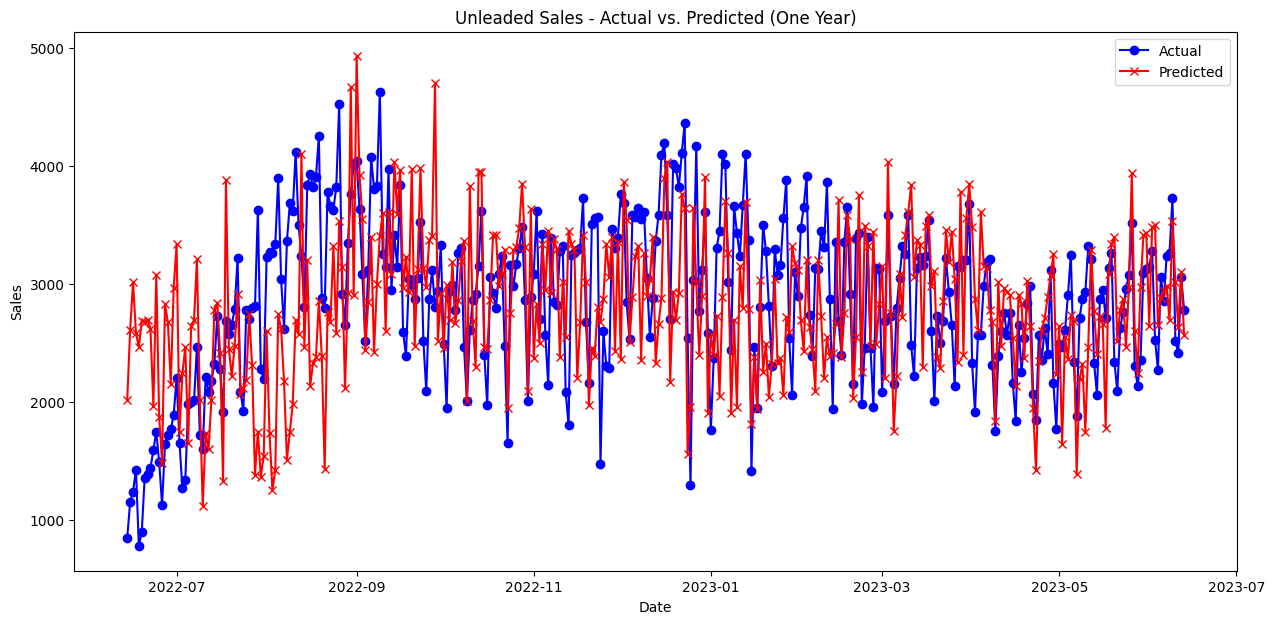

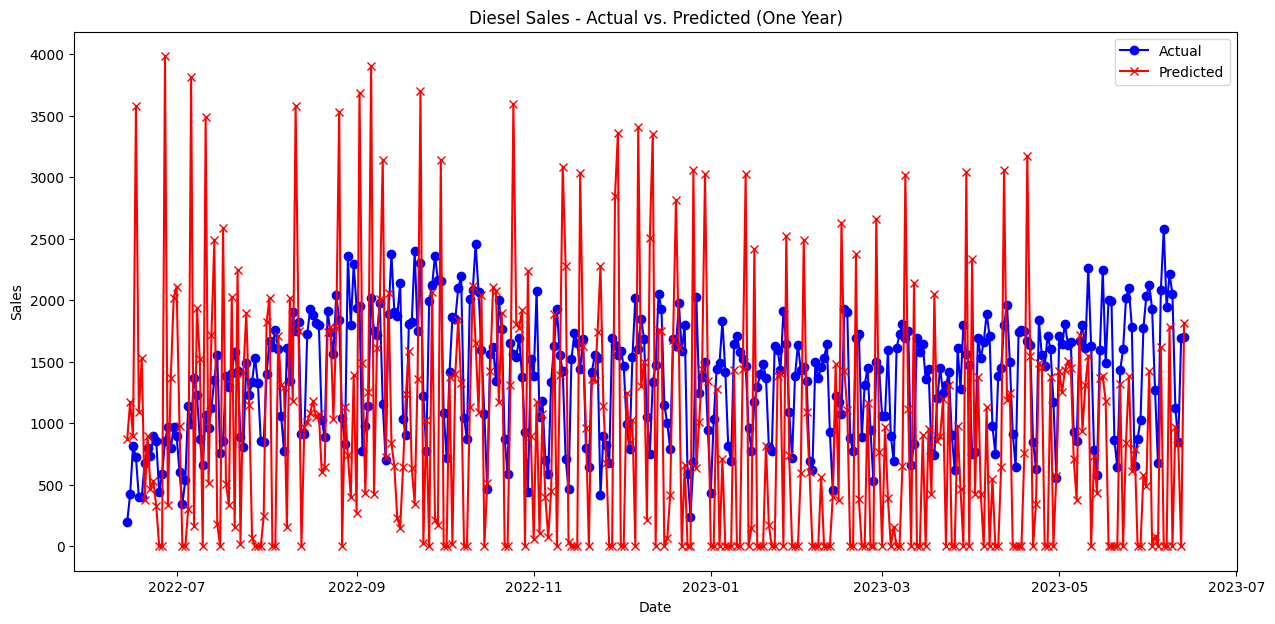

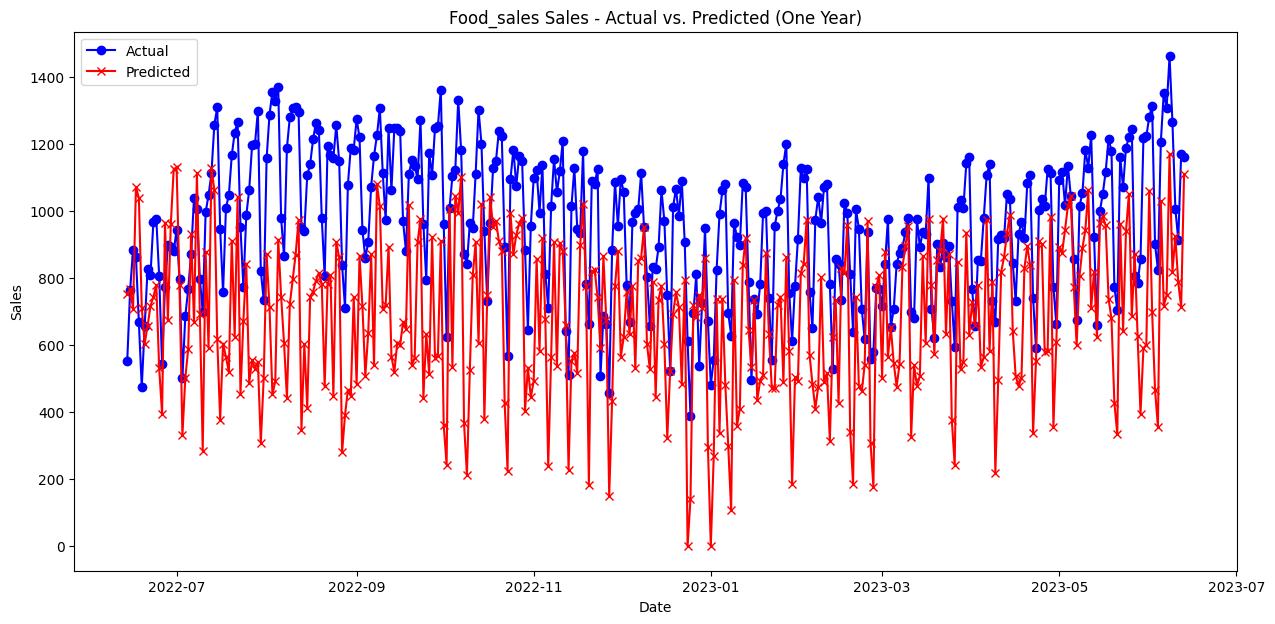

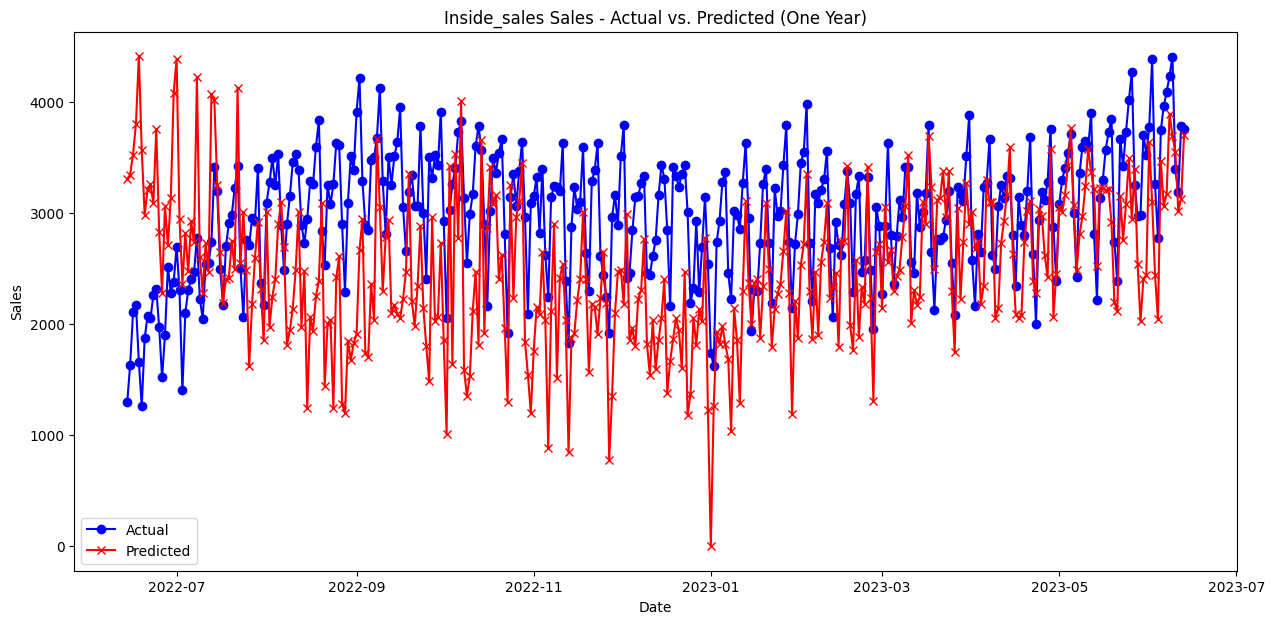

In [12]:
import matplotlib.pyplot as plt

# Function to plot actual vs. predicted sales for one year
def plot_actual_vs_predicted_one_year(actual_sales_data, forecasted_values, store_open_date, metric_name_map):
    # Define the 'one_year' period
    one_year_delta = pd.Timedelta(days=364)
    end_date = store_open_date + one_year_delta

    # Plot for each metric
    for metric, column_name in metric_name_map.items():
        # Get actual sales for one year
        actual_sales = actual_sales_data[
            (actual_sales_data['ds'] >= store_open_date) &
            (actual_sales_data['ds'] <= end_date)
        ].set_index('ds')[column_name]

        # Get predicted sales for one year
        num_days = len(actual_sales)
        predicted_sales = pd.Series(
            forecasted_values[metric][:num_days],
            index=actual_sales.index
        )

        # Plot actual vs. predicted sales
        plt.figure(figsize=(15, 7))
        plt.plot(actual_sales, label='Actual', marker='o', color='blue')
        plt.plot(predicted_sales, label='Predicted', marker='x', color='red')
        plt.title(f'{metric.capitalize()} Sales - Actual vs. Predicted (One Year)')
        plt.xlabel('Date')
        plt.ylabel('Sales')
        plt.legend()
        plt.show()

# Call the function with your data
plot_actual_vs_predicted_one_year(actual_sales_data, forecasted_values, store_open_date, metric_name_map)


# 365 Day Forecasts from Day 0

## Unleaded

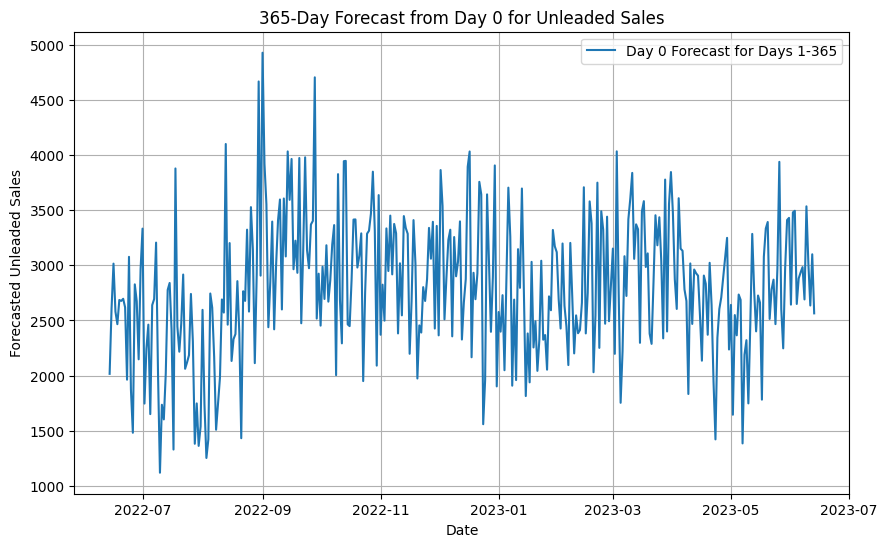

In [ ]:
import matplotlib.pyplot as plt

metric_to_visualize = 'unleaded'

# Create lists to store the dates and forecasted values for plotting
dates = []
forecast_values = []

# Only consider the first day's forecast for the entire x-day horizon
day = 0
start_date = split_date + pd.Timedelta(days=day)
end_date = split_date + pd.Timedelta(days=365)  # End date for a x-day horizon

# Collect the forecasted values for the x-day horizon starting from Day 0
current_forecast_values = []
current_dates = []
for forecast_date in pd.date_range(start=start_date, end=end_date):
    if forecast_date in daily_forecasted_values[metric_to_visualize]:
        current_forecast_values.append(daily_forecasted_values[metric_to_visualize][forecast_date])
        current_dates.append(forecast_date)

dates.append(current_dates)
forecast_values.append(current_forecast_values)

# Plot the forecasted values
plt.figure(figsize=(10, 6))
plt.plot(dates[0], forecast_values[0], label=f'Day 0 Forecast for Days 1-365')

plt.xlabel('Date')
plt.ylabel(f'Forecasted {metric_to_visualize.capitalize()} Sales')
plt.title(f'365-Day Forecast from Day 0 for {metric_to_visualize.capitalize()} Sales')
plt.legend()
plt.grid(True)
plt.show()


## Diesel

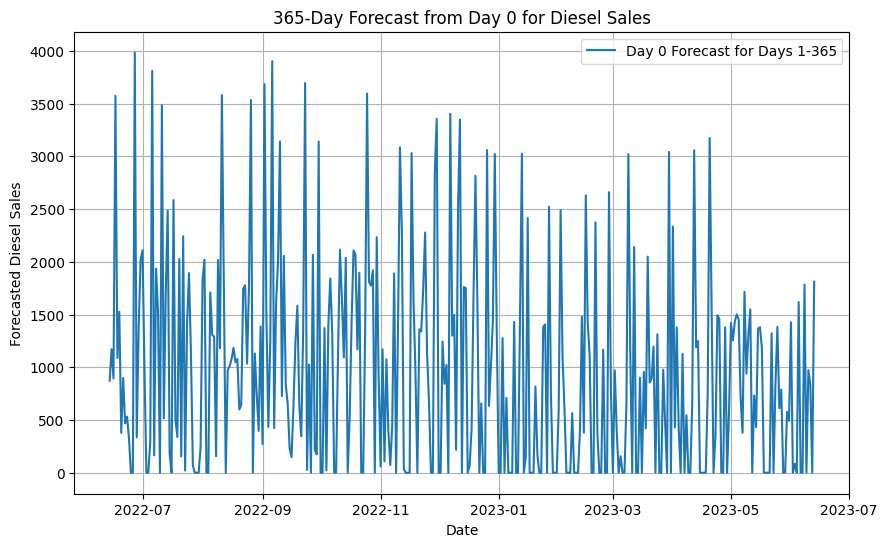

In [ ]:
import matplotlib.pyplot as plt

metric_to_visualize = 'diesel'

# Create lists to store the dates and forecasted values for plotting
dates = []
forecast_values = []

# Only consider the first day's forecast for the entire x-day horizon
day = 0
start_date = split_date + pd.Timedelta(days=day)
end_date = split_date + pd.Timedelta(days=365)  # End date for a x-day horizon

# Collect the forecasted values for the x-day horizon starting from Day 0
current_forecast_values = []
current_dates = []
for forecast_date in pd.date_range(start=start_date, end=end_date):
    if forecast_date in daily_forecasted_values[metric_to_visualize]:
        current_forecast_values.append(daily_forecasted_values[metric_to_visualize][forecast_date])
        current_dates.append(forecast_date)

dates.append(current_dates)
forecast_values.append(current_forecast_values)

# Plot the forecasted values
plt.figure(figsize=(10, 6))
plt.plot(dates[0], forecast_values[0], label=f'Day 0 Forecast for Days 1-365')

plt.xlabel('Date')
plt.ylabel(f'Forecasted {metric_to_visualize.capitalize()} Sales')
plt.title(f'365-Day Forecast from Day 0 for {metric_to_visualize.capitalize()} Sales')
plt.legend()
plt.grid(True)
plt.show()


## Food Sales

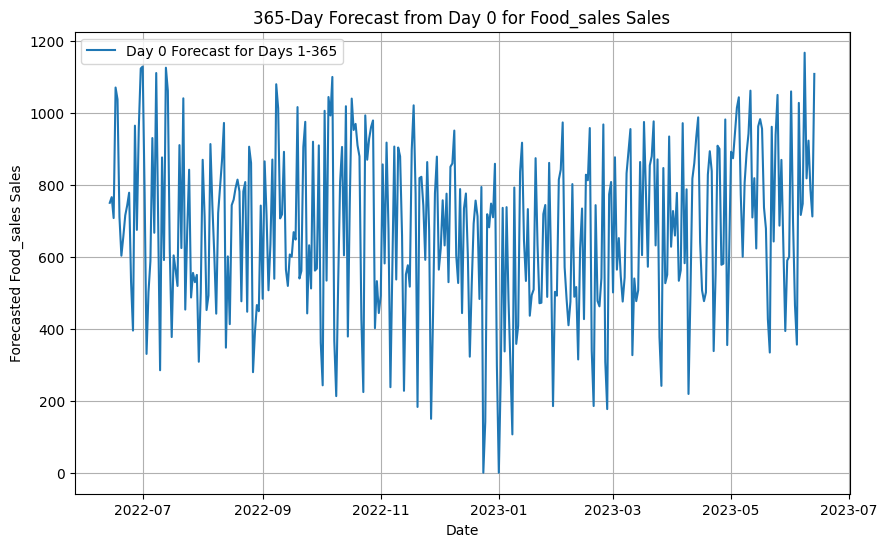

In [ ]:
import matplotlib.pyplot as plt

metric_to_visualize = 'food_sales'

# Create lists to store the dates and forecasted values for plotting
dates = []
forecast_values = []

# Only consider the first day's forecast for the entire x-day horizon
day = 0
start_date = split_date + pd.Timedelta(days=day)
end_date = split_date + pd.Timedelta(days=365)  # End date for a x-day horizon

# Collect the forecasted values for the x-day horizon starting from Day 0
current_forecast_values = []
current_dates = []
for forecast_date in pd.date_range(start=start_date, end=end_date):
    if forecast_date in daily_forecasted_values[metric_to_visualize]:
        current_forecast_values.append(daily_forecasted_values[metric_to_visualize][forecast_date])
        current_dates.append(forecast_date)

dates.append(current_dates)
forecast_values.append(current_forecast_values)

# Plot the forecasted values
plt.figure(figsize=(10, 6))
plt.plot(dates[0], forecast_values[0], label=f'Day 0 Forecast for Days 1-365')

plt.xlabel('Date')
plt.ylabel(f'Forecasted {metric_to_visualize.capitalize()} Sales')
plt.title(f'365-Day Forecast from Day 0 for {metric_to_visualize.capitalize()} Sales')
plt.legend()
plt.grid(True)
plt.show()


## Inside Sales

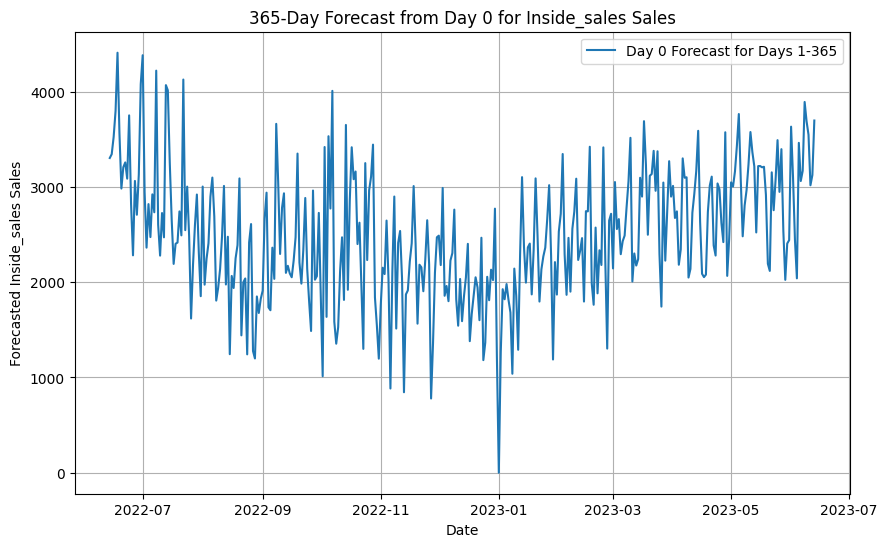

In [ ]:
import matplotlib.pyplot as plt

metric_to_visualize = 'inside_sales'

# Create lists to store the dates and forecasted values for plotting
dates = []
forecast_values = []

# Only consider the first day's forecast for the entire x-day horizon
day = 0
start_date = split_date + pd.Timedelta(days=day)
end_date = split_date + pd.Timedelta(days=365)  # End date for a x-day horizon

# Collect the forecasted values for the x-day horizon starting from Day 0
current_forecast_values = []
current_dates = []
for forecast_date in pd.date_range(start=start_date, end=end_date):
    if forecast_date in daily_forecasted_values[metric_to_visualize]:
        current_forecast_values.append(daily_forecasted_values[metric_to_visualize][forecast_date])
        current_dates.append(forecast_date)

dates.append(current_dates)
forecast_values.append(current_forecast_values)

# Plot the forecasted values
plt.figure(figsize=(10, 6))
plt.plot(dates[0], forecast_values[0], label=f'Day 0 Forecast for Days 1-365')

plt.xlabel('Date')
plt.ylabel(f'Forecasted {metric_to_visualize.capitalize()} Sales')
plt.title(f'365-Day Forecast from Day 0 for {metric_to_visualize.capitalize()} Sales')
plt.legend()
plt.grid(True)
plt.show()


# 365 Day Forecasts from Week 3

## Unleaded

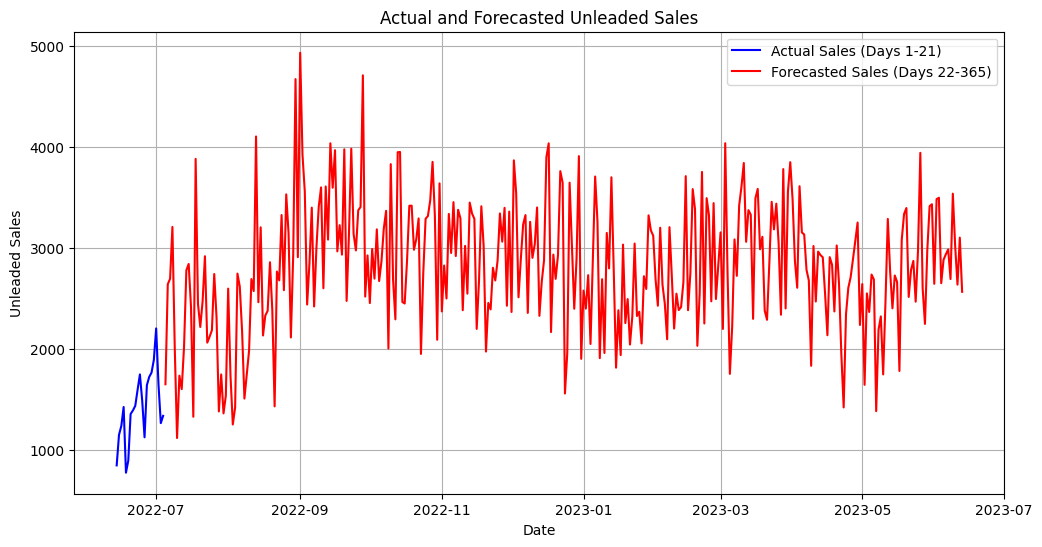

In [ ]:
import matplotlib.pyplot as plt

# Select a metric to visualize, e.g., 'unleaded'
metric_to_visualize = 'unleaded'

# Create lists to store the dates, actual values, and forecasted values for plotting
actual_dates = []
actual_values = []
forecast_dates = []
forecast_values = []

# Collect actual values from Day 1 to Day 21
for day in range(1, 22):
    date = split_date + pd.Timedelta(days=day)
    if date in test_sets[metric_to_visualize]['ds'].values:
        actual_sales = test_sets[metric_to_visualize].loc[test_sets[metric_to_visualize]['ds'] == date, 'y'].iloc[0]
        actual_dates.append(date)
        actual_values.append(actual_sales)

# Collect forecasted values from Day 22 to Day 365 based on the forecast made on Day 21
forecast_start_date = split_date + pd.Timedelta(days=22)
forecast_end_date = split_date + pd.Timedelta(days=365)
for forecast_date in pd.date_range(start=forecast_start_date, end=forecast_end_date):
    if forecast_date in daily_forecasted_values[metric_to_visualize]:
        forecasted_sales = daily_forecasted_values[metric_to_visualize][forecast_date]
        forecast_dates.append(forecast_date)
        forecast_values.append(forecasted_sales)

# Plot the actual and forecasted values
plt.figure(figsize=(12, 6))
plt.plot(actual_dates, actual_values, label='Actual Sales (Days 1-21)', color='blue')
plt.plot(forecast_dates, forecast_values, label='Forecasted Sales (Days 22-365)', color='red')

plt.xlabel('Date')
plt.ylabel(f'{metric_to_visualize.capitalize()} Sales')
plt.title(f'Actual and Forecasted {metric_to_visualize.capitalize()} Sales')
plt.legend()
plt.grid(True)
plt.show()



## Diesel

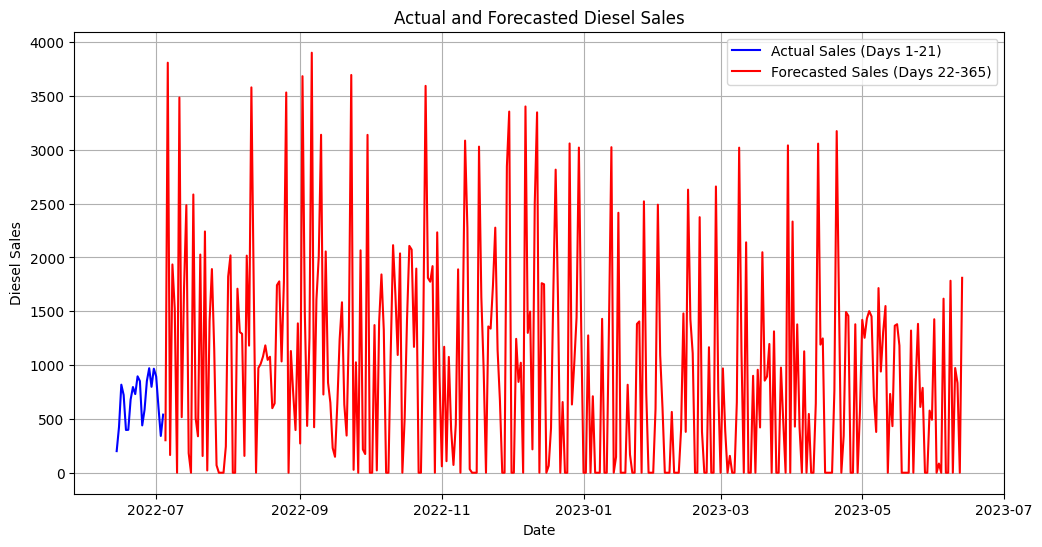

In [ ]:
import matplotlib.pyplot as plt

metric_to_visualize = 'diesel'

# Create lists to store the dates, actual values, and forecasted values for plotting
actual_dates = []
actual_values = []
forecast_dates = []
forecast_values = []

# Collect actual values from Day 1 to Day 21
for day in range(1, 22):
    date = split_date + pd.Timedelta(days=day)
    if date in test_sets[metric_to_visualize]['ds'].values:
        actual_sales = test_sets[metric_to_visualize].loc[test_sets[metric_to_visualize]['ds'] == date, 'y'].iloc[0]
        actual_dates.append(date)
        actual_values.append(actual_sales)

# Collect forecasted values from Day 22 to Day 365 based on the forecast made on Day 21
forecast_start_date = split_date + pd.Timedelta(days=22)
forecast_end_date = split_date + pd.Timedelta(days=365)
for forecast_date in pd.date_range(start=forecast_start_date, end=forecast_end_date):
    if forecast_date in daily_forecasted_values[metric_to_visualize]:
        forecasted_sales = daily_forecasted_values[metric_to_visualize][forecast_date]
        forecast_dates.append(forecast_date)
        forecast_values.append(forecasted_sales)

# Plot the actual and forecasted values
plt.figure(figsize=(12, 6))
plt.plot(actual_dates, actual_values, label='Actual Sales (Days 1-21)', color='blue')
plt.plot(forecast_dates, forecast_values, label='Forecasted Sales (Days 22-365)', color='red')

plt.xlabel('Date')
plt.ylabel(f'{metric_to_visualize.capitalize()} Sales')
plt.title(f'Actual and Forecasted {metric_to_visualize.capitalize()} Sales')
plt.legend()
plt.grid(True)
plt.show()



## Food Sales

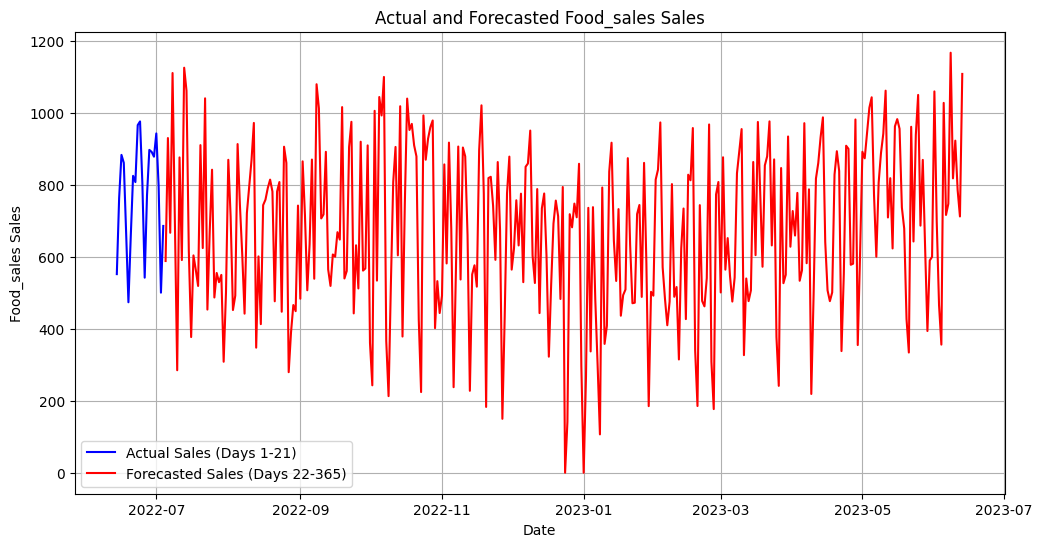

In [ ]:
import matplotlib.pyplot as plt

metric_to_visualize = 'food_sales'

# Create lists to store the dates, actual values, and forecasted values for plotting
actual_dates = []
actual_values = []
forecast_dates = []
forecast_values = []

# Collect actual values from Day 1 to Day 21
for day in range(1, 22):
    date = split_date + pd.Timedelta(days=day)
    if date in test_sets[metric_to_visualize]['ds'].values:
        actual_sales = test_sets[metric_to_visualize].loc[test_sets[metric_to_visualize]['ds'] == date, 'y'].iloc[0]
        actual_dates.append(date)
        actual_values.append(actual_sales)

# Collect forecasted values from Day 22 to Day 365 based on the forecast made on Day 21
forecast_start_date = split_date + pd.Timedelta(days=22)
forecast_end_date = split_date + pd.Timedelta(days=365)
for forecast_date in pd.date_range(start=forecast_start_date, end=forecast_end_date):
    if forecast_date in daily_forecasted_values[metric_to_visualize]:
        forecasted_sales = daily_forecasted_values[metric_to_visualize][forecast_date]
        forecast_dates.append(forecast_date)
        forecast_values.append(forecasted_sales)

# Plot the actual and forecasted values
plt.figure(figsize=(12, 6))
plt.plot(actual_dates, actual_values, label='Actual Sales (Days 1-21)', color='blue')
plt.plot(forecast_dates, forecast_values, label='Forecasted Sales (Days 22-365)', color='red')

plt.xlabel('Date')
plt.ylabel(f'{metric_to_visualize.capitalize()} Sales')
plt.title(f'Actual and Forecasted {metric_to_visualize.capitalize()} Sales')
plt.legend()
plt.grid(True)
plt.show()



## Inside Sales

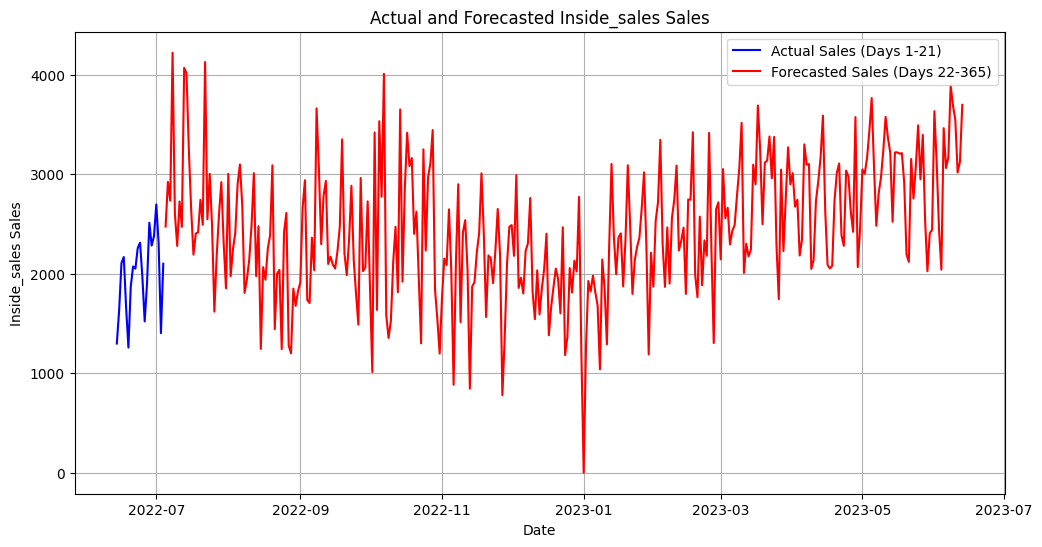

In [ ]:
import matplotlib.pyplot as plt

metric_to_visualize = 'inside_sales'

# Create lists to store the dates, actual values, and forecasted values for plotting
actual_dates = []
actual_values = []
forecast_dates = []
forecast_values = []

# Collect actual values from Day 1 to Day 21
for day in range(1, 22):
    date = split_date + pd.Timedelta(days=day)
    if date in test_sets[metric_to_visualize]['ds'].values:
        actual_sales = test_sets[metric_to_visualize].loc[test_sets[metric_to_visualize]['ds'] == date, 'y'].iloc[0]
        actual_dates.append(date)
        actual_values.append(actual_sales)

# Collect forecasted values from Day 22 to Day 365 based on the forecast made on Day 21
forecast_start_date = split_date + pd.Timedelta(days=22)
forecast_end_date = split_date + pd.Timedelta(days=365)
for forecast_date in pd.date_range(start=forecast_start_date, end=forecast_end_date):
    if forecast_date in daily_forecasted_values[metric_to_visualize]:
        forecasted_sales = daily_forecasted_values[metric_to_visualize][forecast_date]
        forecast_dates.append(forecast_date)
        forecast_values.append(forecasted_sales)

# Plot the actual and forecasted values
plt.figure(figsize=(12, 6))
plt.plot(actual_dates, actual_values, label='Actual Sales (Days 1-21)', color='blue')
plt.plot(forecast_dates, forecast_values, label='Forecasted Sales (Days 22-365)', color='red')

plt.xlabel('Date')
plt.ylabel(f'{metric_to_visualize.capitalize()} Sales')
plt.title(f'Actual and Forecasted {metric_to_visualize.capitalize()} Sales')
plt.legend()
plt.grid(True)
plt.show()



# 365 Day Forecasts from Six Months

## Unleaded


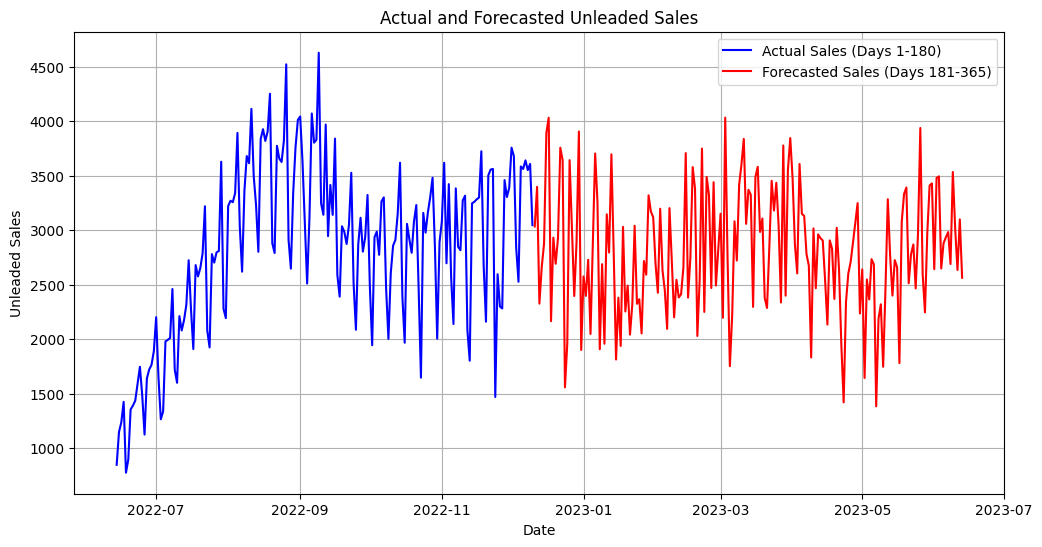

In [30]:
import matplotlib.pyplot as plt

metric_to_visualize = 'unleaded'

# Create lists to store the dates, actual values, and forecasted values for plotting
actual_dates = []
actual_values = []
forecast_dates = []
forecast_values = []

# Collect actual values from Day 1 to Day 180
for day in range(1, 181):
    date = split_date + pd.Timedelta(days=day)
    if date in test_sets[metric_to_visualize]['ds'].values:
        actual_sales = test_sets[metric_to_visualize].loc[test_sets[metric_to_visualize]['ds'] == date, 'y'].iloc[0]
        actual_dates.append(date)
        actual_values.append(actual_sales)

# Collect forecasted values from Day 181 to Day 365 based on the forecast made on Day 180
forecast_start_date = split_date + pd.Timedelta(days=181)
forecast_end_date = split_date + pd.Timedelta(days=365)
for forecast_date in pd.date_range(start=forecast_start_date, end=forecast_end_date):
    if forecast_date in daily_forecasted_values[metric_to_visualize]:
        forecasted_sales = daily_forecasted_values[metric_to_visualize][forecast_date]
        forecast_dates.append(forecast_date)
        forecast_values.append(forecasted_sales)

# Plot the actual and forecasted values
plt.figure(figsize=(12, 6))
plt.plot(actual_dates, actual_values, label='Actual Sales (Days 1-180)', color='blue')
plt.plot(forecast_dates, forecast_values, label='Forecasted Sales (Days 181-365)', color='red')

plt.xlabel('Date')
plt.ylabel(f'{metric_to_visualize.capitalize()} Sales')
plt.title(f'Actual and Forecasted {metric_to_visualize.capitalize()} Sales')
plt.legend()
plt.grid(True)
plt.show()



## Diesel

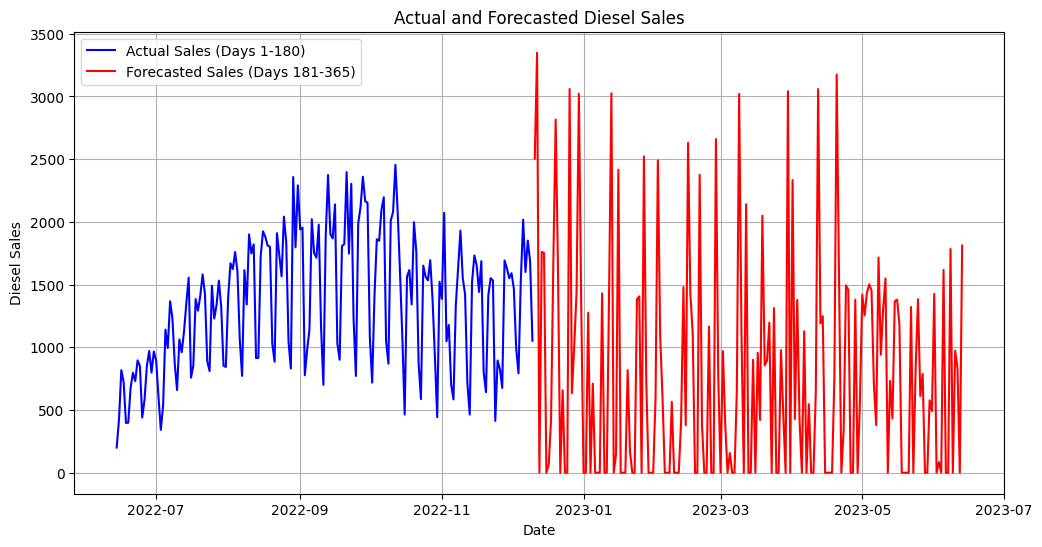

In [29]:
import matplotlib.pyplot as plt

metric_to_visualize = 'diesel'

# Create lists to store the dates, actual values, and forecasted values for plotting
actual_dates = []
actual_values = []
forecast_dates = []
forecast_values = []

# Collect actual values from Day 1 to Day 180
for day in range(1, 181):
    date = split_date + pd.Timedelta(days=day)
    if date in test_sets[metric_to_visualize]['ds'].values:
        actual_sales = test_sets[metric_to_visualize].loc[test_sets[metric_to_visualize]['ds'] == date, 'y'].iloc[0]
        actual_dates.append(date)
        actual_values.append(actual_sales)

# Collect forecasted values from Day 181 to Day 365 based on the forecast made on Day 180
forecast_start_date = split_date + pd.Timedelta(days=181)
forecast_end_date = split_date + pd.Timedelta(days=365)
for forecast_date in pd.date_range(start=forecast_start_date, end=forecast_end_date):
    if forecast_date in daily_forecasted_values[metric_to_visualize]:
        forecasted_sales = daily_forecasted_values[metric_to_visualize][forecast_date]
        forecast_dates.append(forecast_date)
        forecast_values.append(forecasted_sales)

# Plot the actual and forecasted values
plt.figure(figsize=(12, 6))
plt.plot(actual_dates, actual_values, label='Actual Sales (Days 1-180)', color='blue')
plt.plot(forecast_dates, forecast_values, label='Forecasted Sales (Days 181-365)', color='red')

plt.xlabel('Date')
plt.ylabel(f'{metric_to_visualize.capitalize()} Sales')
plt.title(f'Actual and Forecasted {metric_to_visualize.capitalize()} Sales')
plt.legend()
plt.grid(True)
plt.show()

## Food Sales

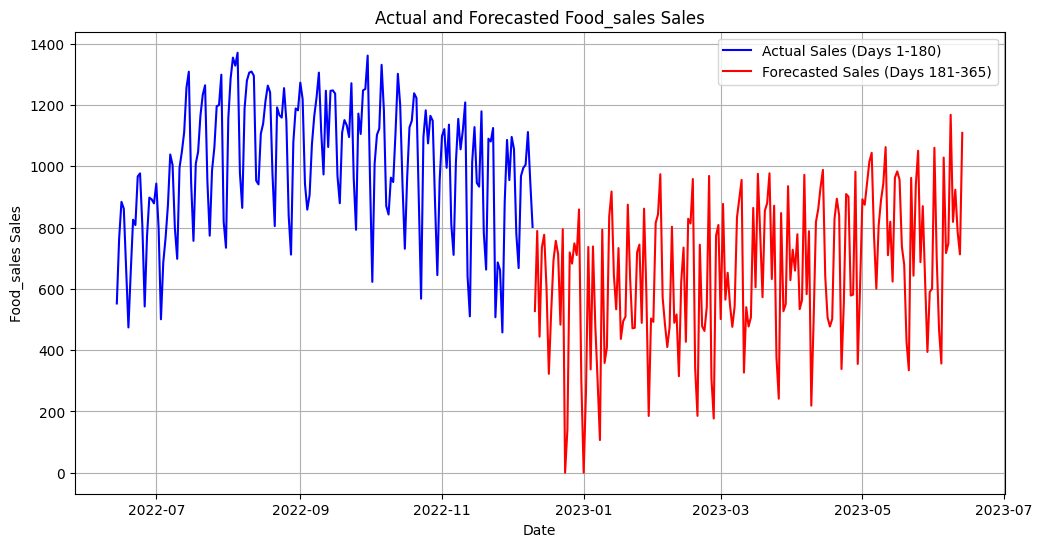

In [27]:
import matplotlib.pyplot as plt

metric_to_visualize = 'food_sales'

# Create lists to store the dates, actual values, and forecasted values for plotting
actual_dates = []
actual_values = []
forecast_dates = []
forecast_values = []

# Collect actual values from Day 1 to Day 180
for day in range(1, 181):
    date = split_date + pd.Timedelta(days=day)
    if date in test_sets[metric_to_visualize]['ds'].values:
        actual_sales = test_sets[metric_to_visualize].loc[test_sets[metric_to_visualize]['ds'] == date, 'y'].iloc[0]
        actual_dates.append(date)
        actual_values.append(actual_sales)

# Collect forecasted values from Day 181 to Day 365 based on the forecast made on Day 180
forecast_start_date = split_date + pd.Timedelta(days=181)
forecast_end_date = split_date + pd.Timedelta(days=365)
for forecast_date in pd.date_range(start=forecast_start_date, end=forecast_end_date):
    if forecast_date in daily_forecasted_values[metric_to_visualize]:
        forecasted_sales = daily_forecasted_values[metric_to_visualize][forecast_date]
        forecast_dates.append(forecast_date)
        forecast_values.append(forecasted_sales)

# Plot the actual and forecasted values
plt.figure(figsize=(12, 6))
plt.plot(actual_dates, actual_values, label='Actual Sales (Days 1-180)', color='blue')
plt.plot(forecast_dates, forecast_values, label='Forecasted Sales (Days 181-365)', color='red')

plt.xlabel('Date')
plt.ylabel(f'{metric_to_visualize.capitalize()} Sales')
plt.title(f'Actual and Forecasted {metric_to_visualize.capitalize()} Sales')
plt.legend()
plt.grid(True)
plt.show()

## Inside Sales

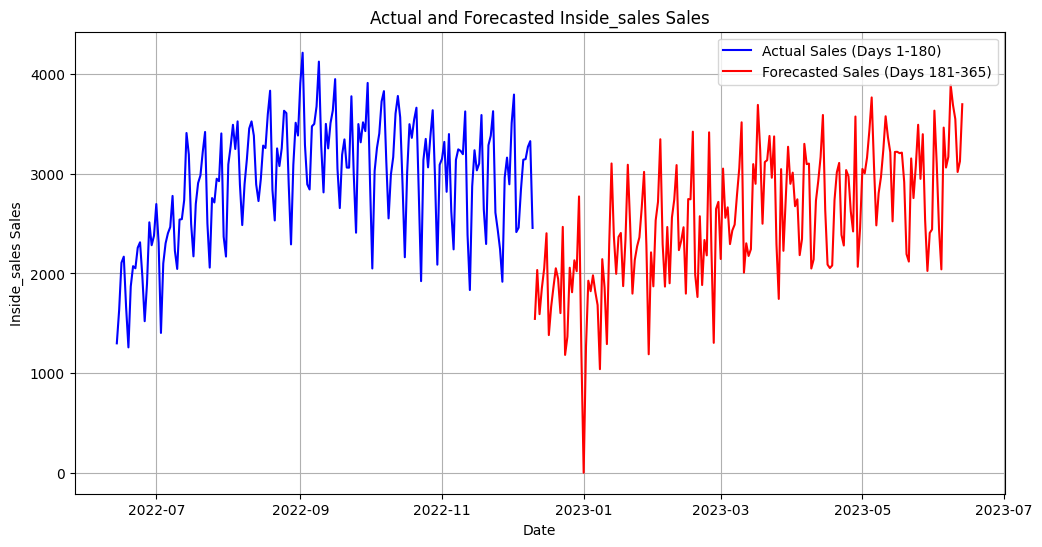

In [28]:
import matplotlib.pyplot as plt

metric_to_visualize = 'inside_sales'

# Create lists to store the dates, actual values, and forecasted values for plotting
actual_dates = []
actual_values = []
forecast_dates = []
forecast_values = []

# Collect actual values from Day 1 to Day 180
for day in range(1, 181):
    date = split_date + pd.Timedelta(days=day)
    if date in test_sets[metric_to_visualize]['ds'].values:
        actual_sales = test_sets[metric_to_visualize].loc[test_sets[metric_to_visualize]['ds'] == date, 'y'].iloc[0]
        actual_dates.append(date)
        actual_values.append(actual_sales)

# Collect forecasted values from Day 181 to Day 365 based on the forecast made on Day 180
forecast_start_date = split_date + pd.Timedelta(days=181)
forecast_end_date = split_date + pd.Timedelta(days=365)
for forecast_date in pd.date_range(start=forecast_start_date, end=forecast_end_date):
    if forecast_date in daily_forecasted_values[metric_to_visualize]:
        forecasted_sales = daily_forecasted_values[metric_to_visualize][forecast_date]
        forecast_dates.append(forecast_date)
        forecast_values.append(forecasted_sales)

# Plot the actual and forecasted values
plt.figure(figsize=(12, 6))
plt.plot(actual_dates, actual_values, label='Actual Sales (Days 1-180)', color='blue')
plt.plot(forecast_dates, forecast_values, label='Forecasted Sales (Days 181-365)', color='red')

plt.xlabel('Date')
plt.ylabel(f'{metric_to_visualize.capitalize()} Sales')
plt.title(f'Actual and Forecasted {metric_to_visualize.capitalize()} Sales')
plt.legend()
plt.grid(True)
plt.show()